Notebook Instructions:

- This notebook was built in google colaboratory and is thus recommended to run there.
- Create three folders in the colaboratory 'files' tab labeled: 'resp','util', and 'feel' in the default '/content' directory (automatically opened when selecting the folder icon on the left on google colab) and upload the respective pickle files found in data>processed. Colab requires the folders are created locally and the data then uploaded respectively.


*Note* - 1) Application of models will exceed google colaboratory acceptable runtimes. For this study's analysis, the files were saved, re-uploaded, and each algorithm was applied independently to be within the runtime limits. 2) Original data required to pre-process the data and build the time series is not provided because of the privacy risk associated with it.


# Data Preparation

## Importing Modules and Data

In [ ]:
# imports for initial data processing
import pandas as pd
import numpy as np
import time
from datetime import datetime as dt
import datetime
import matplotlib.pyplot as plt
import statistics as stats
from sklearn import preprocessing
import math
import pickle
from google.colab import files
import json

# Sensor Data import
sleep_df = pd.read_csv('/content/emfit_sleep_summary_20050507.csv') #Changed dates
water_df = pd.read_csv('/content/streamlabs_20050507.csv')
electricity_df = pd.read_csv('/content/senselabs_20050507.csv')

# Formulary Data import
daily_logs = pd.read_csv('/content/Daily Log_DATA_2005-08-15_1129.csv').dropna(subset=['participant_id','dl_date'])
calls_df = pd.read_csv('/content/Follow-up-calls.csv')

## SLEEP

#### Function Definitions

In [ ]:
# Below funcitons transform the Sleep int date into a datetime object
def transform_sleeptimeFrom(row):
  return dt.fromtimestamp(row['from'])
def transform_sleeptimeTo(row):
  return dt.fromtimestamp(row['to'])

def rounded_range(row):
  '''Rounds the start time to closest hour, and rounds the end time to closest hour -1 since the applicable 
  hour for either time will represent that hour forward; e.g., rounding 2.35pm to 3pm for end time means the 
  data would apply 3pm onwards, an hour is therefore subtracted to represent coverage up to 3pm.'''
  start = roundTime(row['from'])
  end = roundTime(row['to']-datetime.timedelta(hours=1))
  time_range = end - start
  hours = (time_range.total_seconds()/60/60)+1
  return [start+datetime.timedelta(hours= h) for h in range(int(hours))]

def roundTime(dt=None, roundTo=60*60):
   """Round a datetime object to any time lapse in hours
   dt : datetime.datetime object, default now.
   roundTo : Closest number of seconds to round to.
   Author: Thierry Husson 2012.
   """
   if dt == None : dt = datetime.datetime.now()
   seconds = (dt.replace(tzinfo=None) - dt.replace(hour=0, minute=0, second=0)).seconds
   rounding = (seconds+roundTo/2) // roundTo * roundTo
   return dt + datetime.timedelta(0,rounding-seconds,-dt.microsecond)

def weight_overlaps_sleep(df):
  '''Creating weighted mean for overlapping values. The mean is taken for overlapping values and a weighted
  average is created based on entry_time_covered/sum(all_time_covered_by_all_entries). The weighted values
  are then applied to the earliest start time and the latest end time.'''
  better_df = pd.DataFrame()

  dates = sorted(set([i.date() for i in df['from']]))

  for date in dates:
    day_df = df.loc[df['date'] == date]
    if len(day_df) > 1:
      froms = day_df['from'].to_list()
      tos = day_df['to'].to_list()
      

      if len(froms) != len(set(froms)) and len(set(froms)) == 1:
        day_df = day_df.loc[day_df['to']==max(tos)]
        better_df = pd.concat([better_df, day_df])
      elif len(tos) != len(set(tos)) and len(set(tos)) == 1:
        day_df = day_df.loc[day_df['from']==min(froms)]
        better_df = pd.concat([better_df, day_df])
      else:
        froms = list(set(froms))
        tos = list(set(tos))
        fro_tos = sorted(zip(froms, tos), key = lambda x: x[0])
        overlaps = []
        for i in range(len(fro_tos)-1):
          fro = fro_tos[i][0]
          to = fro_tos[i][1]
          if fro == min(froms) and to == max(tos):
            better_df = pd.concat([better_df, day_df.loc[day_df['from']==fro]])
            break
          elif tos[i] > froms[i+1]:
            overlaps.append(i)
        if len(overlaps) > 0:
          froms = day_df['from'].to_list()
          tos = day_df['to'].to_list()
          weights = [ (to-fro)/(max(tos)-min(froms)) for fro, to in zip(froms, tos)]
          weights = [i/sum(weights) for i in weights]
          #print(weights)
          total = day_df.sum()
          total.name = 'total'
          columns = day_df.columns
          rows = [i.to_list() for indx, i in day_df.reset_index(drop=True).iterrows()]
          mean_row = []
          for i, row in enumerate(rows):
            mean_row.append([val*weights[i] for val in row[4:31]])

          mean_row = [sum(i) for i in zip(*mean_row)]

          new_row = [i for i in rows[0][:4]]
          [new_row.append(i) for i in mean_row]
          [new_row.append(i) for i in rows[0][31:]]

          new_row = pd.DataFrame(data={col:val for col, val in zip(columns, new_row)}).iloc[0]
          better_df = better_df.append(new_row)

        
    else:
      better_df = pd.concat([better_df, day_df])
  return better_df


#### Cleaning and differentiating

In [ ]:
# Applying functions to sleep data to eliminate repeated entries and harmonize overlapping entries
sleep_df['from'] = sleep_df.apply(transform_sleeptimeFrom, axis=1)
sleep_df['to'] = sleep_df.apply(transform_sleeptimeTo, axis=1)
sleep_df['time'] = sleep_df.apply(rounded_range, axis=1)
sleep_df['date'] = [i[0].date() for i in sleep_df['time'].to_list()]

sleep_h2 = sleep_df.loc[sleep_df['home']=='home002'].reset_index(drop=True)
sleep_h2 = weight_overlaps_sleep(sleep_h2)
sleep_h7 = sleep_df.loc[sleep_df['home']=='home007'].reset_index(drop=True)
sleep_h7 = weight_overlaps_sleep(sleep_h7)


## WATER

In [ ]:
def transform_timewater(row):
  '''Tranforms water data date into usable format, separating entries' by separator where needed.'''
  time = str(row['time'])
  time = time.split('00-04:00')[0]+'00'
  return dt.strptime(time, '%Y-%m-%dT%H:%M:%S')- datetime.timedelta(days='Not Available')

water_df['time'] = water_df.apply(transform_timewater, axis=1)

# Removing unnecessary info from the data
water_df_clean = water_df.drop(columns=['sensor','year','month','day','hour'])
display(water_df_clean)

,time,volume,home
0,2004-12-17 17:00:00,22.330109,home007
1,2004-12-17 18:00:00,0.000000,home007
2,2004-12-17 19:00:00,1.063767,home007
3,2004-12-17 20:00:00,0.000000,home007
4,2004-12-17 21:00:00,0.995560,home007
...,...,...,...
3099,2005-05-07 02:00:00,0.000000,home002
3100,2005-05-07 04:00:00,0.000000,home002
3101,2005-05-07 08:00:00,0.000000,home002
3102,2005-05-07 09:00:00,0.000000,home002


## ELECTRICITY

In [ ]:

def transform_timeelectric(row):
  '''Similarly to previous functions, transforms given electricity data time
  format into usable datetime objects, separating where needed.'''
  time = str(row['time'])
  time = time.split('.000Z')[0]
  return dt.strptime(time, '%Y-%m-%dT%H:%M:%S')- datetime.timedelta(days='Not Available for Release')
  
electricity_df['time'] = electricity_df.apply(transform_timeelectric, axis=1)

# Reformatting electricity device labels into standard format
e_devices = electricity_df['devicename'].to_list()
e_devices = [device.lower().strip() for device in e_devices]
electricity_df['devicename'] = e_devices


# Removing unnecessary columns
electricity_df = electricity_df.drop(columns=['deviceid', 'year','month', 'day', 'hour','sensor'])
display(electricity_df)

,time,devicename,avg,home
0,2004-11-24 01:00:00,fridge 4,82.107,home003
1,2004-11-24 01:00:00,consumption,1502.745,home002
2,2004-11-24 01:00:00,always on,1320.650,home002
3,2004-11-24 01:00:00,fridge,70.661,home006
4,2004-11-24 01:00:00,fridge 2,47.252,home006
...,...,...,...,...
20262,2005-05-07 12:00:00,always on,287.166,home002
20263,2005-05-07 13:00:00,always on,288.000,home002
20264,2005-05-07 13:00:00,consumption,1763.535,home002
20265,2005-05-07 13:00:00,device 1,0.464,home002


In [ ]:
# separating electricity data per home
eh2 = electricity_df.loc[ electricity_df['home'] == 'home002']
eh3 = electricity_df.loc[ electricity_df['home'] == 'home003']
eh6 = electricity_df.loc[ electricity_df['home'] == 'home006']

e_devices = set(e_devices)

segmented_eh2 = {}
segmented_eh3 = {}
segmented_eh6 = {}

# Dic below storing per-device DF, later 
homedevice_dfs = {device:[] for device in e_devices}

# Dic below for undifferentiated devices, grouped by general device class
e_devices_grouped = set([ ''.join([i for i in s if not i.isdigit()]).strip() for s in e_devices])
devicehome_dfs = { home: {device:[] for device in e_devices_grouped } for home in ['home002','home003','home006'] }

count = 0

for home in [eh2, eh3, eh6]:
  curr_home = home['home'].to_list()[0]
  for device in e_devices:
    tmp_df = home.loc[home['devicename'] == device]
    tmp_df = tmp_df.drop(columns=['devicename','home'])
    if len(tmp_df)>0:
      homedevice_dfs[device].append(tmp_df)
    if 'ac' in device:
      if len(device)>2 and len(tmp_df) > 0:
        devicehome_dfs[curr_home]['furnace'].append(tmp_df)
      elif len(device) == 2 and len(tmp_df) > 0 :
        devicehome_dfs[curr_home]['ac'].append(tmp_df)
    else:
      [devicehome_dfs[curr_home][device_x].append(tmp_df) for device_x in e_devices_grouped if device.split()[0] in device_x and 
     len(tmp_df)>0]

    if len(tmp_df) > 0:
      tmp_df = tmp_df
      if count == 0 :
        segmented_eh2[device] = tmp_df
      elif count == 1:
        segmented_eh3[device] = tmp_df
      else:
        segmented_eh6[device] = tmp_df
  
  count += 1
  
# Below for total aggregate consumption per day
daily_aggregate_consumption_dfs = {'home002':[], 'home003':[], 'home006':[]}

for home in [eh2, eh3, eh6]:
  total_econsumption = pd.DataFrame()
  curr_df = home.copy()
  curr_df['date'] = [ i.date() for i in curr_df['time'].to_list()]
  dates = set(curr_df['date'].to_list())
  dates = [ pd.Timestamp(date) + datetime.timedelta(hours=14) for date in dates]
  
  curr_home = home['home'].to_list()[0]
  for date in dates:
    mask_filter = (date - datetime.timedelta(hours=23) <= curr_df['time']) & (curr_df['time'] <= date+datetime.timedelta(minutes=59, seconds=59))
    tmp_df = curr_df.loc[ mask_filter ]
    total_consumption = sum(tmp_df['avg'].to_list())
    new_row = pd.DataFrame(data={'time':[date], 'consumption':[total_consumption]})
    total_econsumption = total_econsumption.append(new_row)
  daily_aggregate_consumption_dfs[curr_home].append(total_econsumption.reset_index(drop=True))


# Below for total aggregate consumption per hour
aggregate_consumption_dfs = {'home002':[], 'home003':[], 'home006':[]}

for home in [eh2, eh3, eh6]:
  total_econsumption = pd.DataFrame()
  curr_df = home.copy()
  curr_df['time'] = [ roundTime(i) for i in curr_df['time'].to_list()]
  dates = set(curr_df['time'].to_list())
  
  curr_home = home['home'].to_list()[0]
  for date in dates:
    tmp_df = curr_df.loc[curr_df['time']==date]
    total_consumption = sum(tmp_df['avg'].to_list())
    new_row = pd.DataFrame(data={'time':[date], 'consumption':[total_consumption]})
    total_econsumption = total_econsumption.append(new_row)
  aggregate_consumption_dfs[curr_home].append(total_econsumption.reset_index(drop=True))


# Below for category aggregated consumption

eat_n_drink_devices = ['coffee maker 2',
 'coffee maker',
 'coffee maker 1',
 'coffee maker 3',
 'coffee maker 4',
 'fridge',
 'fridge 2',
 'fridge 3',
 'fridge 4',
 'furnace',
 'microwave',
 'stove']
eatdrink_econsumption_dfs = {'home002':[], 'home003':[], 'home006':[]}

living_device = [i for i in e_devices if i not in eat_n_drink_devices]
living_econsumption_dfs = {'home002':[], 'home003':[], 'home006':[]}

for home in [eh2, eh3, eh6]:
  times = set(home['time'].to_list())
  curr_home = home['home'].to_list()[0]
  eatndrink_econsumption = pd.DataFrame()
  living_econsumption = pd.DataFrame()
  
  for time in times:
    tmp_df = home.loc[home['time'] == time]
    drink_consumption = []
    other_consumption = []
    for indx, row in tmp_df.iterrows():
      if row['devicename'].strip().lower() in eat_n_drink_devices:
        drink_consumption.append(row['avg'])
      else:
        other_consumption.append(row['avg'])

    eatndrink_econsumption = eatndrink_econsumption.append(pd.DataFrame(data={
        'time':[time],
        'consumption':[sum(drink_consumption)]
    }))
    living_econsumption = living_econsumption.append(pd.DataFrame(data={
        'time':[time],
        'consumption':[sum(other_consumption)]
    }))

  
  eatdrink_econsumption_dfs[curr_home].append(eatndrink_econsumption.reset_index(drop=True))
  living_econsumption_dfs[curr_home].append(living_econsumption.reset_index(drop=True))

# Storage of them all
electricity_all_timeseries = {'type of device consumption per home':[eatdrink_econsumption_dfs, living_econsumption_dfs],
                              'total consumption per home':[aggregate_consumption_dfs],
                              'consumption per home per device':[devicehome_dfs]}

## Daily Logs

In [ ]:
def dl_transform_dates(row):
  '''Returns the a formatted given row's date with except in place for missing entries, if any.'''
  try:
    return datetime.datetime.strptime(row['dl_date'], '%m/%d/%Y')
  except:
    return 'nan'


In [ ]:
# Replacing alternate home names to standard ones
home_dic_replace = sorted(set(daily_logs['participant_id'].to_list()))
home_standard_names = ['home001','home002','home003','home006','home007']
home_dic_replace = {h1:h2 for h1,h2 in zip(home_dic_replace, home_standard_names)}
home_names = [home_dic_replace[i] for i in daily_logs['participant_id'].to_list()]

# Transforming dates into usable format and placing data in appropiate columns
daily_logs['date']=daily_logs.apply(dl_transform_dates, axis=1)
daily_logs['home'] = home_names
daily_logs.drop(columns=['participant_id','dl_date'], inplace=True)

In [ ]:
# Storing the questions relevant to each of the three outcomes, with an initial overview of the data.
increased_respiratory_symptoms_vars = ['dl_cha','dl_chb','dl_chc','dl_chd']
hc_util_var_dl = ['dl_hc_util']
overall_feeling_activity_vars = ['dl_feel','dl_act2yes']


for home in list(set(daily_logs['home'].to_list())):
  print(home)
  tmp_df = daily_logs.loc[daily_logs['home']==home]
  print(tmp_df.describe())

## Calls

In [ ]:
def calls_transform_dates(row):
  '''Transforms given string date into datetime object'''
  return datetime.datetime.strptime(row['fu_date'], '%m/%d/%Y')

In [ ]:
# Standardizing home names
home_names = [home_dic_replace[i] for i in calls_df['participant_id'].to_list()]
calls_df['home'] = home_names
# Transforming date to datetime object
calls_df['date']=calls_df.apply(calls_transform_dates, axis=1)
# Removing repetitive data
calls_df.drop(columns=['participant_id','fu_date'], inplace=True)

In [ ]:
# obtaining healthcare utilization data into unified df
hc_util_dl  = daily_logs[['dl_hc_util','home','date']].copy()

hc_utills = hc_util_dl['dl_hc_util'].to_list()

for i, v in enumerate(hc_utills):
  if math.isnan(float(v)):
    hc_utills[i] = 0

hc_util_dl['fu_1_encoded'] = hc_utills

tmp_df = calls_df[['fu_1_encoded','home','date']]

for i, row in hc_util_dl.iterrows():
  home = row['home']
  date = row['date']
  xdf = tmp_df.loc[(tmp_df['home']==home) & (tmp_df['date']==date)]
  if len(xdf)==0:
    calls_df.append(row)


homes = sorted(set(calls_df['home'].to_list()))
hc_utilization_variables = ['fu_1']

hc_utilization_dfs = {home:[] for home in homes}

for home in homes:
  hdf = calls_df.loc[calls_df['home']==home]
  return_df = pd.DataFrame()
  return_df['date'] = hdf['date'].to_list()
  return_df['hc_utilization'] = hdf['fu_1_encoded'].to_list()

  hc_utilization_dfs[home]=return_df

# Data Overview and Descriptive statistics

## Water

In [ ]:
# Obtaining water data statistics per home, realization home 2 has no data
water_homes = sorted(set(water_df['home'].to_list()))

water_statistics = {}
for home in water_homes:
  print(home.capitalize(),'\n')
  home_df = water_df.loc[water_df['home']==home]
  home_df.drop(inplace=True, columns=['year', 'month', 'day', 'hour'])
  water_statistics['home'] = {}

  times = home_df['time'].to_list()
  dates = set([i.date() for i in times])
  volumes = home_df['volume'].to_list()
  min_time, max_time = min(times), max(times)
  water_statistics['home']['min time'] = min_time
  water_statistics['home']['max time'] = max_time
  water_statistics['home']['time range'] = max_time-min_time
  measure_type = type(volumes[0])
  water_statistics['home']['measure_type'] = measure_type
  water_statistics['home']['null value counts'] = home_df.isnull().sum()
  
  print('Null Value counts \n'+
      str(water_statistics['home']['null value counts'])
      )
  print('\nTime Range',(max_time-min_time))
  print('\nTotal n days measured:', len(dates))
  print('\nTotal volume measured:',home_df['volume'].sum(0))
  print('\nDescriptive Statistics\n', home_df.describe())

  print('\n\n\n')

Home002 

Null Value counts 
time      0
volume    0
home      0
sensor    0
dtype: int64

Time Range 95 days 22:00:00

Total n days measured: 38

Total volume measured: 0.0

Descriptive Statistics
        volume
count   709.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0




Home003 

Null Value counts 
time      0
volume    0
home      0
sensor    0
dtype: int64

Time Range 87 days 00:00:00

Total n days measured: 88

Total volume measured: 9338.419297379

Descriptive Statistics
             volume
count  1938.000000
mean      4.818586
std      11.890949
min       0.000000
25%       0.000000
50%       1.026741
75%       5.022911
max     164.908570




Home007 

Null Value counts 
time      0
volume    0
home      0
sensor    0
dtype: int64

Time Range 19 days 02:00:00

Total n days measured: 20

Total volume measured: 2444.073822358

Descriptive Statistics
            volume
count  457.000000
mean     5.348083
std      7.578300
min 

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


HOME003
HOME007


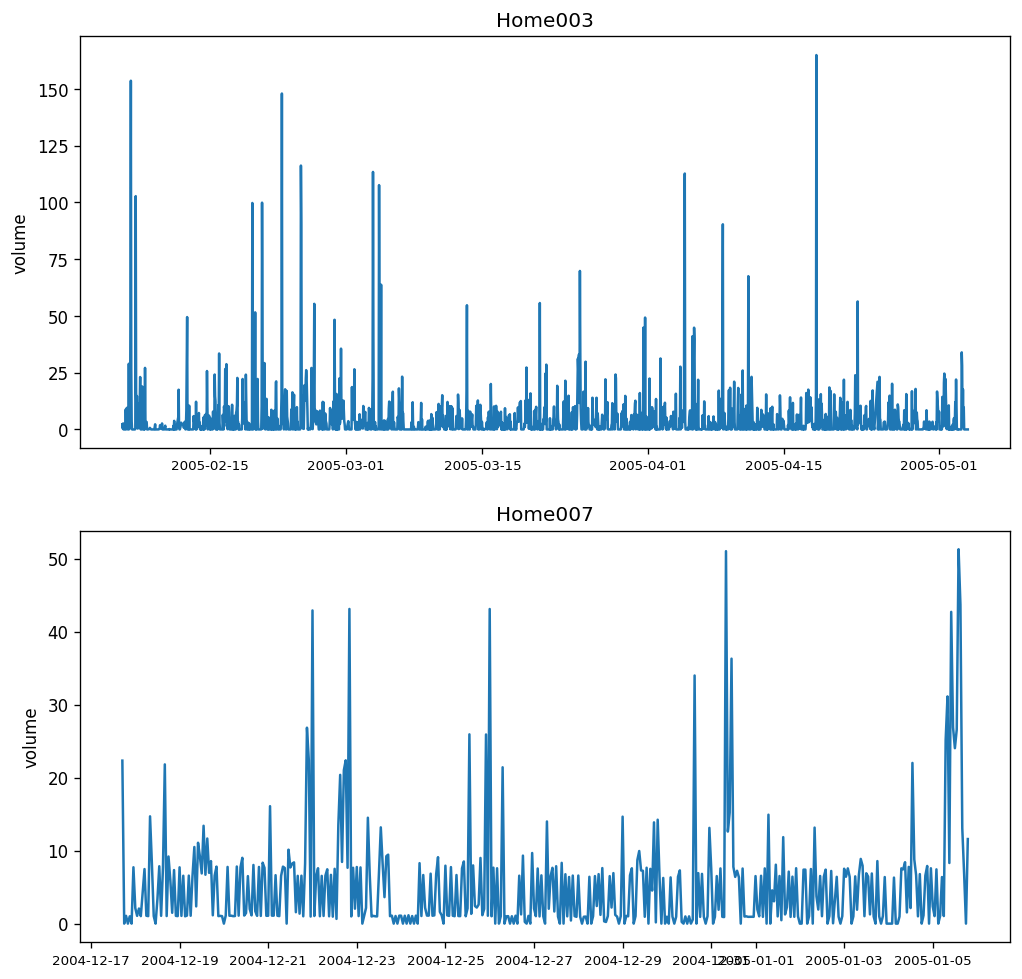

In [ ]:
# Plotting water volume used per home
fig, ax = plt.subplots(2, figsize=(10,10),dpi=120)

problematic_dates = [ ]
for i, home in enumerate(['home003','home007']):
  
  pdate = []
  print(home.upper())
  wdf = water_df.loc[water_df['home']==home]
  #display(wdf)
  vals = [i for i in wdf['volume'].to_list()]
  times = [ i for i in wdf['time'].to_list()]
  dates_all = [ date.date() for date in times]
  dates = set(dates_all)
  #print('Days covered:',len(dates))



  ax[i].plot(times, vals)
  ax[i].xaxis.set_tick_params(labelsize=8)
  ax[i].set_title(home.capitalize())
  ax[i].set_ylabel("volume")

  


## Electricity

In [ ]:
# Median electricity consumed in given hour
for df in [eh2,eh6,eh3]:
  vals= df['avg'].to_list()

  print(stats.median(vals))

472.7405
56.403
88.894


In [ ]:
# Plotting/saving descriptive statistics for electricity data
electric_homes = set(electricity_df['home'].to_list())

electric_statistics = {}
for home in electric_homes:
  print(home.capitalize(),'\n')
  home_df = electricity_df.loc[electricity_df['home']==home]
  #home_df.drop(inplace=True, columns=['year', 'month', 'day', 'hour'])
  electric_statistics['home'] = {}
  
  times = home_df['time'].to_list()
  dates = set([i.date() for i in times])
  volumes = home_df['avg'].to_list()
  min_time, max_time = min(times), max(times)
  electric_statistics['home']['min time'] = min_time
  electric_statistics['home']['max time'] = max_time
  electric_statistics['home']['time range'] = max_time-min_time
  measure_type = type(volumes[0])
  electric_statistics['home']['measure_type'] = measure_type
  electric_statistics['home']['null value counts'] = home_df.isnull().sum()
  
  print('Null Value counts \n'+
      str(electric_statistics['home']['null value counts'])
      )
  print('\nTime Range',(max_time-min_time))
  print('\nTotal n days measured:', len(dates))
  print('\nTotal consumption measured:',home_df['avg'].sum(0))
  print('\nDescriptive Statistics\n', home_df.describe())

  print('\n\n\n')

Home002 

Null Value counts 
time          0
devicename    0
avg           0
home          0
dtype: int64

Time Range 164 days 12:00:00

Total n days measured: 56

Total consumption measured: 1852643.757

Descriptive Statistics
                 avg
count   2574.000000
mean     719.752819
std      874.335459
min        0.039000
25%      232.524500
50%      472.740500
75%      771.179000
max    10384.528000




Home003 

Null Value counts 
time          0
devicename    0
avg           0
home          0
dtype: int64

Time Range 161 days 02:00:00

Total n days measured: 110

Total consumption measured: 5760471.172

Descriptive Statistics
                 avg
count  13592.000000
mean     423.813359
std      708.010053
min        0.003000
25%       45.858250
50%       88.894000
75%      497.291250
max     8049.005000




Home006 

Null Value counts 
time          0
devicename    0
avg           0
home          0
dtype: int64

Time Range 39 days 00:00:00

Total n days measured: 40

Total cons

HOME002
device
motor
heat
always on
consumption


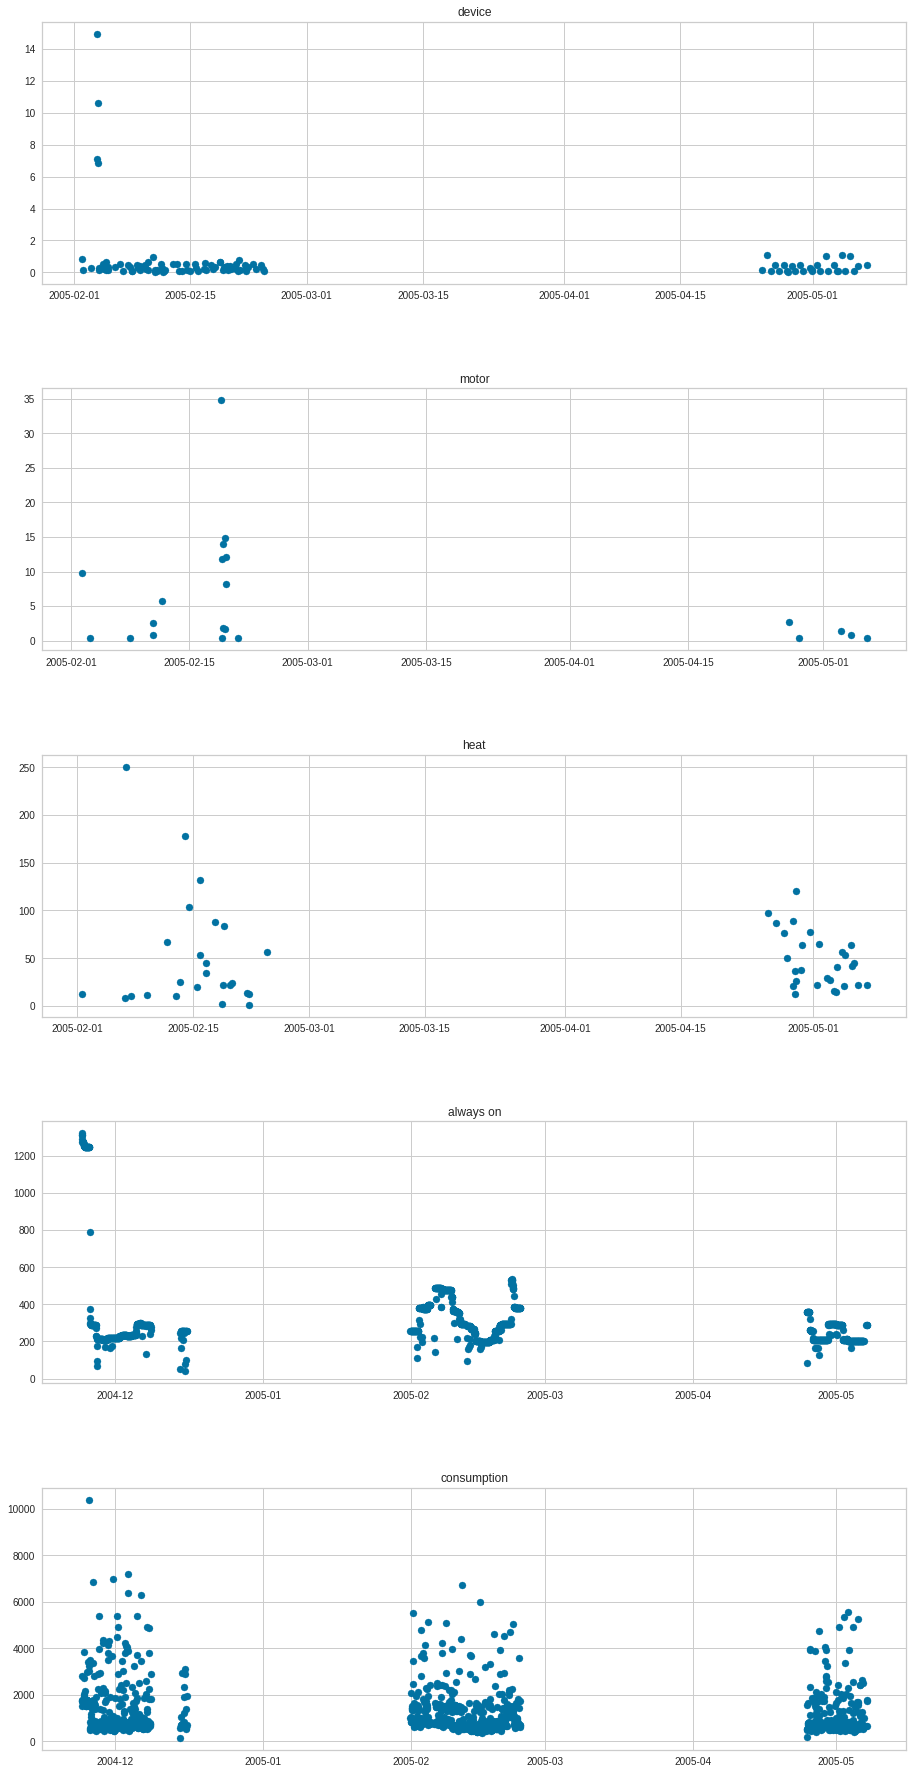

In [ ]:
homeofinterest = 'home002'
sensors = set(eh2['devicename'].to_list())
sensors_x = [ sensor for sensor, df_ls in  devicehome_dfs[homeofinterest].items() if len(df_ls) > 0]

fig, ax = plt.subplots(len(sensors_x), figsize=(15,30))


for i, home in enumerate([homeofinterest]):
  print(home.upper())
  sensor_dic = devicehome_dfs[home]
  counter = 0
  for ix, data in enumerate(sensor_dic.items()):
    sensor=data[0]
    if sensor in sensors_x:
      
      try:
        df = data[1][0]
        df = df.sort_values('time')
        if len(data[1]) > 0:
          print(sensor)
          data = df['avg'].to_list()
          dates= df['time'].to_list()

          ax[counter].scatter(dates, data)
          ax[counter].set_title(sensor)
          counter += 1
      except:
        continue


plt.subplots_adjust(left=0.1,
                    bottom=.1, 
                    right=0.9, 
                    top=.9, 
                    wspace=0.1, 
                    hspace=0.4)


In [ ]:
devicehome_dfs['home002']

{'ac': [], 'always on': [                     time       avg
  2     2004-11-24 01:00:00  1320.650
  10    2004-11-24 02:00:00  1313.683
  23    2004-11-24 03:00:00  1311.000
  36    2004-11-24 04:00:00  1289.183
  43    2004-11-24 05:00:00  1275.200
  ...                   ...       ...
  20256 2005-05-06 20:00:00   202.000
  20258 2005-05-07 10:00:00   286.166
  20259 2005-05-07 11:00:00   286.333
  20262 2005-05-07 12:00:00   287.166
  20263 2005-05-07 13:00:00   288.000
  
  [1196 rows x 2 columns]], 'coffee maker': [], 'consumption': [                     time       avg
  1     2004-11-24 01:00:00  1502.745
  12    2004-11-24 02:00:00  2795.848
  24    2004-11-24 03:00:00  1765.789
  37    2004-11-24 04:00:00  1736.279
  49    2004-11-24 05:00:00  1715.753
  ...                   ...       ...
  20255 2005-05-06 20:00:00   998.235
  20257 2005-05-07 10:00:00   662.177
  20260 2005-05-07 11:00:00   677.565
  20261 2005-05-07 12:00:00  1746.563
  20264 2005-05-07 13:00:00  1763.535


## Sleep

In [ ]:
# Plotting/saving statistics for sleep data
sleep_homes = set(sleep_df['home'].to_list())

sleep_statistics = {}
for home in sleep_homes:
  print(home.capitalize(),'\n')
  home_df = sleep_df.loc[sleep_df['home']==home]
  #home_df.drop(inplace=True, columns=['year', 'month', 'day', 'hour'])
  sleep_statistics['home'] = {}
  
  times = home_df['from'].to_list()
  times2 = home_df['to'].to_list()
  dates = set(home_df['date'].to_list())
  min_time, max_time = min(times), max(times)
  sleep_statistics['home']['min time'] = min_time
  sleep_statistics['home']['max time'] = max_time
  sleep_statistics['home']['time range'] = max_time-min_time
  measure_type = type(volumes[0])
  sleep_statistics['home']['measure_type'] = measure_type
  sleep_statistics['home']['null value counts'] = home_df.isnull().sum()
  
  print('Null Value counts \n'+
      str(sleep_statistics['home']['null value counts'])
      )
  print('\nTime Range',(max_time-min_time))
  print('\nTotal n days measured:', len(dates))
  #print('\nTotal consumption measured:',home_df['avg'].sum(0))
  print('\nDescriptive Statistics\n', home_df.describe())

  print('\n\n\n')

Home007 

Null Value counts 
id                      0
device                  0
from                    0
to                      0
avg_hr                  0
avg_rr                  0
avg_act                 0
sleep_score             2
duration                0
duration_in_bed         0
duration_awake          2
duration_in_sleep       2
duration_in_rem         2
duration_in_light       2
duration_in_deep        2
duration_sleep_onset    2
bedexit_duration        0
bedexit_count           0
tossnturn_count         0
from_gmt_offset         0
min_hr                  0
max_hr                  0
min_rr                  0
max_rr                  0
fm_count                0
awakenings              2
hrv_score               0
hrv_lf                  0
hrv_hf                  0
hrv_rmssd_evening       0
hrv_rmssd_morning       0
home                    0
sensor                  0
year                    0
month                   0
day                     0
time                    0
date     

## Daily Logs

### Sleep

In [ ]:
val_sleep_vars = ['dl_s2','dl_s3','dl_s4','dl_s1','home','date']
sleep_dl = daily_logs[val_sleep_vars]

### Respiratory Symptoms

In [ ]:
increased_respiratory_symptoms_vars = ['dl_cha','dl_chb','dl_chc','dl_chd', 'home','date']
respiratory_dl = daily_logs[increased_respiratory_symptoms_vars]
respiratory_dl['dl_cha'] = [float(i) for i in respiratory_dl['dl_cha'].to_list()]
respiratory_dl['dl_chb'] = [float(i) for i in respiratory_dl['dl_chb'].to_list()]
respiratory_dl['dl_chc'] = [float(i) for i in respiratory_dl['dl_chc'].to_list()]
respiratory_dl['dl_chd'] = [float(i) for i in respiratory_dl['dl_chd'].to_list()]
respiratory_dl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,dl_cha,dl_chb,dl_chc,dl_chd,home,date
0,2.0,2.0,1.0,2.0,home001,2003-11-23
1,1.0,1.0,1.0,1.0,home001,2003-11-24
2,3.0,2.0,2.0,3.0,home001,2003-11-25
3,1.0,1.0,1.0,1.0,home001,2003-11-26
4,1.0,1.0,1.0,1.0,home001,2003-11-27
...,...,...,...,...,...,...
1451,2.0,2.0,2.0,2.0,home007,2005-06-19
1452,2.0,2.0,2.0,2.0,home007,2005-06-20
1453,2.0,2.0,2.0,2.0,home007,2005-06-21
1454,2.0,2.0,2.0,2.0,home007,2005-06-22


#### RespSymptoms Analysis

In [ ]:
homes = sorted(homes)

In [ ]:
respiratorySymptoms_dfs = {home:[] for home in homes}

for home in homes:
  hdf = respiratory_dl.loc[(respiratory_dl['home']==home)]
  dates = [ ]
  overall_change = []
  previous_sum = 0
  error_counter = 0
  for i, row in hdf.iterrows():
    dl_cha = row['dl_cha']
    dl_chb = row['dl_chb']
    dl_chc = row['dl_chc']
    dl_chd = row['dl_chd']
    date = row['date']
    all_symptoms = [ i for i in [ dl_cha, dl_chb, dl_chc, dl_chd] if i < 4 and not math.isnan(i)]
    try:
      symptom_mean = sum(all_symptoms)/len(all_symptoms)
      if symptom_mean >= 2.25 :
        overall_change.append('decline')
      elif symptom_mean <= 1.75 :
        overall_change.append('improvement')
      else:
        overall_change.append('constant')
      
      dates.append(date)
    except:
      error_counter += 1
      continue
    
  respiratorySymptoms_dfs[home] = pd.DataFrame({
      'date':dates,
      'symptom_change':overall_change
  })
  print(home)
  print(overall_change.count('decline'))
  print(overall_change.count('improvement'))
  print(overall_change.count('constant'))
  print('errors encountered',error_counter,'\n')

home001
60
49
200
errors encountered 16 

home002
2
226
107
errors encountered 7 

home003
12
225
20
errors encountered 49 

home006
0
1
135
errors encountered 5 

home007
1
0
341
errors encountered 0 



In [ ]:
respiratorySymptoms_dfs['home007'].sort_values('date')

,date,symptom_change
0,2004-06-30,constant
1,2004-07-01,constant
2,2004-07-02,constant
3,2004-07-03,constant
4,2004-07-04,constant
...,...,...
337,2005-06-19,constant
338,2005-06-20,constant
339,2005-06-21,constant
340,2005-06-22,constant


In [ ]:
counter_len = 0
for h, df in respiratorySymptoms_dfs.items():
  counter_len += len(df)
print(counter_len)

1379


In [ ]:
for var in increased_respiratory_symptoms_vars[:4]:
  
  val_col = var
  for home in sorted(homes):
    print(home.capitalize(), var.capitalize())
    hdl = respiratory_dl.loc[respiratory_dl['home']==home]
    acts = [float(i) for x, i in enumerate(hdl[val_col].to_list()) if not math.isnan(float(i)) and float(i) in [1,2,3]] 
    print( "Number of logs {}".format( len(acts) )  )

    hcdate_mean = stats.mean(acts)
    hcdate_min = min(acts)
    hcdate_max = max(acts)
    hcdate_median = stats.median(acts)
    hcdate_mode = stats.mode(acts)
    try:
      hcdate_stdev = stats.stdev(acts)
    except:
      hcdate_stdev = 'NaN'
      continue
    print('Min: {}    MAX: {}  \nMean: {}\nMedian: {}\nMode: {}\nStdev: {}\n\n\n'.format(hcdate_min,hcdate_max,hcdate_mean  ,hcdate_median  ,hcdate_mode   ,hcdate_stdev))

    print('\n')
    if home=='home002' and var=='dl_chc':
      print(acts)

Home001 Dl_cha
Number of logs 309
Min: 1.0    MAX: 3.0  
Mean: 2.0388349514563107
Median: 2.0
Mode: 2.0
Stdev: 0.5908775681921012





Home002 Dl_cha
Number of logs 334
Min: 1.0    MAX: 3.0  
Mean: 1.8263473053892216
Median: 2.0
Mode: 2.0
Stdev: 0.4242221063703044





Home003 Dl_cha
Number of logs 242
Min: 1.0    MAX: 3.0  
Mean: 1.1818181818181819
Median: 1.0
Mode: 1.0
Stdev: 0.5153253011206647





Home006 Dl_cha
Number of logs 136
Min: 1.0    MAX: 2.0  
Mean: 1.9926470588235294
Median: 2.0
Mode: 2.0
Stdev: 0.08574929257125442





Home007 Dl_cha
Number of logs 342
Min: 2.0    MAX: 3.0  
Mean: 2.002923976608187
Median: 2.0
Mode: 2.0
Stdev: 0.05407380704358752





Home001 Dl_chb
Number of logs 309
Min: 1.0    MAX: 3.0  
Mean: 2.0355987055016183
Median: 2.0
Mode: 2.0
Stdev: 0.5883291723714318





Home002 Dl_chb
Number of logs 200
Min: 1.0    MAX: 2.0  
Mean: 1.045
Median: 1.0
Mode: 1.0
Stdev: 0.20782433633689137





Home003 Dl_chb
Number of logs 1
Home006 Dl_chb
Number of logs 136


In [ ]:
# Plotting dates
'''fig, ax = plt.subplots(dpi=120)
for home in homes[::-1]:
  print(home.upper())
  hdf = respiratory_dl.loc[ respiratory_dl['home'] == home]
  dates = hdf['date'].to_list()
  vals = [home.split('00')[1] for i in range(len(dates))]
  ax.plot(dates, vals, label=home)
  print(len(hdf))

ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=0)
ax.set_title('Daily Log Dates')
ax.legend(loc='lower left')'''

"fig, ax = plt.subplots(dpi=120)\nfor home in homes[::-1]:\n  print(home.upper())\n  hdf = respiratory_dl.loc[ respiratory_dl['home'] == home]\n  dates = hdf['date'].to_list()\n  vals = [home.split('00')[1] for i in range(len(dates))]\n  ax.plot(dates, vals, label=home)\n  print(len(hdf))\n\nax.xaxis.set_tick_params(labelsize=8)\nax.yaxis.set_tick_params(labelsize=0)\nax.set_title('Daily Log Dates')\nax.legend(loc='lower left')"

In [ ]:
'home001'.split('00')[1]

'1'

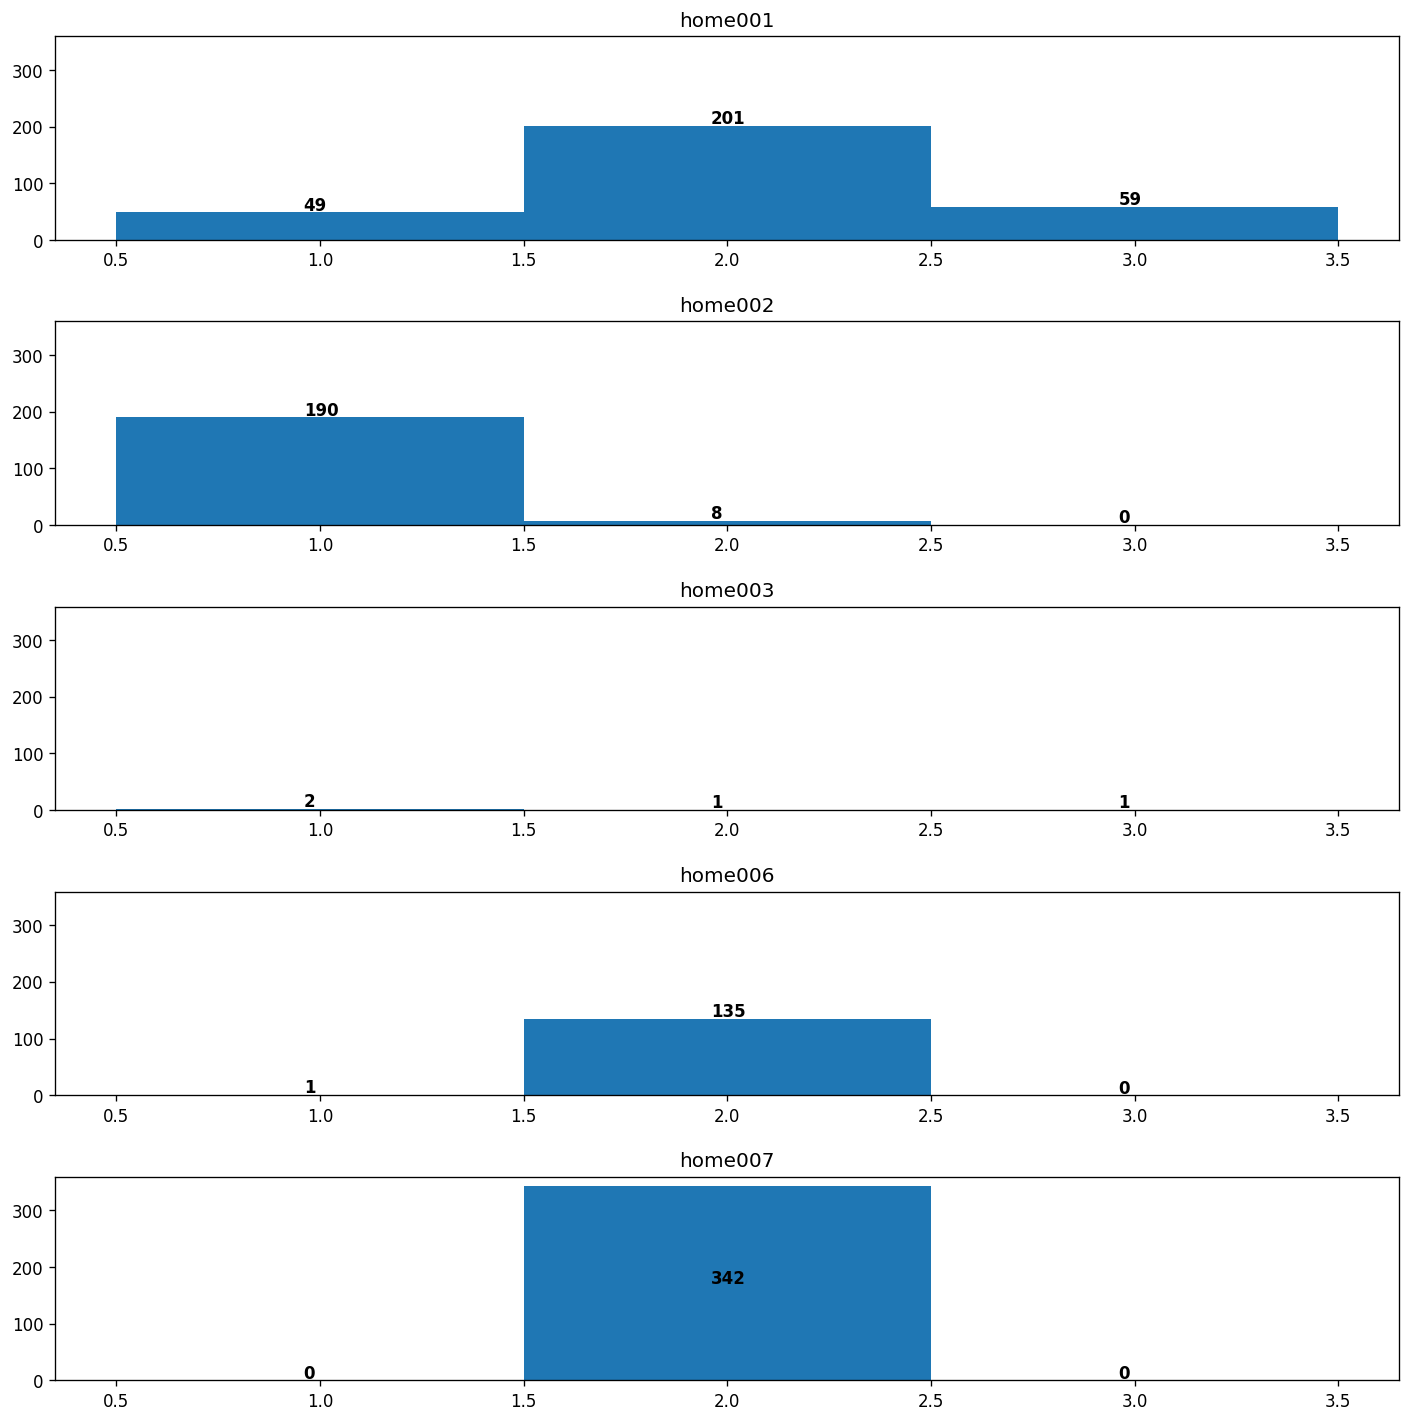

In [ ]:
cha_data = { home : respiratory_dl['dl_chc'].loc[respiratory_dl['home'] == home].to_list() for home in sorted(homes) }

for home, ls in cha_data.items():
  cha_data[home] = [float(i) for i in ls if not math.isnan(float(i)) and float(i) in [1,2,3]]

lss = [i for i in cha_data.values()]
bins = [.5,1.5,1.5,2.5,2.5,3.5]
binsx = [.96,1.96,2.96]
fig, ax = plt.subplots(5, figsize=(14,14), tight_layout=False, sharey=True , dpi=120)
#fig.set_title('Shortness of Breath Histogram Per Home in Ascending Order')
for i, ls in enumerate(lss):
  countone = ls.count(1)
  counttwo = ls.count(2)
  countthree = ls.count(3)
  ax[i].hist(ls, bins=bins)
  ax[i].set_title(list(sorted(homes))[i])
  for ix, v in enumerate( [ countone, counttwo, countthree ]):
    if v >= 300:
      ax[i].text(binsx[ix], v/2,  str(v), color='black', fontweight='bold')
    else:
      ax[i].text(binsx[ix], v+4,  str(v), color='black', fontweight='bold')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

### Feeling & Activity

In [ ]:
import statistics as stats
# 1, Much lower | 2, A little lower | 3, About the same | 4, A little higher | 5, Much higher

overall_feeling_activity_vars = ['dl_feel','dl_act2yes','home','date']
feelActive_dl = daily_logs[overall_feeling_activity_vars]

homes = sorted(set(feelActive_dl['home'].to_list()))
feelActive_dfs = {}

for home in homes:
  hdf = feelActive_dl.loc[feelActive_dl['home']==home]

  feels_original = hdf['dl_feel'].to_list()
  feels = []
  for feel in feels_original:
    if type(feel)==str:
      try:
        feels.append(float(feel.split('.')[0]))
      except:
        feels.append(float(feel.split('-')[0]))
    else:
      feels.append(feel)
  stdev_feel = stats.stdev(feels)
  feels_change = ['NaN']
  for i, feel in enumerate(feels[1:]):
    difference = feel-feels[i]
    if difference!=0:
      if difference < 0:
        feels_change.append('decline')
      else:
        feels_change.append('improvement')

    else:
      feels_change.append('constant')
  print(home, 'declines: {}, improvements {}'.format(feels_change.count('decline'),feels_change.count('improvement' )))
  feelActive_dfs[home] = pd.DataFrame( data={
      'date':hdf['date'].to_list(),
      'feel_change':list(feels_change)
  })

home001 declines: 80, improvements 108
home002 declines: 4, improvements 24
home003 declines: 29, improvements 48
home006 declines: 5, improvements 38
home007 declines: 11, improvements 22


In [ ]:
val_col = 'dl_feel'
for home in sorted(homes):
  print(home.capitalize())
  hdl = feelActive_dl.loc[feelActive_dl['home']==home]
  feels_original = hdf['dl_feel'].to_list()
  acts = []
  for feel in feels_original:
    if type(feel)==str:
      try:
        acts.append(float(feel.split('.')[0]))
      except:
        acts.append(float(feel.split('-')[0]))
    else:
      acts.append(feel)
  print( "Number of logs {}".format( len(acts) )  )

  hcdate_mean = stats.mean(acts)
  hcdate_min = min(acts)
  hcdate_max = max(acts)
  hcdate_median = stats.median(acts)
  hcdate_mode = stats.mode(acts)
  hcdate_stdev = stats.stdev(acts)
  print('Min: {}    MAX: {}  \nMean: {}\nMedian: {}\nMode: {}\nStdev: {}\n\n\n'.format(hcdate_min,hcdate_max,hcdate_mean  ,hcdate_median  ,hcdate_mode   ,hcdate_stdev))

  print('\n')

Home001
Number of logs 342
Min: 1.0    MAX: 10.0  
Mean: nan
Median: 10.0
Mode: 10.0
Stdev: nan





Home002
Number of logs 342
Min: 1.0    MAX: 10.0  
Mean: nan
Median: 10.0
Mode: 10.0
Stdev: nan





Home003
Number of logs 342
Min: 1.0    MAX: 10.0  
Mean: nan
Median: 10.0
Mode: 10.0
Stdev: nan





Home006
Number of logs 342
Min: 1.0    MAX: 10.0  
Mean: nan
Median: 10.0
Mode: 10.0
Stdev: nan





Home007
Number of logs 342
Min: 1.0    MAX: 10.0  
Mean: nan
Median: 10.0
Mode: 10.0
Stdev: nan







In [ ]:
# Histogram of feel values per home

'''val_col = 'dl_feel'

cha_data = { home : feelActive_dl[val_col].loc[feelActive_dl['home'] == home].to_list() for home in sorted(homes) }

for home, ls in cha_data.items():
  cha_data[home] = [float(i) for i in ls if not math.isnan(float(i)) and 0 < float(i) <= 10]

lss = [i for i in cha_data.values()]
bins = [.75,1.25,1.75,2.25,2.75,3.25, 3.75, 4.25, 4.75,5.25, 5.75,6.25 ,7.75,8.25, 8.75,9.25, 9.75, 10.25]
binsx = [i+.94 for i in range(10)]
fig, ax = plt.subplots(5, figsize=(14,14), tight_layout=False, sharey=True )
#fig.set_title('Shortness of Breath Histogram Per Home in Ascending Order')
for i, ls in enumerate(lss):
  counts = [ ls.count(i+1) for i in range(10)]
  ax[i].hist(ls, bins=bins)
  ax[i].set_title(list(sorted(homes))[i])
  for ix, v in enumerate( counts):
    
    ax[i].text(binsx[ix], v+10,  str(v), color='black', fontweight='bold')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)'''

"val_col = 'dl_feel'\n\ncha_data = { home : feelActive_dl[val_col].loc[feelActive_dl['home'] == home].to_list() for home in sorted(homes) }\n\nfor home, ls in cha_data.items():\n  cha_data[home] = [float(i) for i in ls if not math.isnan(float(i)) and 0 < float(i) <= 10]\n\nlss = [i for i in cha_data.values()]\nbins = [.75,1.25,1.75,2.25,2.75,3.25, 3.75, 4.25, 4.75,5.25, 5.75,6.25 ,7.75,8.25, 8.75,9.25, 9.75, 10.25]\nbinsx = [i+.94 for i in range(10)]\nfig, ax = plt.subplots(5, figsize=(14,14), tight_layout=False, sharey=True )\n#fig.set_title('Shortness of Breath Histogram Per Home in Ascending Order')\nfor i, ls in enumerate(lss):\n  counts = [ ls.count(i+1) for i in range(10)]\n  ax[i].hist(ls, bins=bins)\n  ax[i].set_title(list(sorted(homes))[i])\n  for ix, v in enumerate( counts):\n    \n    ax[i].text(binsx[ix], v+10,  str(v), color='black', fontweight='bold')\n\nplt.subplots_adjust(left=0.1,\n                    bottom=0.1, \n                    right=0.9, \n                    t

## Calls

In [ ]:
val_col = 'hc_utilization'
for home in homes:
  print(home.capitalize())
  hdl = hc_utilization_dfs[home]
  acts = [float(i) for x, i in enumerate(hdl[val_col].to_list()) if not math.isnan(float(i))]
  print( "Number of logs {}".format( len(acts) )  )

  hcdate_mean = stats.mean(acts)
  hcdate_min = min(acts)
  hcdate_max = max(acts)
  hcdate_median = stats.median(acts)
  hcdate_mode = stats.mode(acts)
  hcdate_stdev = stats.stdev(acts)
  print('Min: {}    MAX: {}  \nMean: {}\nMedian: {}\nMode: {}\nStdev: {}\n\n\n'.format(hcdate_min,hcdate_max,hcdate_mean  ,hcdate_median  ,hcdate_mode   ,hcdate_stdev))

  print('\n')

Home001
Number of logs 32
Min: 0.0    MAX: 2.0  
Mean: 0.65625
Median: 0.0
Mode: 0.0
Stdev: 0.7873751821205408





Home002
Number of logs 29
Min: 0.0    MAX: 1.0  
Mean: 0.1724137931034483
Median: 0.0
Mode: 0.0
Stdev: 0.3844258722192448





Home003
Number of logs 26
Min: 0.0    MAX: 2.0  
Mean: 0.23076923076923078
Median: 0.0
Mode: 0.0
Stdev: 0.5870395085642742





Home006
Number of logs 19
Min: 0.0    MAX: 1.0  
Mean: 0.15789473684210525
Median: 0.0
Mode: 0.0
Stdev: 0.3746343246326776





Home007
Number of logs 28
Min: 0.0    MAX: 1.0  
Mean: 0.17857142857142858
Median: 0.0
Mode: 0.0
Stdev: 0.3900210277874798







In [ ]:

val_col = 'date_diff'
all_dates_diff = []
all_dates = []
for home in sorted(homes):
  print("DATA FOR HOME {}\n".format(home.upper()))
  
  hc_dates = sorted(hc_utilization_dfs[home]['date'].to_list())
  print('{} Total Follow-Up Calls'.format(len(set(hc_dates))))
  [all_dates.append(i) for i in hc_dates]
  
  hc_dates = [(val-previous_val) for val, previous_val in zip( hc_dates[ 2:len(return_df['date'].to_list())-1], 
                                                  hc_dates[1:len(return_df['date'].to_list())-1] 
  )]
  [all_dates_diff.append(i) for i in hc_dates]
  n_df = pd.DataFrame({
      val_col:hc_dates
  })
  hcdate_mean = n_df[val_col].mean()
  hcdate_min = min(n_df[val_col].to_list())
  hcdate_max = max(n_df[val_col].to_list())
  hcdate_median = stats.median(hc_dates)
  hcdate_mode = stats.mode(hc_dates)
  hcdate_stdev = n_df[val_col].std()
  
  print('Min: {}    MAX: {}  \nMean: {}\nMedian: {}\nMode: {}\nStdev: {}\n\n\n'.format(hcdate_min,hcdate_max,hcdate_mean  ,hcdate_median  ,hcdate_mode   ,hcdate_stdev))
  #display(hc_utilization_dfs[home])

n_df = pd.DataFrame({
      val_col:sorted(all_dates_diff)
  })
hcdate_mean = n_df[val_col].mean()
hcdate_min = min(n_df[val_col].to_list())
hcdate_max = max(n_df[val_col].to_list())
hcdate_median = stats.median(hc_dates)
hcdate_mode = stats.mode(hc_dates)
hcdate_stdev = n_df[val_col].std()
print('Min: {}    MAX: {}  \nMean: {}\nMedian: {}\nMode: {}\nStdev: {}\n\n\n'.format(hcdate_min,hcdate_max,hcdate_mean  ,hcdate_median  ,hcdate_mode   ,hcdate_stdev))

DATA FOR HOME HOME001

32 Total Follow-Up Calls
Min: 1 days 00:00:00    MAX: 40 days 00:00:00  
Mean: 11 days 02:52:48
Median: 7 days 00:00:00
Mode: 14 days 00:00:00
Stdev: 8 days 14:36:33.106717183



DATA FOR HOME HOME002

28 Total Follow-Up Calls
Min: 1 days 00:00:00    MAX: 20 days 00:00:00  
Mean: 8 days 20:09:36
Median: 7 days 00:00:00
Mode: 1 days 00:00:00
Stdev: 6 days 06:47:12.252542164



DATA FOR HOME HOME003

26 Total Follow-Up Calls
Min: 1 days 00:00:00    MAX: 20 days 00:00:00  
Mean: 9 days 21:00:00
Median: 12 days 00:00:00
Mode: 14 days 00:00:00
Stdev: 6 days 05:20:47.047630773



DATA FOR HOME HOME006

19 Total Follow-Up Calls
Min: 1 days 00:00:00    MAX: 20 days 00:00:00  
Mean: 9 days 04:14:07.058823529
Median: 9 days 00:00:00
Mode: 1 days 00:00:00
Stdev: 6 days 21:53:39.723089466



DATA FOR HOME HOME007

28 Total Follow-Up Calls
Min: 1 days 00:00:00    MAX: 20 days 00:00:00  
Mean: 9 days 11:31:12
Median: 8 days 00:00:00
Mode: 14 days 00:00:00
Stdev: 6 days 12:10:1

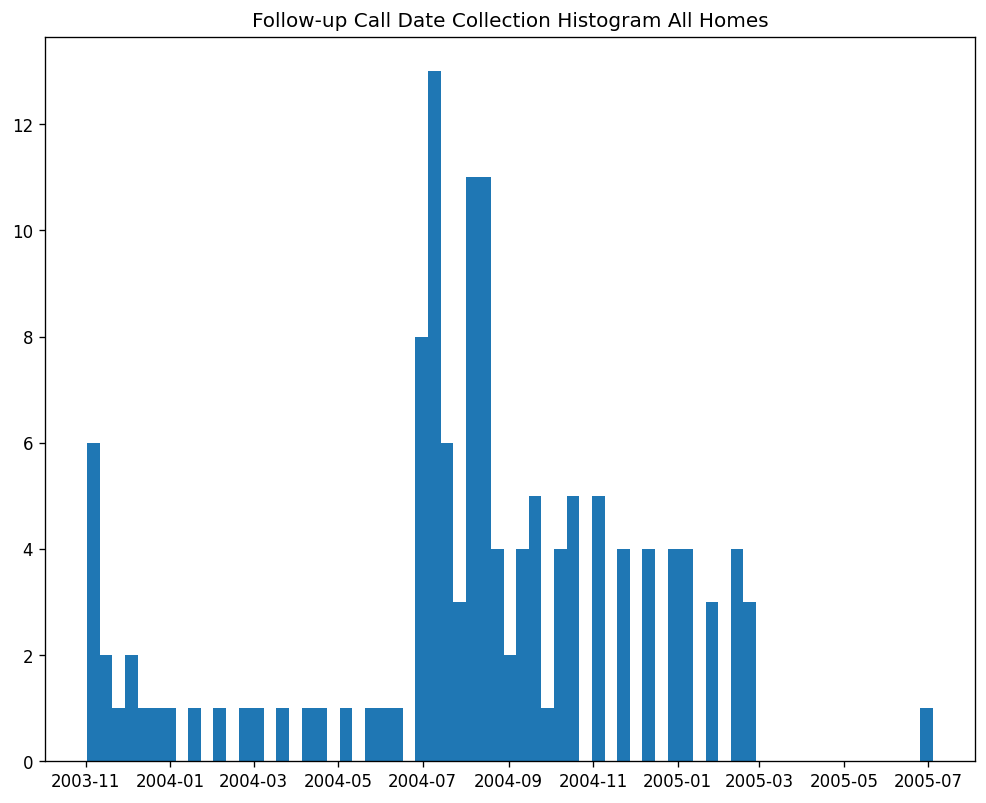

In [ ]:
fig, ax = plt.subplots(figsize=(10,8), dpi=120)
plt.hist(x=all_dates, bins = len(set(all_dates)))
txt = ax.set_title('Follow-up Call Date Collection Histogram All Homes')

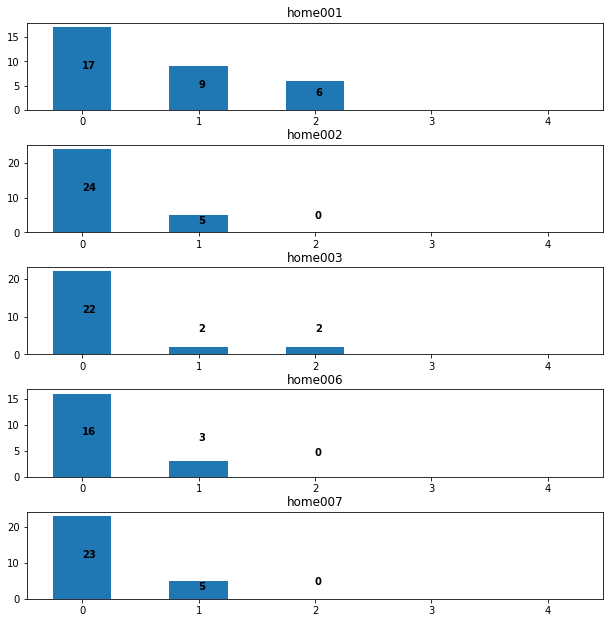

In [ ]:
import matplotlib.pyplot as plt
homes=sorted(homes)
dfs = [hc_utilization_dfs[home] for home in homes]

fig, ax = plt.subplots(len(dfs), figsize=(10,10))
bins = [-.25,.25, .75,1.25, 1.75,2.25, 2.75,3.25, 3.75,4.25]
binsx = [0,1,2,3,4]
for i, home in enumerate(homes):
  ls = dfs[i]['hc_utilization'].to_list()
  counts = [ ls.count(pz) for pz in range(3)]
  ax[i].hist( ls, bins=bins)
  ax[i].set_title(home)
  for ix, v in enumerate( counts):
    if v>=5 :
      ax[i].text(binsx[ix], v/2,  str(v), color='black', fontweight='bold')

    else:
      ax[i].text(binsx[ix], v+4,  str(v), color='black', fontweight='bold')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

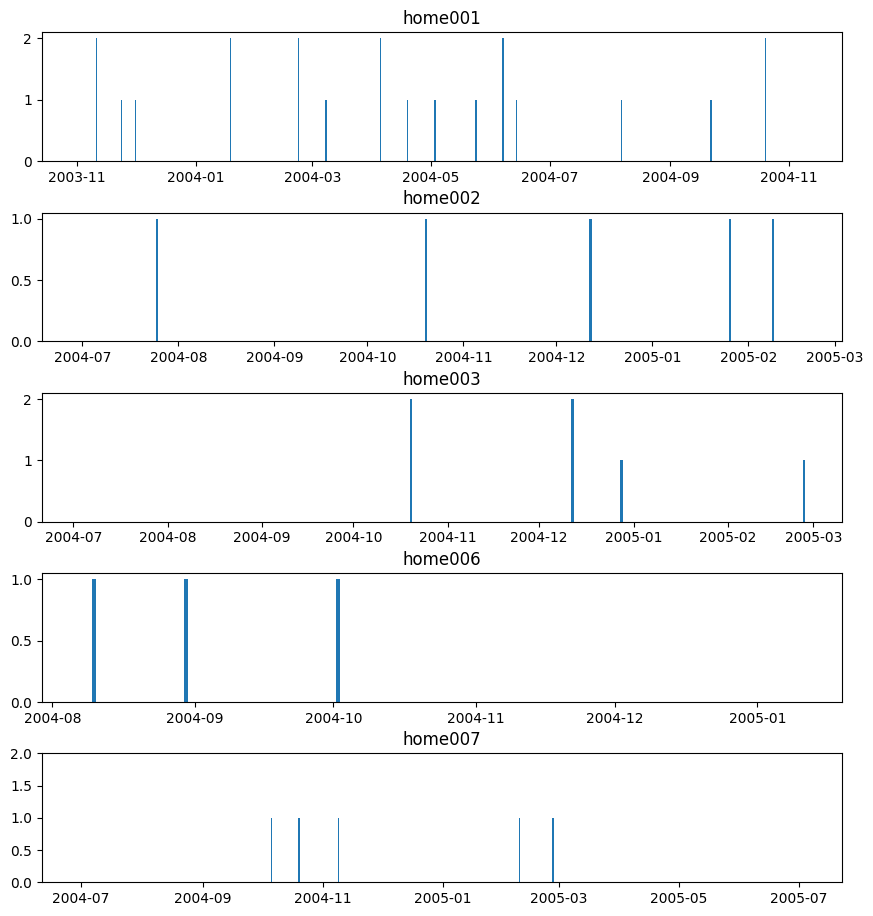

In [ ]:
homes = list(sorted(homes))
dfs = [hc_utilization_dfs[home] for home in homes] 
fig, ax = plt.subplots(5, figsize=(10,10), dpi=100)

for i, df in enumerate(dfs):
  ax[i].bar(df['date'],df['hc_utilization'])
  plt.ylim(0,2)
  ax[i].set_title(homes[i])

plt.subplots_adjust(left=0.1,
                    bottom=0.15, 
                    right=0.9, 
                    top=1, 
                    wspace=0.4, 
                    hspace=0.4)

## CROSS ANALYSIS

Dwelling into relationships across the data

### Sleep & Daily Logs

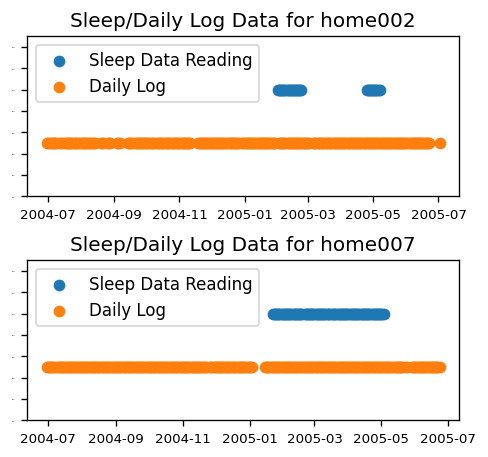

In [ ]:
fig, ax = plt.subplots(2, dpi=120, figsize= (4.5,4 ))

for i, home in enumerate(['home002', 'home007']):
  sleep_dates = sorted(set( sleep_df.loc[ sleep_df['home']== home]['date']  ))
  res_dates = sorted(set(feelActive_dl.loc[ feelActive_dl['home'] == home]['date'].to_list()))

  sdata = [ 1 for date in sleep_dates ]
  rdata = [ .95 for date in res_dates ]

  ax[i].scatter(sleep_dates, sdata, label='Sleep Data Reading')
  
  ax[i].scatter(res_dates, rdata, label='Daily Log')
  ax[i].set_title( str('Sleep/Daily Log Data for '+home) )
  ax[i].legend(loc='upper left')
  ax[i].xaxis.set_tick_params(labelsize=8)
  ax[i].yaxis.set_tick_params(labelsize=0)
  ax[i].axes.set_ylim(0.9,1.05)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

### Sleep & Follow-up Calls


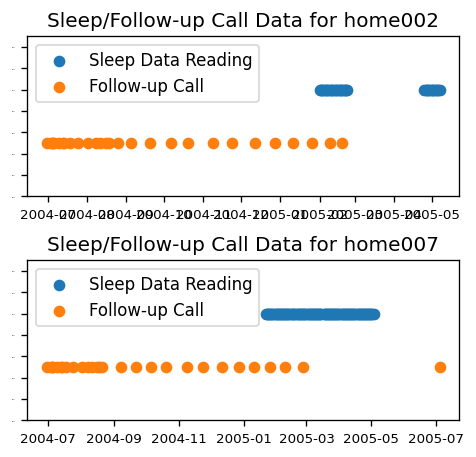

In [ ]:
desired_type = type(calls_df.loc[ calls_df['home'] == home]['date'].iloc[0])

fig, ax = plt.subplots(2, dpi=120, figsize= (4.5,4 ))

for i, home in enumerate(['home002', 'home007']):
  sleep_dates = sorted(set( sleep_df.loc[ sleep_df['home']== home]['date']  ))
  res_dates = sorted(set( [i.date() for i in calls_df.loc[ calls_df['home'] == home]['date'] if type(i) == desired_type] ))

  sdata = [ 1 for date in sleep_dates ]
  rdata = [ .95 for date in res_dates ]

  ax[i].scatter(sleep_dates, sdata, label='Sleep Data Reading')
  
  ax[i].scatter(res_dates, rdata, label='Follow-up Call')
  ax[i].set_title( str('Sleep/Follow-up Call Data for '+home) )
  ax[i].legend(loc='upper left')
  ax[i].xaxis.set_tick_params(labelsize=8)
  ax[i].yaxis.set_tick_params(labelsize=0)
  ax[i].axes.set_ylim(0.9,1.05)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

### Water & Daily Logs

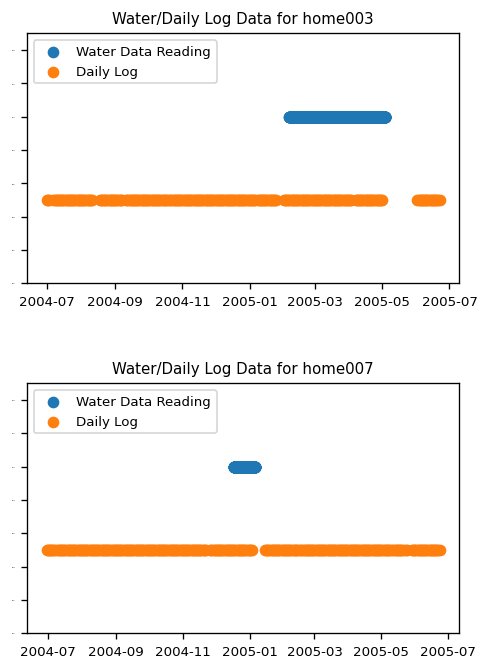

In [ ]:
desired_type = type(calls_df.loc[ calls_df['home'] == home]['date'].iloc[0])

fig, ax = plt.subplots(len(water_homes)-1, dpi=120, figsize= (4.5,4 ))

for i, home in enumerate(water_homes[1:]):
  sleep_dates = sorted(set( water_df.loc[ water_df['home']== home]['time']  ))
  res_dates = sorted(set( [i for i in daily_logs.loc[ daily_logs['home'] == home]['date']] ))

  sdata = [ 1 for date in sleep_dates ]
  rdata = [ .95 for date in res_dates ]

  ax[i].scatter(sleep_dates, sdata, label='Water Data Reading')
  
  ax[i].scatter(res_dates, rdata, label='Daily Log')
  ax[i].set_title( str('Water/Daily Log Data for '+home) ,size=9)
  ax[i].legend(loc='upper left', prop={'size':8})
  ax[i].xaxis.set_tick_params(labelsize=8)
  ax[i].yaxis.set_tick_params(labelsize=0)
  ax[i].axes.set_ylim(0.9,1.05)

plt.subplots_adjust(left=0.1,
                    bottom=0.05, 
                    right=0.9, 
                    top=1.3, 
                    wspace=0.4, 
                    hspace=0.4)

### Water & Follow-Up Calls

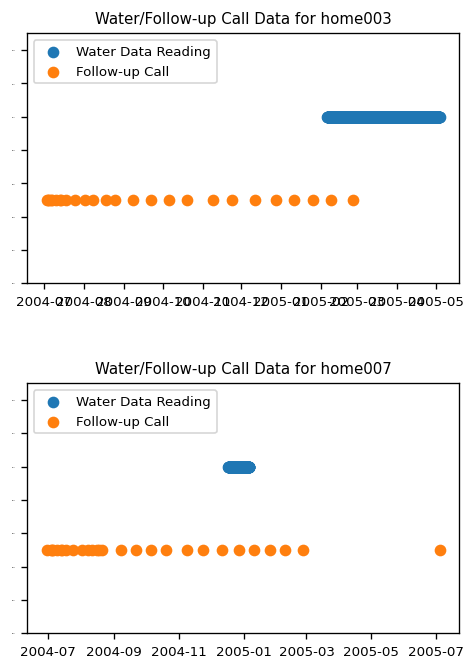

In [ ]:
desired_type = type(calls_df.loc[ calls_df['home'] == home]['date'].iloc[0])

fig, ax = plt.subplots(len(water_homes)-1, dpi=120, figsize= (4.5,4 ))

for i, home in enumerate(water_homes[1:]):
  sleep_dates = sorted(set( water_df.loc[ water_df['home']== home]['time']  ))
  res_dates = sorted(set( [i.date() for i in calls_df.loc[ calls_df['home'] == home]['date'] if type(i) == desired_type] ))

  sdata = [ 1 for date in sleep_dates ]
  rdata = [ .95 for date in res_dates ]

  ax[i].scatter(sleep_dates, sdata, label='Water Data Reading')
  
  ax[i].scatter(res_dates, rdata, label='Follow-up Call')
  ax[i].set_title( str('Water/Follow-up Call Data for '+home) ,size=9)
  ax[i].legend(loc='upper left', prop={'size':8})
  ax[i].xaxis.set_tick_params(labelsize=8)
  ax[i].yaxis.set_tick_params(labelsize=0)
  ax[i].axes.set_ylim(0.9,1.05)

plt.subplots_adjust(left=0.1,
                    bottom=0.05, 
                    right=0.9, 
                    top=1.3, 
                    wspace=0.4, 
                    hspace=0.4)

### Electricity & Daily Logs

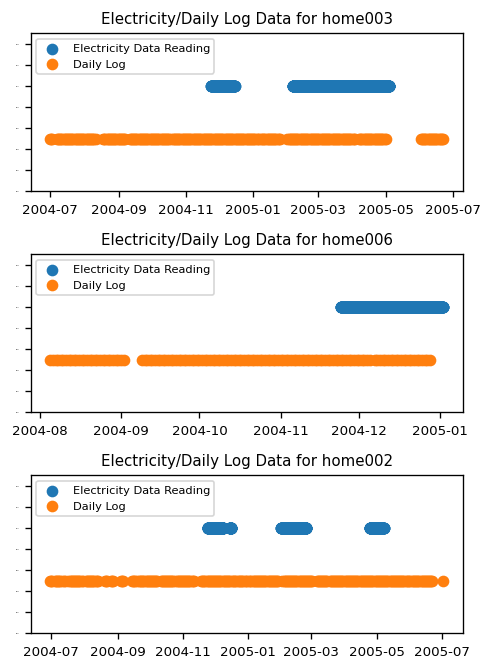

In [ ]:
desired_type = type(calls_df.loc[ calls_df['home'] == home]['date'].iloc[0])

fig, ax = plt.subplots(len(electric_homes), dpi=120, figsize= (4.5,4 ))

for i, home in enumerate(electric_homes):
  sleep_dates = sorted(set( electricity_df.loc[ electricity_df['home']== home]['time']  ))
  res_dates = sorted(set( [i for i in daily_logs.loc[ daily_logs['home'] == home]['date']] ))

  sdata = [ 1 for date in sleep_dates ]
  rdata = [ .95 for date in res_dates ]

  ax[i].scatter(sleep_dates, sdata, label='Electricity Data Reading')
  
  ax[i].scatter(res_dates, rdata, label='Daily Log')
  ax[i].set_title( str('Electricity/Daily Log Data for '+home) ,size=9)
  ax[i].legend(loc='upper left', prop={'size':6.8})
  ax[i].xaxis.set_tick_params(labelsize=8)
  ax[i].yaxis.set_tick_params(labelsize=0)
  ax[i].axes.set_ylim(0.9,1.05)

plt.subplots_adjust(left=0.1,
                    bottom=0.05, 
                    right=0.9, 
                    top=1.3, 
                    wspace=0.4, 
                    hspace=0.4)

### Electricity & Follow-Up Calls

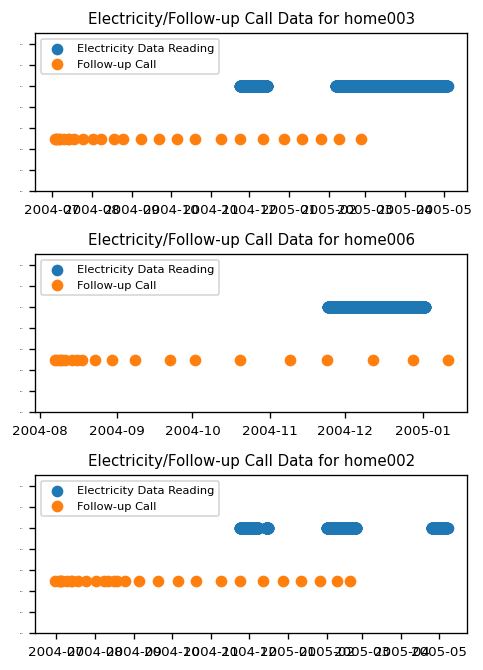

In [ ]:
desired_type = type(calls_df.loc[ calls_df['home'] == home]['date'].iloc[0])

fig, ax = plt.subplots(len(electric_homes), dpi=120, figsize= (4.5,4 ))

for i, home in enumerate(electric_homes):
  sleep_dates = sorted(set( electricity_df.loc[ electricity_df['home']== home]['time']  ))
  res_dates = sorted(set( [i.date() for i in calls_df.loc[ calls_df['home'] == home]['date'] if type(i) == desired_type] ))

  sdata = [ 1 for date in sleep_dates ]
  rdata = [ .95 for date in res_dates ]

  ax[i].scatter(sleep_dates, sdata, label='Electricity Data Reading')
  
  ax[i].scatter(res_dates, rdata, label='Follow-up Call')
  ax[i].set_title( str('Electricity/Follow-up Call Data for '+home) ,size=9)
  ax[i].legend(loc='upper left', prop={'size':6.8})
  ax[i].xaxis.set_tick_params(labelsize=8)
  ax[i].yaxis.set_tick_params(labelsize=0)
  ax[i].axes.set_ylim(0.9,1.05)

plt.subplots_adjust(left=0.1,
                    bottom=0.05, 
                    right=0.9, 
                    top=1.3, 
                    wspace=0.4, 
                    hspace=0.4)

In [ ]:
water_df.loc[water_df['home']=='home002']['volume'].sum()

0.0

# Model Building

## Creating Class Labels

In [ ]:
# Adjusting the label one day back since question asked for yesterday

for home, df in feelActive_dfs.items():
  labels = df['feel_change'].to_list()
  dates = df['date'].to_list()
  # we add the cutoff hours, i.e., the label will apply to the time series which ends at the time index
  dates = [i - datetime.timedelta(hours=10) for i in dates]
  df['date'] = dates

In [ ]:
# Adjusting the label one day back since question asked for yesterday

for home, df in respiratorySymptoms_dfs.items():
  dates = df['date'].to_list()
  
  dates_adjusted = [ i-datetime.timedelta(hours=10) for i in dates]

  # we add the cutoff hours, i.e., the label will apply to the time series which ends at the time index
  df['date'] = dates_adjusted

In [ ]:
# Iterate thorugh utiliztion dfs and adjusting the date the the -7 days at 3pm time cutoffs
for home, df in hc_utilization_dfs.items():
  df.sort_values('date',inplace=True)
  dates = df['date'].to_list()
  first_val = dates[0] - datetime.timedelta(days=6, hours = 10)
  dates_adjusted = [ first_val ]
  for i, date in enumerate(dates[1:]):
    date_diff = date - dates[i]
    if date_diff <= datetime.timedelta(days = 7):
      dates_adjusted.append( dates[i] + datetime.timedelta(hours=14) )
    else:
      dates_adjusted.append( date -  datetime.timedelta(days=6, hours = 10) )
  df['date'] = dates_adjusted


## Create Time Series

In [ ]:
# Setting the window sizes in a list

ts_lengths = [ datetime.timedelta(days=i+1) for i in range(7)]

### HC Utilization - 'util'

##### Sleep

###### Partitioning Sensors & TS Creation

In [ ]:
# This section will be commented once for 'HC Utilization' since it is the same for the 'resp' and 'feel' outcomes.

In [ ]:
# Segregating data
sleep_h2_clean = sleep_h2.drop(columns=['id','device','home','sensor','year','month','day','from_gmt_offset']).explode('time')
sleep_h7_clean = sleep_h7.drop(columns=['id','device','home','sensor','year','month','day','from_gmt_offset']).explode('time')
# Ensuring entries are clean
sh2 = weight_overlaps_sleep(sleep_h2_clean).drop(columns=['from','to'])
sh7 = weight_overlaps_sleep(sleep_h7_clean).drop(columns=['from','to'])
# Labelling data entries
sleep_vars = ['avg_hr', 'avg_rr', 'avg_act', 'sleep_score', 'duration',
       'duration_in_bed', 'duration_awake', 'duration_in_sleep',
       'duration_in_rem', 'duration_in_light', 'duration_in_deep',
       'duration_sleep_onset', 'bedexit_duration', 'bedexit_count',
       'tossnturn_count','min_hr', 'max_hr', 'min_rr',
       'max_rr', 'fm_count', 'awakenings', 'hrv_score', 'hrv_lf', 'hrv_hf',
       'hrv_rmssd_evening', 'hrv_rmssd_morning']

# Obtaining all dates
s_dates = set(sh2['date'].to_list())

# For all the relevant datapoints for a given date, the series of data points is saved and padded where needed
for date in s_dates:
  tmp_df = sh2.loc[sh2['date'] == date]
  tmp_df_times = tmp_df['time'].to_list()
  assert len(tmp_df_times) == len(set(tmp_df_times))
  for i in range(24):
    curr_time = pd.to_datetime( pd.Timestamp(date) + datetime.timedelta(hours=i) )
    curr_time = curr_time.to_pydatetime()
    # If no data is present for that time, a 0 is inserted since it means the sensor was not active
    if curr_time not in tmp_df_times:
      new_row = {col:[0] for col in sleep_vars }
      new_row['date'] = [date]
      new_row['time'] = [curr_time]
      sh2 = sh2.append( pd.DataFrame(data=new_row) )

s_dates = set(sh7['date'].to_list())

for date in s_dates:
  tmp_df = sh7.loc[sh7['date'] == date]
  tmp_df_times = tmp_df['time'].to_list()
  assert len(tmp_df_times) == len(set(tmp_df_times))
  for i in range(24):
    curr_time = pd.to_datetime( pd.Timestamp(date) + datetime.timedelta(hours=i) )
    curr_time = curr_time.to_pydatetime()
    if curr_time not in tmp_df_times:
      new_row = {col:[0] for col in sleep_vars }
      new_row['date'] = [date]
      new_row['time'] = [curr_time]
      sh7 = sh7.append( pd.DataFrame(data=new_row) )


sh2 = sh2.drop(columns=['date'])
sh7 = sh7.drop(columns=['date'])


sleep_vars = [i for i in sh7.columns if i != 'time']

# Below, normalized versions of the data are created
all_cols = sleep_vars.copy()
all_cols.append('time')
df = sh7[sleep_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= sleep_vars)
df['time'] = sh7['time'].to_list()
sh7_norm = df.copy()

df = sh2[sleep_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= sleep_vars)
df['time'] = sh2['time'].to_list()
sh2_norm = df.copy()

# This cell is repeated in the outcomes that follow, which allowed for runtime-independent execution. Now it is repetitive but left in case.

###### TS DFs

In [ ]:
# Normalised
# Storage of variable:timeseries_df 
sleep_ts_util = {}
# Iteration through the 26 measured sleep variables
for col in sleep_vars:
  df = pd.DataFrame()
  # iteration through each window size
  for i, time_series_length in enumerate(ts_lengths):
    # 1
    # obtain relevant data
    live_df = sh2_norm[['time',col]]
    # set the number of series data points
    n_hours = int(time_series_length.days)*24
    appendable = []
    labels = []  

    # iterate through all outcome labels
    for index, row in hc_utilization_dfs['home002'].iterrows():
      # set start and end indeces of the sensor data that is relevant
      time_end = row['date']
      time_start = time_end - time_series_length
      # obtain the class label
      classs = row['hc_utilization']

      # locate all entries which are within the time of interest and sort the points
      tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
      tmp_df.sort_values('time', inplace=True)
      
      # check that the class is valid and there is sufficient data available
      if  len(tmp_df) == n_hours and (classs!= 'NaN' or classs!='unknown'):
        appendable.append(tmp_df[col].squeeze())
        labels.append(classs)

    # 2
    # Repeat process above for 2nd home
    live_df = sh7_norm[['time',col]]
    for index, row in hc_utilization_dfs['home007'].iterrows():
      time_end = row['date']
      time_start = time_end - time_series_length
      classs = row['hc_utilization']

      tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
      tmp_df.sort_values('time', inplace=True)
      #print(len(tmp_df))
      if  len(tmp_df) == n_hours and (classs!= 'NaN' or classs!='unknown'):
        appendable.append(tmp_df[col].squeeze())
        labels.append(classs)

    # convert data to series for SKTime compliance
    appendable = pd.Series(appendable)
    labels = pd.Series(labels)
    # place data in column labelled appropiatedly
    if len(appendable)>0:
      if n_hours == 24*1:
          df[str(col+'_1day')] = appendable
          df[str(col+'day_label')] = labels
      elif n_hours == 24*2:
          df[str(col+'_2day')] = appendable
          df[str(col+'_2day_label')] = labels
      elif n_hours == 24*3:
          df[str(col+'_3day')] = appendable
          df[str(col+'_3day_label')] = labels
      elif n_hours == 24*4:
          df[str(col+'_4day')] = appendable
          df[str(col+'_4day_label')] = labels
      elif n_hours == 24*5:
          df[str(col+'_5day')] = appendable
          df[str(col+'_5day_label')] = labels
      elif n_hours == 24*6:
          df[str(col+'_6day')] = appendable
          df[str(col+'_6day_label')] = labels
      elif n_hours == 24*7:
          df[str(col+'_7day')] = appendable
          df[str(col+'_7day_label')] = labels
  sleep_ts_util[col] = df


a_file = open("/content/util/sleep_ts_util_norm.pkl", "wb")
pickle.dump(sleep_ts_util, a_file)
a_file.close()  

In [ ]:
# Non-normalised
# Storage of variable:timeseries_df 
sleep_ts_util = {}
# Iteration through the 26 measured sleep variables
for col in sleep_vars:
  df = pd.DataFrame()
  # iteration through each window size
  for i, time_series_length in enumerate(ts_lengths):
    # 1
    # obtain relevant data
    live_df = sh2[['time',col]]
    # set the number of series data points
    n_hours = int(time_series_length.days)*24
    appendable = []
    labels = []  

    # iterate through all outcome labels
    for index, row in hc_utilization_dfs['home002'].iterrows():
      # set start and end indeces of the sensor data that is relevant
      time_end = row['date']
      time_start = time_end - time_series_length
      # obtain the class label
      classs = row['hc_utilization']

      # locate all entries which are within the time of interest and sort the points
      tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
      tmp_df.sort_values('time', inplace=True)
      
      # check that the class is valid and there is sufficient data available
      if  len(tmp_df) == n_hours and (classs!= 'NaN' or classs!='unknown'):
        appendable.append(tmp_df[col].squeeze())
        labels.append(classs)

    # 2
    # Repeat process above for 2nd home
    live_df = sh7[['time',col]]
    for index, row in hc_utilization_dfs['home007'].iterrows():
      time_end = row['date']
      time_start = time_end - time_series_length
      classs = row['hc_utilization']

      tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
      tmp_df.sort_values('time', inplace=True)
      #print(len(tmp_df))
      if  len(tmp_df) == n_hours and (classs!= 'NaN' or classs!='unknown'):
        appendable.append(tmp_df[col].squeeze())
        labels.append(classs)

    # convert data to series for SKTime compliance
    appendable = pd.Series(appendable)
    labels = pd.Series(labels)
    # place data in column labelled appropiatedly
    if len(appendable)>0:
      if n_hours == 24*1:
          df[str(col+'_1day')] = appendable
          df[str(col+'day_label')] = labels
      elif n_hours == 24*2:
          df[str(col+'_2day')] = appendable
          df[str(col+'_2day_label')] = labels
      elif n_hours == 24*3:
          df[str(col+'_3day')] = appendable
          df[str(col+'_3day_label')] = labels
      elif n_hours == 24*4:
          df[str(col+'_4day')] = appendable
          df[str(col+'_4day_label')] = labels
      elif n_hours == 24*5:
          df[str(col+'_5day')] = appendable
          df[str(col+'_5day_label')] = labels
      elif n_hours == 24*6:
          df[str(col+'_6day')] = appendable
          df[str(col+'_6day_label')] = labels
      elif n_hours == 24*7:
          df[str(col+'_7day')] = appendable
          df[str(col+'_7day_label')] = labels
  sleep_ts_util[col] = df


a_file = open("/content/util/sleep_ts_util.pkl", "wb")
pickle.dump(sleep_ts_util, a_file)
a_file.close()

  

##### Water

In [ ]:
set(water_df['home'].to_list())

{'home002', 'home003', 'home007'}

In [ ]:
# Normalised
# Obtain appropiate data for each home
living_econsumption_h3 = water_df_clean.loc[ water_df_clean['home']== 'home003'].drop(columns=['home'])
living_econsumption_h6 = water_df_clean.loc[ water_df_clean['home']== 'home007'].drop(columns=['home'])
water_vars = [i for i in living_econsumption_h3.columns if i != 'time']

# Normalising the data by min-max scalar
df = living_econsumption_h3[water_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= water_vars)
df['time'] = living_econsumption_h3['time'].to_list()
living_econsumption_h3 = df.copy()

df = living_econsumption_h6[water_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= water_vars)
df['time'] = living_econsumption_h6['time'].to_list()
living_econsumption_h6 = df.copy()

water_ts_util = pd.DataFrame()
# iterate through window size
for i, time_series_length in enumerate(ts_lengths):
  # set copy of df for safety in manipulation
  live_df = living_econsumption_h3.copy()

  # set the number of data points based on window size
  n_hours = int(time_series_length.days)*24

  appendable = []
  labels = []  
  # iterate through outcome rows of respective home
  for index, row in hc_utilization_dfs['home003'].iterrows():
    # obtain start and end time indeces
    time_end = row['date']
    time_start = time_end - time_series_length

    # class label
    classs = row['hc_utilization']
    # temporary data storage
    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    # append data if sufficient data is found
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['volume'].squeeze())
      labels.append(classs)

  live_df = living_econsumption_h6
  for index, row in hc_utilization_dfs['home007'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['hc_utilization']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['volume'].squeeze())
      labels.append(classs)

  appendable = pd.Series(appendable)
  labels = pd.Series(labels)
  if n_hours == 24*1:
      water_ts_util['volume_1day'] = appendable
      water_ts_util['volume_1day_label'] = labels
  elif n_hours == 24*2:
      water_ts_util['volume_2day'] = appendable
      water_ts_util['volume_2day_label'] = labels
  elif n_hours == 24*3:
      water_ts_util['volume_3day'] = appendable
      water_ts_util['volume_3day_label'] = labels
  elif n_hours == 24*4:
      water_ts_util['volume_4day'] = appendable
      water_ts_util['volume_4day_label'] = labels
  elif n_hours == 24*5:
      water_ts_util['volume_5day'] = appendable
      water_ts_util['volume_5day_label'] = labels
  elif n_hours == 24*6:
      water_ts_util['volume_6day'] = appendable
      water_ts_util['volume_6day_label'] = labels
  elif n_hours == 24*7:
      water_ts_util['volume_7day'] = appendable
      water_ts_util['volume_7day_label'] = labels

a_file = open("/content/util/water_ts_util_norm.pkl", "wb")
pickle.dump(water_ts_util, a_file)
a_file.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [ ]:
# Non-normalised
# Obtain appropiate data for each home
living_econsumption_h3 = water_df_clean.loc[ water_df_clean['home']== 'home003'].drop(columns=['home'])
living_econsumption_h6 = water_df_clean.loc[ water_df_clean['home']== 'home007'].drop(columns=['home'])


water_ts_util = pd.DataFrame()
# iterate through window size
for i, time_series_length in enumerate(ts_lengths):
  # set copy of df for safety in manipulation
  live_df = living_econsumption_h3.copy()

  # set the number of data points based on window size
  n_hours = int(time_series_length.days)*24

  appendable = []
  labels = []  
  # iterate through outcome rows of respective home
  for index, row in hc_utilization_dfs['home003'].iterrows():
    # obtain start and end time indeces
    time_end = row['date']
    time_start = time_end - time_series_length

    # class label
    classs = row['hc_utilization']
    # temporary data storage
    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    # append data if sufficient data is found
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['volume'].squeeze())
      labels.append(classs)

  live_df = living_econsumption_h6
  for index, row in hc_utilization_dfs['home007'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['hc_utilization']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['volume'].squeeze())
      labels.append(classs)

  appendable = pd.Series(appendable)
  labels = pd.Series(labels)
  if n_hours == 24*1:
      water_ts_util['volume_1day'] = appendable
      water_ts_util['volume_1day_label'] = labels
  elif n_hours == 24*2:
      water_ts_util['volume_2day'] = appendable
      water_ts_util['volume_2day_label'] = labels
  elif n_hours == 24*3:
      water_ts_util['volume_3day'] = appendable
      water_ts_util['volume_3day_label'] = labels
  elif n_hours == 24*4:
      water_ts_util['volume_4day'] = appendable
      water_ts_util['volume_4day_label'] = labels
  elif n_hours == 24*5:
      water_ts_util['volume_5day'] = appendable
      water_ts_util['volume_5day_label'] = labels
  elif n_hours == 24*6:
      water_ts_util['volume_6day'] = appendable
      water_ts_util['volume_6day_label'] = labels
  elif n_hours == 24*7:
      water_ts_util['volume_7day'] = appendable
      water_ts_util['volume_7day_label'] = labels

a_file = open("/content/util/water_ts_util.pkl", "wb")
pickle.dump(water_ts_util, a_file)
a_file.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


##### Electricity

###### Living Consumption

In [ ]:
# Normalised
home = 'home002'

# obtaining relevant data
living_econsumption_h2 = living_econsumption_dfs[home][0]
living_econsumption_h3 = living_econsumption_dfs['home003'][0]
living_econsumption_h6 = living_econsumption_dfs['home006'][0]


# saving for column-wise normalization
elec_vars = [i for i in living_econsumption_h2.columns if i != 'time']

# min-max scalar normalization between [0-1]
df = living_econsumption_h2[elec_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= elec_vars)
df['time'] = living_econsumption_h2['time'].to_list()
living_econsumption_h2 = df.copy()

df = living_econsumption_h3[elec_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= elec_vars)
df['time'] = living_econsumption_h3['time'].to_list()
living_econsumption_h3 = df.copy()

df = living_econsumption_h6[elec_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= elec_vars)
df['time'] = living_econsumption_h6['time'].to_list()
living_econsumption_h6 = df.copy()


electricity_living_ts_util = pd.DataFrame()
for i, time_series_length in enumerate(ts_lengths):
  # for home 2
  live_df = living_econsumption_h2
  n_hours = int(time_series_length.days)*24
  appendable = []
  labels = []  
  for index, row in hc_utilization_dfs['home002'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['hc_utilization']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    #print(len(tmp_df))
    if  len(tmp_df) == n_hours and classs in ['improvement','decline','constant']:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  # for home 3
  live_df = living_econsumption_h3
  for index, row in hc_utilization_dfs['home003'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['hc_utilization']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    #print(len(tmp_df))
    if  len(tmp_df) == n_hours and classs in ['improvement','decline','constant']:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)
 
  # for home 6
  live_df = living_econsumption_h6
  for index, row in hc_utilization_dfs['home006'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['hc_utilization']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    #print(len(tmp_df))
    if  len(tmp_df) == n_hours and classs in ['improvement','decline','constant']:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  appendable = pd.Series(appendable)
  labels = pd.Series(labels)
  # append series with respective label
  if n_hours == 24*1:
      electricity_living_ts_util['living_consumption_1day'] = appendable
      electricity_living_ts_util['living_consumption_1day_label'] = labels
  elif n_hours == 24*2:
      electricity_living_ts_util['living_consumption_2day'] = appendable
      electricity_living_ts_util['living_consumption_2day_label'] = labels
  elif n_hours == 24*3:
      electricity_living_ts_util['living_consumption_3day'] = appendable
      electricity_living_ts_util['living_consumption_3day_label'] = labels
  elif n_hours == 24*4:
      electricity_living_ts_util['living_consumption_4day'] = appendable
      electricity_living_ts_util['living_consumption_4day_label'] = labels
  elif n_hours == 24*5:
      electricity_living_ts_util['living_consumption_5day'] = appendable
      electricity_living_ts_util['living_consumption_5day_label'] = labels
  elif n_hours == 24*6:
      electricity_living_ts_util['living_consumption_6day'] = appendable
      electricity_living_ts_util['living_consumption_6day_label'] = labels
  elif n_hours == 24*7:
      electricity_living_ts_util['living_consumption_7day'] = appendable
      electricity_living_ts_util['living_consumption_7day_label'] = labels

a_file = open("/content/util/electricity_living_ts_util_norm.pkl", "wb")
pickle.dump(electricity_living_ts_util, a_file)
a_file.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [ ]:
# Non-normalised
home = 'home002'

# obtaining relevant data
living_econsumption_h2 = living_econsumption_dfs[home][0]
living_econsumption_h3 = living_econsumption_dfs['home003'][0]
living_econsumption_h6 = living_econsumption_dfs['home006'][0]



electricity_living_ts_util = pd.DataFrame()
for i, time_series_length in enumerate(ts_lengths):
  # for home 2
  live_df = living_econsumption_h2
  n_hours = int(time_series_length.days)*24
  appendable = []
  labels = []  
  for index, row in hc_utilization_dfs['home002'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['hc_utilization']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    #print(len(tmp_df))
    if  len(tmp_df) == n_hours and classs in ['improvement','decline','constant']:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  # for home 3
  live_df = living_econsumption_h3
  for index, row in hc_utilization_dfs['home003'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['hc_utilization']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    #print(len(tmp_df))
    if  len(tmp_df) == n_hours and classs in ['improvement','decline','constant']:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)
 
  # for home 6
  live_df = living_econsumption_h6
  for index, row in hc_utilization_dfs['home006'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['hc_utilization']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    #print(len(tmp_df))
    if  len(tmp_df) == n_hours and classs in ['improvement','decline','constant']:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  appendable = pd.Series(appendable)
  labels = pd.Series(labels)
  # append series with respective label 
  if n_hours == 24*1:
      electricity_living_ts_util['living_consumption_1day'] = appendable
      electricity_living_ts_util['living_consumption_1day_label'] = labels
  elif n_hours == 24*2:
      electricity_living_ts_util['living_consumption_2day'] = appendable
      electricity_living_ts_util['living_consumption_2day_label'] = labels
  elif n_hours == 24*3:
      electricity_living_ts_util['living_consumption_3day'] = appendable
      electricity_living_ts_util['living_consumption_3day_label'] = labels
  elif n_hours == 24*4:
      electricity_living_ts_util['living_consumption_4day'] = appendable
      electricity_living_ts_util['living_consumption_4day_label'] = labels
  elif n_hours == 24*5:
      electricity_living_ts_util['living_consumption_5day'] = appendable
      electricity_living_ts_util['living_consumption_5day_label'] = labels
  elif n_hours == 24*6:
      electricity_living_ts_util['living_consumption_6day'] = appendable
      electricity_living_ts_util['living_consumption_6day_label'] = labels
  elif n_hours == 24*7:
      electricity_living_ts_util['living_consumption_7day'] = appendable
      electricity_living_ts_util['living_consumption_7day_label'] = labels

a_file = open("/content/util/electricity_living_ts_util.pkl", "wb")
pickle.dump(electricity_living_ts_util, a_file)
a_file.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


###### Nutrition Consumption

In [ ]:
# Normalised

nutrition_econsumption_h3 = eatdrink_econsumption_dfs['home003'][0]
nutrition_econsumption_h6 = eatdrink_econsumption_dfs['home006'][0]

elec_vars = [i for i in living_econsumption_h2.columns if i != 'time']

df = nutrition_econsumption_h3[elec_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= elec_vars)
df['time'] = nutrition_econsumption_h3['time'].to_list()
nutrition_econsumption_h3 = df.copy()

df = nutrition_econsumption_h6[elec_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= elec_vars)
df['time'] = nutrition_econsumption_h6['time'].to_list()
nutrition_econsumption_h6 = df.copy()#'''


electricity_nutrition_ts_util = pd.DataFrame()
for i, time_series_length in enumerate(ts_lengths):
  live_df = nutrition_econsumption_h3
  n_hours = int(time_series_length.days)*24
  appendable = []
  labels = []  
  for index, row in hc_utilization_dfs['home003'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['hc_utilization']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True) 

    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)
  live_df = nutrition_econsumption_h6
  for index, row in hc_utilization_dfs['home006'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['hc_utilization']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    #print(len(tmp_df))
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  appendable = pd.Series(appendable)
  labels = pd.Series(labels)
  if n_hours == 24*1:
      electricity_nutrition_ts_util['nutrition_consumption_1day'] = appendable
      electricity_nutrition_ts_util['nutrition_consumption_1day_label'] = labels
  elif n_hours == 24*2:
      electricity_nutrition_ts_util['nutrition_consumption_2day'] = appendable
      electricity_nutrition_ts_util['nutrition_consumption_2day_label'] = labels
  elif n_hours == 24*3:
      electricity_nutrition_ts_util['nutrition_consumption_3day'] = appendable
      electricity_nutrition_ts_util['nutrition_consumption_3day_label'] = labels
  elif n_hours == 24*4:
      electricity_nutrition_ts_util['nutrition_consumption_4day'] = appendable
      electricity_nutrition_ts_util['nutrition_consumption_4day_label'] = labels
  elif n_hours == 24*5:
      electricity_nutrition_ts_util['nutrition_consumption_5day'] = appendable
      electricity_nutrition_ts_util['nutrition_consumption_5day_label'] = labels
  elif n_hours == 24*6:
      electricity_nutrition_ts_util['nutrition_consumption_6day'] = appendable
      electricity_nutrition_ts_util['nutrition_consumption_6day_label'] = labels
  elif n_hours == 24*7:
      electricity_nutrition_ts_util['nutrition_consumption_7day'] = appendable
      electricity_nutrition_ts_util['nutrition_consumption_7day_label'] = labels

a_file = open("/content/util/electricity_nutrition_ts_util_norm.pkl", "wb")
pickle.dump(electricity_nutrition_ts_util, a_file)
a_file.close()

In [ ]:
# Normalised

nutrition_econsumption_h3 = eatdrink_econsumption_dfs['home003'][0]
nutrition_econsumption_h6 = eatdrink_econsumption_dfs['home006'][0]


electricity_nutrition_ts_util = pd.DataFrame()
for i, time_series_length in enumerate(ts_lengths):
  live_df = nutrition_econsumption_h3
  n_hours = int(time_series_length.days)*24
  appendable = []
  labels = []  
  for index, row in hc_utilization_dfs['home003'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['hc_utilization']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True) 

    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)
  live_df = nutrition_econsumption_h6
  for index, row in hc_utilization_dfs['home006'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['hc_utilization']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  appendable = pd.Series(appendable)
  labels = pd.Series(labels)
  if n_hours == 24*1:
      electricity_nutrition_ts_util['nutrition_consumption_1day'] = appendable
      electricity_nutrition_ts_util['nutrition_consumption_1day_label'] = labels
  elif n_hours == 24*2:
      electricity_nutrition_ts_util['nutrition_consumption_2day'] = appendable
      electricity_nutrition_ts_util['nutrition_consumption_2day_label'] = labels
  elif n_hours == 24*3:
      electricity_nutrition_ts_util['nutrition_consumption_3day'] = appendable
      electricity_nutrition_ts_util['nutrition_consumption_3day_label'] = labels
  elif n_hours == 24*4:
      electricity_nutrition_ts_util['nutrition_consumption_4day'] = appendable
      electricity_nutrition_ts_util['nutrition_consumption_4day_label'] = labels
  elif n_hours == 24*5:
      electricity_nutrition_ts_util['nutrition_consumption_5day'] = appendable
      electricity_nutrition_ts_util['nutrition_consumption_5day_label'] = labels
  elif n_hours == 24*6:
      electricity_nutrition_ts_util['nutrition_consumption_6day'] = appendable
      electricity_nutrition_ts_util['nutrition_consumption_6day_label'] = labels
  elif n_hours == 24*7:
      electricity_nutrition_ts_util['nutrition_consumption_7day'] = appendable
      electricity_nutrition_ts_util['nutrition_consumption_7day_label'] = labels

a_file = open("/content/util/electricity_nutrition_ts_util.pkl", "wb")
pickle.dump(electricity_nutrition_ts_util, a_file)
a_file.close()

###### Hourly Total Consumption

In [ ]:
# Normalised
home = 'home002'


living_econsumption_h2 = aggregate_consumption_dfs[home][0]
living_econsumption_h3 = aggregate_consumption_dfs['home003'][0]
living_econsumption_h6 = aggregate_consumption_dfs['home006'][0]
elec_vars = [i for i in living_econsumption_h2.columns if i != 'time']

df = living_econsumption_h2[elec_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= elec_vars)
df['time'] = living_econsumption_h2['time'].to_list()
living_econsumption_h2 = df.copy()

df = living_econsumption_h3[elec_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= elec_vars)
df['time'] = living_econsumption_h3['time'].to_list()
living_econsumption_h3 = df.copy()

df = living_econsumption_h6[elec_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= elec_vars)
df['time'] = living_econsumption_h6['time'].to_list()
living_econsumption_h6 = df.copy()


electricity_total_ts_util = pd.DataFrame()
for i, time_series_length in enumerate(ts_lengths):
  live_df = living_econsumption_h2
  n_hours = int(time_series_length.days)*24
  appendable = []
  labels = []  
  for index, row in hc_utilization_dfs['home002'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['hc_utilization']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    #print(len(tmp_df))
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)
  live_df = living_econsumption_h3
  for index, row in hc_utilization_dfs['home003'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['hc_utilization']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    #print(len(tmp_df))
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)
  live_df = living_econsumption_h6
  for index, row in hc_utilization_dfs['home006'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['hc_utilization']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    #print(len(tmp_df))
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  appendable = pd.Series(appendable)
  labels = pd.Series(labels)
  if n_hours == 24*1:
      electricity_total_ts_util['living_consumption_1day'] = appendable
      electricity_total_ts_util['living_consumption_1day_label'] = labels
  elif n_hours == 24*2:
      electricity_total_ts_util['living_consumption_2day'] = appendable
      electricity_total_ts_util['living_consumption_2day_label'] = labels
  elif n_hours == 24*3:
      electricity_total_ts_util['living_consumption_3day'] = appendable
      electricity_total_ts_util['living_consumption_3day_label'] = labels
  elif n_hours == 24*4:
      electricity_total_ts_util['living_consumption_4day'] = appendable
      electricity_total_ts_util['living_consumption_4day_label'] = labels
  elif n_hours == 24*5:
      electricity_total_ts_util['living_consumption_5day'] = appendable
      electricity_total_ts_util['living_consumption_5day_label'] = labels
  elif n_hours == 24*6:
      electricity_total_ts_util['living_consumption_6day'] = appendable
      electricity_total_ts_util['living_consumption_6day_label'] = labels
  elif n_hours == 24*7:
      electricity_total_ts_util['living_consumption_7day'] = appendable
      electricity_total_ts_util['living_consumption_7day_label'] = labels
a_file = open("/content/util/electricity_total_ts_util_norm.pkl", "wb")
pickle.dump(electricity_total_ts_util, a_file)
a_file.close()

In [ ]:
# Non-normalised
home = 'home002'


living_econsumption_h2 = aggregate_consumption_dfs[home][0]
living_econsumption_h3 = aggregate_consumption_dfs['home003'][0]
living_econsumption_h6 = aggregate_consumption_dfs['home006'][0]
elec_vars = [i for i in living_econsumption_h2.columns if i != 'time']


electricity_total_ts_util = pd.DataFrame()
for i, time_series_length in enumerate(ts_lengths):
  live_df = living_econsumption_h2
  n_hours = int(time_series_length.days)*24
  appendable = []
  labels = []  
  for index, row in hc_utilization_dfs['home002'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['hc_utilization']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    #print(len(tmp_df))
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)
  live_df = living_econsumption_h3
  for index, row in hc_utilization_dfs['home003'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['hc_utilization']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    #print(len(tmp_df))
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)
  live_df = living_econsumption_h6
  for index, row in hc_utilization_dfs['home006'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['hc_utilization']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    #print(len(tmp_df))
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  appendable = pd.Series(appendable)
  labels = pd.Series(labels)
  if n_hours == 24*1:
      electricity_total_ts_util['living_consumption_1day'] = appendable
      electricity_total_ts_util['living_consumption_1day_label'] = labels
  elif n_hours == 24*2:
      electricity_total_ts_util['living_consumption_2day'] = appendable
      electricity_total_ts_util['living_consumption_2day_label'] = labels
  elif n_hours == 24*3:
      electricity_total_ts_util['living_consumption_3day'] = appendable
      electricity_total_ts_util['living_consumption_3day_label'] = labels
  elif n_hours == 24*4:
      electricity_total_ts_util['living_consumption_4day'] = appendable
      electricity_total_ts_util['living_consumption_4day_label'] = labels
  elif n_hours == 24*5:
      electricity_total_ts_util['living_consumption_5day'] = appendable
      electricity_total_ts_util['living_consumption_5day_label'] = labels
  elif n_hours == 24*6:
      electricity_total_ts_util['living_consumption_6day'] = appendable
      electricity_total_ts_util['living_consumption_6day_label'] = labels
  elif n_hours == 24*7:
      electricity_total_ts_util['living_consumption_7day'] = appendable
      electricity_total_ts_util['living_consumption_7day_label'] = labels
a_file = open("/content/util/electricity_total_ts_util.pkl", "wb")
pickle.dump(electricity_total_ts_util, a_file)
a_file.close()

### Respiratory Symptoms - 'resp'

#### Hourly

##### Sleep

###### Partitioning Sensors & TS Creation

In [ ]:
sleep_h2_clean = sleep_h2.drop(columns=['id','device','home','sensor','year','month','day','from_gmt_offset']).explode('time')
sleep_h7_clean = sleep_h7.drop(columns=['id','device','home','sensor','year','month','day','from_gmt_offset']).explode('time')
sh2 = weight_overlaps_sleep(sleep_h2_clean).drop(columns=['from','to'])
sh7 = weight_overlaps_sleep(sleep_h7_clean).drop(columns=['from','to'])

sleep_vars = ['avg_hr', 'avg_rr', 'avg_act', 'sleep_score', 'duration',
       'duration_in_bed', 'duration_awake', 'duration_in_sleep',
       'duration_in_rem', 'duration_in_light', 'duration_in_deep',
       'duration_sleep_onset', 'bedexit_duration', 'bedexit_count',
       'tossnturn_count','min_hr', 'max_hr', 'min_rr',
       'max_rr', 'fm_count', 'awakenings', 'hrv_score', 'hrv_lf', 'hrv_hf',
       'hrv_rmssd_evening', 'hrv_rmssd_morning']


s_dates = set(sh2['date'].to_list())

for date in s_dates:
  tmp_df = sh2.loc[sh2['date'] == date]
  tmp_df_times = tmp_df['time'].to_list()
  assert len(tmp_df_times) == len(set(tmp_df_times))
  for i in range(24):
    curr_time = pd.to_datetime( pd.Timestamp(date) + datetime.timedelta(hours=i) )
    curr_time = curr_time.to_pydatetime()
    if curr_time not in tmp_df_times:
      new_row = {col:[0] for col in sleep_vars }
      new_row['date'] = [date]
      new_row['time'] = [curr_time]
      sh2 = sh2.append( pd.DataFrame(data=new_row) )

s_dates = set(sh7['date'].to_list())

for date in s_dates:
  tmp_df = sh7.loc[sh7['date'] == date]
  tmp_df_times = tmp_df['time'].to_list()
  assert len(tmp_df_times) == len(set(tmp_df_times))
  for i in range(24):
    curr_time = pd.to_datetime( pd.Timestamp(date) + datetime.timedelta(hours=i) )
    curr_time = curr_time.to_pydatetime()
    if curr_time not in tmp_df_times:
      new_row = {col:[0] for col in sleep_vars }
      new_row['date'] = [date]
      new_row['time'] = [curr_time]
      sh7 = sh7.append( pd.DataFrame(data=new_row) )
      
sh2 = sh2.drop(columns=['date'])
sh7 = sh7.drop(columns=['date'])


sleep_vars = [i for i in sh7.columns if i != 'time']

all_cols = sleep_vars.copy()
all_cols.append('time')
df = sh7[sleep_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= sleep_vars)
df['time'] = sh7['time'].to_list()
sh7_norm = df.copy()

df = sh2[sleep_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= sleep_vars)
df['time'] = sh2['time'].to_list()
sh2_norm = df.copy()


###### TS DFs

In [ ]:
# Normalised
sleep_ts_resp = {}
for col in sleep_vars:
  df = pd.DataFrame()
  for i, time_series_length in enumerate(ts_lengths):
    
    live_df = sh2_norm[['time',col]]
    n_hours = int(time_series_length.days)*24
    appendable = []
    labels = []  
    for index, row in respiratorySymptoms_dfs['home002'].iterrows():
      time_end = row['date']
      time_start = time_end - time_series_length
      classs = row['symptom_change']

      tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
      tmp_df.sort_values('time', inplace=True)
      #print(len(tmp_df))
      if  len(tmp_df) == n_hours:
        appendable.append(tmp_df[col].squeeze())
        labels.append(classs)

    live_df = sh7_norm[['time',col]]
    for index, row in respiratorySymptoms_dfs['home007'].iterrows():
      time_end = row['date']
      time_start = time_end - time_series_length
      classs = row['symptom_change']

      tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
      tmp_df.sort_values('time', inplace=True)
      #print(len(tmp_df))
      if  len(tmp_df) == n_hours:
        appendable.append(tmp_df[col].squeeze())
        labels.append(classs)

    appendable = pd.Series(appendable)
    labels = pd.Series(labels)
    if len(appendable)>0:
      if n_hours == 24*1:
          df[str(col+'_1day')] = appendable
          df[str(col+'day_label')] = labels
      elif n_hours == 24*2:
          df[str(col+'_2day')] = appendable
          df[str(col+'_2day_label')] = labels
      elif n_hours == 24*3:
          df[str(col+'_3day')] = appendable
          df[str(col+'_3day_label')] = labels
      elif n_hours == 24*4:
          df[str(col+'_4day')] = appendable
          df[str(col+'_4day_label')] = labels
      elif n_hours == 24*5:
          df[str(col+'_5day')] = appendable
          df[str(col+'_5day_label')] = labels
      elif n_hours == 24*6:
          df[str(col+'_6day')] = appendable
          df[str(col+'_6day_label')] = labels
      elif n_hours == 24*7:
          df[str(col+'_7day')] = appendable
          df[str(col+'_7day_label')] = labels
  sleep_ts_resp[col] = df

a_file = open("/content/resp/sleep_ts_resp.pkl", "wb")
pickle.dump(sleep_ts_resp, a_file)
a_file.close()

In [ ]:
# Non-normalised
sleep_ts_resp = {}
for col in sleep_vars:
  df = pd.DataFrame()
  for i, time_series_length in enumerate(ts_lengths):
    
    live_df = sh2[['time',col]]
    n_hours = int(time_series_length.days)*24
    appendable = []
    labels = []  
    for index, row in respiratorySymptoms_dfs['home002'].iterrows():
      time_end = row['date']
      time_start = time_end - time_series_length
      classs = row['symptom_change']

      tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
      tmp_df.sort_values('time', inplace=True)
      
      if  len(tmp_df) == n_hours:
        appendable.append(tmp_df[col].squeeze())
        labels.append(classs)

    live_df = sh7[['time',col]]
    for index, row in respiratorySymptoms_dfs['home007'].iterrows():
      time_end = row['date']
      time_start = time_end - time_series_length
      classs = row['symptom_change']

      tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
      tmp_df.sort_values('time', inplace=True)
      
      if  len(tmp_df) == n_hours:
        appendable.append(tmp_df[col].squeeze())
        labels.append(classs)

    appendable = pd.Series(appendable)
    labels = pd.Series(labels)
    if len(appendable)>0:
      if n_hours == 24*1:
          df[str(col+'_1day')] = appendable
          df[str(col+'day_label')] = labels
      elif n_hours == 24*2:
          df[str(col+'_2day')] = appendable
          df[str(col+'_2day_label')] = labels
      elif n_hours == 24*3:
          df[str(col+'_3day')] = appendable
          df[str(col+'_3day_label')] = labels
      elif n_hours == 24*4:
          df[str(col+'_4day')] = appendable
          df[str(col+'_4day_label')] = labels
      elif n_hours == 24*5:
          df[str(col+'_5day')] = appendable
          df[str(col+'_5day_label')] = labels
      elif n_hours == 24*6:
          df[str(col+'_6day')] = appendable
          df[str(col+'_6day_label')] = labels
      elif n_hours == 24*7:
          df[str(col+'_7day')] = appendable
          df[str(col+'_7day_label')] = labels
  sleep_ts_resp[col] = df

a_file = open("/content/resp/sleep_ts_resp.pkl", "wb")
pickle.dump(sleep_ts_resp, a_file)
a_file.close()

In [ ]:


dic = sleep_ts_resp # Place dic here
name = 'sleep_ts_resp'
file_dic = {}
for col, df in dic.items():
  file_dic[col] = df.to_json()
a_file = open("/content/resp/{}.json".format( name ), "w")
json.dump(file_dic, a_file)
a_file.close()


##### Water

In [ ]:
# Normalised
living_econsumption_h3 = water_df_clean.loc[ water_df_clean['home']== 'home003'].drop(columns=['home'])
living_econsumption_h6 = water_df_clean.loc[ water_df_clean['home']== 'home007'].drop(columns=['home'])

df = living_econsumption_h3[water_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= water_vars)
df['time'] = living_econsumption_h3['time'].to_list()
living_econsumption_h3 = df.copy()

df = living_econsumption_h6[water_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= water_vars)
df['time'] = living_econsumption_h6['time'].to_list()
living_econsumption_h6 = df.copy()


water_ts_resp = pd.DataFrame()
for i, time_series_length in enumerate(ts_lengths):
  live_df = living_econsumption_h3
  n_hours = int(time_series_length.days)*24
  appendable = []
  labels = []  
  for index, row in respiratorySymptoms_dfs['home003'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['symptom_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    #print(len(tmp_df))
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['volume'].squeeze())
      labels.append(classs)
  live_df = living_econsumption_h6
  for index, row in respiratorySymptoms_dfs['home007'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['symptom_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    #print(len(tmp_df))
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['volume'].squeeze())
      labels.append(classs)

  appendable = pd.Series(appendable)
  labels = pd.Series(labels)
  if n_hours == 24*1:
      water_ts_resp['volume_1day'] = appendable
      water_ts_resp['volume_1day_label'] = labels
  elif n_hours == 24*2:
      water_ts_resp['volume_2day'] = appendable
      water_ts_resp['volume_2day_label'] = labels
  elif n_hours == 24*3:
      water_ts_resp['volume_3day'] = appendable
      water_ts_resp['volume_3day_label'] = labels
  elif n_hours == 24*4:
      water_ts_resp['volume_4day'] = appendable
      water_ts_resp['volume_4day_label'] = labels
  elif n_hours == 24*5:
      water_ts_resp['volume_5day'] = appendable
      water_ts_resp['volume_5day_label'] = labels
  elif n_hours == 24*6:
      water_ts_resp['volume_6day'] = appendable
      water_ts_resp['volume_6day_label'] = labels
  elif n_hours == 24*7:
      water_ts_resp['volume_7day'] = appendable
      water_ts_resp['volume_7day_label'] = labels

a_file = open("/content/resp/water_ts_resp_norm.pkl", "wb")
pickle.dump(water_ts_resp, a_file)
a_file.close() 

In [ ]:
# Non-normalised
living_econsumption_h3 = water_df_clean.loc[ water_df_clean['home']== 'home003'].drop(columns=['home'])
living_econsumption_h6 = water_df_clean.loc[ water_df_clean['home']== 'home007'].drop(columns=['home'])

water_ts_resp = pd.DataFrame()
for i, time_series_length in enumerate(ts_lengths):
  live_df = living_econsumption_h3
  n_hours = int(time_series_length.days)*24
  appendable = []
  labels = []  
  for index, row in respiratorySymptoms_dfs['home003'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['symptom_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    #print(len(tmp_df))
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['volume'].squeeze())
      labels.append(classs)
  live_df = living_econsumption_h6
  for index, row in respiratorySymptoms_dfs['home007'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['symptom_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    #print(len(tmp_df))
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['volume'].squeeze())
      labels.append(classs)

  appendable = pd.Series(appendable)
  labels = pd.Series(labels)
  if n_hours == 24*1:
      water_ts_resp['volume_1day'] = appendable
      water_ts_resp['volume_1day_label'] = labels
  elif n_hours == 24*2:
      water_ts_resp['volume_2day'] = appendable
      water_ts_resp['volume_2day_label'] = labels
  elif n_hours == 24*3:
      water_ts_resp['volume_3day'] = appendable
      water_ts_resp['volume_3day_label'] = labels
  elif n_hours == 24*4:
      water_ts_resp['volume_4day'] = appendable
      water_ts_resp['volume_4day_label'] = labels
  elif n_hours == 24*5:
      water_ts_resp['volume_5day'] = appendable
      water_ts_resp['volume_5day_label'] = labels
  elif n_hours == 24*6:
      water_ts_resp['volume_6day'] = appendable
      water_ts_resp['volume_6day_label'] = labels
  elif n_hours == 24*7:
      water_ts_resp['volume_7day'] = appendable
      water_ts_resp['volume_7day_label'] = labels

a_file = open("/content/resp/water_ts_resp.pkl", "wb")
pickle.dump(water_ts_resp, a_file)
a_file.close() 

###### Observation origin info

In [ ]:
# Electricity Modification ; for h2, no nutrition consumption
home = 'home002'

#nutrition_econsumption_h2 = eatdrink_econsumption_dfs[home][0]
#nut_edates_h2 = nutrition_econsumption_h2['time'].to_list()

living_econsumption_h2 = living_econsumption_dfs[home][0]
living_econsumption_h3 = living_econsumption_dfs['home003'][0]
living_econsumption_h6 = living_econsumption_dfs['home006'][0]


elec_vars = [i for i in living_econsumption_h2.columns if i != 'time']

df = living_econsumption_h2[elec_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= elec_vars)
df['time'] = living_econsumption_h2['time'].to_list()
living_econsumption_h2 = df.copy()

df = living_econsumption_h3[elec_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= elec_vars)
df['time'] = living_econsumption_h3['time'].to_list()
living_econsumption_h3 = df.copy()

df = living_econsumption_h6[elec_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= elec_vars)
df['time'] = living_econsumption_h6['time'].to_list()
living_econsumption_h6 = df.copy()



total_hourly_econsumption_h2 = aggregate_consumption_dfs[home][0]
hourly_edates_h2 = total_hourly_econsumption_h2['time'].to_list()

sensor_dfs = [ living_econsumption_h2, total_hourly_econsumption_h2]


electricity_living_ts_resp_x = pd.DataFrame()
for i, time_series_length in enumerate(ts_lengths):
  live_df = living_econsumption_h2
  n_hours = int(time_series_length.days)*24
  appendable = []
  labels = []  
  for index, row in respiratorySymptoms_dfs['home002'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['symptom_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    #print(len(tmp_df))
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append((classs, time_end, 'home002'))
  live_df = living_econsumption_h3
  for index, row in respiratorySymptoms_dfs['home003'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['symptom_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    #print(len(tmp_df))
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append((classs, time_end, 'home003'))
  live_df = living_econsumption_h6
  for index, row in respiratorySymptoms_dfs['home006'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['symptom_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    #print(len(tmp_df))
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append((classs, time_end, 'home006'))

  appendable = pd.Series(appendable)
  labels = pd.Series(labels)
  if n_hours == 24*1:
      electricity_living_ts_resp_x['living_consumption_1day'] = appendable
      electricity_living_ts_resp_x['living_consumption_1day_label'] = labels
  elif n_hours == 24*2:
      electricity_living_ts_resp_x['living_consumption_2day'] = appendable
      electricity_living_ts_resp_x['living_consumption_2day_label'] = labels
  elif n_hours == 24*3:
      electricity_living_ts_resp_x['living_consumption_3day'] = appendable
      electricity_living_ts_resp_x['living_consumption_3day_label'] = labels
  elif n_hours == 24*4:
      electricity_living_ts_resp_x['living_consumption_4day'] = appendable
      electricity_living_ts_resp_x['living_consumption_4day_label'] = labels
  elif n_hours == 24*5:
      electricity_living_ts_resp_x['living_consumption_5day'] = appendable
      electricity_living_ts_resp_x['living_consumption_5day_label'] = labels
  elif n_hours == 24*6:
      electricity_living_ts_resp_x['living_consumption_6day'] = appendable
      electricity_living_ts_resp_x['living_consumption_6day_label'] = labels
  elif n_hours == 24*7:
      electricity_living_ts_resp_x['living_consumption_7day'] = appendable
      electricity_living_ts_resp_x['living_consumption_7day_label'] = labels

In [ ]:
# Non-normalised
living_econsumption_h3 = water_df_clean.loc[ water_df_clean['home']== 'home003'].drop(columns=['home'])
living_econsumption_h6 = water_df_clean.loc[ water_df_clean['home']== 'home007'].drop(columns=['home'])

water_ts_resp_x = pd.DataFrame()
for i, time_series_length in enumerate(ts_lengths):
  live_df = living_econsumption_h3
  n_hours = int(time_series_length.days)*24
  appendable = []
  labels = []  
  for index, row in respiratorySymptoms_dfs['home003'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['symptom_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    #print(len(tmp_df))
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['volume'].squeeze())
      labels.append((classs, time_end, 'home003'))
  live_df = living_econsumption_h6
  for index, row in respiratorySymptoms_dfs['home007'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['symptom_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    #print(len(tmp_df))
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['volume'].squeeze())
      labels.append((classs, time_end, 'home007'))

  appendable = pd.Series(appendable)
  labels = pd.Series(labels)
  if n_hours == 24*1:
      water_ts_resp_x['volume_1day'] = appendable
      water_ts_resp_x['volume_1day_label'] = labels
  elif n_hours == 24*2:
      water_ts_resp_x['volume_2day'] = appendable
      water_ts_resp_x['volume_2day_label'] = labels
  elif n_hours == 24*3:
      water_ts_resp_x['volume_3day'] = appendable
      water_ts_resp_x['volume_3day_label'] = labels
  elif n_hours == 24*4:
      water_ts_resp_x['volume_4day'] = appendable
      water_ts_resp_x['volume_4day_label'] = labels
  elif n_hours == 24*5:
      water_ts_resp_x['volume_5day'] = appendable
      water_ts_resp_x['volume_5day_label'] = labels
  elif n_hours == 24*6:
      water_ts_resp_x['volume_6day'] = appendable
      water_ts_resp_x['volume_6day_label'] = labels
  elif n_hours == 24*7:
      water_ts_resp_x['volume_7day'] = appendable
      water_ts_resp_x['volume_7day_label'] = labels


In [ ]:
for i in range(7):
  col = 'volume_'+str(i+1)+'day_label'
  print(col)
  times = [i[1] for i in water_ts_resp_x[col].dropna().to_list()]
  h3set = [i for i in water_ts_resp_x[col].dropna().to_list() if i[2]=='home003']
  h6set = [i for i in water_ts_resp_x[col].dropna().to_list() if i[2]=='home007']
  homes = [i[2] for i in water_ts_resp_x[col].dropna().to_list()]
 
  try:
    print('Count of Home 3: {} - Latests date {} ; Earliest Date {} \nCount of Home 7: {} - \
    Latests date {} ; Earliest Date {}'.format(
        homes.count('home003'), max( [i[1] for i in h3set]), min( [i[1] for i in h3set]),
        homes.count('home007'), max( [i[1] for i in h6set]), min( [i[1] for i in h6set])
                                                                                                                      )
    )

    h3_labels = [i[0] for i in h3set]
    h6_labels = [i[0] for i in h6set]
    print('Home 3: Count CONSTANT - {}  ; Count IMPROVEMENT - {} ; Count DECLINE {}'.format( h3_labels.count('constant'),
                                                                                            h3_labels.count('improvement'),
                                                                                            h3_labels.count('decline')))
    print('Home 7: Count CONSTANT - {}  ; Count IMPROVEMENT - {} ; Count DECLINE {}'.format( h6_labels.count('constant'),
                                                                                            h6_labels.count('improvement'),
                                                                                            h6_labels.count('decline')))  
    print('\n\n',len(homes))
  except:
    print('Count of Home 7: {} - \
  Latests date {} ; Earliest Date {}'.format(
      homes.count('home007'), max( [i[1] for i in h6set]), min( [i[1] for i in h6set])
                                                                                                                    )
  )
  h3_labels = [i[0] for i in h3set]
  h6_labels = [i[0] for i in h6set]
  print('Home 7: Count CONSTANT - {}  ; Count IMPROVEMENT - {} ; Count DECLINE {}'.format( h6_labels.count('constant'),
                                                                                          h6_labels.count('improvement'),
                                                                                          h6_labels.count('decline')))  
  print('\n\n',len(homes))

volume_1day_label
Count of Home 3: 34 - Latests date 2005-04-26 14:00:00 ; Earliest Date 2005-02-13 14:00:00 
Count of Home 7: 15 -     Latests date 2005-01-02 14:00:00 ; Earliest Date 2004-12-19 14:00:00
Home 3: Count CONSTANT - 0  ; Count IMPROVEMENT - 34 ; Count DECLINE 0
Home 7: Count CONSTANT - 15  ; Count IMPROVEMENT - 0 ; Count DECLINE 0


 49
Home 7: Count CONSTANT - 15  ; Count IMPROVEMENT - 0 ; Count DECLINE 0


 49
volume_2day_label
Count of Home 3: 16 - Latests date 2005-04-19 14:00:00 ; Earliest Date 2005-02-16 14:00:00 
Count of Home 7: 14 -     Latests date 2005-01-02 14:00:00 ; Earliest Date 2004-12-20 14:00:00
Home 3: Count CONSTANT - 0  ; Count IMPROVEMENT - 16 ; Count DECLINE 0
Home 7: Count CONSTANT - 14  ; Count IMPROVEMENT - 0 ; Count DECLINE 0


 30
Home 7: Count CONSTANT - 14  ; Count IMPROVEMENT - 0 ; Count DECLINE 0


 30
volume_3day_label
Count of Home 3: 9 - Latests date 2005-04-19 14:00:00 ; Earliest Date 2005-02-17 14:00:00 
Count of Home 7: 13 -     Lates

##### Electricity

###### Living Consumption

In [ ]:
# Normalised
home = 'home002'

living_econsumption_h2 = living_econsumption_dfs[home][0]
living_econsumption_h3 = living_econsumption_dfs['home003'][0]
living_econsumption_h6 = living_econsumption_dfs['home006'][0]


elec_vars = [i for i in living_econsumption_h2.columns if i != 'time']

df = living_econsumption_h2[elec_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= elec_vars)
df['time'] = living_econsumption_h2['time'].to_list()
living_econsumption_h2 = df.copy()

df = living_econsumption_h3[elec_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= elec_vars)
df['time'] = living_econsumption_h3['time'].to_list()
living_econsumption_h3 = df.copy()

df = living_econsumption_h6[elec_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= elec_vars)
df['time'] = living_econsumption_h6['time'].to_list()
living_econsumption_h6 = df.copy()


electricity_living_ts_resp = pd.DataFrame()
for i, time_series_length in enumerate(ts_lengths):
  live_df = living_econsumption_h2
  n_hours = int(time_series_length.days)*24
  appendable = []
  labels = []  
  for index, row in respiratorySymptoms_dfs['home002'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['symptom_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    #print(len(tmp_df))
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)
  live_df = living_econsumption_h3
  for index, row in respiratorySymptoms_dfs['home003'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['symptom_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    #print(len(tmp_df))
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)
  live_df = living_econsumption_h6
  for index, row in respiratorySymptoms_dfs['home006'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['symptom_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    #print(len(tmp_df))
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  appendable = pd.Series(appendable)
  labels = pd.Series(labels)
  if n_hours == 24*1:
      electricity_living_ts_resp['living_consumption_1day'] = appendable
      electricity_living_ts_resp['living_consumption_1day_label'] = labels
  elif n_hours == 24*2:
      electricity_living_ts_resp['living_consumption_2day'] = appendable
      electricity_living_ts_resp['living_consumption_2day_label'] = labels
  elif n_hours == 24*3:
      electricity_living_ts_resp['living_consumption_3day'] = appendable
      electricity_living_ts_resp['living_consumption_3day_label'] = labels
  elif n_hours == 24*4:
      electricity_living_ts_resp['living_consumption_4day'] = appendable
      electricity_living_ts_resp['living_consumption_4day_label'] = labels
  elif n_hours == 24*5:
      electricity_living_ts_resp['living_consumption_5day'] = appendable
      electricity_living_ts_resp['living_consumption_5day_label'] = labels
  elif n_hours == 24*6:
      electricity_living_ts_resp['living_consumption_6day'] = appendable
      electricity_living_ts_resp['living_consumption_6day_label'] = labels
  elif n_hours == 24*7:
      electricity_living_ts_resp['living_consumption_7day'] = appendable
      electricity_living_ts_resp['living_consumption_7day_label'] = labels

a_file = open("/content/resp/electricity_living_ts_resp_norm.pkl", "wb")
pickle.dump(electricity_living_ts_resp, a_file)
a_file.close() 

In [ ]:
# Non-normalised
home = 'home002'

living_econsumption_h2 = living_econsumption_dfs[home][0]
living_econsumption_h3 = living_econsumption_dfs['home003'][0]
living_econsumption_h6 = living_econsumption_dfs['home006'][0]


electricity_living_ts_resp = pd.DataFrame()
for i, time_series_length in enumerate(ts_lengths):
  n_hours = int(time_series_length.days)*24
  appendable = []
  labels = []  
  
  live_df = living_econsumption_h2
  for index, row in respiratorySymptoms_dfs['home002'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['symptom_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    #print(len(tmp_df))
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  live_df = living_econsumption_h3
  for index, row in respiratorySymptoms_dfs['home003'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['symptom_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    #print(len(tmp_df))
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  live_df = living_econsumption_h6
  for index, row in respiratorySymptoms_dfs['home006'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['symptom_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    #print(len(tmp_df))
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  appendable = pd.Series(appendable)
  labels = pd.Series(labels)
  if n_hours == 24*1:
      electricity_living_ts_resp['living_consumption_1day'] = appendable
      electricity_living_ts_resp['living_consumption_1day_label'] = labels
  elif n_hours == 24*2:
      electricity_living_ts_resp['living_consumption_2day'] = appendable
      electricity_living_ts_resp['living_consumption_2day_label'] = labels
  elif n_hours == 24*3:
      electricity_living_ts_resp['living_consumption_3day'] = appendable
      electricity_living_ts_resp['living_consumption_3day_label'] = labels
  elif n_hours == 24*4:
      electricity_living_ts_resp['living_consumption_4day'] = appendable
      electricity_living_ts_resp['living_consumption_4day_label'] = labels
  elif n_hours == 24*5:
      electricity_living_ts_resp['living_consumption_5day'] = appendable
      electricity_living_ts_resp['living_consumption_5day_label'] = labels
  elif n_hours == 24*6:
      electricity_living_ts_resp['living_consumption_6day'] = appendable
      electricity_living_ts_resp['living_consumption_6day_label'] = labels
  elif n_hours == 24*7:
      electricity_living_ts_resp['living_consumption_7day'] = appendable
      electricity_living_ts_resp['living_consumption_7day_label'] = labels

a_file = open("/content/resp/electricity_living_ts_resp.pkl", "wb")
pickle.dump(electricity_living_ts_resp, a_file)
a_file.close() 

###### Observation origin


In [ ]:
# Electricity Modification ; for h2, no nutrition consumption
home = 'home002'

#nutrition_econsumption_h2 = eatdrink_econsumption_dfs[home][0]
#nut_edates_h2 = nutrition_econsumption_h2['time'].to_list()

living_econsumption_h2 = living_econsumption_dfs[home][0]
living_econsumption_h3 = living_econsumption_dfs['home003'][0]
living_econsumption_h6 = living_econsumption_dfs['home006'][0]


elec_vars = [i for i in living_econsumption_h2.columns if i != 'time']

df = living_econsumption_h2[elec_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= elec_vars)
df['time'] = living_econsumption_h2['time'].to_list()
living_econsumption_h2 = df.copy()

df = living_econsumption_h3[elec_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= elec_vars)
df['time'] = living_econsumption_h3['time'].to_list()
living_econsumption_h3 = df.copy()

df = living_econsumption_h6[elec_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= elec_vars)
df['time'] = living_econsumption_h6['time'].to_list()
living_econsumption_h6 = df.copy()



total_hourly_econsumption_h2 = aggregate_consumption_dfs[home][0]
hourly_edates_h2 = total_hourly_econsumption_h2['time'].to_list()

sensor_dfs = [ living_econsumption_h2, total_hourly_econsumption_h2]


electricity_living_ts_resp_x = pd.DataFrame()
for i, time_series_length in enumerate(ts_lengths):
  live_df = living_econsumption_h2
  n_hours = int(time_series_length.days)*24
  appendable = []
  labels = []  
  for index, row in respiratorySymptoms_dfs['home002'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['symptom_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    #print(len(tmp_df))
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append((classs, time_end, 'home002'))
  live_df = living_econsumption_h3
  for index, row in respiratorySymptoms_dfs['home003'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['symptom_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    #print(len(tmp_df))
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append((classs, time_end, 'home003'))
  live_df = living_econsumption_h6
  for index, row in respiratorySymptoms_dfs['home006'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['symptom_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    #print(len(tmp_df))
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append((classs, time_end, 'home006'))

  appendable = pd.Series(appendable)
  labels = pd.Series(labels)
  if n_hours == 24*1:
      electricity_living_ts_resp_x['living_consumption_1day'] = appendable
      electricity_living_ts_resp_x['living_consumption_1day_label'] = labels
  elif n_hours == 24*2:
      electricity_living_ts_resp_x['living_consumption_2day'] = appendable
      electricity_living_ts_resp_x['living_consumption_2day_label'] = labels
  elif n_hours == 24*3:
      electricity_living_ts_resp_x['living_consumption_3day'] = appendable
      electricity_living_ts_resp_x['living_consumption_3day_label'] = labels
  elif n_hours == 24*4:
      electricity_living_ts_resp_x['living_consumption_4day'] = appendable
      electricity_living_ts_resp_x['living_consumption_4day_label'] = labels
  elif n_hours == 24*5:
      electricity_living_ts_resp_x['living_consumption_5day'] = appendable
      electricity_living_ts_resp_x['living_consumption_5day_label'] = labels
  elif n_hours == 24*6:
      electricity_living_ts_resp_x['living_consumption_6day'] = appendable
      electricity_living_ts_resp_x['living_consumption_6day_label'] = labels
  elif n_hours == 24*7:
      electricity_living_ts_resp_x['living_consumption_7day'] = appendable
      electricity_living_ts_resp_x['living_consumption_7day_label'] = labels

In [ ]:
for i in range(7):
  col = 'living_consumption_'+str(i+1)+'day_label'
  print(col)
  times = [i[1] for i in electricity_living_ts_resp_x[col].dropna().to_list()]
  h2set = [i for i in electricity_living_ts_resp_x[col].dropna().to_list() if i[2]=='home002']
  h3set = [i for i in electricity_living_ts_resp_x[col].dropna().to_list() if i[2]=='home003']
  h6set = [i for i in electricity_living_ts_resp_x[col].dropna().to_list() if i[2]=='home006']
  homes = [i[2] for i in electricity_living_ts_resp_x[col].dropna().to_list()]
 

  print('Count of Home 2: {} - Latests date {} ; Earliest Date {} \nCount of Home 3: {} - Latests date {} ; Earliest Date {} \nCount of Home 6: {} - \
  Latests date {} ; Earliest Date {}'.format(
      homes.count('home002'), max( [i[1] for i in h2set]), min( [i[1] for i in h2set]),
      homes.count('home003'), max( [i[1] for i in h3set]), min( [i[1] for i in h3set]),
      homes.count('home006'), max( [i[1] for i in h6set]), min( [i[1] for i in h6set])
                                                                                                                    )
  )

  h2_labels = [i[0] for i in h2set]
  h3_labels = [i[0] for i in h3set]
  h6_labels = [i[0] for i in h6set]

  print('Home 2: Count CONSTANT - {}  ; Count IMPROVEMENT - {} ; Count DECLINE {}'.format( h2_labels.count('constant'),
                                                                                          h2_labels.count('improvement'),
                                                                                          h2_labels.count('decline')))
  print('Home 3: Count CONSTANT - {}  ; Count IMPROVEMENT - {} ; Count DECLINE {}'.format( h3_labels.count('constant'),
                                                                                          h3_labels.count('improvement'),
                                                                                          h3_labels.count('decline')))
  print('Home 6: Count CONSTANT - {}  ; Count IMPROVEMENT - {} ; Count DECLINE {}'.format( h6_labels.count('constant'),
                                                                                          h6_labels.count('improvement'),
                                                                                          h6_labels.count('decline')))  
  print('\n\n',len(homes))

living_consumption_1day_label
Count of Home 2: 47 - Latests date 2005-05-06 14:00:00 ; Earliest Date 2004-11-25 14:00:00 
Count of Home 3: 93 - Latests date 2005-04-30 14:00:00 ; Earliest Date 2004-11-25 14:00:00 
Count of Home 6: 33 -   Latests date 2004-12-27 14:00:00 ; Earliest Date 2004-11-25 14:00:00
Home 2: Count CONSTANT - 11  ; Count IMPROVEMENT - 36 ; Count DECLINE 0
Home 3: Count CONSTANT - 4  ; Count IMPROVEMENT - 84 ; Count DECLINE 5
Home 6: Count CONSTANT - 33  ; Count IMPROVEMENT - 0 ; Count DECLINE 0


 173
living_consumption_2day_label
Count of Home 2: 41 - Latests date 2005-05-06 14:00:00 ; Earliest Date 2004-11-26 14:00:00 
Count of Home 3: 87 - Latests date 2005-04-30 14:00:00 ; Earliest Date 2004-11-26 14:00:00 
Count of Home 6: 32 -   Latests date 2004-12-27 14:00:00 ; Earliest Date 2004-11-26 14:00:00
Home 2: Count CONSTANT - 10  ; Count IMPROVEMENT - 31 ; Count DECLINE 0
Home 3: Count CONSTANT - 4  ; Count IMPROVEMENT - 79 ; Count DECLINE 4
Home 6: Count CONSTANT

###### Nutrition Consumption

In [ ]:
# Normalised

nutrition_econsumption_h3 = eatdrink_econsumption_dfs['home003'][0]
nutrition_econsumption_h6 = eatdrink_econsumption_dfs['home006'][0]

elec_vars = [i for i in living_econsumption_h2.columns if i != 'time']


df = nutrition_econsumption_h3[elec_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= elec_vars)
df['time'] = nutrition_econsumption_h3['time'].to_list()
nutrition_econsumption_h3 = df.copy()

df = nutrition_econsumption_h6[elec_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= elec_vars)
df['time'] = nutrition_econsumption_h6['time'].to_list()
nutrition_econsumption_h6 = df.copy()

electricity_nutrition_ts_resp = pd.DataFrame()
for i, time_series_length in enumerate(ts_lengths):
  n_hours = int(time_series_length.days)*24
  appendable = []
  labels = []  

  live_df = nutrition_econsumption_h3
  for index, row in respiratorySymptoms_dfs['home003'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['symptom_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  live_df = nutrition_econsumption_h6
  for index, row in respiratorySymptoms_dfs['home006'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['symptom_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  appendable = pd.Series(appendable)
  labels = pd.Series(labels)
  if n_hours == 24*1:
      electricity_nutrition_ts_resp['nutrition_consumption_1day'] = appendable
      electricity_nutrition_ts_resp['nutrition_consumption_1day_label'] = labels
  elif n_hours == 24*2:
      electricity_nutrition_ts_resp['nutrition_consumption_2day'] = appendable
      electricity_nutrition_ts_resp['nutrition_consumption_2day_label'] = labels
  elif n_hours == 24*3:
      electricity_nutrition_ts_resp['nutrition_consumption_3day'] = appendable
      electricity_nutrition_ts_resp['nutrition_consumption_3day_label'] = labels
  elif n_hours == 24*4:
      electricity_nutrition_ts_resp['nutrition_consumption_4day'] = appendable
      electricity_nutrition_ts_resp['nutrition_consumption_4day_label'] = labels
  elif n_hours == 24*5:
      electricity_nutrition_ts_resp['nutrition_consumption_5day'] = appendable
      electricity_nutrition_ts_resp['nutrition_consumption_5day_label'] = labels
  elif n_hours == 24*6:
      electricity_nutrition_ts_resp['nutrition_consumption_6day'] = appendable
      electricity_nutrition_ts_resp['nutrition_consumption_6day_label'] = labels
  elif n_hours == 24*7:
      electricity_nutrition_ts_resp['nutrition_consumption_7day'] = appendable
      electricity_nutrition_ts_resp['nutrition_consumption_7day_label'] = labels

a_file = open("/content/resp/electricity_nutrition_ts_resp_norm.pkl", "wb")
pickle.dump(electricity_nutrition_ts_resp, a_file)
a_file.close() 

In [ ]:
# Non-normalised

nutrition_econsumption_h3 = eatdrink_econsumption_dfs['home003'][0]
nutrition_econsumption_h6 = eatdrink_econsumption_dfs['home006'][0]

electricity_nutrition_ts_resp = pd.DataFrame()
for i, time_series_length in enumerate(ts_lengths):
  n_hours = int(time_series_length.days)*24
  appendable = []
  labels = []  

  live_df = nutrition_econsumption_h3
  for index, row in respiratorySymptoms_dfs['home003'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['symptom_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  live_df = nutrition_econsumption_h6
  for index, row in respiratorySymptoms_dfs['home006'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['symptom_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  appendable = pd.Series(appendable)
  labels = pd.Series(labels)
  if n_hours == 24*1:
      electricity_nutrition_ts_resp['nutrition_consumption_1day'] = appendable
      electricity_nutrition_ts_resp['nutrition_consumption_1day_label'] = labels
  elif n_hours == 24*2:
      electricity_nutrition_ts_resp['nutrition_consumption_2day'] = appendable
      electricity_nutrition_ts_resp['nutrition_consumption_2day_label'] = labels
  elif n_hours == 24*3:
      electricity_nutrition_ts_resp['nutrition_consumption_3day'] = appendable
      electricity_nutrition_ts_resp['nutrition_consumption_3day_label'] = labels
  elif n_hours == 24*4:
      electricity_nutrition_ts_resp['nutrition_consumption_4day'] = appendable
      electricity_nutrition_ts_resp['nutrition_consumption_4day_label'] = labels
  elif n_hours == 24*5:
      electricity_nutrition_ts_resp['nutrition_consumption_5day'] = appendable
      electricity_nutrition_ts_resp['nutrition_consumption_5day_label'] = labels
  elif n_hours == 24*6:
      electricity_nutrition_ts_resp['nutrition_consumption_6day'] = appendable
      electricity_nutrition_ts_resp['nutrition_consumption_6day_label'] = labels
  elif n_hours == 24*7:
      electricity_nutrition_ts_resp['nutrition_consumption_7day'] = appendable
      electricity_nutrition_ts_resp['nutrition_consumption_7day_label'] = labels

a_file = open("/content/resp/electricity_nutrition_ts_resp.pkl", "wb")
pickle.dump(electricity_nutrition_ts_resp, a_file)
a_file.close() 

###### Hourly Total Consumption

In [ ]:
# Normalised
home = 'home002'


living_econsumption_h2 = aggregate_consumption_dfs[home][0]
living_econsumption_h3 = aggregate_consumption_dfs['home003'][0]
living_econsumption_h6 = aggregate_consumption_dfs['home006'][0]

elec_vars = [i for i in living_econsumption_h2.columns if i != 'time']

df = living_econsumption_h2[elec_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= elec_vars)
df['time'] = living_econsumption_h2['time'].to_list()
living_econsumption_h2 = df.copy()

df = living_econsumption_h3[elec_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= elec_vars)
df['time'] = living_econsumption_h3['time'].to_list()
living_econsumption_h3 = df.copy()

df = living_econsumption_h6[elec_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= elec_vars)
df['time'] = living_econsumption_h6['time'].to_list()
living_econsumption_h6 = df.copy()


electricity_total_ts_resp = pd.DataFrame()
for i, time_series_length in enumerate(ts_lengths):
  n_hours = int(time_series_length.days)*24
  appendable = []
  labels = []  

  live_df = living_econsumption_h2
  for index, row in respiratorySymptoms_dfs['home002'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['symptom_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  live_df = living_econsumption_h3
  for index, row in respiratorySymptoms_dfs['home003'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['symptom_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  live_df = living_econsumption_h6
  for index, row in respiratorySymptoms_dfs['home006'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['symptom_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  appendable = pd.Series(appendable)
  labels = pd.Series(labels)
  if n_hours == 24*1:
      electricity_total_ts_resp['living_consumption_1day'] = appendable
      electricity_total_ts_resp['living_consumption_1day_label'] = labels
  elif n_hours == 24*2:
      electricity_total_ts_resp['living_consumption_2day'] = appendable
      electricity_total_ts_resp['living_consumption_2day_label'] = labels
  elif n_hours == 24*3:
      electricity_total_ts_resp['living_consumption_3day'] = appendable
      electricity_total_ts_resp['living_consumption_3day_label'] = labels
  elif n_hours == 24*4:
      electricity_total_ts_resp['living_consumption_4day'] = appendable
      electricity_total_ts_resp['living_consumption_4day_label'] = labels
  elif n_hours == 24*5:
      electricity_total_ts_resp['living_consumption_5day'] = appendable
      electricity_total_ts_resp['living_consumption_5day_label'] = labels
  elif n_hours == 24*6:
      electricity_total_ts_resp['living_consumption_6day'] = appendable
      electricity_total_ts_resp['living_consumption_6day_label'] = labels
  elif n_hours == 24*7:
      electricity_total_ts_resp['living_consumption_7day'] = appendable
      electricity_total_ts_resp['living_consumption_7day_label'] = labels

a_file = open("/content/resp/electricity_total_ts_resp_norm.pkl", "wb")
pickle.dump(electricity_total_ts_resp, a_file)
a_file.close() 

In [ ]:
# Non-normalised
home = 'home002'


living_econsumption_h2 = aggregate_consumption_dfs[home][0]
living_econsumption_h3 = aggregate_consumption_dfs['home003'][0]
living_econsumption_h6 = aggregate_consumption_dfs['home006'][0]


electricity_total_ts_resp = pd.DataFrame()
for i, time_series_length in enumerate(ts_lengths):
  n_hours = int(time_series_length.days)*24
  appendable = []
  labels = []  

  live_df = living_econsumption_h2
  for index, row in respiratorySymptoms_dfs['home002'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['symptom_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  live_df = living_econsumption_h3
  for index, row in respiratorySymptoms_dfs['home003'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['symptom_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  live_df = living_econsumption_h6
  for index, row in respiratorySymptoms_dfs['home006'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['symptom_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  appendable = pd.Series(appendable)
  labels = pd.Series(labels)
  if n_hours == 24*1:
      electricity_total_ts_resp['living_consumption_1day'] = appendable
      electricity_total_ts_resp['living_consumption_1day_label'] = labels
  elif n_hours == 24*2:
      electricity_total_ts_resp['living_consumption_2day'] = appendable
      electricity_total_ts_resp['living_consumption_2day_label'] = labels
  elif n_hours == 24*3:
      electricity_total_ts_resp['living_consumption_3day'] = appendable
      electricity_total_ts_resp['living_consumption_3day_label'] = labels
  elif n_hours == 24*4:
      electricity_total_ts_resp['living_consumption_4day'] = appendable
      electricity_total_ts_resp['living_consumption_4day_label'] = labels
  elif n_hours == 24*5:
      electricity_total_ts_resp['living_consumption_5day'] = appendable
      electricity_total_ts_resp['living_consumption_5day_label'] = labels
  elif n_hours == 24*6:
      electricity_total_ts_resp['living_consumption_6day'] = appendable
      electricity_total_ts_resp['living_consumption_6day_label'] = labels
  elif n_hours == 24*7:
      electricity_total_ts_resp['living_consumption_7day'] = appendable
      electricity_total_ts_resp['living_consumption_7day_label'] = labels

a_file = open("/content/resp/electricity_total_ts_resp.pkl", "wb")
pickle.dump(electricity_total_ts_resp, a_file)
a_file.close() 

### Self-reported Wellbeing - 'feel'

##### Sleep

###### Partitioning Sensors & TS Creation

In [ ]:
sleep_h2_clean = sleep_h2.drop(columns=['id','device','home','sensor','year','month','day','from_gmt_offset']).explode('time')
sleep_h7_clean = sleep_h7.drop(columns=['id','device','home','sensor','year','month','day','from_gmt_offset']).explode('time')
sh2 = weight_overlaps_sleep(sleep_h2_clean).drop(columns=['from','to'])
sh7 = weight_overlaps_sleep(sleep_h7_clean).drop(columns=['from','to'])

sleep_vars = ['avg_hr', 'avg_rr', 'avg_act', 'sleep_score', 'duration',
       'duration_in_bed', 'duration_awake', 'duration_in_sleep',
       'duration_in_rem', 'duration_in_light', 'duration_in_deep',
       'duration_sleep_onset', 'bedexit_duration', 'bedexit_count',
       'tossnturn_count','min_hr', 'max_hr', 'min_rr',
       'max_rr', 'fm_count', 'awakenings', 'hrv_score', 'hrv_lf', 'hrv_hf',
       'hrv_rmssd_evening', 'hrv_rmssd_morning']


s_dates = set(sh2['date'].to_list())

for date in s_dates:
  tmp_df = sh2.loc[sh2['date'] == date]
  tmp_df_times = tmp_df['time'].to_list()
  assert len(tmp_df_times) == len(set(tmp_df_times))
  for i in range(24):
    curr_time = pd.to_datetime( pd.Timestamp(date) + datetime.timedelta(hours=i) )
    curr_time = curr_time.to_pydatetime()
    if curr_time not in tmp_df_times:
      new_row = {col:[0] for col in sleep_vars }
      new_row['date'] = [date]
      new_row['time'] = [curr_time]
      sh2 = sh2.append( pd.DataFrame(data=new_row) )

s_dates = set(sh7['date'].to_list())

for date in s_dates:
  tmp_df = sh7.loc[sh7['date'] == date]
  tmp_df_times = tmp_df['time'].to_list()
  assert len(tmp_df_times) == len(set(tmp_df_times))
  for i in range(24):
    curr_time = pd.to_datetime( pd.Timestamp(date) + datetime.timedelta(hours=i) )
    curr_time = curr_time.to_pydatetime()
    if curr_time not in tmp_df_times:
      new_row = {col:[0] for col in sleep_vars }
      new_row['date'] = [date]
      new_row['time'] = [curr_time]
      sh7 = sh7.append( pd.DataFrame(data=new_row) )
    
sh2 = sh2.drop(columns=['date'])
sh7 = sh7.drop(columns=['date'])


sleep_vars = [i for i in sh7.columns if i != 'time']

all_cols = sleep_vars.copy()
all_cols.append('time')
df = sh7[sleep_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= sleep_vars)
df['time'] = sh7['time'].to_list()
sh7_norm = df.copy()

df = sh2[sleep_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= sleep_vars)
df['time'] = sh2['time'].to_list()
sh2_norm = df.copy()

###### TS DFs

In [ ]:
# Normalised

sleep_ts_feel = {}
for col in sleep_vars:
  df = pd.DataFrame()
  for i, time_series_length in enumerate(ts_lengths):
    
    live_df = sh2_norm[['time',col]]
    n_hours = int(time_series_length.days)*24
    appendable = []
    labels = []  
    for index, row in feelActive_dfs['home002'].iterrows():
      time_end = row['date']
      time_start = time_end - time_series_length
      classs = row['feel_change']

      tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
      tmp_df.sort_values('time', inplace=True)
      
      if  len(tmp_df) == n_hours and (classs!= 'NaN' or classs!='unknown'):
        appendable.append(tmp_df[col].squeeze())
        labels.append(classs)

    live_df = sh7_norm[['time',col]]
    for index, row in feelActive_dfs['home007'].iterrows():
      time_end = row['date']
      time_start = time_end - time_series_length
      classs = row['feel_change']

      tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
      tmp_df.sort_values('time', inplace=True)
      
      if  len(tmp_df) == n_hours and (classs!= 'NaN' or classs!='unknown'):
        appendable.append(tmp_df[col].squeeze())
        labels.append(classs)

    appendable = pd.Series(appendable)
    labels = pd.Series(labels)
    if len(appendable)>0:
      if n_hours == 24*1:
          df[str(col+'_1day')] = appendable
          df[str(col+'day_label')] = labels
      elif n_hours == 24*2:
          df[str(col+'_2day')] = appendable
          df[str(col+'_2day_label')] = labels
      elif n_hours == 24*3:
          df[str(col+'_3day')] = appendable
          df[str(col+'_3day_label')] = labels
      elif n_hours == 24*4:
          df[str(col+'_4day')] = appendable
          df[str(col+'_4day_label')] = labels
      elif n_hours == 24*5:
          df[str(col+'_5day')] = appendable
          df[str(col+'_5day_label')] = labels
      elif n_hours == 24*6:
          df[str(col+'_6day')] = appendable
          df[str(col+'_6day_label')] = labels
      elif n_hours == 24*7:
          df[str(col+'_7day')] = appendable
          df[str(col+'_7day_label')] = labels
  sleep_ts_feel[col] = df

a_file = open("/content/feel/sleep_ts_feel_norm.pkl", "wb")
pickle.dump(sleep_ts_feel, a_file)
a_file.close()

In [ ]:
# Non-normalised

sleep_ts_feel = {}
for col in sleep_vars:
  df = pd.DataFrame()
  for i, time_series_length in enumerate(ts_lengths):
    
    live_df = sh2[['time',col]]
    n_hours = int(time_series_length.days)*24
    appendable = []
    labels = []  
    for index, row in feelActive_dfs['home002'].iterrows():
      time_end = row['date']
      time_start = time_end - time_series_length
      classs = row['feel_change']

      tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
      tmp_df.sort_values('time', inplace=True)
      
      if  len(tmp_df) == n_hours and (classs!= 'NaN' or classs!='unknown'):
        appendable.append(tmp_df[col].squeeze())
        labels.append(classs)

    live_df = sh7[['time',col]]
    for index, row in feelActive_dfs['home007'].iterrows():
      time_end = row['date']
      time_start = time_end - time_series_length
      classs = row['feel_change']

      tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
      tmp_df.sort_values('time', inplace=True)
      
      if  len(tmp_df) == n_hours and (classs!= 'NaN' or classs!='unknown'):
        appendable.append(tmp_df[col].squeeze())
        labels.append(classs)

    appendable = pd.Series(appendable)
    labels = pd.Series(labels)
    if len(appendable)>0:
      if n_hours == 24*1:
          df[str(col+'_1day')] = appendable
          df[str(col+'day_label')] = labels
      elif n_hours == 24*2:
          df[str(col+'_2day')] = appendable
          df[str(col+'_2day_label')] = labels
      elif n_hours == 24*3:
          df[str(col+'_3day')] = appendable
          df[str(col+'_3day_label')] = labels
      elif n_hours == 24*4:
          df[str(col+'_4day')] = appendable
          df[str(col+'_4day_label')] = labels
      elif n_hours == 24*5:
          df[str(col+'_5day')] = appendable
          df[str(col+'_5day_label')] = labels
      elif n_hours == 24*6:
          df[str(col+'_6day')] = appendable
          df[str(col+'_6day_label')] = labels
      elif n_hours == 24*7:
          df[str(col+'_7day')] = appendable
          df[str(col+'_7day_label')] = labels
  sleep_ts_feel[col] = df

a_file = open("/content/feel/sleep_ts_feel.pkl", "wb")
pickle.dump(sleep_ts_feel, a_file)
a_file.close()

##### Water

In [ ]:
# Normalised
living_econsumption_h3 = water_df_clean.loc[ water_df_clean['home']== 'home003'].drop(columns=['home'])
living_econsumption_h6 = water_df_clean.loc[ water_df_clean['home']== 'home007'].drop(columns=['home'])

df = living_econsumption_h3[water_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= water_vars)
df['time'] = living_econsumption_h3['time'].to_list()
living_econsumption_h3 = df.copy()

df = living_econsumption_h6[water_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= water_vars)
df['time'] = living_econsumption_h6['time'].to_list()
living_econsumption_h6 = df.copy()

water_ts_feel = pd.DataFrame()
for i, time_series_length in enumerate(ts_lengths):
  live_df = living_econsumption_h3
  n_hours = int(time_series_length.days)*24
  appendable = []
  labels = []  
  for index, row in feelActive_dfs['home003'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['feel_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['volume'].squeeze())
      labels.append(classs)
  live_df = living_econsumption_h6
  for index, row in feelActive_dfs['home007'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['feel_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['volume'].squeeze())
      labels.append(classs)

  appendable = pd.Series(appendable)
  labels = pd.Series(labels)
  if n_hours == 24*1:
      water_ts_feel['volume_1day'] = appendable
      water_ts_feel['volume_1day_label'] = labels
  elif n_hours == 24*2:
      water_ts_feel['volume_2day'] = appendable
      water_ts_feel['volume_2day_label'] = labels
  elif n_hours == 24*3:
      water_ts_feel['volume_3day'] = appendable
      water_ts_feel['volume_3day_label'] = labels
  elif n_hours == 24*4:
      water_ts_feel['volume_4day'] = appendable
      water_ts_feel['volume_4day_label'] = labels
  elif n_hours == 24*5:
      water_ts_feel['volume_5day'] = appendable
      water_ts_feel['volume_5day_label'] = labels
  elif n_hours == 24*6:
      water_ts_feel['volume_6day'] = appendable
      water_ts_feel['volume_6day_label'] = labels
  elif n_hours == 24*7:
      water_ts_feel['volume_7day'] = appendable
      water_ts_feel['volume_7day_label'] = labels

a_file = open("/content/feel/water_ts_feel_norm.pkl", "wb")
pickle.dump(water_ts_feel, a_file)
a_file.close()

In [ ]:
# Non-normalised
living_econsumption_h3 = water_df_clean.loc[ water_df_clean['home']== 'home003'].drop(columns=['home'])
living_econsumption_h6 = water_df_clean.loc[ water_df_clean['home']== 'home007'].drop(columns=['home'])


water_ts_feel = pd.DataFrame()
for i, time_series_length in enumerate(ts_lengths):
  live_df = living_econsumption_h3
  n_hours = int(time_series_length.days)*24
  appendable = []
  labels = []  
  for index, row in feelActive_dfs['home003'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['feel_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['volume'].squeeze())
      labels.append(classs)
  live_df = living_econsumption_h6
  for index, row in feelActive_dfs['home007'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['feel_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['volume'].squeeze())
      labels.append(classs)

  appendable = pd.Series(appendable)
  labels = pd.Series(labels)
  if n_hours == 24*1:
      water_ts_feel['volume_1day'] = appendable
      water_ts_feel['volume_1day_label'] = labels
  elif n_hours == 24*2:
      water_ts_feel['volume_2day'] = appendable
      water_ts_feel['volume_2day_label'] = labels
  elif n_hours == 24*3:
      water_ts_feel['volume_3day'] = appendable
      water_ts_feel['volume_3day_label'] = labels
  elif n_hours == 24*4:
      water_ts_feel['volume_4day'] = appendable
      water_ts_feel['volume_4day_label'] = labels
  elif n_hours == 24*5:
      water_ts_feel['volume_5day'] = appendable
      water_ts_feel['volume_5day_label'] = labels
  elif n_hours == 24*6:
      water_ts_feel['volume_6day'] = appendable
      water_ts_feel['volume_6day_label'] = labels
  elif n_hours == 24*7:
      water_ts_feel['volume_7day'] = appendable
      water_ts_feel['volume_7day_label'] = labels

a_file = open("/content/feel/water_ts_feel.pkl", "wb")
pickle.dump(water_ts_feel, a_file)
a_file.close()

##### Electricity

###### Living Consumption

In [ ]:
# Normalised
home = 'home002'

living_econsumption_h2 = living_econsumption_dfs[home][0]
living_econsumption_h3 = living_econsumption_dfs['home003'][0]
living_econsumption_h6 = living_econsumption_dfs['home006'][0]

elec_vars = [i for i in living_econsumption_h2.columns if i != 'time']

df = living_econsumption_h2[elec_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= elec_vars)
df['time'] = living_econsumption_h2['time'].to_list()
living_econsumption_h2 = df.copy()

df = living_econsumption_h3[elec_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= elec_vars)
df['time'] = living_econsumption_h3['time'].to_list()
living_econsumption_h3 = df.copy()

df = living_econsumption_h6[elec_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= elec_vars)
df['time'] = living_econsumption_h6['time'].to_list()
living_econsumption_h6 = df.copy()

total_hourly_econsumption_h2 = aggregate_consumption_dfs[home][0]
hourly_edates_h2 = total_hourly_econsumption_h2['time'].to_list()

sensor_dfs = [ living_econsumption_h2, total_hourly_econsumption_h2]


electricity_living_ts_feel = pd.DataFrame()
for i, time_series_length in enumerate(ts_lengths):
  n_hours = int(time_series_length.days)*24
  appendable = []
  labels = []  

  live_df = living_econsumption_h2
  for index, row in feelActive_dfs['home002'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['feel_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    
    if  len(tmp_df) == n_hours and classs in ['improvement','decline','constant']:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  live_df = living_econsumption_h3
  for index, row in feelActive_dfs['home003'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['feel_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    
    if  len(tmp_df) == n_hours and classs in ['improvement','decline','constant']:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  live_df = living_econsumption_h6
  for index, row in feelActive_dfs['home006'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['feel_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    
    if  len(tmp_df) == n_hours and classs in ['improvement','decline','constant']:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  appendable = pd.Series(appendable)
  labels = pd.Series(labels)
  if n_hours == 24*1:
      electricity_living_ts_feel['living_consumption_1day'] = appendable
      electricity_living_ts_feel['living_consumption_1day_label'] = labels
  elif n_hours == 24*2:
      electricity_living_ts_feel['living_consumption_2day'] = appendable
      electricity_living_ts_feel['living_consumption_2day_label'] = labels
  elif n_hours == 24*3:
      electricity_living_ts_feel['living_consumption_3day'] = appendable
      electricity_living_ts_feel['living_consumption_3day_label'] = labels
  elif n_hours == 24*4:
      electricity_living_ts_feel['living_consumption_4day'] = appendable
      electricity_living_ts_feel['living_consumption_4day_label'] = labels
  elif n_hours == 24*5:
      electricity_living_ts_feel['living_consumption_5day'] = appendable
      electricity_living_ts_feel['living_consumption_5day_label'] = labels
  elif n_hours == 24*6:
      electricity_living_ts_feel['living_consumption_6day'] = appendable
      electricity_living_ts_feel['living_consumption_6day_label'] = labels
  elif n_hours == 24*7:
      electricity_living_ts_feel['living_consumption_7day'] = appendable
      electricity_living_ts_feel['living_consumption_7day_label'] = labels

a_file = open("/content/feel/electricity_living_ts_feel_norm.pkl", "wb")
pickle.dump(electricity_living_ts_feel, a_file)
a_file.close()

In [ ]:
# Non-normalised
home = 'home002'

living_econsumption_h2 = living_econsumption_dfs[home][0]
living_econsumption_h3 = living_econsumption_dfs['home003'][0]
living_econsumption_h6 = living_econsumption_dfs['home006'][0]


electricity_living_ts_feel = pd.DataFrame()
for i, time_series_length in enumerate(ts_lengths):
  n_hours = int(time_series_length.days)*24
  appendable = []
  labels = []  

  live_df = living_econsumption_h2
  for index, row in feelActive_dfs['home002'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['feel_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    
    if  len(tmp_df) == n_hours and classs in ['improvement','decline','constant']:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  live_df = living_econsumption_h3
  for index, row in feelActive_dfs['home003'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['feel_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    #print(len(tmp_df))
    if  len(tmp_df) == n_hours and classs in ['improvement','decline','constant']:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  live_df = living_econsumption_h6
  for index, row in feelActive_dfs['home006'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['feel_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    
    if  len(tmp_df) == n_hours and classs in ['improvement','decline','constant']:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  appendable = pd.Series(appendable)
  labels = pd.Series(labels)
  if n_hours == 24*1:
      electricity_living_ts_feel['living_consumption_1day'] = appendable
      electricity_living_ts_feel['living_consumption_1day_label'] = labels
  elif n_hours == 24*2:
      electricity_living_ts_feel['living_consumption_2day'] = appendable
      electricity_living_ts_feel['living_consumption_2day_label'] = labels
  elif n_hours == 24*3:
      electricity_living_ts_feel['living_consumption_3day'] = appendable
      electricity_living_ts_feel['living_consumption_3day_label'] = labels
  elif n_hours == 24*4:
      electricity_living_ts_feel['living_consumption_4day'] = appendable
      electricity_living_ts_feel['living_consumption_4day_label'] = labels
  elif n_hours == 24*5:
      electricity_living_ts_feel['living_consumption_5day'] = appendable
      electricity_living_ts_feel['living_consumption_5day_label'] = labels
  elif n_hours == 24*6:
      electricity_living_ts_feel['living_consumption_6day'] = appendable
      electricity_living_ts_feel['living_consumption_6day_label'] = labels
  elif n_hours == 24*7:
      electricity_living_ts_feel['living_consumption_7day'] = appendable
      electricity_living_ts_feel['living_consumption_7day_label'] = labels

a_file = open("/content/feel/electricity_living_ts_feel.pkl", "wb")
pickle.dump(electricity_living_ts_feel, a_file)
a_file.close()

###### Observation origin

In [ ]:
# Normalised
home = 'home002'

living_econsumption_h2 = living_econsumption_dfs[home][0]
living_econsumption_h3 = living_econsumption_dfs['home003'][0]
living_econsumption_h6 = living_econsumption_dfs['home006'][0]

elec_vars = [i for i in living_econsumption_h2.columns if i != 'time']

df = living_econsumption_h2[elec_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= elec_vars)
df['time'] = living_econsumption_h2['time'].to_list()
living_econsumption_h2 = df.copy()

df = living_econsumption_h3[elec_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= elec_vars)
df['time'] = living_econsumption_h3['time'].to_list()
living_econsumption_h3 = df.copy()

df = living_econsumption_h6[elec_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= elec_vars)
df['time'] = living_econsumption_h6['time'].to_list()
living_econsumption_h6 = df.copy()

total_hourly_econsumption_h2 = aggregate_consumption_dfs[home][0]
hourly_edates_h2 = total_hourly_econsumption_h2['time'].to_list()

sensor_dfs = [ living_econsumption_h2, total_hourly_econsumption_h2]


electricity_living_ts_feel_x = pd.DataFrame()
for i, time_series_length in enumerate(ts_lengths):
  n_hours = int(time_series_length.days)*24
  appendable = []
  labels = []  

  live_df = living_econsumption_h2
  for index, row in feelActive_dfs['home002'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['feel_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    
    if  len(tmp_df) == n_hours and classs in ['improvement','decline','constant']:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append((classs, time_end, 'home002'))

  live_df = living_econsumption_h3
  for index, row in feelActive_dfs['home003'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['feel_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    
    if  len(tmp_df) == n_hours and classs in ['improvement','decline','constant']:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append((classs, time_end, 'home003'))

  live_df = living_econsumption_h6
  for index, row in feelActive_dfs['home006'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['feel_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    
    if  len(tmp_df) == n_hours and classs in ['improvement','decline','constant']:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append((classs, time_end, 'home006'))

  appendable = pd.Series(appendable)
  labels = pd.Series(labels)
  if n_hours == 24*1:
      electricity_living_ts_feel_x['living_consumption_1day'] = appendable
      electricity_living_ts_feel_x['living_consumption_1day_label'] = labels
  elif n_hours == 24*2:
      electricity_living_ts_feel_x['living_consumption_2day'] = appendable
      electricity_living_ts_feel_x['living_consumption_2day_label'] = labels
  elif n_hours == 24*3:
      electricity_living_ts_feel_x['living_consumption_3day'] = appendable
      electricity_living_ts_feel_x['living_consumption_3day_label'] = labels
  elif n_hours == 24*4:
      electricity_living_ts_feel_x['living_consumption_4day'] = appendable
      electricity_living_ts_feel_x['living_consumption_4day_label'] = labels
  elif n_hours == 24*5:
      electricity_living_ts_feel_x['living_consumption_5day'] = appendable
      electricity_living_ts_feel_x['living_consumption_5day_label'] = labels
  elif n_hours == 24*6:
      electricity_living_ts_feel_x['living_consumption_6day'] = appendable
      electricity_living_ts_feel_x['living_consumption_6day_label'] = labels
  elif n_hours == 24*7:
      electricity_living_ts_feel_x['living_consumption_7day'] = appendable
      electricity_living_ts_feel_x['living_consumption_7day_label'] = labels



In [ ]:
for i in range(7):
  col = 'living_consumption_'+str(i+1)+'day_label'
  print(col)
  times = [i[1] for i in electricity_living_ts_feel_x[col].dropna().to_list()]
  h2set = [i for i in electricity_living_ts_feel_x[col].dropna().to_list() if i[2]=='home002']
  h3set = [i for i in electricity_living_ts_feel_x[col].dropna().to_list() if i[2]=='home003']
  h6set = [i for i in electricity_living_ts_feel_x[col].dropna().to_list() if i[2]=='home006']
  homes = [i[2] for i in electricity_living_ts_feel_x[col].dropna().to_list()]
 

  print('Count of Home 2: {} - Latests date {} ; Earliest Date {} \nCount of Home 3: {} - Latests date {} ; Earliest Date {} \nCount of Home 6: {} - \
  Latests date {} ; Earliest Date {}'.format(
      homes.count('home002'), max( [i[1] for i in h2set]), min( [i[1] for i in h2set]),
      homes.count('home003'), max( [i[1] for i in h3set]), min( [i[1] for i in h3set]),
      homes.count('home006'), max( [i[1] for i in h6set]), min( [i[1] for i in h6set])
                                                                                                                    )
  )

  h2_labels = [i[0] for i in h2set]
  h3_labels = [i[0] for i in h3set]
  h6_labels = [i[0] for i in h6set]

  print('Home 2: Count CONSTANT - {}  ; Count IMPROVEMENT - {} ; Count DECLINE {}'.format( h2_labels.count('constant'),
                                                                                          h2_labels.count('improvement'),
                                                                                          h2_labels.count('decline')))
  print('Home 3: Count CONSTANT - {}  ; Count IMPROVEMENT - {} ; Count DECLINE {}'.format( h3_labels.count('constant'),
                                                                                          h3_labels.count('improvement'),
                                                                                          h3_labels.count('decline')))
  print('Home 6: Count CONSTANT - {}  ; Count IMPROVEMENT - {} ; Count DECLINE {}'.format( h6_labels.count('constant'),
                                                                                          h6_labels.count('improvement'),
                                                                                          h6_labels.count('decline')))  
  print('\n\n',len(homes))

living_consumption_1day_label
Count of Home 2: 47 - Latests date 2005-05-06 14:00:00 ; Earliest Date 2004-11-25 14:00:00 
Count of Home 3: 94 - Latests date 2005-04-30 14:00:00 ; Earliest Date 2004-11-25 14:00:00 
Count of Home 6: 33 -   Latests date 2004-12-27 14:00:00 ; Earliest Date 2004-11-25 14:00:00
Home 2: Count CONSTANT - 44  ; Count IMPROVEMENT - 1 ; Count DECLINE 2
Home 3: Count CONSTANT - 76  ; Count IMPROVEMENT - 11 ; Count DECLINE 7
Home 6: Count CONSTANT - 26  ; Count IMPROVEMENT - 7 ; Count DECLINE 0


 174
living_consumption_2day_label
Count of Home 2: 41 - Latests date 2005-05-06 14:00:00 ; Earliest Date 2004-11-26 14:00:00 
Count of Home 3: 87 - Latests date 2005-04-30 14:00:00 ; Earliest Date 2004-11-26 14:00:00 
Count of Home 6: 32 -   Latests date 2004-12-27 14:00:00 ; Earliest Date 2004-11-26 14:00:00
Home 2: Count CONSTANT - 39  ; Count IMPROVEMENT - 0 ; Count DECLINE 2
Home 3: Count CONSTANT - 71  ; Count IMPROVEMENT - 9 ; Count DECLINE 7
Home 6: Count CONSTANT 

###### Nutrition Consumption

In [ ]:
# Normalised

nutrition_econsumption_h3 = eatdrink_econsumption_dfs['home003'][0]
nutrition_econsumption_h6 = eatdrink_econsumption_dfs['home006'][0]

elec_vars = [i for i in living_econsumption_h2.columns if i != 'time']


df = nutrition_econsumption_h3[elec_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= elec_vars)
df['time'] = nutrition_econsumption_h3['time'].to_list()
nutrition_econsumption_h3 = df.copy()

df = nutrition_econsumption_h6[elec_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= elec_vars)
df['time'] = nutrition_econsumption_h6['time'].to_list()
nutrition_econsumption_h6 = df.copy()#'''


electricity_nutrition_ts_feel = pd.DataFrame()
for i, time_series_length in enumerate(ts_lengths):
  n_hours = int(time_series_length.days)*24
  appendable = []
  labels = []  

  live_df = nutrition_econsumption_h3
  for index, row in feelActive_dfs['home003'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['feel_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  live_df = nutrition_econsumption_h6
  for index, row in feelActive_dfs['home006'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['feel_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  appendable = pd.Series(appendable)
  labels = pd.Series(labels)
  if n_hours == 24*1:
      electricity_nutrition_ts_feel['nutrition_consumption_1day'] = appendable
      electricity_nutrition_ts_feel['nutrition_consumption_1day_label'] = labels
  elif n_hours == 24*2:
      electricity_nutrition_ts_feel['nutrition_consumption_2day'] = appendable
      electricity_nutrition_ts_feel['nutrition_consumption_2day_label'] = labels
  elif n_hours == 24*3:
      electricity_nutrition_ts_feel['nutrition_consumption_3day'] = appendable
      electricity_nutrition_ts_feel['nutrition_consumption_3day_label'] = labels
  elif n_hours == 24*4:
      electricity_nutrition_ts_feel['nutrition_consumption_4day'] = appendable
      electricity_nutrition_ts_feel['nutrition_consumption_4day_label'] = labels
  elif n_hours == 24*5:
      electricity_nutrition_ts_feel['nutrition_consumption_5day'] = appendable
      electricity_nutrition_ts_feel['nutrition_consumption_5day_label'] = labels
  elif n_hours == 24*6:
      electricity_nutrition_ts_feel['nutrition_consumption_6day'] = appendable
      electricity_nutrition_ts_feel['nutrition_consumption_6day_label'] = labels
  elif n_hours == 24*7:
      electricity_nutrition_ts_feel['nutrition_consumption_7day'] = appendable
      electricity_nutrition_ts_feel['nutrition_consumption_7day_label'] = labels

a_file = open("/content/feel/electricity_nutrition_ts_feel_norm.pkl", "wb")
pickle.dump(electricity_nutrition_ts_feel, a_file)
a_file.close()

In [ ]:
# Non-normalised

nutrition_econsumption_h3 = eatdrink_econsumption_dfs['home003'][0]
nutrition_econsumption_h6 = eatdrink_econsumption_dfs['home006'][0]


electricity_nutrition_ts_feel = pd.DataFrame()
for i, time_series_length in enumerate(ts_lengths):
  n_hours = int(time_series_length.days)*24
  appendable = []
  labels = []  

  live_df = nutrition_econsumption_h3
  for index, row in feelActive_dfs['home003'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['feel_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  live_df = nutrition_econsumption_h6
  for index, row in feelActive_dfs['home006'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['feel_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  appendable = pd.Series(appendable)
  labels = pd.Series(labels)
  if n_hours == 24*1:
      electricity_nutrition_ts_feel['nutrition_consumption_1day'] = appendable
      electricity_nutrition_ts_feel['nutrition_consumption_1day_label'] = labels
  elif n_hours == 24*2:
      electricity_nutrition_ts_feel['nutrition_consumption_2day'] = appendable
      electricity_nutrition_ts_feel['nutrition_consumption_2day_label'] = labels
  elif n_hours == 24*3:
      electricity_nutrition_ts_feel['nutrition_consumption_3day'] = appendable
      electricity_nutrition_ts_feel['nutrition_consumption_3day_label'] = labels
  elif n_hours == 24*4:
      electricity_nutrition_ts_feel['nutrition_consumption_4day'] = appendable
      electricity_nutrition_ts_feel['nutrition_consumption_4day_label'] = labels
  elif n_hours == 24*5:
      electricity_nutrition_ts_feel['nutrition_consumption_5day'] = appendable
      electricity_nutrition_ts_feel['nutrition_consumption_5day_label'] = labels
  elif n_hours == 24*6:
      electricity_nutrition_ts_feel['nutrition_consumption_6day'] = appendable
      electricity_nutrition_ts_feel['nutrition_consumption_6day_label'] = labels
  elif n_hours == 24*7:
      electricity_nutrition_ts_feel['nutrition_consumption_7day'] = appendable
      electricity_nutrition_ts_feel['nutrition_consumption_7day_label'] = labels

a_file = open("/content/feel/electricity_nutrition_ts_feel.pkl", "wb")
pickle.dump(electricity_nutrition_ts_feel, a_file)
a_file.close()

###### Hourly Total Consumption

In [ ]:
# Normalised
home = 'home002'


living_econsumption_h2 = aggregate_consumption_dfs[home][0]
living_econsumption_h3 = aggregate_consumption_dfs['home003'][0]
living_econsumption_h6 = aggregate_consumption_dfs['home006'][0]
elec_vars = [i for i in living_econsumption_h2.columns if i != 'time']

'''df = living_econsumption_h2[elec_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= elec_vars)
df['time'] = living_econsumption_h2['time'].to_list()
living_econsumption_h2 = df.copy()

df = living_econsumption_h3[elec_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= elec_vars)
df['time'] = living_econsumption_h3['time'].to_list()
living_econsumption_h3 = df.copy()

df = living_econsumption_h6[elec_vars].copy()
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns= elec_vars)
df['time'] = living_econsumption_h6['time'].to_list()
living_econsumption_h6 = df.copy()
sensor_dfs = [ living_econsumption_h2, total_hourly_econsumption_h2]'''


electricity_total_ts_feel = pd.DataFrame()
for i, time_series_length in enumerate(ts_lengths):
  n_hours = int(time_series_length.days)*24
  appendable = []
  labels = []  
  
  live_df = living_econsumption_h2
  for index, row in feelActive_dfs['home002'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['feel_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  live_df = living_econsumption_h3
  for index, row in feelActive_dfs['home003'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['feel_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  live_df = living_econsumption_h6
  for index, row in feelActive_dfs['home006'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['feel_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  appendable = pd.Series(appendable)
  labels = pd.Series(labels)
  if n_hours == 24*1:
      electricity_total_ts_feel['living_consumption_1day'] = appendable
      electricity_total_ts_feel['living_consumption_1day_label'] = labels
  elif n_hours == 24*2:
      electricity_total_ts_feel['living_consumption_2day'] = appendable
      electricity_total_ts_feel['living_consumption_2day_label'] = labels
  elif n_hours == 24*3:
      electricity_total_ts_feel['living_consumption_3day'] = appendable
      electricity_total_ts_feel['living_consumption_3day_label'] = labels
  elif n_hours == 24*4:
      electricity_total_ts_feel['living_consumption_4day'] = appendable
      electricity_total_ts_feel['living_consumption_4day_label'] = labels
  elif n_hours == 24*5:
      electricity_total_ts_feel['living_consumption_5day'] = appendable
      electricity_total_ts_feel['living_consumption_5day_label'] = labels
  elif n_hours == 24*6:
      electricity_total_ts_feel['living_consumption_6day'] = appendable
      electricity_total_ts_feel['living_consumption_6day_label'] = labels
  elif n_hours == 24*7:
      electricity_total_ts_feel['living_consumption_7day'] = appendable
      electricity_total_ts_feel['living_consumption_7day_label'] = labels

a_file = open("/content/feel/electricity_total_ts_feel_norm.pkl", "wb")
pickle.dump(electricity_total_ts_feel, a_file)
a_file.close()

In [ ]:
# Non-normalised
home = 'home002'


living_econsumption_h2 = aggregate_consumption_dfs[home][0]
living_econsumption_h3 = aggregate_consumption_dfs['home003'][0]
living_econsumption_h6 = aggregate_consumption_dfs['home006'][0]


electricity_total_ts_feel = pd.DataFrame()
for i, time_series_length in enumerate(ts_lengths):
  n_hours = int(time_series_length.days)*24
  appendable = []
  labels = []  
  
  live_df = living_econsumption_h2
  for index, row in feelActive_dfs['home002'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['feel_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  live_df = living_econsumption_h3
  for index, row in feelActive_dfs['home003'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['feel_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  live_df = living_econsumption_h6
  for index, row in feelActive_dfs['home006'].iterrows():
    time_end = row['date']
    time_start = time_end - time_series_length
    classs = row['feel_change']

    tmp_df = live_df.loc[ (time_start < live_df['time']) & (live_df['time'] <= time_end)].copy()
    tmp_df.sort_values('time', inplace=True)
    
    if  len(tmp_df) == n_hours:
      appendable.append(tmp_df['consumption'].squeeze())
      labels.append(classs)

  appendable = pd.Series(appendable)
  labels = pd.Series(labels)
  if n_hours == 24*1:
      electricity_total_ts_feel['living_consumption_1day'] = appendable
      electricity_total_ts_feel['living_consumption_1day_label'] = labels
  elif n_hours == 24*2:
      electricity_total_ts_feel['living_consumption_2day'] = appendable
      electricity_total_ts_feel['living_consumption_2day_label'] = labels
  elif n_hours == 24*3:
      electricity_total_ts_feel['living_consumption_3day'] = appendable
      electricity_total_ts_feel['living_consumption_3day_label'] = labels
  elif n_hours == 24*4:
      electricity_total_ts_feel['living_consumption_4day'] = appendable
      electricity_total_ts_feel['living_consumption_4day_label'] = labels
  elif n_hours == 24*5:
      electricity_total_ts_feel['living_consumption_5day'] = appendable
      electricity_total_ts_feel['living_consumption_5day_label'] = labels
  elif n_hours == 24*6:
      electricity_total_ts_feel['living_consumption_6day'] = appendable
      electricity_total_ts_feel['living_consumption_6day_label'] = labels
  elif n_hours == 24*7:
      electricity_total_ts_feel['living_consumption_7day'] = appendable
      electricity_total_ts_feel['living_consumption_7day_label'] = labels

a_file = open("/content/feel/electricity_total_ts_feel.pkl", "wb")
pickle.dump(electricity_total_ts_feel, a_file)
a_file.close()

# Application of Models (Time Series Classification)

To replicate results, create 'resp', 'feel', and 'util' folders in google colaboratory (as in the initial instructions) uploading the respective files within the equally named folders in data>processed>resp,util,feel. Also, create a 'outputs' folder.

Run the 'imports' and 'Function Definitions' cells, followed by whichever algorithm you wish to execute for model construction and evaluation on all datasets.

*Note*: Runtime may require a restart after installing specific version of Scikit-learn (i.e., after running 'imports').

*Important*: You will have to manualy engineer the 'model_results_uni.csv' file, which should be a header row with the column names, followed by all the entries yielded by each algorithm (delete the first column representing the df index). It is not possible to code this step automatically since the google colab runtimes limit sequential execution of all algorithms. 

## imports




### Modules

In [ ]:
!pip install scikit-learn==0.22.1
!pip install sktime
!pip install catch22
!pip install imbalanced-learn

     |████████████████████████████████| 7.0 MB 4.3 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 5.8 MB 3.8 MB/s 
     |████████████████████████████████| 9.5 MB 34.4 MB/s 
     |████████████████████████████████| 22.3 MB 3.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.1
    Uninstalling scikit-learn-0.22.1:
      Successfully uninstalled scikit-learn-0.22.1
  Created wheel for catch22: filename=catch22-0.2.0-cp37-cp37m-linux_x86_64.whl size=91748 sha256=af2e0901bfe85d933277467cc18332873db83dc487d9739fb8759fbc27444328
  Stored in directory: /root/.cache/pip/wheels/df/0b/f1/

In [ ]:
import pandas as pd
import numpy as np
import time
from datetime import datetime as dt
import datetime
import matplotlib.pyplot as plt
import statistics as stats
from sklearn import preprocessing

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from google.colab import files
from sktime.classification.compose import ComposableTimeSeriesForestClassifier
from sktime.utils.slope_and_trend import _slope
from sktime.classification.compose import ColumnEnsembleClassifier
from sktime.classification.compose import ComposableTimeSeriesForestClassifier
from sktime.classification.dictionary_based import BOSSEnsemble
from sktime.classification.dictionary_based import IndividualBOSS
from sktime.classification.dictionary_based import IndividualTDE
from sktime.classification.dictionary_based import TemporalDictionaryEnsemble
from sktime.classification.distance_based import ElasticEnsemble
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.distance_based import ProximityForest
from sktime.classification.distance_based import ProximityStump
from sktime.classification.distance_based import ProximityTree
from sktime.classification.interval_based import RandomIntervalSpectralForest
from sktime.classification.interval_based import SupervisedTimeSeriesForest
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.shapelet_based import MrSEQLClassifier
from sktime.classification.shapelet_based import ShapeletTransformClassifier

from sktime.transformations.panel.compose import ColumnConcatenator

from sktime.transformations.panel.summarize import RandomIntervalFeatureExtractor
from sklearn.linear_model import RidgeClassifierCV
import glob, cv2, os, pickle

# ####################### SOTA - From BAKE OFF  ########################################
# HIVE COTE
from sktime.classification.hybrid import HIVECOTEV1

# ROCKET
from sktime.transformations.panel.rocket import Rocket
from sktime.classification.kernel_based import ROCKETClassifier

# MUSE
from sktime.classification.dictionary_based import MUSE

# CIF
from sktime.classification.interval_based._drcif import DrCIF
from sktime.classification.interval_based._cif import CanonicalIntervalForest as CIF


# Metrics
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


### File Imports

In [4]:
folders = ['feel/','util/','resp/']
path = "/content/"

folder_paths = [path+i for i in folders]


all_files = {}


problematic_files = []
for path_i in folder_paths:
  for file_name in os.listdir(path_i):
    #print(file_name, type(file_name))
    file_path = path_i+file_name
    file_name = file_name.split('.')[0]
    
    try:
      with open(str(file_path), "rb") as input_file:
        unpickled_file = pickle.load(input_file)
        all_files[file_name] = unpickled_file
    except:
      problematic_files.append((file_name))

problematic_files

[]

In [5]:
outcome_file_dic = {
                    'resp':{},
                    'util':{},
                    'feel':{}
                    }

for outcome in ['resp','util','feel']:
  for sensor in ['water','electricity','sleep']:
    outcome_file_dic[outcome][sensor] = []   



for file_i, df in all_files.items():
  for outcome in ['resp','util','feel']:
    for sensor in ['water','electricity','sleep']:
      if outcome in file_i and sensor in file_i:
        outcome_file_dic[outcome][sensor].append(  (file_i, df)  )
 

## Function Definitions

In [ ]:
def model_dataset_evaluation(model_name, model):
  ''' Model = Algorithm for the purpose of this function.
  Given a model name and model , this function iterates through all the datasets and constructs models with the given algorithm with and without oversampling. 
  The resulting model is evaluated with AUC and F1 measures. Finally, the function returns a dataframe containing the model results.'''

  # construct returnable df with fields of interest
  results_df = pd.DataFrame({
      'file':[],
      'outcome':[],
      'sensor':[],
      'model':[],
      'f1_score_constant':[],
        'f1_score_decline':[],
        'f1_score_improvement':[],
        'f1_score_weighted':[],
        'f1_score_unweighted':[],
        'time_series_length (days)':[],
        'count_constant':[],
        'count_decline':[],
        'count_improvement':[],
        'oversampled':[],
        'AUC_score':[],


  })

  results_list = []

  mdl = model

  model_name = model_name
  # iterate through outcomes
  for outcome in [
                  'util',
                  'feel',
                  'resp'
                  ]:
    # iterate through sensors
    for sensor in [
                   'water',
                   'electricity',
                   'sleep']:
      
      file_list = outcome_file_dic[outcome][sensor]

      # iterate through (file_name, data) pairings
      for file_name, file_i in file_list:
        # print to monitor current file of interest
        print(file_name)

        # below condition because daily data was created for potential analysis, later disregarded
        if ('daily' not in file_name) :
          
          
              
          
          if type(file_i) != dict :
            # Here (x,y) label pairings are created from consecutive pairs of column names.
            # The columns are ordered by increasing window size with x preceding y
            df = file_i
            cols = df.columns
            cols2 = [i for i in cols[::2]]
            cols3 = [i for i in cols[1::2]]
            ts_length_pairings = [( x, y ) for x, y in zip(cols2,cols3)]

          else:
            # sleep data contained within dictionaries
            ts_length_pairings = []
            sleep_variables = []
            sleep_dfs = []

            # iteration through variable:variable_data key-value dictionary pairs,
              # creating a list of xy label pairs along with the variable of interest.
            for variable, variable_df in file_i.items():
              [sleep_variables.append(variable) for i in range(int(len(variable_df.columns)/2))]
              df = variable_df
              cols = df.columns
              cols2 = [i for i in cols[::2]]
              cols3 = [i for i in cols[1::2]]
              [ts_length_pairings.append( (x, y) ) for x, y in zip(cols2,cols3)]
              [sleep_dfs.append(   variable_df  ) for x, y in zip(cols2,cols3)]



          # run everything twice, with and without oversampling
          for do_oversample in [True, False]:

            for i, pairing in enumerate(ts_length_pairings):
              f_scores = {'f1_score_constant':[],
                          'file':file_name,
                          'outcome':outcome,
                          'sensor':sensor,
                          'variable':[],
                          'model':model_name,
                          'f1_score_decline':[],
                          'f1_score_improvement':[],
                          'f1_score_weighted':[],
                          'f1_score_unweighted':[],
                          'time_series_length (days)':i+1,
                          'count_constant':[],
                          'count_decline':[],
                          'count_improvement':[],
                          'oversampled':[],
                          'AUC_score':[],
            }
              # x and y labels
              x_label = pairing[0]
              y_label = pairing[1]
              if type(file_i) == dict:
                df = sleep_dfs[i].copy()
                f_scores['variable'] = sleep_variables[i]
              else:
                f_scores['variable'] = 'volume' if sensor == 'water' else 'e_consumption'
              
              # select x and y data, dropping NA since longer window lengths contain smaller samples than larger ones,
                # with NAs filling the gaps.
              x = pd.DataFrame(df[x_label].copy()).dropna()
              y = df[y_label].copy()
              y = y.dropna()
              classes = set(y)
              
              # counting observations from each class
              f_scores['count_constant'] = list(y).count('constant')
              f_scores['count_decline'] = list(y).count('decline')
              f_scores['count_improvement'] = list(y).count('improvement')
              
              # try/except structure because model.fit() raises errors when insufficient data is present
              try:
                if len(x) > 0  and len(classes) > 1:
                  try:
                    # stratify raises error if insufficient observations for each class exsist
                    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)
                  except:
                    # if insufficient observations exsist, the split performed already mantains a balanced proportion
                    #for the present classes, though not as consistently as stratify.
                    x_train, x_test, y_train, y_test = train_test_split(x, y)
                  
                  if do_oversample:
                    # evaluation of class 'minority' designation
                    f_scores['oversampled'] = 1
                    imbalance_instances = []

                    # 'decline' always a minority, see research pdf section 3- methodology
                    minority_classes = ['decline']
                    # if class counts are less than 1/2 of the other ('improvement', 'constant'), it's considered minority
                    if (f_scores['count_constant'] <= f_scores['count_improvement']/2 ) or (f_scores['count_improvement'] <= f_scores['count_constant']/2):
                      if f_scores['count_constant'] == max([f_scores['count_constant'],f_scores['count_improvement']]):
                        minority_classes.append('improvement')
                      else:
                        minority_classes.append('constant')
                    for x, y in zip( x_train.iterrows()    ,   y_train):
                      # iterating through observations and saving those which are in a minority class
                      if y in minority_classes:
                        imbalance_instances.append((    x[1][x_label]  , y    ))
                    # randomly select samples and number of samples to re-add to the training data
                    n = np.random.randint(0, len(imbalance_instances)) if len(imbalance_instances) > 1 else 0
                    indexes = [i for i in range(len(imbalance_instances))]
                    chosen_indexes = np.random.choice(indexes, size= n)
                    for i in chosen_indexes:
                      x2 = imbalance_instances[i][0]
                      y2 = imbalance_instances[i][1]
                      x_train = x_train.append(  {x_label:x2.squeeze()}  ,ignore_index=True) # changed ignore index
                    
                      y_train = y_train.append(pd.Series(y2))
                  else:
                    f_scores['oversampled'] = 0

                  # if sufficient observations are available for more than one class, the models are trained
                  if len(x_train) > 0 and len(classes) > 1 and len(x_test) > 0 and len(y_train)==len(x_train):
                      mdl.fit(x_train, y_train)
                      # model predictions
                      y_preds = mdl.predict(x_test)
                      
                      # saving different F1 score averaging options
                      for average in [None,'macro','weighted']:
                        fscore = f1_score(y_test, y_preds, average=average)

                        # average == None gives per-class predictions
                        if average == None:
                          # for 3 class predictions
                          if len(fscore) == 3:
                            f_scores['f1_score_constant'] = fscore[0]
                            f_scores['f1_score_decline'] = fscore[1]
                            f_scores['f1_score_improvement'] = fscore[2]
                          # for 2 class predictions
                          elif len(fscore) == 2:
                            if 'constant' in classes:
                              f_scores['f1_score_constant'] = fscore[0]
                            else:
                              f_scores['f1_score_constant'] = 'NA'
                              f_scores['f1_score_decline'] = fscore[0]
                              f_scores['f1_score_improvement'] = fscore[1]
                              continue 
                            if 'decline' in classes:
                              f_scores['f1_score_decline'] = fscore[1]
                            else:
                              f_scores['f1_score_decline'] = 'NA'
                            if 'improvement' in classes:
                              f_scores['f1_score_improvement'] = fscore[1]
                            else:
                              f_scores['f1_score_improvement'] = 'NA'
                            if len(fscore) == 1:
                              f_scores['f1_score_constant'] = fscore[0]
                              f_scores['f1_score_decline'] = 'NA'
                              f_scores['f1_score_improvement'] = 'NA'
                        elif average == 'macro':
                          f_scores['f1_score_unweighted'] = fscore
                        elif average == 'weighted':
                          f_scores['f1_score_weighted'] = fscore
                      
                      # class predicted probabilities
                      y_preds2 = mdl.predict_proba(x_test)
                      # try/except structure because auc evaluation fails when there arent predictions for all existing, relevant, classes
                      try:
                        auc_score = roc_auc_score(y_test, y_preds2, multi_class='ovo')
                        f_scores['AUC_score'] = auc_score
                      except:
                        f_scores['AUC_score'] = 0
                      results_list.append(f_scores)
                      # if enough observations (>4) exsist in the data, and the predictions are of the desired formatting, the results are saved
                      if f_scores['count_constant']+f_scores['count_decline']+f_scores['count_improvement'] > 4 and type(f_scores['f1_score_decline']) != list:
                        results_df = results_df.append(f_scores,ignore_index=True)
              except:
                # control to evaluate which files were unable to build a model
                print('            skipped')
                continue
  return results_df

# Setting the window sizes in a list, once more run to enable independent running of this section
ts_lengths = [ datetime.timedelta(days=i+1) for i in range(7)]

## Model Construction

### TSC

#### SOTA

##### CIF
Unable to execute on all datasets.

In [ ]:
from google.colab import files

cif = CIF(min_interval=3,n_jobs=2)
cif_df = model_dataset_evaluation('CIF',cif)
cif_df.to_csv('/content/outputs/cif_TS_results.csv')
files.download('/content/outputs/cif_TS_results.csv')
cif_df.sort_values('AUC_score',ascending=False)

water_ts_util
water_ts_util_norm
electricity_nutrition_ts_util


exception calling callback for <Future at 0x7f3380b6b190 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py", line 404, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 921, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.7/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt
"""

The above exception was the direct cause of the following

            skipped
            skipped
            skipped
electricity_total_ts_util
electricity_nutrition_ts_util_norm
electricity_total_ts_util_norm
sleep_ts_util


##### Hive Cote
Unable to execute on all datasets.

In [ ]:
########################################  HIVE-COTE   ########################################
from google.colab import files

hive = HIVECOTEV1(verbose=1)
hive = ColumnEnsembleClassifier(
    estimators=[
        ("HIVE_COTE", hive, [0]),
    ],
    remainder=hive
)
hivecote_df = model_dataset_evaluation('HIVE-COTE',hive)
hivecote_df.to_csv('/content/outputs/hivecote_MULTI_TS_results.csv')
files.download('/content/outputs/hivecote_MULTI_TS_results.csv')
hivecote_df.sort_values('AUC_score',ascending=False)

##### ROCKET

In [ ]:
########################################  ROCKET   ########################################
rock = ROCKETClassifier(num_kernels=10000)
rock_df = model_dataset_evaluation('ROCKET',rock)
rock_df.to_csv('/content/outputs/rocket_TS_results.csv')
files.download('/content/outputs/rocket_TS_results.csv')
rock_df.sort_values('AUC_score',ascending=False)


In [ ]:
files.download('/content/outputs/rocket_TS_results.csv')
rock_df.sort_values('AUC_score',ascending=False)

##### MUSE

In [ ]:
########################################  MUSE   ########################################


muse = MUSE()
muse_df = model_dataset_evaluation('MUSE',muse)
muse_df.to_csv('/content/outputs/muse_TS_results.csv')
files.download('/content/outputs/muse_TS_results.csv')
muse_df.sort_values('AUC_score',ascending=False)



#### Others

###### Composable TSF

In [ ]:
# All
tsf = ComposableTimeSeriesForestClassifier(
    estimator=time_series_tree,
    n_estimators=100,
    criterion="entropy",
    bootstrap=True,
    oob_score=True,
    random_state=1,
    n_jobs=-1,
)

tsf_df = model_dataset_evaluation('TSF',tsf)

tsf_df.sort_values('AUC_score',ascending=False)

In [ ]:
from google.colab import files
tsf_df .sort_values('AUC_score',ascending=False)
tsf_df.to_csv('/content/outputs/tsf_TS_results.csv')

'''with open('/content/outputs/tsf_TS_results.csv', 'w') as f:
  f.write('some content')'''

files.download('/content/outputs/tsf_TS_results.csv')

###### KNN DTW

In [6]:
knn = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="dtw")

knn_df2 = model_dataset_evaluation('KNN',knn)

knn_df2.sort_values('AUC_score',ascending=False)

water_ts_util
water_ts_util_norm
electricity_total_ts_util
electricity_nutrition_ts_util
electricity_total_ts_util_norm
electricity_nutrition_ts_util_norm
sleep_ts_util
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
            skipped
           

,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
244,sleep_ts_feel_norm,feel,sleep,KNN,0.979592,0,1.000000,0.944822,0.659864,147.0,95.0,3.0,8.0,1.0,0.750000,awakenings
140,sleep_ts_feel_norm,feel,sleep,KNN,0.968750,0,1.000000,0.942857,0.656250,43.0,125.0,4.0,8.0,1.0,0.742188,duration_awake
448,sleep_ts_feel_norm,feel,sleep,KNN,0.953846,0.666667,0.000000,0.891136,0.540171,169.0,125.0,4.0,8.0,0.0,0.742188,hrv_rmssd_evening
510,sleep_ts_feel,feel,sleep,KNN,0.958333,0,0.800000,0.911111,0.586111,49.0,95.0,3.0,8.0,1.0,0.739583,duration_awake
893,electricity_nutrition_ts_resp,resp,electricity,KNN,1.000000,0,0.944444,0.928571,0.648148,3.0,35.0,3.0,74.0,0.0,0.736111,e_consumption
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124,sleep_ts_resp_norm,resp,sleep,KNN,0.905660,0.545455,0.545455,0.826865,0.725557,17.0,100.0,1.0,26.0,0.0,0.000000,avg_act
1125,sleep_ts_resp_norm,resp,sleep,KNN,0.901961,0.545455,0.545455,0.832960,0.723708,18.0,96.0,1.0,25.0,0.0,0.000000,avg_act
1126,sleep_ts_resp_norm,resp,sleep,KNN,0.818182,0.5,0.500000,0.701515,0.659091,19.0,92.0,1.0,24.0,0.0,0.000000,avg_act
1127,sleep_ts_resp_norm,resp,sleep,KNN,0.909091,0.666667,0.666667,0.848485,0.787879,20.0,88.0,1.0,23.0,0.0,0.000000,avg_act


In [7]:
knn_df2.to_csv('/content/outputs/knn_TS_results.csv')
files.download('/content/outputs/knn_TS_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###### Individual BOSS

In [ ]:
iboss = IndividualBOSS()

iboss_df = model_dataset_evaluation('indvBOSS',iboss)

iboss_df.to_csv('/content/outputs/iboss_TS_results.csv')
files.download('/content/outputs/iboss_TS_results.csv')

iboss_df.sort_values('AUC_score',ascending=False)

##### MrSEQL

In [ ]:
# Model Building & Training
mrseql = MrSEQLClassifier()
mrseql_df = model_dataset_evaluation('MrSEQL',mrseql)

mrseql_df.to_csv('/content/outputs/mrseql_df_TS_results.csv')
files.download('/content/outputs/mrseql_df_TS_results.csv')

mrseql_df.sort_values('AUC_score',ascending=False)

##### Individual TDE (iTDE)

In [ ]:
itde = IndividualTDE()
itde_df = model_dataset_evaluation('iTDE',itde)

itde_df.to_csv('/content/outputs/itde_df_TS_results.csv')
files.download('/content/outputs/itde_df_TS_results.csv')

itde_df.sort_values('AUC_score',ascending=False)

# Result Analysis
This section is runtime-independent solong as the time series files are uploaded as per previous notebook instructions.

### Modules

In [8]:
#!pip install OSTSC

In [9]:
!pip install scikit-learn==0.22.1
!pip install sktime
!pip install catch22

!pip install imbalanced-learn

# check version number

'''import six
import sys
sys.modules['sklearn.externals.six'] = six'''


  Using cached scikit_learn-0.22.1-cp37-cp37m-manylinux1_x86_64.whl (7.0 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sktime 0.7.0 requires scikit-learn>=0.24.0, but you have scikit-learn 0.22.1 which is incompatible.


  Using cached scikit_learn-0.24.2-cp37-cp37m-manylinux2010_x86_64.whl (22.3 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.1
    Uninstalling scikit-learn-0.22.1:
      Successfully uninstalled scikit-learn-0.22.1


"import six\nimport sys\nsys.modules['sklearn.externals.six'] = six"

In [10]:
import pandas as pd
import numpy as np
import time
from datetime import datetime as dt
import datetime
import matplotlib.pyplot as plt
import statistics as stats
from sklearn import preprocessing

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from google.colab import files
from sktime.classification.compose import ComposableTimeSeriesForestClassifier
from sktime.utils.slope_and_trend import _slope
from sktime.classification.compose import ColumnEnsembleClassifier
from sktime.classification.compose import ComposableTimeSeriesForestClassifier
from sktime.classification.dictionary_based import BOSSEnsemble
from sktime.classification.dictionary_based import IndividualBOSS
from sktime.classification.dictionary_based import IndividualTDE
from sktime.classification.dictionary_based import TemporalDictionaryEnsemble
from sktime.classification.distance_based import ElasticEnsemble
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.distance_based import ProximityForest
from sktime.classification.distance_based import ProximityStump
from sktime.classification.distance_based import ProximityTree
from sktime.classification.interval_based import RandomIntervalSpectralForest
from sktime.classification.interval_based import SupervisedTimeSeriesForest
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.shapelet_based import MrSEQLClassifier
from sktime.classification.shapelet_based import ShapeletTransformClassifier

from sktime.transformations.panel.compose import ColumnConcatenator

from sktime.transformations.panel.summarize import RandomIntervalFeatureExtractor
from sklearn.linear_model import RidgeClassifierCV
import glob, cv2, os, pickle

# ####################### SOTA - From BAKE OFF  ########################################
# HIVE COTE
from sktime.classification.hybrid import HIVECOTEV1

# ROCKET
from sktime.transformations.panel.rocket import Rocket
from sktime.classification.kernel_based import ROCKETClassifier

# MUSE
from sktime.classification.dictionary_based import MUSE

# CIF
from sktime.classification.interval_based._drcif import DrCIF
from sktime.classification.interval_based._cif import CanonicalIntervalForest as CIF


# Metrics
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

## data import
Minor editing may be required with the import '.drop(columns=[...])' argument since the specifics are particular to my method of storage and saving of the .csv file.

In [20]:
# Import and display all model results. Edit columns=... according to specifics
model_results = pd.read_csv('/content/model_results_uni.csv').drop(columns=['Unnamed: '+str(i) for i in [16+i for i in range(9)]])
display(model_results)

,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
0,electricity_nutrition_ts_resp,resp,electricity,MUSE,0.947368,0.000000,0.944444,0.911654,0.630604,3,35,3,74,0,0.990741,e_consumption
1,electricity_nutrition_ts_resp,resp,electricity,TSF,0.956522,0.975610,0.975610,0.968452,0.966066,1,37,5,84,0,0.000000,e_consumption
2,electricity_nutrition_ts_resp,resp,electricity,MrSEQL,0.941176,0.000000,1.000000,0.947479,0.647059,3,35,3,74,0,0.979167,e_consumption
3,electricity_living_ts_feel,feel,electricity,MrSEQL,0.800000,0.333333,0.166667,0.703030,0.433333,1,146,9,19,0,0.798048,e_consumption
4,electricity_nutrition_ts_resp_norm,resp,electricity,MUSE,0.842105,0.000000,0.888889,0.843776,0.576998,3,35,3,74,1,0.967105,e_consumption
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8952,sleep_ts_resp,resp,sleep,TSF,0.862745,0.000000,0.500000,0.745098,0.454248,3,100,1,26,0,0.000000,hrv_hf
8953,sleep_ts_resp,resp,sleep,TSF,0.880000,0.000000,0.545455,0.786862,0.475152,4,96,1,25,0,0.000000,hrv_hf
8954,sleep_ts_resp,resp,sleep,TSF,0.897959,0.000000,0.400000,0.801633,0.432653,5,92,1,24,0,0.000000,hrv_hf
8955,sleep_ts_resp,resp,sleep,TSF,0.901961,0.000000,0.000000,0.740896,0.300654,6,88,1,23,0,0.000000,hrv_hf


In [ ]:
# Filtering models based on AUC > 0
df = model_results
have_auc = model_results.loc[ df['AUC_score'] > 0].copy()

have_auc_nona = have_auc.dropna().copy()
print(have_auc.isna().sum())
print(len(have_auc))
print( len(have_auc_nona))

file                            0
outcome                         0
sensor                          0
model                           0
f1_score_constant               0
f1_score_decline                6
f1_score_improvement            0
f1_score_weighted               0
f1_score_unweighted             0
time_series_length (days)       0
count_constant                  0
count_decline                   0
count_improvement               0
oversampled                     0
AUC_score                       0
variable                        0
Unnamed: 17                  4539
Unnamed: 18                  4491
Unnamed: 19                  4491
Unnamed: 20                  4542
Unnamed: 21                  4542
Unnamed: 22                  4542
Unnamed: 23                  4542
Unnamed: 24                  4542
dtype: int64
4542
0


In [21]:
# Cell displays model info for top 3 highest ROC-AUC and unweighted F1 per outcome and sensor
df = model_results
for outcome in ['resp', 'feel', 'util']:
  print('##################        OUTCOME         ###################')
  print('##################        {}         ###################\n\n'.format(outcome))
  for sensor in [ 'electricity', 'water', 'sleep']:
    print('##################        SENSOR         ###################')
    print('##################        {}         ###################'.format(sensor))
    mask_filter = (df['outcome'] == outcome) & ( df['sensor'] == sensor)

    tmp_df = df.loc[ mask_filter].copy()
    tmp_df = tmp_df.dropna()

    all_filenames = set(tmp_df['file'].to_list())

    for file_name in all_filenames:
      file_df = tmp_df.loc[ tmp_df['file']==file_name ]

      clean_df_main = file_df.loc[  (file_df['AUC_score'] > 0 )  
      #&  (file_df['f1_score_improvement'] > 0 ) 
      #& (file_df['f1_score_decline'] > 0 )
      ]
       
      clean_df = clean_df_main.sort_values('AUC_score'
      , ascending=False)

      lil_df = clean_df.iloc[:1]
      auc = lil_df['AUC_score']
      f_c = lil_df['f1_score_constant']
      f_d = lil_df['f1_score_decline']
      f_i = lil_df['f1_score_improvement']
      f_w = lil_df['f1_score_weighted']
      f_u = lil_df['f1_score_unweighted']
      tsl =  lil_df['time_series_length (days)']

      print('\n\n\n\n{}   -------  highest auc '.format(file_name.upper()))
      display(clean_df.iloc[:3])

      clean_df = clean_df_main.sort_values('f1_score_unweighted'
      , ascending=False)

      print('----------------------------  f1_score_unweighted ')
      print(len(clean_df))
      display(clean_df.iloc[:3])

##################        OUTCOME         ###################
##################        resp         ###################


##################        SENSOR         ###################
##################        electricity         ###################




ELECTRICITY_TOTAL_TS_RESP_NORM   -------  highest auc 


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
4951,electricity_total_ts_resp_norm,resp,electricity,MUSE,0.800000,0.666667,0.901961,0.864441,0.789542,3,44,3,101,1,0.899573,e_consumption
207,electricity_total_ts_resp_norm,resp,electricity,MUSE,0.727273,0.000000,0.877193,0.802791,0.534822,2,46,4,110,1,0.852381,e_consumption
70,electricity_total_ts_resp_norm,resp,electricity,MrSEQL,0.363636,0.000000,0.705882,0.612805,0.356506,3,44,3,101,0,0.832589,e_consumption


----------------------------  f1_score_unweighted 
34


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
4951,electricity_total_ts_resp_norm,resp,electricity,MUSE,0.800000,0.666667,0.901961,0.864441,0.789542,3,44,3,101,1,0.899573,e_consumption
71,electricity_total_ts_resp_norm,resp,electricity,MUSE,0.960000,0.000000,0.943396,0.901208,0.634465,2,46,4,110,0,0.764423,e_consumption
372,electricity_total_ts_resp_norm,resp,electricity,ROCKET,0.857143,0.000000,0.923077,0.878527,0.593407,3,44,3,101,1,0.694545,e_consumption






ELECTRICITY_LIVING_TS_RESP   -------  highest auc 


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
232,electricity_living_ts_resp,resp,electricity,TSF,0.700000,0.0,0.881356,0.813983,0.527119,2,46,4,110,0,0.905747,e_consumption
165,electricity_living_ts_resp,resp,electricity,iTDE,0.736842,0.0,0.881356,0.819581,0.539399,2,46,4,110,0,0.891234,e_consumption
34,electricity_living_ts_resp,resp,electricity,TSF,0.666667,0.0,0.918033,0.845665,0.528233,3,44,3,101,0,0.882594,e_consumption


----------------------------  f1_score_unweighted 
24


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
391,electricity_living_ts_resp,resp,electricity,iTDE,0.846154,0.0,0.893617,0.852789,0.579924,3,44,3,101,0,0.689799,e_consumption
36,electricity_living_ts_resp,resp,electricity,MrSEQL,0.769231,0.0,0.878049,0.813817,0.549093,4,42,2,92,0,0.880952,e_consumption
500,electricity_living_ts_resp,resp,electricity,indvBOSS,0.761905,0.0,0.884615,0.820909,0.548840,3,44,3,101,1,0.656250,e_consumption






ELECTRICITY_NUTRITION_TS_RESP_NORM   -------  highest auc 


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
4,electricity_nutrition_ts_resp_norm,resp,electricity,MUSE,0.842105,0.0,0.888889,0.843776,0.576998,3,35,3,74,1,0.967105,e_consumption
572,electricity_nutrition_ts_resp_norm,resp,electricity,indvBOSS,0.941176,1.0,0.972973,0.963718,0.971383,3,35,3,74,1,0.958333,e_consumption
669,electricity_nutrition_ts_resp_norm,resp,electricity,ROCKET,0.875000,1.0,0.947368,0.925987,0.940789,3,35,3,74,0,0.944444,e_consumption


----------------------------  f1_score_unweighted 
29


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
572,electricity_nutrition_ts_resp_norm,resp,electricity,indvBOSS,0.941176,1.000000,0.972973,0.963718,0.971383,3,35,3,74,1,0.958333,e_consumption
669,electricity_nutrition_ts_resp_norm,resp,electricity,ROCKET,0.875000,1.000000,0.947368,0.925987,0.940789,3,35,3,74,0,0.944444,e_consumption
703,electricity_nutrition_ts_resp_norm,resp,electricity,MrSEQL,0.705882,0.666667,0.833333,0.785014,0.735294,3,35,3,74,1,0.711806,e_consumption






ELECTRICITY_LIVING_TS_RESP_NORM   -------  highest auc 


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
7,electricity_living_ts_resp_norm,resp,electricity,iTDE,0.857143,1.000000,0.947368,0.923872,0.934837,2,46,4,110,0,0.913961,e_consumption
9,electricity_living_ts_resp_norm,resp,electricity,MUSE,0.869565,0.666667,0.916667,0.887877,0.817633,3,44,3,101,1,0.896135,e_consumption
37,electricity_living_ts_resp_norm,resp,electricity,MUSE,0.727273,0.000000,0.840000,0.758034,0.522424,3,44,3,101,0,0.879227,e_consumption


----------------------------  f1_score_unweighted 
38


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
7,electricity_living_ts_resp_norm,resp,electricity,iTDE,0.857143,1.000000,0.947368,0.923872,0.934837,2,46,4,110,0,0.913961,e_consumption
9,electricity_living_ts_resp_norm,resp,electricity,MUSE,0.869565,0.666667,0.916667,0.887877,0.817633,3,44,3,101,1,0.896135,e_consumption
12,electricity_living_ts_resp_norm,resp,electricity,indvBOSS,0.750000,0.666667,0.851064,0.805588,0.755910,3,44,3,101,0,0.775350,e_consumption






ELECTRICITY_TOTAL_TS_RESP   -------  highest auc 


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
849,electricity_total_ts_resp,resp,electricity,MUSE,0.588235,1.0,0.872727,0.791588,0.820321,3,44,3,101,1,0.924848,e_consumption
940,electricity_total_ts_resp,resp,electricity,iTDE,0.666667,1.0,0.877193,0.827632,0.847953,2,46,4,110,1,0.915517,e_consumption
39,electricity_total_ts_resp,resp,electricity,TSF,0.800000,0.0,0.905660,0.852626,0.568553,3,44,3,101,0,0.873397,e_consumption


----------------------------  f1_score_unweighted 
28


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
940,electricity_total_ts_resp,resp,electricity,iTDE,0.666667,1.0,0.877193,0.827632,0.847953,2,46,4,110,1,0.915517,e_consumption
849,electricity_total_ts_resp,resp,electricity,MUSE,0.588235,1.0,0.872727,0.791588,0.820321,3,44,3,101,1,0.924848,e_consumption
395,electricity_total_ts_resp,resp,electricity,indvBOSS,0.857143,0.0,0.901961,0.838671,0.586368,3,44,3,101,0,0.687500,e_consumption






ELECTRICITY_NUTRITION_TS_RESP   -------  highest auc 


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
0,electricity_nutrition_ts_resp,resp,electricity,MUSE,0.947368,0.0,0.944444,0.911654,0.630604,3,35,3,74,0,0.990741,e_consumption
44,electricity_nutrition_ts_resp,resp,electricity,MrSEQL,0.700000,1.0,0.842105,0.814211,0.847368,2,36,4,79,0,0.987013,e_consumption
2,electricity_nutrition_ts_resp,resp,electricity,MrSEQL,0.941176,0.0,1.000000,0.947479,0.647059,3,35,3,74,0,0.979167,e_consumption


----------------------------  f1_score_unweighted 
31


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
147,electricity_nutrition_ts_resp,resp,electricity,ROCKET,0.933333,1.0,0.974359,0.963553,0.969231,3,35,3,74,0,0.968750,e_consumption
259,electricity_nutrition_ts_resp,resp,electricity,MrSEQL,0.842105,1.0,0.923077,0.901350,0.921727,2,36,4,79,1,0.964815,e_consumption
44,electricity_nutrition_ts_resp,resp,electricity,MrSEQL,0.700000,1.0,0.842105,0.814211,0.847368,2,36,4,79,0,0.987013,e_consumption


##################        SENSOR         ###################
##################        water         ###################
##################        SENSOR         ###################
##################        sleep         ###################




SLEEP_TS_RESP_NORM   -------  highest auc 


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable


----------------------------  f1_score_unweighted 
0


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable






SLEEP_TS_RESP   -------  highest auc 


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable


----------------------------  f1_score_unweighted 
0


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable


##################        OUTCOME         ###################
##################        feel         ###################


##################        SENSOR         ###################
##################        electricity         ###################




ELECTRICITY_TOTAL_TS_FEEL_NORM   -------  highest auc 


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
772,electricity_total_ts_feel_norm,feel,electricity,MrSEQL,0.651163,0.2,0.363636,0.601123,0.404933,5,107,8,11,1,0.842593,e_consumption
2698,electricity_total_ts_feel_norm,feel,electricity,MUSE,0.925373,0.0,0.000000,0.825333,0.308458,3,126,9,13,1,0.750842,e_consumption
667,electricity_total_ts_feel_norm,feel,electricity,KNN,0.852941,0.0,0.400000,0.756324,0.417647,2,136,9,15,1,0.707143,e_consumption


----------------------------  f1_score_unweighted 
87


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
285,electricity_total_ts_feel_norm,feel,electricity,KNN,0.956522,0.0,0.5,0.887279,0.485507,7,91,6,10,1,0.604167,e_consumption
532,electricity_total_ts_feel_norm,feel,electricity,indvBOSS,0.821918,0.5,0.0,0.743929,0.440639,1,146,9,19,1,0.537281,e_consumption
559,electricity_total_ts_feel_norm,feel,electricity,iTDE,0.905660,0.0,0.4,0.841761,0.435220,6,98,8,11,1,0.597222,e_consumption






ELECTRICITY_LIVING_TS_FEEL   -------  highest auc 


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
3,electricity_living_ts_feel,feel,electricity,MrSEQL,0.800000,0.333333,0.166667,0.703030,0.433333,1,146,9,19,0,0.798048,e_consumption
3469,electricity_living_ts_feel,feel,electricity,MUSE,0.893617,0.000000,0.000000,0.794326,0.297872,7,91,6,10,0,0.736111,e_consumption
102,electricity_living_ts_feel,feel,electricity,indvBOSS,0.950820,0.000000,0.800000,0.913983,0.583607,4,116,9,11,1,0.733871,e_consumption


----------------------------  f1_score_unweighted 
82


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
102,electricity_living_ts_feel,feel,electricity,indvBOSS,0.950820,0.0,0.800000,0.913983,0.583607,4,116,9,11,1,0.733871,e_consumption
206,electricity_living_ts_feel,feel,electricity,KNN,0.938776,0.0,0.666667,0.883850,0.535147,7,91,6,10,1,0.614583,e_consumption
214,electricity_living_ts_feel,feel,electricity,indvBOSS,0.929577,0.0,0.666667,0.886620,0.532081,2,136,9,15,1,0.645833,e_consumption






ELECTRICITY_NUTRITION_TS_FEEL   -------  highest auc 


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
14,electricity_nutrition_ts_feel,feel,electricity,indvBOSS,0.782609,0.5,0.2,0.637246,0.494203,2,97,7,15,0,0.823052,e_consumption
3391,electricity_nutrition_ts_feel,feel,electricity,MUSE,0.896552,0.0,0.0,0.728448,0.298851,1,102,7,18,1,0.772792,e_consumption
3780,electricity_nutrition_ts_feel,feel,electricity,TSF,0.871795,0.0,0.0,0.673660,0.290598,7,71,5,10,0,0.745098,e_consumption


----------------------------  f1_score_unweighted 
77


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
243,electricity_nutrition_ts_feel,feel,electricity,ROCKET,0.850000,0.0,0.666667,0.794000,0.505556,5,81,6,11,1,0.619048,e_consumption
14,electricity_nutrition_ts_feel,feel,electricity,indvBOSS,0.782609,0.5,0.200000,0.637246,0.494203,2,97,7,15,0,0.823052,e_consumption
420,electricity_nutrition_ts_feel,feel,electricity,iTDE,0.916667,0.0,0.500000,0.802469,0.472222,4,87,7,11,1,0.571970,e_consumption






ELECTRICITY_TOTAL_TS_FEEL   -------  highest auc 


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
734,electricity_total_ts_feel,feel,electricity,iTDE,0.877193,0.0,0.333333,0.757998,0.403509,4,116,9,11,0,0.715517,e_consumption
541,electricity_total_ts_feel,feel,electricity,iTDE,0.872727,0.0,0.444444,0.744860,0.439057,4,116,9,11,1,0.705357,e_consumption
3263,electricity_total_ts_feel,feel,electricity,TSF,0.903226,0.0,0.000000,0.770398,0.301075,4,116,9,11,0,0.662356,e_consumption


----------------------------  f1_score_unweighted 
81


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
337,electricity_total_ts_feel,feel,electricity,indvBOSS,0.942857,0.0,0.500000,0.87500,0.480952,2,136,9,15,1,0.610714,e_consumption
366,electricity_total_ts_feel,feel,electricity,iTDE,0.865672,0.0,0.571429,0.80032,0.479033,2,136,9,15,1,0.623810,e_consumption
424,electricity_total_ts_feel,feel,electricity,indvBOSS,0.914286,0.0,0.500000,0.85000,0.471429,2,136,9,15,0,0.603571,e_consumption






ELECTRICITY_NUTRITION_TS_FEEL_NORM   -------  highest auc 


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
495,electricity_nutrition_ts_feel_norm,feel,electricity,MrSEQL,0.944444,0.0,0.400000,0.790909,0.448148,7,71,5,10,0,0.873457,e_consumption
3138,electricity_nutrition_ts_feel_norm,feel,electricity,MUSE,0.909091,0.0,0.000000,0.757576,0.303030,2,97,7,15,1,0.798889,e_consumption
869,electricity_nutrition_ts_feel_norm,feel,electricity,MrSEQL,0.750000,0.0,0.363636,0.645661,0.371212,7,71,5,10,1,0.784314,e_consumption


----------------------------  f1_score_unweighted 
79


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
30,electricity_nutrition_ts_feel_norm,feel,electricity,iTDE,0.840000,0.333333,0.500000,0.776458,0.557778,1,102,7,18,1,0.527778,e_consumption
25,electricity_nutrition_ts_feel_norm,feel,electricity,MrSEQL,0.844444,0.333333,0.444444,0.774074,0.540741,2,97,7,15,0,0.775000,e_consumption
26,electricity_nutrition_ts_feel_norm,feel,electricity,iTDE,0.862745,0.400000,0.250000,0.738082,0.504248,1,102,7,18,0,0.550000,e_consumption






ELECTRICITY_LIVING_TS_FEEL_NORM   -------  highest auc 


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
2871,electricity_living_ts_feel_norm,feel,electricity,MUSE,0.920000,0.0,0.000000,0.851852,0.306667,7,91,6,10,1,0.920000,e_consumption
468,electricity_living_ts_feel_norm,feel,electricity,MUSE,0.884615,0.0,0.500000,0.753846,0.461538,6,98,8,11,1,0.805000,e_consumption
765,electricity_living_ts_feel_norm,feel,electricity,MrSEQL,0.830769,0.0,0.363636,0.751608,0.398135,2,136,9,15,1,0.720588,e_consumption


----------------------------  f1_score_unweighted 
83


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
317,electricity_living_ts_feel_norm,feel,electricity,iTDE,0.947368,0.0,0.5,0.875822,0.482456,5,107,8,11,1,0.565476,e_consumption
435,electricity_living_ts_feel_norm,feel,electricity,iTDE,0.911765,0.0,0.5,0.789706,0.470588,2,136,9,15,0,0.492424,e_consumption
452,electricity_living_ts_feel_norm,feel,electricity,KNN,0.898551,0.0,0.5,0.791304,0.466184,2,136,9,15,1,0.609848,e_consumption


##################        SENSOR         ###################
##################        water         ###################




WATER_TS_FEEL_NORM   -------  highest auc 


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
1608,water_ts_feel_norm,feel,water,TSF,0.869565,0.0,0.0,0.668896,0.289855,1,44,2,3,0,0.520833,volume
1757,water_ts_feel_norm,feel,water,ROCKET,0.916667,0.0,0.0,0.775641,0.305556,1,44,2,3,0,0.500000,volume
3769,water_ts_feel_norm,feel,water,indvBOSS,0.818182,0.0,0.0,0.692308,0.272727,1,44,2,3,1,0.454545,volume


----------------------------  f1_score_unweighted 
6


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
1757,water_ts_feel_norm,feel,water,ROCKET,0.916667,0.0,0.0,0.775641,0.305556,1,44,2,3,0,0.500000,volume
1608,water_ts_feel_norm,feel,water,TSF,0.869565,0.0,0.0,0.668896,0.289855,1,44,2,3,0,0.520833,volume
3997,water_ts_feel_norm,feel,water,iTDE,0.869565,0.0,0.0,0.735786,0.289855,1,44,2,3,1,0.431818,volume






WATER_TS_FEEL   -------  highest auc 


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
1754,water_ts_feel,feel,water,indvBOSS,0.916667,0.0,0.0,0.775641,0.305556,1,44,2,3,0,0.500000,volume
4039,water_ts_feel,feel,water,MUSE,0.916667,0.0,0.0,0.775641,0.305556,1,44,2,3,0,0.424242,volume
4178,water_ts_feel,feel,water,indvBOSS,0.761905,0.0,0.0,0.644689,0.253968,1,44,2,3,1,0.386364,volume


----------------------------  f1_score_unweighted 
3


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
1754,water_ts_feel,feel,water,indvBOSS,0.916667,0.0,0.0,0.775641,0.305556,1,44,2,3,0,0.500000,volume
4039,water_ts_feel,feel,water,MUSE,0.916667,0.0,0.0,0.775641,0.305556,1,44,2,3,0,0.424242,volume
4178,water_ts_feel,feel,water,indvBOSS,0.761905,0.0,0.0,0.644689,0.253968,1,44,2,3,1,0.386364,volume


##################        SENSOR         ###################
##################        sleep         ###################




SLEEP_TS_FEEL   -------  highest auc 


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
8,sleep_ts_feel,feel,sleep,MUSE,0.941176,0.00,0.000000,0.836601,0.313725,7,95,3,8,0,0.944444,hrv_score
1010,sleep_ts_feel,feel,sleep,MrSEQL,0.755556,0.00,0.266667,0.699642,0.340741,4,110,4,8,1,0.922619,bedexit_duration
72,sleep_ts_feel,feel,sleep,MrSEQL,0.717949,0.25,0.444444,0.681700,0.470798,6,100,4,8,0,0.903333,hrv_rmssd_morning


----------------------------  f1_score_unweighted 
1920


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
55,sleep_ts_feel,feel,sleep,iTDE,0.982456,0.0,1.0,0.951896,0.660819,4,110,4,8,0,0.750000,duration_in_bed
61,sleep_ts_feel,feel,sleep,MUSE,0.981818,0.0,1.0,0.950303,0.660606,5,105,4,8,0,0.524691,duration
56,sleep_ts_feel,feel,sleep,KNN,0.981818,0.0,1.0,0.950303,0.660606,5,105,4,8,0,0.750000,duration_awake






SLEEP_TS_FEEL_NORM   -------  highest auc 


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
1934,sleep_ts_feel_norm,feel,sleep,MUSE,0.947368,0.0,0.000000,0.852632,0.315789,5,105,4,8,0,0.962963,tossnturn_count
878,sleep_ts_feel_norm,feel,sleep,MrSEQL,0.800000,0.0,0.307692,0.740513,0.369231,5,105,4,8,1,0.935185,tossnturn_count
767,sleep_ts_feel_norm,feel,sleep,MrSEQL,0.790698,0.0,0.400000,0.734551,0.396899,6,100,4,8,1,0.930000,duration


----------------------------  f1_score_unweighted 
1934


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
4963,sleep_ts_feel_norm,feel,sleep,iTDE,0.925926,0.666667,0.4,0.883632,0.664198,4,110,4,8,0,0.848214,avg_act
57,sleep_ts_feel_norm,feel,sleep,MUSE,0.981818,0.000000,1.0,0.950303,0.660606,5,105,4,8,0,0.854938,avg_hr
58,sleep_ts_feel_norm,feel,sleep,MUSE,0.981818,0.000000,1.0,0.950303,0.660606,5,105,4,8,1,0.623457,duration


##################        OUTCOME         ###################
##################        util         ###################


##################        SENSOR         ###################
##################        electricity         ###################
##################        SENSOR         ###################
##################        water         ###################
##################        SENSOR         ###################
##################        sleep         ###################


In [ ]:
# Saving the "best" models
file_results = {}
best_df = pd.DataFrame()
for file_name in set(df['file'].to_list()):
  file_results[file_name] = {}
  file_df = df.loc[df['file'] == file_name].copy()

  print(file_name.upper())
  highest_auc = file_df.loc[ (file_df['AUC_score'] == max(file_df['AUC_score'])) & ( (file_df['f1_score_decline'] > 0 ) | (file_df['f1_score_improvement'] > 0 )) ].dropna()
  display(highest_auc)

  highest_f1 = file_df.loc[ (file_df['f1_score_unweighted'] == max(file_df['f1_score_unweighted'])) & ( (file_df['f1_score_decline'] > 0 ) | (file_df['f1_score_improvement'] > 0 )) & (file_df['AUC_score'] > 0)].dropna()
  display(highest_f1)

  try:
    if len(highest_auc) == 1 or len(highest_f1) == 1:
      best_df = best_df.append(highest_auc)
      best_df = best_df.append(highest_f1)
    #file_results[file_name].append((highest_auc['model'].to_list()[0],highest_auc['model'].to_list()[0]))
  except:
    continue
  print('\n\n')

display(best_df)

ELECTRICITY_LIVING_TS_FEEL


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24





WATER_TS_RESP_NORM


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24





ELECTRICITY_TOTAL_TS_FEEL


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24





ELECTRICITY_TOTAL_TS_FEEL_NORM


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24





ELECTRICITY_TOTAL_TS_RESP


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24





SLEEP_TS_FEEL_NORM


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24





ELECTRICITY_LIVING_TS_RESP_NORM


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24





WATER_TS_FEEL_NORM


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24





SLEEP_TS_RESP_NORM


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24





ELECTRICITY_LIVING_TS_RESP


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24





ELECTRICITY_TOTAL_TS_RESP_NORM


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24





ELECTRICITY_NUTRITION_TS_FEEL


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24





ELECTRICITY_NUTRITION_TS_FEEL_NORM


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24





ELECTRICITY_NUTRITION_TS_RESP_NORM


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24





WATER_TS_RESP


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24





ELECTRICITY_NUTRITION_TS_RESP


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24





SLEEP_TS_FEEL


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24





ELECTRICITY_LIVING_TS_FEEL_NORM


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24





WATER_TS_FEEL


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24





SLEEP_TS_RESP


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24


""


## All model exploration


In [22]:
model_results

,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable
0,electricity_nutrition_ts_resp,resp,electricity,MUSE,0.947368,0.000000,0.944444,0.911654,0.630604,3,35,3,74,0,0.990741,e_consumption
1,electricity_nutrition_ts_resp,resp,electricity,TSF,0.956522,0.975610,0.975610,0.968452,0.966066,1,37,5,84,0,0.000000,e_consumption
2,electricity_nutrition_ts_resp,resp,electricity,MrSEQL,0.941176,0.000000,1.000000,0.947479,0.647059,3,35,3,74,0,0.979167,e_consumption
3,electricity_living_ts_feel,feel,electricity,MrSEQL,0.800000,0.333333,0.166667,0.703030,0.433333,1,146,9,19,0,0.798048,e_consumption
4,electricity_nutrition_ts_resp_norm,resp,electricity,MUSE,0.842105,0.000000,0.888889,0.843776,0.576998,3,35,3,74,1,0.967105,e_consumption
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8952,sleep_ts_resp,resp,sleep,TSF,0.862745,0.000000,0.500000,0.745098,0.454248,3,100,1,26,0,0.000000,hrv_hf
8953,sleep_ts_resp,resp,sleep,TSF,0.880000,0.000000,0.545455,0.786862,0.475152,4,96,1,25,0,0.000000,hrv_hf
8954,sleep_ts_resp,resp,sleep,TSF,0.897959,0.000000,0.400000,0.801633,0.432653,5,92,1,24,0,0.000000,hrv_hf
8955,sleep_ts_resp,resp,sleep,TSF,0.901961,0.000000,0.000000,0.740896,0.300654,6,88,1,23,0,0.000000,hrv_hf


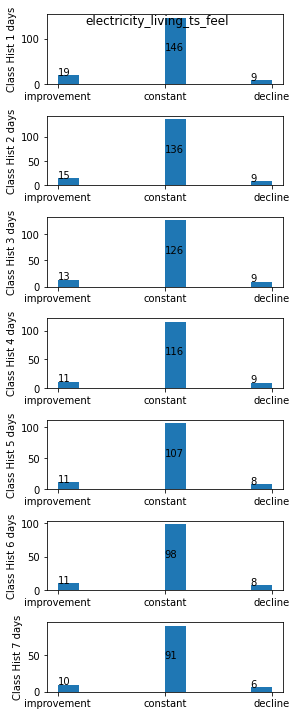

In [ ]:
#HISTOGRAMS OF CLAS
file_names = sorted(set([i for i in model_results['file'].to_list()]))
file_class_data = {}
for file_name in file_names[:1]:
  file_df = model_results.loc[model_results['file']==file_name].copy()
  # note below time_series_length (days) = window size
  tslens = file_df['time_series_length (days)'].to_list()
  const_counts = {i:[] for i in set(tslens)}
  improv_counts = {i:[] for i in set(tslens)}
  decl_counts = {i:[] for i in set(tslens)}
  for i, row in file_df.iterrows():
    ts_length = row['time_series_length (days)']
    if ts_length > 7:
      ts_length = ts_length%7 if ts_length%7 != 0 else 7
    constant_count = row['count_constant']
    count_decline = row['count_decline']
    count_improvement = row['count_improvement']
    const_counts[ts_length].append(constant_count)
    decl_counts[ts_length].append(count_decline)
    improv_counts[ts_length].append(count_improvement)

  # Plotting
  import matplotlib.pyplot as plt
  fig, ax = plt.subplots(7, figsize=(4,10))
  fig.suptitle(file_name)
  fig.tight_layout()
  for i, length in enumerate(improv_counts.keys()):
    all_vals = []
    [all_vals.append('improvement') for i in range(int(improv_counts[length][0]))]
    [all_vals.append('constant') for i in range(int(const_counts[length][0]))]
    [all_vals.append('decline') for i in range(int(decl_counts[length][0]))]
    counts, _, patches = ax[i].hist(all_vals, 
                                    )
    ax[i].set_ylabel('Class Hist {} days'.format(length))
    for count, patch in zip(counts,patches):
      if count > 0 and count != max(counts):
        ax[i].annotate(str(int(count)), xy=(patch.get_x(), patch.get_height()))
      elif count == max(counts):
        ax[i].annotate(str(int(count)), xy=(patch.get_x(), patch.get_height()/2))

In [ ]:
# Per-class f1 score and observation count analysis

file_names = sorted(set([i for i in model_results['file'].to_list()]))
file_class_data = {}
for file_name in file_names:
  file_df = model_results.loc[model_results['file']==file_name].copy()
  
  counts_decline =[i for i in file_df['count_decline'].to_list() if i != 0]
  counts_constant = file_df['count_constant'].to_list()
  counts_improvement = file_df['count_improvement'].to_list()

  tslens = file_df['time_series_length (days)'].to_list()
  for i, length in enumerate(tslens):
    if length > 7:
      tslens[i] = length%7 if length%7 != 0 else 7
  decline_vals = set(counts_decline)
  constant_vals = set(counts_constant)
  improvement_vals = set(counts_improvement)

  frequency_declines = {decline_val:{ts_len:0 for ts_len in tslens}  for decline_val in decline_vals}
  frequency_improvements = {decline_val:{ts_len:0 for ts_len in tslens}  for decline_val in improvement_vals}
  frequency_constants = {decline_val:{ts_len:0 for ts_len in tslens}  for decline_val in constant_vals}

  for decline_val, constant_val, improvement_val, ts_len in zip( counts_decline, counts_constant, counts_improvement, tslens ):
    frequency_declines[decline_val][ts_len] += 1
    frequency_improvements[improvement_val][ts_len] += 1
    frequency_constants[constant_val][ts_len] += 1
  
  print('{}\n\n---- decline ----'.format(file_name.upper()))
  print('Observation count - window size ')
  for value, dic in frequency_declines.items():
    for len, count in dic.items():
      if count > 0:
        print('   {}            |   {} '.format(value, len, count))

  print('---- improvement ----'.format(file_name))
  for value, dic in frequency_improvements.items():
    for len, count in dic.items():
      if count > 0:
        print('   {}            |   {}  '.format(value, len, count))

  print('----  constants  ----'.format(file_name))
  for value, dic in frequency_constants.items():
    for len, count in dic.items():
      if count > 0:
        print('   {}            |   {} '.format(value, len, count))
  print('\n###################\n\n')

ELECTRICITY_LIVING_TS_FEEL

---- decline ----
Observation count - window size 
   8            |   6 
   8            |   5 
   9            |   1 
   9            |   4 
   9            |   2 
   9            |   3 
   6            |   7 
---- improvement ----
   10            |   7  
   11            |   4  
   11            |   6  
   11            |   5  
   13            |   3  
   15            |   2  
   19            |   1  
----  constants  ----
   98            |   6 
   136            |   2 
   107            |   5 
   146            |   1 
   116            |   4 
   91            |   7 
   126            |   3 

###################


ELECTRICITY_LIVING_TS_FEEL_NORM

---- decline ----
Observation count - window size 
   8            |   5 
   8            |   6 
   9            |   2 
   9            |   4 
   9            |   3 
   9            |   1 
   6            |   7 
---- improvement ----
   10            |   7  
   11            |   5  
   11            |   6  
   

In [ ]:
# Observation count per class display for each window
file_names = sorted(set([i for i in model_results['file'].to_list()]))

class_imbalance_df = pd.DataFrame()
for file_name in file_names:
  file_df = model_results.loc[model_results['file']==file_name].copy()
  for ts_len in set(file_df['time_series_length (days)'].to_list()):
    file_df_sub = file_df.loc[file_df['time_series_length (days)']==ts_len]
    print(file_name, ts_len)
    display(file_df_sub)


electricity_living_ts_feel 1


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
3,electricity_living_ts_feel,feel,electricity,MrSEQL,0.800000,0.333333,0.166667,0.703030,0.433333,1,146,9,19,0,0.798048,e_consumption,electricity,1.0,0.0,NaN,NaN,NaN,NaN,NaN
6,electricity_living_ts_feel,feel,electricity,indvBOSS,0.864865,0.333333,0.250000,0.744779,0.482733,1,146,9,19,0,0.554762,e_consumption,water,1.0,0.0,NaN,NaN,NaN,NaN,NaN
848,electricity_living_ts_feel,feel,electricity,MrSEQL,0.800000,0.000000,0.333333,0.684848,0.377778,1,146,9,19,1,0.502315,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
861,electricity_living_ts_feel,feel,electricity,KNN,0.868421,0.000000,0.250000,0.792464,0.372807,1,146,9,19,0,0.524038,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
991,electricity_living_ts_feel,feel,electricity,KNN,0.833333,0.000000,0.200000,0.690152,0.344444,1,146,9,19,1,0.505952,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1104,electricity_living_ts_feel,feel,electricity,iTDE,0.811594,0.000000,0.153846,0.663069,0.321813,1,146,9,19,1,0.507143,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1359,electricity_living_ts_feel,feel,electricity,MUSE,0.952381,0.000000,0.000000,0.865801,0.317460,1,146,9,19,0,0.531250,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3016,electricity_living_ts_feel,feel,electricity,TSF,0.913580,0.000000,0.000000,0.768238,0.304527,1,146,9,19,0,0.507883,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3582,electricity_living_ts_feel,feel,electricity,MUSE,0.886076,0.000000,0.000000,0.704833,0.295359,1,146,9,19,1,0.441667,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3583,electricity_living_ts_feel,feel,electricity,indvBOSS,0.886076,0.000000,0.000000,0.845800,0.295359,1,146,9,19,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_living_ts_feel 2


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
214,electricity_living_ts_feel,feel,electricity,indvBOSS,0.929577,0.0,0.666667,0.886620,0.532081,2,136,9,15,1,0.645833,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,electricity_living_ts_feel,feel,electricity,iTDE,0.941176,0.0,0.571429,0.857143,0.504202,2,136,9,15,0,0.610294,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
467,electricity_living_ts_feel,feel,electricity,indvBOSS,0.941176,0.0,0.444444,0.844444,0.461874,2,136,9,15,0,0.602941,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
571,electricity_living_ts_feel,feel,electricity,KNN,0.901408,0.0,0.400000,0.818732,0.433803,2,136,9,15,1,0.561905,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
933,electricity_living_ts_feel,feel,electricity,MrSEQL,0.819672,0.0,0.266667,0.730546,0.362113,2,136,9,15,0,0.602381,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
936,electricity_living_ts_feel,feel,electricity,iTDE,0.835821,0.0,0.250000,0.729198,0.361940,2,136,9,15,1,0.455882,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3255,electricity_living_ts_feel,feel,electricity,MUSE,0.904110,0.0,0.000000,0.768493,0.301370,2,136,9,15,0,0.611765,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3256,electricity_living_ts_feel,feel,electricity,ROCKET,0.904110,0.0,0.000000,0.745890,0.301370,2,136,9,15,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3257,electricity_living_ts_feel,feel,electricity,ROCKET,0.904110,0.0,0.000000,0.768493,0.301370,2,136,9,15,1,0.492647,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3310,electricity_living_ts_feel,feel,electricity,KNN,0.901408,0.0,0.000000,0.811268,0.300469,2,136,9,15,0,0.472222,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_living_ts_feel 3


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
829,electricity_living_ts_feel,feel,electricity,MUSE,0.903226,0.0,0.250000,0.825850,0.384409,3,126,9,13,0,0.424242,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
840,electricity_living_ts_feel,feel,electricity,MrSEQL,0.857143,0.0,0.285714,0.725869,0.380952,3,126,9,13,0,0.542130,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
964,electricity_living_ts_feel,feel,electricity,indvBOSS,0.838710,0.0,0.222222,0.676741,0.353644,3,126,9,13,0,0.517857,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3456,electricity_living_ts_feel,feel,electricity,ROCKET,0.895522,0.0,0.000000,0.726099,0.298507,3,126,9,13,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3459,electricity_living_ts_feel,feel,electricity,iTDE,0.895522,0.0,0.000000,0.798709,0.298507,3,126,9,13,1,0.484848,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3461,electricity_living_ts_feel,feel,electricity,ROCKET,0.895522,0.0,0.000000,0.774506,0.298507,3,126,9,13,1,0.484375,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3464,electricity_living_ts_feel,feel,electricity,TSF,0.895522,0.0,0.000000,0.726099,0.298507,3,126,9,13,0,0.460648,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3502,electricity_living_ts_feel,feel,electricity,KNN,0.892308,0.0,0.000000,0.747609,0.297436,3,126,9,13,0,0.483871,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3926,electricity_living_ts_feel,feel,electricity,KNN,0.857143,0.0,0.000000,0.764479,0.285714,3,126,9,13,1,0.454545,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3950,electricity_living_ts_feel,feel,electricity,MUSE,0.852459,0.0,0.000000,0.668144,0.284153,3,126,9,13,1,0.355556,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_living_ts_feel 4


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
102,electricity_living_ts_feel,feel,electricity,indvBOSS,0.950820,0.0,0.800000,0.913983,0.583607,4,116,9,11,1,0.733871,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
638,electricity_living_ts_feel,feel,electricity,KNN,0.933333,0.0,0.333333,0.880392,0.422222,4,116,9,11,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
708,electricity_living_ts_feel,feel,electricity,MUSE,0.900000,0.0,0.333333,0.833333,0.411111,4,116,9,11,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
753,electricity_living_ts_feel,feel,electricity,iTDE,0.915254,0.0,0.285714,0.851303,0.400323,4,116,9,11,1,0.592742,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2863,electricity_living_ts_feel,feel,electricity,ROCKET,0.920635,0.0,0.000000,0.785247,0.306878,4,116,9,11,1,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2864,electricity_living_ts_feel,feel,electricity,ROCKET,0.920635,0.0,0.000000,0.785247,0.306878,4,116,9,11,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2994,electricity_living_ts_feel,feel,electricity,KNN,0.915254,0.0,0.000000,0.807577,0.305085,4,116,9,11,1,0.475000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3264,electricity_living_ts_feel,feel,electricity,TSF,0.903226,0.0,0.000000,0.743833,0.301075,4,116,9,11,0,0.601935,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3375,electricity_living_ts_feel,feel,electricity,iTDE,0.900000,0.0,0.000000,0.820588,0.300000,4,116,9,11,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3725,electricity_living_ts_feel,feel,electricity,MUSE,0.877193,0.0,0.000000,0.748194,0.292398,4,116,9,11,0,0.296935,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_living_ts_feel 5


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
659,electricity_living_ts_feel,feel,electricity,MUSE,0.857143,0.0,0.400000,0.746429,0.419048,5,107,8,11,1,0.597756,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
834,electricity_living_ts_feel,feel,electricity,MUSE,0.816327,0.0,0.333333,0.689838,0.383220,5,107,8,11,0,0.430000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
963,electricity_living_ts_feel,feel,electricity,indvBOSS,0.840000,0.0,0.222222,0.782083,0.354074,5,107,8,11,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
980,electricity_living_ts_feel,feel,electricity,indvBOSS,0.755556,0.0,0.285714,0.625992,0.347090,5,107,8,11,0,0.482500,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2392,electricity_living_ts_feel,feel,electricity,ROCKET,0.933333,0.0,0.000000,0.816667,0.311111,5,107,8,11,1,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2960,electricity_living_ts_feel,feel,electricity,ROCKET,0.915254,0.0,0.000000,0.772246,0.305085,5,107,8,11,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3430,electricity_living_ts_feel,feel,electricity,KNN,0.896552,0.0,0.000000,0.840517,0.298851,5,107,8,11,1,0.466667,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3692,electricity_living_ts_feel,feel,electricity,TSF,0.877193,0.0,0.000000,0.685307,0.292398,5,107,8,11,0,0.661944,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3726,electricity_living_ts_feel,feel,electricity,iTDE,0.877193,0.0,0.000000,0.794956,0.292398,5,107,8,11,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3922,electricity_living_ts_feel,feel,electricity,iTDE,0.857143,0.0,0.000000,0.776786,0.285714,5,107,8,11,1,0.456897,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_living_ts_feel 6


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
530,electricity_living_ts_feel,feel,electricity,MUSE,0.923077,0.0,0.400000,0.826667,0.441026,6,98,8,11,1,0.576923,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
531,electricity_living_ts_feel,feel,electricity,iTDE,0.923077,0.0,0.400000,0.822564,0.441026,6,98,8,11,1,0.552500,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
771,electricity_living_ts_feel,feel,electricity,ROCKET,0.901961,0.0,0.285714,0.769188,0.395892,6,98,8,11,1,0.539583,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
817,electricity_living_ts_feel,feel,electricity,KNN,0.880000,0.0,0.285714,0.742095,0.388571,6,98,8,11,1,0.541667,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1834,electricity_living_ts_feel,feel,electricity,ROCKET,0.947368,0.0,0.000000,0.852632,0.315789,6,98,8,11,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3140,electricity_living_ts_feel,feel,electricity,iTDE,0.727273,0.0,0.181818,0.557576,0.303030,6,98,8,11,0,0.556818,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3262,electricity_living_ts_feel,feel,electricity,MrSEQL,0.681818,0.0,0.222222,0.621044,0.301347,6,98,8,11,0,0.706790,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3592,electricity_living_ts_feel,feel,electricity,indvBOSS,0.884615,0.0,0.000000,0.737179,0.294872,6,98,8,11,0,0.470000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3827,electricity_living_ts_feel,feel,electricity,TSF,0.867925,0.0,0.000000,0.665409,0.289308,6,98,8,11,0,0.454408,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3851,electricity_living_ts_feel,feel,electricity,MUSE,0.862745,0.0,0.000000,0.747712,0.287582,6,98,8,11,0,0.641026,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_living_ts_feel 7


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
206,electricity_living_ts_feel,feel,electricity,KNN,0.938776,0.0,0.666667,0.883850,0.535147,7,91,6,10,1,0.614583,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
267,electricity_living_ts_feel,feel,electricity,TSF,0.981132,0.0,0.000000,0.944794,0.490566,7,91,6,10,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
820,electricity_living_ts_feel,feel,electricity,MUSE,0.800000,0.0,0.363636,0.721886,0.387879,7,91,6,10,1,0.485507,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
853,electricity_living_ts_feel,feel,electricity,MrSEQL,0.878049,0.0,0.250000,0.710705,0.376016,7,91,6,10,1,0.497354,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
859,electricity_living_ts_feel,feel,electricity,MrSEQL,0.837209,0.0,0.285714,0.651901,0.374308,7,91,6,10,0,0.725000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
885,electricity_living_ts_feel,feel,electricity,KNN,0.818182,0.0,0.285714,0.728716,0.367965,7,91,6,10,0,0.528986,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1121,electricity_living_ts_feel,feel,electricity,ROCKET,0.961538,0.0,0.000000,0.890313,0.320513,7,91,6,10,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2957,electricity_living_ts_feel,feel,electricity,ROCKET,0.916667,0.0,0.000000,0.882716,0.305556,7,91,6,10,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3469,electricity_living_ts_feel,feel,electricity,MUSE,0.893617,0.0,0.000000,0.794326,0.297872,7,91,6,10,0,0.736111,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3471,electricity_living_ts_feel,feel,electricity,indvBOSS,0.893617,0.0,0.000000,0.728132,0.297872,7,91,6,10,1,0.488636,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_living_ts_feel_norm 1


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
898,electricity_living_ts_feel_norm,feel,electricity,MrSEQL,0.888889,0.0,0.200000,0.736364,0.362963,1,146,9,19,0,0.560957,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1004,electricity_living_ts_feel_norm,feel,electricity,indvBOSS,0.805556,0.0,0.222222,0.681187,0.342593,1,146,9,19,0,0.488393,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1044,electricity_living_ts_feel_norm,feel,electricity,indvBOSS,0.845070,0.0,0.153846,0.708904,0.332972,1,146,9,19,1,0.458333,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1075,electricity_living_ts_feel_norm,feel,electricity,KNN,0.811594,0.0,0.166667,0.664526,0.326087,1,146,9,19,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2132,electricity_living_ts_feel_norm,feel,electricity,MUSE,0.939759,0.0,0.000000,0.854326,0.313253,1,146,9,19,1,0.263889,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2629,electricity_living_ts_feel_norm,feel,electricity,ROCKET,0.926829,0.0,0.000000,0.800443,0.308943,1,146,9,19,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3018,electricity_living_ts_feel_norm,feel,electricity,MUSE,0.913580,0.0,0.000000,0.789001,0.304527,1,146,9,19,0,0.486355,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3321,electricity_living_ts_feel_norm,feel,electricity,ROCKET,0.900000,0.0,0.000000,0.777273,0.300000,1,146,9,19,1,0.486842,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3898,electricity_living_ts_feel_norm,feel,electricity,TSF,0.857143,0.0,0.000000,0.662338,0.285714,1,146,9,19,0,0.497855,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3937,electricity_living_ts_feel_norm,feel,electricity,iTDE,0.853333,0.0,0.000000,0.736970,0.284444,1,146,9,19,0,0.460526,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_living_ts_feel_norm 2


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
435,electricity_living_ts_feel_norm,feel,electricity,iTDE,0.911765,0.0,0.500000,0.789706,0.470588,2,136,9,15,0,0.492424,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
452,electricity_living_ts_feel_norm,feel,electricity,KNN,0.898551,0.0,0.500000,0.791304,0.466184,2,136,9,15,1,0.609848,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
754,electricity_living_ts_feel_norm,feel,electricity,indvBOSS,0.865672,0.0,0.333333,0.734204,0.399668,2,136,9,15,0,0.526563,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
765,electricity_living_ts_feel_norm,feel,electricity,MrSEQL,0.830769,0.0,0.363636,0.751608,0.398135,2,136,9,15,1,0.720588,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
844,electricity_living_ts_feel_norm,feel,electricity,KNN,0.852941,0.0,0.285714,0.746534,0.379552,2,136,9,15,0,0.511364,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
954,electricity_living_ts_feel_norm,feel,electricity,indvBOSS,0.766667,0.0,0.307692,0.640321,0.358120,2,136,9,15,1,0.518817,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2380,electricity_living_ts_feel_norm,feel,electricity,MUSE,0.933333,0.0,0.000000,0.816667,0.311111,2,136,9,15,1,0.653968,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2533,electricity_living_ts_feel_norm,feel,electricity,iTDE,0.929577,0.0,0.000000,0.836620,0.309859,2,136,9,15,1,0.479167,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3258,electricity_living_ts_feel_norm,feel,electricity,ROCKET,0.904110,0.0,0.000000,0.836301,0.301370,2,136,9,15,1,0.472973,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3259,electricity_living_ts_feel_norm,feel,electricity,MUSE,0.904110,0.0,0.000000,0.745890,0.301370,2,136,9,15,0,0.439394,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_living_ts_feel_norm 3


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
479,electricity_living_ts_feel_norm,feel,electricity,indvBOSS,0.920635,0.000000,0.444444,0.882025,0.455026,3,126,9,13,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
978,electricity_living_ts_feel_norm,feel,electricity,MUSE,0.819672,0.000000,0.222222,0.646187,0.347298,3,126,9,13,0,0.422068,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
990,electricity_living_ts_feel_norm,feel,electricity,MrSEQL,0.750000,0.285714,0.000000,0.631274,0.345238,3,126,9,13,1,0.405556,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1084,electricity_living_ts_feel_norm,feel,electricity,MUSE,0.969697,0.000000,0.000000,0.838657,0.323232,3,126,9,13,1,0.390625,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2115,electricity_living_ts_feel_norm,feel,electricity,ROCKET,0.942857,0.000000,0.000000,0.840927,0.314286,3,126,9,13,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2625,electricity_living_ts_feel_norm,feel,electricity,TSF,0.927536,0.000000,0.000000,0.802193,0.309179,3,126,9,13,0,0.439236,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3534,electricity_living_ts_feel_norm,feel,electricity,KNN,0.888889,0.000000,0.000000,0.744745,0.296296,3,126,9,13,1,0.475806,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3561,electricity_living_ts_feel_norm,feel,electricity,KNN,0.888889,0.000000,0.000000,0.768769,0.296296,3,126,9,13,0,0.468750,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3571,electricity_living_ts_feel_norm,feel,electricity,iTDE,0.888889,0.000000,0.000000,0.816817,0.296296,3,126,9,13,0,0.463235,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3676,electricity_living_ts_feel_norm,feel,electricity,ROCKET,0.878788,0.000000,0.000000,0.688780,0.292929,3,126,9,13,1,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_living_ts_feel_norm 4


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
471,electricity_living_ts_feel_norm,feel,electricity,ROCKET,0.920635,0.0,0.000000,0.785247,0.460317,4,116,9,11,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
477,electricity_living_ts_feel_norm,feel,electricity,iTDE,0.966667,0.0,0.400000,0.859804,0.455556,4,116,9,11,0,0.583333,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
619,electricity_living_ts_feel_norm,feel,electricity,MUSE,0.881356,0.0,0.400000,0.735194,0.427119,4,116,9,11,1,0.431584,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
794,electricity_living_ts_feel_norm,feel,electricity,indvBOSS,0.896552,0.0,0.285714,0.789916,0.394089,4,116,9,11,0,0.557471,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
999,electricity_living_ts_feel_norm,feel,electricity,MrSEQL,0.777778,0.0,0.250000,0.716503,0.342593,4,116,9,11,0,0.634409,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2531,electricity_living_ts_feel_norm,feel,electricity,MrSEQL,0.730769,0.0,0.200000,0.582353,0.310256,4,116,9,11,1,0.591346,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2861,electricity_living_ts_feel_norm,feel,electricity,TSF,0.920635,0.0,0.000000,0.785247,0.306878,4,116,9,11,0,0.545019,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3587,electricity_living_ts_feel_norm,feel,electricity,KNN,0.885246,0.0,0.000000,0.781099,0.295082,4,116,9,11,1,0.475000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3591,electricity_living_ts_feel_norm,feel,electricity,iTDE,0.885246,0.0,0.000000,0.833173,0.295082,4,116,9,11,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3831,electricity_living_ts_feel_norm,feel,electricity,KNN,0.866667,0.0,0.000000,0.764706,0.288889,4,116,9,11,0,0.466667,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_living_ts_feel_norm 5


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
317,electricity_living_ts_feel_norm,feel,electricity,iTDE,0.947368,0.0,0.500000,0.875822,0.482456,5,107,8,11,1,0.565476,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
699,electricity_living_ts_feel_norm,feel,electricity,indvBOSS,0.905660,0.0,0.333333,0.777516,0.412998,5,107,8,11,1,0.543269,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
744,electricity_living_ts_feel_norm,feel,electricity,MrSEQL,0.872727,0.0,0.333333,0.811742,0.402020,5,107,8,11,1,0.508621,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1741,electricity_living_ts_feel_norm,feel,electricity,ROCKET,0.949153,0.0,0.000000,0.860169,0.316384,5,107,8,11,1,0.491379,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3144,electricity_living_ts_feel_norm,feel,electricity,KNN,0.909091,0.0,0.000000,0.738636,0.303030,5,107,8,11,0,0.490385,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3392,electricity_living_ts_feel_norm,feel,electricity,TSF,0.896552,0.0,0.000000,0.728448,0.298851,5,107,8,11,0,0.712340,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3395,electricity_living_ts_feel_norm,feel,electricity,ROCKET,0.896552,0.0,0.000000,0.728448,0.298851,5,107,8,11,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3490,electricity_living_ts_feel_norm,feel,electricity,indvBOSS,0.892857,0.0,0.000000,0.809152,0.297619,5,107,8,11,0,0.465517,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3594,electricity_living_ts_feel_norm,feel,electricity,iTDE,0.884615,0.0,0.000000,0.774038,0.294872,5,107,8,11,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3691,electricity_living_ts_feel_norm,feel,electricity,MUSE,0.877193,0.0,0.000000,0.822368,0.292398,5,107,8,11,1,0.716667,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_living_ts_feel_norm 6


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
461,electricity_living_ts_feel_norm,feel,electricity,ROCKET,0.928571,0.0,0.000000,0.835714,0.464286,6,98,8,11,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
468,electricity_living_ts_feel_norm,feel,electricity,MUSE,0.884615,0.0,0.500000,0.753846,0.461538,6,98,8,11,1,0.805000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
563,electricity_living_ts_feel_norm,feel,electricity,MUSE,0.905660,0.0,0.400000,0.824906,0.435220,6,98,8,11,0,0.429487,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
857,electricity_living_ts_feel_norm,feel,electricity,iTDE,0.875000,0.0,0.250000,0.745833,0.375000,6,98,8,11,1,0.595000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
937,electricity_living_ts_feel_norm,feel,electricity,iTDE,0.800000,0.0,0.285714,0.660952,0.361905,6,98,8,11,0,0.545652,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1649,electricity_living_ts_feel_norm,feel,electricity,MrSEQL,0.727273,0.0,0.222222,0.628283,0.316498,6,98,8,11,1,0.653333,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1832,electricity_living_ts_feel_norm,feel,electricity,ROCKET,0.947368,0.0,0.000000,0.852632,0.315789,6,98,8,11,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3527,electricity_living_ts_feel_norm,feel,electricity,TSF,0.888889,0.0,0.000000,0.740741,0.296296,6,98,8,11,0,0.513333,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3593,electricity_living_ts_feel_norm,feel,electricity,indvBOSS,0.884615,0.0,0.000000,0.766667,0.294872,6,98,8,11,0,0.461538,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3908,electricity_living_ts_feel_norm,feel,electricity,KNN,0.857143,0.0,0.000000,0.714286,0.285714,6,98,8,11,0,0.460000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_living_ts_feel_norm 7


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
499,electricity_living_ts_feel_norm,feel,electricity,KNN,0.936170,0.0,0.400000,0.861781,0.445390,7,91,6,10,0,0.604167,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
570,electricity_living_ts_feel_norm,feel,electricity,MrSEQL,0.857143,0.0,0.444444,0.748971,0.433862,7,91,6,10,1,0.487302,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
729,electricity_living_ts_feel_norm,feel,electricity,iTDE,0.883721,0.0,0.333333,0.810221,0.405685,7,91,6,10,0,0.437500,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
894,electricity_living_ts_feel_norm,feel,electricity,MrSEQL,0.809524,0.0,0.285714,0.661376,0.365079,7,91,6,10,0,0.566138,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2122,electricity_living_ts_feel_norm,feel,electricity,TSF,0.941176,0.0,0.000000,0.836601,0.313725,7,91,6,10,0,0.576389,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2871,electricity_living_ts_feel_norm,feel,electricity,MUSE,0.920000,0.0,0.000000,0.851852,0.306667,7,91,6,10,1,0.920000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2873,electricity_living_ts_feel_norm,feel,electricity,KNN,0.920000,0.0,0.000000,0.783704,0.306667,7,91,6,10,1,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2874,electricity_living_ts_feel_norm,feel,electricity,ROCKET,0.920000,0.0,0.000000,0.783704,0.306667,7,91,6,10,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3384,electricity_living_ts_feel_norm,feel,electricity,iTDE,0.897959,0.0,0.000000,0.864701,0.299320,7,91,6,10,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3849,electricity_living_ts_feel_norm,feel,electricity,ROCKET,0.863636,0.0,0.000000,0.735690,0.287879,7,91,6,10,1,0.456522,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_living_ts_resp 1


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
53,electricity_living_ts_resp,resp,electricity,ROCKET,0.470588,0.873239,0.873239,0.781728,0.671914,1,48,5,120,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,electricity_living_ts_resp,resp,electricity,MUSE,0.476190,0.835821,0.835821,0.754087,0.656006,1,48,5,120,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
248,electricity_living_ts_resp,resp,electricity,KNN,0.666667,0.000000,0.838710,0.761486,0.501792,1,48,5,120,0,0.653125,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
249,electricity_living_ts_resp,resp,electricity,ROCKET,0.666667,0.000000,0.833333,0.761364,0.500000,1,48,5,120,1,0.626232,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
449,electricity_living_ts_resp,resp,electricity,MrSEQL,0.583333,0.000000,0.819672,0.752701,0.467668,1,48,5,120,0,0.831155,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
480,electricity_living_ts_resp,resp,electricity,MrSEQL,0.571429,0.000000,0.793103,0.704545,0.454844,1,48,5,120,1,0.491790,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
550,electricity_living_ts_resp,resp,electricity,TSF,0.470588,0.000000,0.840580,0.693056,0.437056,1,48,5,120,0,0.644231,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
639,electricity_living_ts_resp,resp,electricity,KNN,0.551724,0.000000,0.714286,0.638939,0.422003,1,48,5,120,1,0.560185,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
692,electricity_living_ts_resp,resp,electricity,indvBOSS,0.434783,0.000000,0.806452,0.679746,0.413745,1,48,5,120,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
838,electricity_living_ts_resp,resp,electricity,indvBOSS,0.466667,0.000000,0.678571,0.580303,0.381746,1,48,5,120,0,0.571429,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_living_ts_resp 2


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
20,electricity_living_ts_resp,resp,electricity,indvBOSS,0.800000,0.933333,0.933333,0.893333,0.866667,2,46,4,110,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,electricity_living_ts_resp,resp,electricity,MUSE,0.761905,0.915254,0.915254,0.873083,0.838580,2,46,4,110,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,electricity_living_ts_resp,resp,electricity,ROCKET,0.666667,0.903226,0.903226,0.850000,0.784946,2,46,4,110,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,electricity_living_ts_resp,resp,electricity,KNN,0.689655,0.823529,0.823529,0.776673,0.756592,2,46,4,110,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,electricity_living_ts_resp,resp,electricity,indvBOSS,0.818182,0.000000,0.912281,0.884051,0.576821,2,46,4,110,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165,electricity_living_ts_resp,resp,electricity,iTDE,0.736842,0.000000,0.881356,0.819581,0.539399,2,46,4,110,0,0.891234,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
232,electricity_living_ts_resp,resp,electricity,TSF,0.700000,0.000000,0.881356,0.813983,0.527119,2,46,4,110,0,0.905747,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
286,electricity_living_ts_resp,resp,electricity,MrSEQL,0.640000,0.000000,0.814815,0.737630,0.484938,2,46,4,110,1,0.651381,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306,electricity_living_ts_resp,resp,electricity,ROCKET,0.600000,0.000000,0.847458,0.745847,0.482486,2,46,4,110,0,0.605769,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
358,electricity_living_ts_resp,resp,electricity,iTDE,0.588235,0.000000,0.852459,0.779797,0.480231,2,46,4,110,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_living_ts_resp 3


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
34,electricity_living_ts_resp,resp,electricity,TSF,0.666667,0.000000,0.918033,0.845665,0.528233,3,44,3,101,0,0.882594,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268,electricity_living_ts_resp,resp,electricity,MrSEQL,0.466667,0.000000,0.604651,0.539828,0.357106,3,44,3,101,1,0.724080,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
391,electricity_living_ts_resp,resp,electricity,iTDE,0.846154,0.000000,0.893617,0.852789,0.579924,3,44,3,101,0,0.689799,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500,electricity_living_ts_resp,resp,electricity,indvBOSS,0.761905,0.000000,0.884615,0.820909,0.548840,3,44,3,101,1,0.656250,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1178,electricity_living_ts_resp,resp,electricity,KNN,0.526316,0.000000,0.792453,0.670496,0.439590,3,44,3,101,0,0.582386,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4655,electricity_living_ts_resp,resp,electricity,indvBOSS,0.827586,0.888889,0.888889,0.867350,0.858238,3,44,3,101,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4676,electricity_living_ts_resp,resp,electricity,iTDE,0.761905,0.905660,0.905660,0.855152,0.833783,3,44,3,101,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4692,electricity_living_ts_resp,resp,electricity,MUSE,0.750000,0.880000,0.880000,0.830811,0.815000,3,44,3,101,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4730,electricity_living_ts_resp,resp,electricity,KNN,0.666667,0.808511,0.808511,0.774008,0.737589,3,44,3,101,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4736,electricity_living_ts_resp,resp,electricity,MUSE,0.600000,0.851852,0.851852,0.783784,0.725926,3,44,3,101,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_living_ts_resp 4


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
36,electricity_living_ts_resp,resp,electricity,MrSEQL,0.769231,0.000000,0.878049,0.813817,0.549093,4,42,2,92,0,0.880952,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
630,electricity_living_ts_resp,resp,electricity,iTDE,0.666667,0.000000,0.826087,0.750213,0.497585,4,42,2,92,0,0.625000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
725,electricity_living_ts_resp,resp,electricity,indvBOSS,0.588235,0.000000,0.840000,0.756055,0.476078,4,42,2,92,0,0.616250,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4608,electricity_living_ts_resp,resp,electricity,indvBOSS,0.888889,0.960000,0.960000,0.939085,0.924444,4,42,2,92,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4646,electricity_living_ts_resp,resp,electricity,MUSE,0.818182,0.913043,0.913043,0.885143,0.865613,4,42,2,92,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4654,electricity_living_ts_resp,resp,electricity,iTDE,0.800000,0.916667,0.916667,0.882353,0.858333,4,42,2,92,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4700,electricity_living_ts_resp,resp,electricity,KNN,0.750000,0.863636,0.863636,0.826872,0.806818,4,42,2,92,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4737,electricity_living_ts_resp,resp,electricity,MUSE,0.588235,0.862745,0.862745,0.782007,0.725490,4,42,2,92,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4849,electricity_living_ts_resp,resp,electricity,KNN,0.700000,0.000000,0.826087,0.744118,0.508696,4,42,2,92,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4889,electricity_living_ts_resp,resp,electricity,MrSEQL,0.583333,0.000000,0.744186,0.701607,0.442506,4,42,2,92,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_living_ts_resp 5


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
4636,electricity_living_ts_resp,resp,electricity,MrSEQL,0.823529,0.936170,0.936170,0.911530,0.879850,5,39,1,86,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4651,electricity_living_ts_resp,resp,electricity,indvBOSS,0.818182,0.904762,0.904762,0.875000,0.861472,5,39,1,86,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4674,electricity_living_ts_resp,resp,electricity,KNN,0.800000,0.871795,0.871795,0.840385,0.835897,5,39,1,86,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4684,electricity_living_ts_resp,resp,electricity,KNN,0.761905,0.883721,0.883721,0.845653,0.822813,5,39,1,86,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4685,electricity_living_ts_resp,resp,electricity,indvBOSS,0.761905,0.883721,0.883721,0.838040,0.822813,5,39,1,86,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4710,electricity_living_ts_resp,resp,electricity,MrSEQL,0.700000,0.863636,0.863636,0.812500,0.781818,5,39,1,86,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4746,electricity_living_ts_resp,resp,electricity,iTDE,0.533333,0.857143,0.857143,0.776190,0.695238,5,39,1,86,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4794,electricity_living_ts_resp,resp,electricity,MUSE,0.833333,0.000000,0.941176,0.891544,0.591503,5,39,1,86,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4810,electricity_living_ts_resp,resp,electricity,MUSE,0.800000,0.000000,0.916667,0.891146,0.572222,5,39,1,86,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4846,electricity_living_ts_resp,resp,electricity,iTDE,0.700000,0.000000,0.837209,0.768169,0.512403,5,39,1,86,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_living_ts_resp 6


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
4662,electricity_living_ts_resp,resp,electricity,indvBOSS,0.800000,0.900000,0.900000,0.870000,0.850000,6,37,1,79,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4670,electricity_living_ts_resp,resp,electricity,KNN,0.777778,0.904762,0.904762,0.866667,0.841270,6,37,1,79,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4697,electricity_living_ts_resp,resp,electricity,KNN,0.736842,0.878049,0.878049,0.835687,0.807445,6,37,1,79,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4706,electricity_living_ts_resp,resp,electricity,indvBOSS,0.750000,0.833333,0.833333,0.797222,0.791667,6,37,1,79,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4725,electricity_living_ts_resp,resp,electricity,iTDE,0.695652,0.810811,0.810811,0.764747,0.753231,6,37,1,79,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4766,electricity_living_ts_resp,resp,electricity,MrSEQL,0.470588,0.790698,0.790698,0.662654,0.630643,6,37,1,79,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4829,electricity_living_ts_resp,resp,electricity,iTDE,0.782609,0.000000,0.833333,0.788647,0.538647,6,37,1,79,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4830,electricity_living_ts_resp,resp,electricity,MUSE,0.782609,0.000000,0.833333,0.785266,0.538647,6,37,1,79,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4841,electricity_living_ts_resp,resp,electricity,MUSE,0.705882,0.000000,0.857143,0.788235,0.521008,6,37,1,79,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4844,electricity_living_ts_resp,resp,electricity,MrSEQL,0.750000,0.000000,0.800000,0.783333,0.516667,6,37,1,79,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_living_ts_resp 7


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
4638,electricity_living_ts_resp,resp,electricity,indvBOSS,0.842105,0.914286,0.914286,0.887552,0.878195,7,35,1,71,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4672,electricity_living_ts_resp,resp,electricity,MUSE,0.800000,0.882353,0.882353,0.851852,0.841176,7,35,1,71,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4714,electricity_living_ts_resp,resp,electricity,iTDE,0.750000,0.800000,0.800000,0.775926,0.775000,7,35,1,71,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4729,electricity_living_ts_resp,resp,electricity,MrSEQL,0.720000,0.758621,0.758621,0.741456,0.739310,7,35,1,71,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4731,electricity_living_ts_resp,resp,electricity,iTDE,0.625000,0.842105,0.842105,0.793860,0.733553,7,35,1,71,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4744,electricity_living_ts_resp,resp,electricity,KNN,0.588235,0.810811,0.810811,0.736619,0.699523,7,35,1,71,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4750,electricity_living_ts_resp,resp,electricity,MrSEQL,0.533333,0.820513,0.820513,0.756695,0.676923,7,35,1,71,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4824,electricity_living_ts_resp,resp,electricity,KNN,0.777778,0.000000,0.857143,0.801881,0.544974,7,35,1,71,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4845,electricity_living_ts_resp,resp,electricity,MUSE,0.666667,0.000000,0.878049,0.831075,0.514905,7,35,1,71,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4852,electricity_living_ts_resp,resp,electricity,indvBOSS,0.666667,0.000000,0.842105,0.765432,0.502924,7,35,1,71,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_living_ts_resp_norm 1


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
42,electricity_living_ts_resp_norm,resp,electricity,ROCKET,0.714286,0.866667,0.866667,0.821645,0.790476,1,48,5,120,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,electricity_living_ts_resp_norm,resp,electricity,MUSE,0.538462,0.806452,0.806452,0.745545,0.672457,1,48,5,120,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
335,electricity_living_ts_resp_norm,resp,electricity,TSF,0.571429,0.000000,0.873239,0.751966,0.481556,1,48,5,120,0,0.681231,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
503,electricity_living_ts_resp_norm,resp,electricity,MrSEQL,0.521739,0.000000,0.812500,0.733202,0.444746,1,48,5,120,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
552,electricity_living_ts_resp_norm,resp,electricity,KNN,0.470588,0.000000,0.840580,0.773309,0.437056,1,48,5,120,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
603,electricity_living_ts_resp_norm,resp,electricity,indvBOSS,0.551724,0.000000,0.736842,0.648655,0.429522,1,48,5,120,0,0.509947,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
632,electricity_living_ts_resp_norm,resp,electricity,ROCKET,0.444444,0.000000,0.823529,0.717172,0.422658,1,48,5,120,0,0.580882,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
637,electricity_living_ts_resp_norm,resp,electricity,KNN,0.480000,0.000000,0.786885,0.671356,0.422295,1,48,5,120,1,0.564039,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
660,electricity_living_ts_resp_norm,resp,electricity,iTDE,0.421053,0.000000,0.835821,0.750982,0.418958,1,48,5,120,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
766,electricity_living_ts_resp_norm,resp,electricity,iTDE,0.480000,0.000000,0.711864,0.584284,0.397288,1,48,5,120,1,0.518590,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_living_ts_resp_norm 2


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
7,electricity_living_ts_resp_norm,resp,electricity,iTDE,0.857143,1.000000,0.947368,0.923872,0.934837,2,46,4,110,0,0.913961,e_consumption,sleep,1.0,0.0,NaN,NaN,NaN,NaN,NaN
21,electricity_living_ts_resp_norm,resp,electricity,ROCKET,0.800000,0.933333,0.933333,0.893333,0.866667,2,46,4,110,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,electricity_living_ts_resp_norm,resp,electricity,indvBOSS,0.869565,0.000000,0.909091,0.850791,0.592885,2,46,4,110,0,0.682308,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,electricity_living_ts_resp_norm,resp,electricity,iTDE,0.846154,0.000000,0.862745,0.793477,0.569633,2,46,4,110,1,0.804487,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
111,electricity_living_ts_resp_norm,resp,electricity,indvBOSS,0.800000,0.000000,0.896552,0.852414,0.565517,2,46,4,110,1,0.688889,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,electricity_living_ts_resp_norm,resp,electricity,MUSE,0.777778,0.000000,0.900000,0.824444,0.559259,2,46,4,110,1,0.745238,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
210,electricity_living_ts_resp_norm,resp,electricity,MUSE,0.758621,0.000000,0.840000,0.788483,0.532874,2,46,4,110,0,0.801852,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
265,electricity_living_ts_resp_norm,resp,electricity,KNN,0.588235,0.000000,0.885246,0.818419,0.491160,2,46,4,110,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
284,electricity_living_ts_resp_norm,resp,electricity,ROCKET,0.636364,0.000000,0.821429,0.740747,0.485931,2,46,4,110,0,0.605769,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
488,electricity_living_ts_resp_norm,resp,electricity,MrSEQL,0.545455,0.000000,0.807018,0.721451,0.450824,2,46,4,110,0,0.452874,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_living_ts_resp_norm 3


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
9,electricity_living_ts_resp_norm,resp,electricity,MUSE,0.869565,0.666667,0.916667,0.887877,0.817633,3,44,3,101,1,0.896135,e_consumption,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN
12,electricity_living_ts_resp_norm,resp,electricity,indvBOSS,0.750000,0.666667,0.851064,0.805588,0.755910,3,44,3,101,0,0.775350,e_consumption,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN
37,electricity_living_ts_resp_norm,resp,electricity,MUSE,0.727273,0.000000,0.840000,0.758034,0.522424,3,44,3,101,0,0.879227,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155,electricity_living_ts_resp_norm,resp,electricity,MrSEQL,0.631579,0.000000,0.807692,0.721195,0.479757,3,44,3,101,0,0.771011,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
359,electricity_living_ts_resp_norm,resp,electricity,MrSEQL,0.592593,0.000000,0.711111,0.637437,0.434568,3,44,3,101,1,0.699811,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
427,electricity_living_ts_resp_norm,resp,electricity,ROCKET,0.800000,0.000000,0.931034,0.877540,0.577011,3,44,3,101,1,0.678571,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
432,electricity_living_ts_resp_norm,resp,electricity,indvBOSS,0.818182,0.000000,0.901961,0.850412,0.573381,3,44,3,101,1,0.677083,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
463,electricity_living_ts_resp_norm,resp,electricity,iTDE,0.812500,0.000000,0.829268,0.799151,0.547256,3,44,3,101,0,0.664861,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
515,electricity_living_ts_resp_norm,resp,electricity,iTDE,0.714286,0.000000,0.915254,0.852497,0.543180,3,44,3,101,1,0.652709,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1065,electricity_living_ts_resp_norm,resp,electricity,KNN,0.555556,0.000000,0.814815,0.686687,0.456790,3,44,3,101,1,0.593297,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_living_ts_resp_norm 4


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
80,electricity_living_ts_resp_norm,resp,electricity,TSF,0.470588,0.000000,0.800000,0.669896,0.423529,4,42,2,92,0,0.823003,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112,electricity_living_ts_resp_norm,resp,electricity,MrSEQL,0.666667,0.000000,0.857143,0.775910,0.507937,4,42,2,92,1,0.794203,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154,electricity_living_ts_resp_norm,resp,electricity,MUSE,0.695652,0.000000,0.818182,0.754476,0.504611,4,42,2,92,1,0.772727,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
487,electricity_living_ts_resp_norm,resp,electricity,ROCKET,0.769231,0.000000,0.905660,0.850935,0.558297,4,42,2,92,0,0.659341,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
573,electricity_living_ts_resp_norm,resp,electricity,indvBOSS,0.666667,0.000000,0.833333,0.769608,0.500000,4,42,2,92,0,0.637500,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
581,electricity_living_ts_resp_norm,resp,electricity,iTDE,0.800000,0.000000,0.857143,0.813445,0.552381,4,42,2,92,0,0.636364,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
597,electricity_living_ts_resp_norm,resp,electricity,ROCKET,0.700000,0.000000,0.851064,0.768273,0.517021,4,42,2,92,1,0.634615,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1388,electricity_living_ts_resp_norm,resp,electricity,MrSEQL,0.720000,0.000000,0.809524,0.754118,0.509841,4,42,2,92,0,0.552249,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1591,electricity_living_ts_resp_norm,resp,electricity,KNN,0.352941,0.000000,0.734694,0.589577,0.362545,4,42,2,92,0,0.522727,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4752,electricity_living_ts_resp_norm,resp,electricity,KNN,0.526316,0.816327,0.816327,0.748089,0.671321,4,42,2,92,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_living_ts_resp_norm 5


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
4614,electricity_living_ts_resp_norm,resp,electricity,MUSE,0.875000,0.958333,0.958333,0.940104,0.916667,5,39,1,86,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4668,electricity_living_ts_resp_norm,resp,electricity,indvBOSS,0.777778,0.913043,0.913043,0.866546,0.845411,5,39,1,86,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4720,electricity_living_ts_resp_norm,resp,electricity,MrSEQL,0.695652,0.829268,0.829268,0.783338,0.762460,5,39,1,86,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4739,electricity_living_ts_resp_norm,resp,electricity,iTDE,0.636364,0.809524,0.809524,0.760823,0.722944,5,39,1,86,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4748,electricity_living_ts_resp_norm,resp,electricity,MrSEQL,0.555556,0.826087,0.826087,0.766908,0.690821,5,39,1,86,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4803,electricity_living_ts_resp_norm,resp,electricity,indvBOSS,0.823529,0.000000,0.913043,0.890665,0.578858,5,39,1,86,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4809,electricity_living_ts_resp_norm,resp,electricity,iTDE,0.800000,0.000000,0.916667,0.858854,0.572222,5,39,1,86,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4818,electricity_living_ts_resp_norm,resp,electricity,MUSE,0.800000,0.000000,0.883721,0.857558,0.561240,5,39,1,86,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4851,electricity_living_ts_resp_norm,resp,electricity,KNN,0.666667,0.000000,0.844444,0.762500,0.503704,5,39,1,86,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4921,electricity_living_ts_resp_norm,resp,electricity,KNN,0.476190,0.000000,0.714286,0.580357,0.396825,5,39,1,86,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_living_ts_resp_norm 6


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
4671,electricity_living_ts_resp_norm,resp,electricity,indvBOSS,0.777778,0.904762,0.904762,0.870899,0.841270,6,37,1,79,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4689,electricity_living_ts_resp_norm,resp,electricity,MUSE,0.761905,0.871795,0.871795,0.835165,0.816850,6,37,1,79,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4723,electricity_living_ts_resp_norm,resp,electricity,MUSE,0.666667,0.857143,0.857143,0.806349,0.761905,6,37,1,79,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4734,electricity_living_ts_resp_norm,resp,electricity,KNN,0.631579,0.829268,0.829268,0.763372,0.730424,6,37,1,79,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4740,electricity_living_ts_resp_norm,resp,electricity,iTDE,0.636364,0.789474,0.789474,0.738437,0.712919,6,37,1,79,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4749,electricity_living_ts_resp_norm,resp,electricity,MrSEQL,0.533333,0.844444,0.844444,0.771852,0.688889,6,37,1,79,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4755,electricity_living_ts_resp_norm,resp,electricity,KNN,0.500000,0.818182,0.818182,0.722727,0.659091,6,37,1,79,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4767,electricity_living_ts_resp_norm,resp,electricity,MrSEQL,0.428571,0.826087,0.826087,0.759834,0.627329,6,37,1,79,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4802,electricity_living_ts_resp_norm,resp,electricity,indvBOSS,0.842105,0.000000,0.900000,0.850702,0.580702,6,37,1,79,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4805,electricity_living_ts_resp_norm,resp,electricity,iTDE,0.823529,0.000000,0.904762,0.847526,0.576097,6,37,1,79,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_living_ts_resp_norm 7


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
4637,electricity_living_ts_resp_norm,resp,electricity,iTDE,0.842105,0.914286,0.914286,0.887552,0.878195,7,35,1,71,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4666,electricity_living_ts_resp_norm,resp,electricity,iTDE,0.769231,0.926829,0.926829,0.891807,0.848030,7,35,1,71,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4687,electricity_living_ts_resp_norm,resp,electricity,indvBOSS,0.750000,0.894737,0.894737,0.851852,0.822368,7,35,1,71,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4703,electricity_living_ts_resp_norm,resp,electricity,KNN,0.736842,0.857143,0.857143,0.808131,0.796992,7,35,1,71,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4717,electricity_living_ts_resp_norm,resp,electricity,MrSEQL,0.727273,0.812500,0.812500,0.780934,0.769886,7,35,1,71,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4718,electricity_living_ts_resp_norm,resp,electricity,KNN,0.666667,0.871795,0.871795,0.803419,0.769231,7,35,1,71,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4814,electricity_living_ts_resp_norm,resp,electricity,MUSE,0.800000,0.000000,0.894737,0.833528,0.564912,7,35,1,71,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4819,electricity_living_ts_resp_norm,resp,electricity,indvBOSS,0.769231,0.000000,0.900000,0.832764,0.556410,7,35,1,71,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4853,electricity_living_ts_resp_norm,resp,electricity,MUSE,0.666667,0.000000,0.842105,0.796621,0.502924,7,35,1,71,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4918,electricity_living_ts_resp_norm,resp,electricity,MrSEQL,0.583333,0.000000,0.620690,0.605470,0.401341,7,35,1,71,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_nutrition_ts_feel 1


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
475,electricity_nutrition_ts_feel,feel,electricity,ROCKET,0.915254,0.0,0.000000,0.772246,0.457627,1,102,7,18,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
730,electricity_nutrition_ts_feel,feel,electricity,iTDE,0.816327,0.4,0.000000,0.662755,0.405442,1,102,7,18,1,0.440000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
944,electricity_nutrition_ts_feel,feel,electricity,KNN,0.830189,0.0,0.250000,0.661704,0.360063,1,102,7,18,1,0.529167,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
976,electricity_nutrition_ts_feel,feel,electricity,MrSEQL,0.846154,0.0,0.200000,0.718750,0.348718,1,102,7,18,0,0.371795,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
977,electricity_nutrition_ts_feel,feel,electricity,iTDE,0.823529,0.0,0.222222,0.696895,0.348584,1,102,7,18,0,0.471154,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
994,electricity_nutrition_ts_feel,feel,electricity,KNN,0.830189,0.0,0.200000,0.666392,0.343396,1,102,7,18,0,0.514881,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1067,electricity_nutrition_ts_feel,feel,electricity,indvBOSS,0.807692,0.0,0.181818,0.670782,0.329837,1,102,7,18,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3391,electricity_nutrition_ts_feel,feel,electricity,MUSE,0.896552,0.0,0.000000,0.728448,0.298851,1,102,7,18,1,0.772792,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3438,electricity_nutrition_ts_feel,feel,electricity,MUSE,0.896552,0.0,0.000000,0.728448,0.298851,1,102,7,18,0,0.421795,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3842,electricity_nutrition_ts_feel,feel,electricity,indvBOSS,0.711111,0.0,0.153846,0.560363,0.288319,1,102,7,18,1,0.660000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_nutrition_ts_feel 2


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
14,electricity_nutrition_ts_feel,feel,electricity,indvBOSS,0.782609,0.5,0.200000,0.637246,0.494203,2,97,7,15,0,0.823052,e_consumption,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN
401,electricity_nutrition_ts_feel,feel,electricity,MUSE,0.947368,0.0,0.000000,0.852632,0.473684,2,97,7,15,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
528,electricity_nutrition_ts_feel,feel,electricity,MUSE,0.925926,0.0,0.400000,0.842469,0.441975,2,97,7,15,1,0.585470,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
631,electricity_nutrition_ts_feel,feel,electricity,iTDE,0.869565,0.0,0.400000,0.775652,0.423188,2,97,7,15,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
663,electricity_nutrition_ts_feel,feel,electricity,iTDE,0.920000,0.0,0.333333,0.749778,0.417778,2,97,7,15,0,0.540761,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
855,electricity_nutrition_ts_feel,feel,electricity,KNN,0.840000,0.0,0.285714,0.775048,0.375238,2,97,7,15,1,0.569444,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1017,electricity_nutrition_ts_feel,feel,electricity,MrSEQL,0.833333,0.0,0.181818,0.746465,0.338384,2,97,7,15,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3578,electricity_nutrition_ts_feel,feel,electricity,TSF,0.888889,0.0,0.000000,0.711111,0.296296,2,97,7,15,0,0.421875,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3808,electricity_nutrition_ts_feel,feel,electricity,ROCKET,0.867925,0.0,0.000000,0.665409,0.289308,2,97,7,15,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3853,electricity_nutrition_ts_feel,feel,electricity,indvBOSS,0.862745,0.0,0.000000,0.690196,0.287582,2,97,7,15,1,0.489583,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_nutrition_ts_feel 3


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
618,electricity_nutrition_ts_feel,feel,electricity,MUSE,0.837209,0.0,0.444444,0.737172,0.427218,3,92,7,13,1,0.568182,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
736,electricity_nutrition_ts_feel,feel,electricity,KNN,0.875000,0.0,0.333333,0.715774,0.402778,3,92,7,13,0,0.550000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
764,electricity_nutrition_ts_feel,feel,electricity,indvBOSS,0.909091,0.0,0.285714,0.799629,0.398268,3,92,7,13,1,0.583333,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
935,electricity_nutrition_ts_feel,feel,electricity,MrSEQL,0.863636,0.0,0.222222,0.679473,0.361953,3,92,7,13,1,0.578042,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983,electricity_nutrition_ts_feel,feel,electricity,iTDE,0.761905,0.0,0.181818,0.603896,0.314574,3,92,7,13,1,0.502381,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2129,electricity_nutrition_ts_feel,feel,electricity,MUSE,0.941176,0.0,0.000000,0.873950,0.313725,3,92,7,13,0,0.448718,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3272,electricity_nutrition_ts_feel,feel,electricity,ROCKET,0.901961,0.0,0.000000,0.740896,0.300654,3,92,7,13,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3890,electricity_nutrition_ts_feel,feel,electricity,TSF,0.857143,0.0,0.000000,0.642857,0.285714,3,92,7,13,0,0.633333,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3897,electricity_nutrition_ts_feel,feel,electricity,ROCKET,0.857143,0.0,0.000000,0.642857,0.285714,3,92,7,13,1,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3983,electricity_nutrition_ts_feel,feel,electricity,indvBOSS,0.682927,0.0,0.166667,0.547909,0.283198,3,92,7,13,0,0.404762,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_nutrition_ts_feel 4


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
420,electricity_nutrition_ts_feel,feel,electricity,iTDE,0.916667,0.0,0.500000,0.802469,0.472222,4,87,7,11,1,0.571970,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
547,electricity_nutrition_ts_feel,feel,electricity,MUSE,0.913043,0.0,0.400000,0.841224,0.437681,4,87,7,11,0,0.520833,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
758,electricity_nutrition_ts_feel,feel,electricity,KNN,0.863636,0.0,0.333333,0.760382,0.398990,4,87,7,11,0,0.581522,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
893,electricity_nutrition_ts_feel,feel,electricity,MrSEQL,0.809524,0.0,0.285714,0.611993,0.365079,4,87,7,11,1,0.620614,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
992,electricity_nutrition_ts_feel,feel,electricity,MrSEQL,0.780488,0.0,0.250000,0.683378,0.343496,4,87,7,11,0,0.572464,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2876,electricity_nutrition_ts_feel,feel,electricity,ROCKET,0.920000,0.0,0.000000,0.783704,0.306667,4,87,7,11,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3019,electricity_nutrition_ts_feel,feel,electricity,iTDE,0.913043,0.0,0.000000,0.811594,0.304348,4,87,7,11,0,0.614583,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3383,electricity_nutrition_ts_feel,feel,electricity,TSF,0.897959,0.0,0.000000,0.731670,0.299320,4,87,7,11,0,0.217803,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3744,electricity_nutrition_ts_feel,feel,electricity,KNN,0.875000,0.0,0.000000,0.842593,0.291667,4,87,7,11,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3800,electricity_nutrition_ts_feel,feel,electricity,indvBOSS,0.869565,0.0,0.000000,0.772947,0.289855,4,87,7,11,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_nutrition_ts_feel 5


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
243,electricity_nutrition_ts_feel,feel,electricity,ROCKET,0.850000,0.0,0.666667,0.794000,0.505556,5,81,6,11,1,0.619048,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
436,electricity_nutrition_ts_feel,feel,electricity,KNN,0.909091,0.0,0.500000,0.803636,0.469697,5,81,6,11,0,0.613095,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
447,electricity_nutrition_ts_feel,feel,electricity,TSF,0.936170,0.0,0.000000,0.823830,0.468085,5,81,6,11,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
712,electricity_nutrition_ts_feel,feel,electricity,KNN,0.829268,0.0,0.400000,0.695415,0.409756,5,81,6,11,1,0.587500,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3022,electricity_nutrition_ts_feel,feel,electricity,ROCKET,0.913043,0.0,0.000000,0.766957,0.304348,5,81,6,11,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3843,electricity_nutrition_ts_feel,feel,electricity,iTDE,0.864865,0.0,0.000000,0.691892,0.288288,5,81,6,11,0,0.450000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3980,electricity_nutrition_ts_feel,feel,electricity,indvBOSS,0.850000,0.0,0.000000,0.714000,0.283333,5,81,6,11,0,0.464286,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3982,electricity_nutrition_ts_feel,feel,electricity,indvBOSS,0.850000,0.0,0.000000,0.714000,0.283333,5,81,6,11,1,0.452381,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4107,electricity_nutrition_ts_feel,feel,electricity,MrSEQL,0.829268,0.0,0.000000,0.563902,0.276423,5,81,6,11,1,0.532680,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4108,electricity_nutrition_ts_feel,feel,electricity,MrSEQL,0.829268,0.0,0.000000,0.696585,0.276423,5,81,6,11,0,0.519841,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_nutrition_ts_feel 6


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
485,electricity_nutrition_ts_feel,feel,electricity,indvBOSS,0.904762,0.0,0.000000,0.904762,0.452381,6,75,6,11,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
542,electricity_nutrition_ts_feel,feel,electricity,ROCKET,0.878049,0.0,0.000000,0.839873,0.439024,6,75,6,11,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
718,electricity_nutrition_ts_feel,feel,electricity,indvBOSS,0.888889,0.0,0.333333,0.763285,0.407407,6,75,6,11,0,0.598684,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
746,electricity_nutrition_ts_feel,feel,electricity,MUSE,0.871795,0.0,0.333333,0.801561,0.401709,6,75,6,11,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
769,electricity_nutrition_ts_feel,feel,electricity,MrSEQL,0.857143,0.0,0.333333,0.751553,0.396825,6,75,6,11,0,0.467836,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1009,electricity_nutrition_ts_feel,feel,electricity,MUSE,0.800000,0.0,0.222222,0.604831,0.340741,6,75,6,11,0,0.398958,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1027,electricity_nutrition_ts_feel,feel,electricity,MrSEQL,0.787879,0.0,0.222222,0.660518,0.336700,6,75,6,11,1,0.631579,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3468,electricity_nutrition_ts_feel,feel,electricity,KNN,0.894737,0.0,0.000000,0.778032,0.298246,6,75,6,11,0,0.462500,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3678,electricity_nutrition_ts_feel,feel,electricity,ROCKET,0.878049,0.0,0.000000,0.687169,0.292683,6,75,6,11,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3679,electricity_nutrition_ts_feel,feel,electricity,KNN,0.878049,0.0,0.000000,0.801697,0.292683,6,75,6,11,1,0.464286,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_nutrition_ts_feel 7


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
673,electricity_nutrition_ts_feel,feel,electricity,iTDE,0.848485,0.0,0.400000,0.769146,0.416162,7,71,5,10,0,0.559211,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
756,electricity_nutrition_ts_feel,feel,electricity,KNN,0.864865,0.0,0.333333,0.801392,0.399399,7,71,5,10,1,0.700000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2795,electricity_nutrition_ts_feel,feel,electricity,iTDE,0.923077,0.0,0.000000,0.881119,0.307692,7,71,5,10,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3465,electricity_nutrition_ts_feel,feel,electricity,MUSE,0.894737,0.0,0.000000,0.732057,0.298246,7,71,5,10,0,0.589506,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3780,electricity_nutrition_ts_feel,feel,electricity,TSF,0.871795,0.0,0.000000,0.673660,0.290598,7,71,5,10,0,0.745098,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3844,electricity_nutrition_ts_feel,feel,electricity,ROCKET,0.864865,0.0,0.000000,0.786241,0.288288,7,71,5,10,1,0.450000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4020,electricity_nutrition_ts_feel,feel,electricity,ROCKET,0.842105,0.0,0.000000,0.612440,0.280702,7,71,5,10,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4068,electricity_nutrition_ts_feel,feel,electricity,KNN,0.833333,0.0,0.000000,0.681818,0.277778,7,71,5,10,0,0.458333,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4086,electricity_nutrition_ts_feel,feel,electricity,MUSE,0.833333,0.0,0.000000,0.643939,0.277778,7,71,5,10,1,0.357843,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4128,electricity_nutrition_ts_feel,feel,electricity,MrSEQL,0.823529,0.0,0.000000,0.673797,0.274510,7,71,5,10,0,0.561728,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_nutrition_ts_feel_norm 1


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
26,electricity_nutrition_ts_feel_norm,feel,electricity,iTDE,0.862745,0.400000,0.250000,0.738082,0.504248,1,102,7,18,0,0.550000,e_consumption,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN
30,electricity_nutrition_ts_feel_norm,feel,electricity,iTDE,0.840000,0.333333,0.500000,0.776458,0.557778,1,102,7,18,1,0.527778,e_consumption,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN
451,electricity_nutrition_ts_feel_norm,feel,electricity,TSF,0.933333,0.000000,0.000000,0.816667,0.466667,1,102,7,18,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
616,electricity_nutrition_ts_feel_norm,feel,electricity,KNN,0.884615,0.000000,0.400000,0.781250,0.428205,1,102,7,18,0,0.571154,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
743,electricity_nutrition_ts_feel_norm,feel,electricity,KNN,0.872727,0.000000,0.333333,0.706629,0.402020,1,102,7,18,1,0.550000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1043,electricity_nutrition_ts_feel_norm,feel,electricity,indvBOSS,0.800000,0.000000,0.200000,0.693750,0.333333,1,102,7,18,1,0.564815,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1091,electricity_nutrition_ts_feel_norm,feel,electricity,MrSEQL,0.800000,0.000000,0.166667,0.651042,0.322222,1,102,7,18,1,0.317333,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1501,electricity_nutrition_ts_feel_norm,feel,electricity,ROCKET,0.950820,0.000000,0.000000,0.861680,0.316940,1,102,7,18,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2438,electricity_nutrition_ts_feel_norm,feel,electricity,MUSE,0.933333,0.000000,0.000000,0.816667,0.311111,1,102,7,18,1,0.348214,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4002,electricity_nutrition_ts_feel_norm,feel,electricity,indvBOSS,0.846154,0.000000,0.000000,0.713942,0.282051,1,102,7,18,0,0.462963,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_nutrition_ts_feel_norm 2


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
25,electricity_nutrition_ts_feel_norm,feel,electricity,MrSEQL,0.844444,0.333333,0.444444,0.774074,0.540741,2,97,7,15,0,0.775000,e_consumption,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN
266,electricity_nutrition_ts_feel_norm,feel,electricity,iTDE,0.901961,0.000000,0.571429,0.827824,0.491130,2,97,7,15,0,0.605000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
662,electricity_nutrition_ts_feel_norm,feel,electricity,MrSEQL,0.923077,0.000000,0.333333,0.794017,0.418803,2,97,7,15,1,0.377778,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
949,electricity_nutrition_ts_feel_norm,feel,electricity,indvBOSS,0.791667,0.000000,0.285714,0.741071,0.359127,2,97,7,15,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1062,electricity_nutrition_ts_feel_norm,feel,electricity,indvBOSS,0.791667,0.000000,0.200000,0.666667,0.330556,2,97,7,15,1,0.508333,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1105,electricity_nutrition_ts_feel_norm,feel,electricity,iTDE,0.782609,0.000000,0.181818,0.670356,0.321476,2,97,7,15,1,0.493333,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3138,electricity_nutrition_ts_feel_norm,feel,electricity,MUSE,0.909091,0.000000,0.000000,0.757576,0.303030,2,97,7,15,1,0.798889,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3528,electricity_nutrition_ts_feel_norm,feel,electricity,ROCKET,0.888889,0.000000,0.000000,0.711111,0.296296,2,97,7,15,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3809,electricity_nutrition_ts_feel_norm,feel,electricity,TSF,0.867925,0.000000,0.000000,0.665409,0.289308,2,97,7,15,0,0.488829,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4129,electricity_nutrition_ts_feel_norm,feel,electricity,ROCKET,0.823529,0.000000,0.000000,0.576471,0.274510,2,97,7,15,1,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_nutrition_ts_feel_norm 3


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
357,electricity_nutrition_ts_feel_norm,feel,electricity,MUSE,0.869565,0.0,0.571429,0.754215,0.480331,3,92,7,13,1,0.536508,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
605,electricity_nutrition_ts_feel_norm,feel,electricity,KNN,0.857143,0.0,0.000000,0.795918,0.428571,3,92,7,13,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
845,electricity_nutrition_ts_feel_norm,feel,electricity,KNN,0.851064,0.0,0.285714,0.749891,0.378926,3,92,7,13,0,0.583333,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
988,electricity_nutrition_ts_feel_norm,feel,electricity,indvBOSS,0.837209,0.0,0.200000,0.761794,0.345736,3,92,7,13,1,0.565000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3271,electricity_nutrition_ts_feel_norm,feel,electricity,TSF,0.901961,0.0,0.000000,0.740896,0.300654,3,92,7,13,0,0.670290,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3646,electricity_nutrition_ts_feel_norm,feel,electricity,ROCKET,0.880000,0.0,0.000000,0.722857,0.293333,3,92,7,13,1,0.489130,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3799,electricity_nutrition_ts_feel_norm,feel,electricity,iTDE,0.869565,0.0,0.000000,0.714286,0.289855,3,92,7,13,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3896,electricity_nutrition_ts_feel_norm,feel,electricity,ROCKET,0.857143,0.0,0.000000,0.642857,0.285714,3,92,7,13,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3976,electricity_nutrition_ts_feel_norm,feel,electricity,indvBOSS,0.851064,0.0,0.000000,0.790274,0.283688,3,92,7,13,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4085,electricity_nutrition_ts_feel_norm,feel,electricity,MrSEQL,0.833333,0.0,0.000000,0.714286,0.277778,3,92,7,13,0,0.381944,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_nutrition_ts_feel_norm 4


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
399,electricity_nutrition_ts_feel_norm,feel,electricity,MrSEQL,0.878049,0.0,0.545455,0.763735,0.474501,4,87,7,11,1,0.586310,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
459,electricity_nutrition_ts_feel_norm,feel,electricity,KNN,0.893617,0.5,0.000000,0.779748,0.464539,4,87,7,11,1,0.728261,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
502,electricity_nutrition_ts_feel_norm,feel,electricity,indvBOSS,0.936170,0.0,0.400000,0.822065,0.445390,4,87,7,11,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
901,electricity_nutrition_ts_feel_norm,feel,electricity,MUSE,0.837209,0.0,0.250000,0.740956,0.362403,4,87,7,11,1,0.333333,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1013,electricity_nutrition_ts_feel_norm,feel,electricity,MUSE,0.820513,0.0,0.200000,0.690788,0.340171,4,87,7,11,0,0.493687,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1122,electricity_nutrition_ts_feel_norm,feel,electricity,ROCKET,0.961538,0.0,0.000000,0.890313,0.320513,4,87,7,11,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3740,electricity_nutrition_ts_feel_norm,feel,electricity,TSF,0.875000,0.0,0.000000,0.680556,0.291667,4,87,7,11,0,0.589683,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3971,electricity_nutrition_ts_feel_norm,feel,electricity,ROCKET,0.851064,0.0,0.000000,0.661939,0.283688,4,87,7,11,1,0.488095,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4011,electricity_nutrition_ts_feel_norm,feel,electricity,iTDE,0.844444,0.0,0.000000,0.688066,0.281481,4,87,7,11,1,0.454545,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4120,electricity_nutrition_ts_feel_norm,feel,electricity,MrSEQL,0.826087,0.0,0.000000,0.734300,0.275362,4,87,7,11,0,0.399306,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_nutrition_ts_feel_norm 5


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
486,electricity_nutrition_ts_feel_norm,feel,electricity,indvBOSS,0.954545,0.0,0.400000,0.872000,0.451515,5,81,6,11,0,0.602273,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
557,electricity_nutrition_ts_feel_norm,feel,electricity,KNN,0.909091,0.0,0.400000,0.827636,0.436364,5,81,6,11,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
706,electricity_nutrition_ts_feel_norm,feel,electricity,MUSE,0.900000,0.0,0.333333,0.782667,0.411111,5,81,6,11,1,0.599206,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
993,electricity_nutrition_ts_feel_norm,feel,electricity,MUSE,0.848485,0.0,0.181818,0.647273,0.343434,5,81,6,11,0,0.399074,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1026,electricity_nutrition_ts_feel_norm,feel,electricity,iTDE,0.810811,0.0,0.200000,0.623784,0.336937,5,81,6,11,0,0.444444,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3021,electricity_nutrition_ts_feel_norm,feel,electricity,ROCKET,0.913043,0.0,0.000000,0.766957,0.304348,5,81,6,11,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3580,electricity_nutrition_ts_feel_norm,feel,electricity,TSF,0.888889,0.0,0.000000,0.711111,0.296296,5,81,6,11,0,0.411111,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3681,electricity_nutrition_ts_feel_norm,feel,electricity,indvBOSS,0.878049,0.0,0.000000,0.667317,0.292683,5,81,6,11,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3848,electricity_nutrition_ts_feel_norm,feel,electricity,KNN,0.863636,0.0,0.000000,0.760000,0.287879,5,81,6,11,0,0.465909,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3979,electricity_nutrition_ts_feel_norm,feel,electricity,iTDE,0.850000,0.0,0.000000,0.714000,0.283333,5,81,6,11,1,0.464286,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_nutrition_ts_feel_norm 6


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
238,electricity_nutrition_ts_feel_norm,feel,electricity,KNN,0.900000,0.0,0.666667,0.879710,0.522222,6,75,6,11,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
297,electricity_nutrition_ts_feel_norm,feel,electricity,KNN,0.950000,0.0,0.500000,0.828261,0.483333,6,75,6,11,0,0.625000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
733,electricity_nutrition_ts_feel_norm,feel,electricity,indvBOSS,0.810811,0.0,0.400000,0.739835,0.403604,6,75,6,11,1,0.562500,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
757,electricity_nutrition_ts_feel_norm,feel,electricity,iTDE,0.864865,0.0,0.333333,0.743439,0.399399,6,75,6,11,1,0.585526,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
839,electricity_nutrition_ts_feel_norm,feel,electricity,ROCKET,0.810811,0.0,0.333333,0.671759,0.381381,6,75,6,11,1,0.520588,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1081,electricity_nutrition_ts_feel_norm,feel,electricity,MrSEQL,0.750000,0.0,0.222222,0.606280,0.324074,6,75,6,11,0,0.473765,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1307,electricity_nutrition_ts_feel_norm,feel,electricity,MUSE,0.954545,0.0,0.000000,0.871542,0.318182,6,75,6,11,1,0.428571,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3254,electricity_nutrition_ts_feel_norm,feel,electricity,TSF,0.904762,0.0,0.000000,0.747412,0.301587,6,75,6,11,0,0.646199,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3466,electricity_nutrition_ts_feel_norm,feel,electricity,MrSEQL,0.894737,0.0,0.000000,0.661327,0.298246,6,75,6,11,1,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3677,electricity_nutrition_ts_feel_norm,feel,electricity,ROCKET,0.878049,0.0,0.000000,0.687169,0.292683,6,75,6,11,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_nutrition_ts_feel_norm 7


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
495,electricity_nutrition_ts_feel_norm,feel,electricity,MrSEQL,0.944444,0.0,0.400000,0.790909,0.448148,7,71,5,10,0,0.873457,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
869,electricity_nutrition_ts_feel_norm,feel,electricity,MrSEQL,0.750000,0.0,0.363636,0.645661,0.371212,7,71,5,10,1,0.784314,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1646,electricity_nutrition_ts_feel_norm,feel,electricity,KNN,0.950000,0.0,0.000000,0.863636,0.316667,7,71,5,10,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1978,electricity_nutrition_ts_feel_norm,feel,electricity,iTDE,0.944444,0.0,0.000000,0.772727,0.314815,7,71,5,10,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2133,electricity_nutrition_ts_feel_norm,feel,electricity,indvBOSS,0.689655,0.0,0.250000,0.547022,0.313218,7,71,5,10,1,0.468750,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2630,electricity_nutrition_ts_feel_norm,feel,electricity,indvBOSS,0.926829,0.0,0.000000,0.842572,0.308943,7,71,5,10,0,0.487500,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2753,electricity_nutrition_ts_feel_norm,feel,electricity,ROCKET,0.923077,0.0,0.000000,0.797203,0.307692,7,71,5,10,1,0.486842,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3467,electricity_nutrition_ts_feel_norm,feel,electricity,KNN,0.894737,0.0,0.000000,0.772727,0.298246,7,71,5,10,0,0.473684,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3781,electricity_nutrition_ts_feel_norm,feel,electricity,TSF,0.871795,0.0,0.000000,0.673660,0.290598,7,71,5,10,0,0.575163,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3782,electricity_nutrition_ts_feel_norm,feel,electricity,ROCKET,0.871795,0.0,0.000000,0.673660,0.290598,7,71,5,10,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_nutrition_ts_resp 1


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
1,electricity_nutrition_ts_resp,resp,electricity,TSF,0.956522,0.975610,0.975610,0.968452,0.966066,1,37,5,84,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,electricity_nutrition_ts_resp,resp,electricity,KNN,0.909091,0.952381,0.952381,0.936147,0.930736,1,37,5,84,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,electricity_nutrition_ts_resp,resp,electricity,ROCKET,0.941176,0.000000,0.956522,0.922315,0.632566,1,37,5,84,1,0.722222,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,electricity_nutrition_ts_resp,resp,electricity,KNN,0.823529,0.000000,0.888889,0.814951,0.570806,1,37,5,84,0,0.682540,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118,electricity_nutrition_ts_resp,resp,electricity,ROCKET,0.823529,0.000000,0.837209,0.728711,0.553580,1,37,5,84,0,0.681287,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235,electricity_nutrition_ts_resp,resp,electricity,MUSE,0.705882,0.000000,0.869565,0.791240,0.525149,1,37,5,84,1,0.599206,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
305,electricity_nutrition_ts_resp,resp,electricity,MrSEQL,0.500000,0.666667,0.731707,0.676956,0.632791,1,37,5,84,1,0.758282,e_consumption,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN
439,electricity_nutrition_ts_resp,resp,electricity,indvBOSS,0.166667,0.500000,0.750000,0.588542,0.472222,1,37,5,84,1,0.497159,e_consumption,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN
462,electricity_nutrition_ts_resp,resp,electricity,indvBOSS,0.600000,0.000000,0.790698,0.737064,0.463566,1,37,5,84,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
484,electricity_nutrition_ts_resp,resp,electricity,MUSE,0.500000,0.000000,0.862745,0.756434,0.454248,1,37,5,84,0,0.684524,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_nutrition_ts_resp 2


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
16,electricity_nutrition_ts_resp,resp,electricity,MUSE,0.875000,0.954545,0.954545,0.935985,0.914773,2,36,4,79,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,electricity_nutrition_ts_resp,resp,electricity,TSF,0.857143,0.956522,0.956522,0.930021,0.906832,2,36,4,79,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,electricity_nutrition_ts_resp,resp,electricity,MUSE,0.750000,0.909091,0.909091,0.856061,0.829545,2,36,4,79,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,electricity_nutrition_ts_resp,resp,electricity,MrSEQL,0.700000,1.000000,0.842105,0.814211,0.847368,2,36,4,79,0,0.987013,e_consumption,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN
63,electricity_nutrition_ts_resp,resp,electricity,iTDE,1.000000,0.000000,0.977778,0.982963,0.659259,2,36,4,79,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,electricity_nutrition_ts_resp,resp,electricity,KNN,0.909091,0.000000,0.958333,0.916540,0.622475,2,36,4,79,0,0.708333,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,electricity_nutrition_ts_resp,resp,electricity,ROCKET,0.923077,0.000000,0.909091,0.821445,0.610723,2,36,4,79,1,0.714286,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,electricity_nutrition_ts_resp,resp,electricity,KNN,0.875000,0.000000,0.904762,0.865675,0.593254,2,36,4,79,1,0.681944,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,electricity_nutrition_ts_resp,resp,electricity,indvBOSS,0.909091,0.000000,0.857143,0.820779,0.588745,2,36,4,79,1,0.692708,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
208,electricity_nutrition_ts_resp,resp,electricity,iTDE,0.714286,0.000000,0.888889,0.853968,0.534392,2,36,4,79,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_nutrition_ts_resp 3


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,electricity_nutrition_ts_resp,resp,electricity,MUSE,0.947368,0.000000,0.944444,0.911654,0.630604,3,35,3,74,0,0.990741,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,electricity_nutrition_ts_resp,resp,electricity,MrSEQL,0.941176,0.000000,1.000000,0.947479,0.647059,3,35,3,74,0,0.979167,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,electricity_nutrition_ts_resp,resp,electricity,TSF,0.857143,0.000000,0.882353,0.840036,0.579832,3,35,3,74,0,0.936574,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
137,electricity_nutrition_ts_resp,resp,electricity,MrSEQL,0.736842,0.000000,0.914286,0.791944,0.550376,3,35,3,74,1,0.778322,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147,electricity_nutrition_ts_resp,resp,electricity,ROCKET,0.933333,1.000000,0.974359,0.963553,0.969231,3,35,3,74,0,0.968750,e_consumption,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN
227,electricity_nutrition_ts_resp,resp,electricity,KNN,0.933333,0.000000,0.950000,0.911905,0.627778,3,35,3,74,0,0.737500,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
340,electricity_nutrition_ts_resp,resp,electricity,KNN,0.900000,0.000000,0.914286,0.876020,0.604762,3,35,3,74,1,0.704545,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4588,electricity_nutrition_ts_resp,resp,electricity,indvBOSS,0.952381,0.971429,0.971429,0.963946,0.961905,3,35,3,74,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4607,electricity_nutrition_ts_resp,resp,electricity,iTDE,0.909091,0.941176,0.941176,0.928571,0.925134,3,35,3,74,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4610,electricity_nutrition_ts_resp,resp,electricity,indvBOSS,0.888889,0.947368,0.947368,0.926483,0.918129,3,35,3,74,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_nutrition_ts_resp 4


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
28,electricity_nutrition_ts_resp,resp,electricity,MUSE,0.947368,0.0,0.941176,0.908382,0.629515,4,34,2,69,0,0.892157,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
239,electricity_nutrition_ts_resp,resp,electricity,KNN,1.000000,0.0,0.933333,0.925926,0.644444,4,34,2,69,1,0.733333,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315,electricity_nutrition_ts_resp,resp,electricity,KNN,0.916667,0.0,0.896552,0.872286,0.604406,4,34,2,69,0,0.711310,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
377,electricity_nutrition_ts_resp,resp,electricity,ROCKET,0.875000,0.0,0.918919,0.870245,0.597973,4,34,2,69,0,0.694444,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
378,electricity_nutrition_ts_resp,resp,electricity,iTDE,0.909091,0.0,0.903226,0.872162,0.604106,4,34,2,69,0,0.693939,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
465,electricity_nutrition_ts_resp,resp,electricity,indvBOSS,0.727273,0.0,0.878049,0.817607,0.535107,4,34,2,69,1,0.664286,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4713,electricity_nutrition_ts_resp,resp,electricity,iTDE,0.750000,0.8,0.800000,0.777778,0.775000,4,34,2,69,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4781,electricity_nutrition_ts_resp,resp,electricity,MUSE,0.923077,0.0,0.923077,0.854701,0.615385,4,34,2,69,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4799,electricity_nutrition_ts_resp,resp,electricity,MrSEQL,0.857143,0.0,0.903226,0.819252,0.586790,4,34,2,69,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4808,electricity_nutrition_ts_resp,resp,electricity,indvBOSS,0.857143,0.0,0.864865,0.862577,0.574003,4,34,2,69,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_nutrition_ts_resp 5


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
4592,electricity_nutrition_ts_resp,resp,electricity,iTDE,0.941176,0.969697,0.969697,0.960570,0.955437,5,32,1,65,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4594,electricity_nutrition_ts_resp,resp,electricity,indvBOSS,0.933333,0.971429,0.971429,0.960762,0.952381,5,32,1,65,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4623,electricity_nutrition_ts_resp,resp,electricity,KNN,0.875000,0.941176,0.941176,0.920000,0.908088,5,32,1,65,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4625,electricity_nutrition_ts_resp,resp,electricity,indvBOSS,0.857143,0.944444,0.944444,0.916508,0.900794,5,32,1,65,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4631,electricity_nutrition_ts_resp,resp,electricity,KNN,0.833333,0.947368,0.947368,0.924561,0.890351,5,32,1,65,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4690,electricity_nutrition_ts_resp,resp,electricity,iTDE,0.750000,0.882353,0.882353,0.850588,0.816176,5,32,1,65,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4768,electricity_nutrition_ts_resp,resp,electricity,MUSE,0.933333,0.000000,0.941176,0.901333,0.624837,5,32,1,65,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4778,electricity_nutrition_ts_resp,resp,electricity,MUSE,0.909091,0.000000,0.947368,0.900287,0.618820,5,32,1,65,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4813,electricity_nutrition_ts_resp,resp,electricity,MrSEQL,0.823529,0.000000,0.875000,0.823529,0.566176,5,32,1,65,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4822,electricity_nutrition_ts_resp,resp,electricity,MrSEQL,0.769231,0.000000,0.888889,0.860171,0.552707,5,32,1,65,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_nutrition_ts_resp 6


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
4587,electricity_nutrition_ts_resp,resp,electricity,MUSE,1.000000,1.000000,1.000000,1.000000,1.000000,6,31,1,60,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4595,electricity_nutrition_ts_resp,resp,electricity,MrSEQL,0.933333,0.967742,0.967742,0.957270,0.950538,6,31,1,60,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4624,electricity_nutrition_ts_resp,resp,electricity,indvBOSS,0.875000,0.933333,0.933333,0.913043,0.904167,6,31,1,60,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4626,electricity_nutrition_ts_resp,resp,electricity,indvBOSS,0.857143,0.937500,0.937500,0.916537,0.897321,6,31,1,60,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4643,electricity_nutrition_ts_resp,resp,electricity,iTDE,0.800000,0.944444,0.944444,0.913043,0.872222,6,31,1,60,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4661,electricity_nutrition_ts_resp,resp,electricity,iTDE,0.800000,0.903226,0.903226,0.876297,0.851613,6,31,1,60,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4780,electricity_nutrition_ts_resp,resp,electricity,MrSEQL,0.909091,0.000000,0.941176,0.891886,0.616756,6,31,1,60,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4782,electricity_nutrition_ts_resp,resp,electricity,KNN,0.888889,0.000000,0.944444,0.891304,0.611111,6,31,1,60,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4792,electricity_nutrition_ts_resp,resp,electricity,MUSE,0.888889,0.000000,0.888889,0.850242,0.592593,6,31,1,60,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4798,electricity_nutrition_ts_resp,resp,electricity,KNN,0.857143,0.000000,0.903226,0.849930,0.586790,6,31,1,60,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_nutrition_ts_resp 7


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
4570,electricity_nutrition_ts_resp,resp,electricity,indvBOSS,1.000000,1.000000,1.000000,1.000000,1.000000,7,30,1,55,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4586,electricity_nutrition_ts_resp,resp,electricity,MUSE,1.000000,1.000000,1.000000,1.000000,1.000000,7,30,1,55,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4598,electricity_nutrition_ts_resp,resp,electricity,MrSEQL,0.933333,0.965517,0.965517,0.953814,0.949425,7,30,1,55,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4599,electricity_nutrition_ts_resp,resp,electricity,MUSE,0.933333,0.965517,0.965517,0.953814,0.949425,7,30,1,55,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4629,electricity_nutrition_ts_resp,resp,electricity,MrSEQL,0.857143,0.933333,0.933333,0.905628,0.895238,7,30,1,55,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4652,electricity_nutrition_ts_resp,resp,electricity,indvBOSS,0.842105,0.880000,0.880000,0.864498,0.861053,7,30,1,55,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4761,electricity_nutrition_ts_resp,resp,electricity,KNN,1.000000,0.000000,0.956522,0.976285,0.652174,7,30,1,55,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4762,electricity_nutrition_ts_resp,resp,electricity,iTDE,1.000000,0.000000,0.956522,0.932806,0.652174,7,30,1,55,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4773,electricity_nutrition_ts_resp,resp,electricity,KNN,0.947368,0.000000,0.916667,0.930622,0.621345,7,30,1,55,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4783,electricity_nutrition_ts_resp,resp,electricity,iTDE,0.888889,0.000000,0.941176,0.886512,0.610022,7,30,1,55,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_nutrition_ts_resp_norm 1


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
5,electricity_nutrition_ts_resp_norm,resp,electricity,ROCKET,0.923077,0.947368,0.947368,0.936741,0.935223,1,37,5,84,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,electricity_nutrition_ts_resp_norm,resp,electricity,ROCKET,0.750000,0.916667,0.916667,0.875000,0.833333,1,37,5,84,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,electricity_nutrition_ts_resp_norm,resp,electricity,KNN,0.720000,0.820513,0.820513,0.782821,0.770256,1,37,5,84,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,electricity_nutrition_ts_resp_norm,resp,electricity,TSF,0.363636,0.867925,0.867925,0.757611,0.615780,1,37,5,84,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
221,electricity_nutrition_ts_resp_norm,resp,electricity,MUSE,0.714286,0.000000,0.875000,0.780134,0.529762,1,37,5,84,0,0.682765,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
379,electricity_nutrition_ts_resp_norm,resp,electricity,MrSEQL,0.545455,0.000000,0.884615,0.793378,0.476690,1,37,5,84,1,0.664444,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
497,electricity_nutrition_ts_resp_norm,resp,electricity,KNN,0.640000,0.000000,0.702703,0.651351,0.447568,1,37,5,84,1,0.586458,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
625,electricity_nutrition_ts_resp_norm,resp,electricity,indvBOSS,0.545455,0.000000,0.731707,0.627356,0.425721,1,37,5,84,1,0.577731,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
664,electricity_nutrition_ts_resp_norm,resp,electricity,MUSE,0.470588,0.000000,0.782609,0.631394,0.417732,1,37,5,84,1,0.765670,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
704,electricity_nutrition_ts_resp_norm,resp,electricity,indvBOSS,0.500000,0.000000,0.736842,0.609375,0.412281,1,37,5,84,0,0.580144,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_nutrition_ts_resp_norm 2


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
24,electricity_nutrition_ts_resp_norm,resp,electricity,ROCKET,0.818182,0.894737,0.894737,0.864115,0.856459,2,36,4,79,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,electricity_nutrition_ts_resp_norm,resp,electricity,TSF,0.625000,0.863636,0.863636,0.792045,0.744318,2,36,4,79,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,electricity_nutrition_ts_resp_norm,resp,electricity,KNN,0.631579,0.829268,0.829268,0.756782,0.730424,2,36,4,79,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,electricity_nutrition_ts_resp_norm,resp,electricity,ROCKET,1.000000,0.000000,0.977778,0.950370,0.659259,2,36,4,79,0,0.750000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,electricity_nutrition_ts_resp_norm,resp,electricity,MUSE,0.933333,0.000000,0.930233,0.869044,0.621189,2,36,4,79,1,0.826042,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,electricity_nutrition_ts_resp_norm,resp,electricity,MUSE,0.923077,0.000000,0.933333,0.868718,0.618803,2,36,4,79,0,0.668367,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,electricity_nutrition_ts_resp_norm,resp,electricity,iTDE,0.909091,0.000000,0.936170,0.869246,0.615087,2,36,4,79,1,0.739130,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,electricity_nutrition_ts_resp_norm,resp,electricity,indvBOSS,0.888889,0.000000,0.926829,0.916712,0.605239,2,36,4,79,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,electricity_nutrition_ts_resp_norm,resp,electricity,iTDE,0.869565,0.000000,0.888889,0.881159,0.586151,2,36,4,79,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,electricity_nutrition_ts_resp_norm,resp,electricity,indvBOSS,0.833333,0.000000,0.875000,0.826389,0.569444,2,36,4,79,1,0.661905,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_nutrition_ts_resp_norm 3


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
4,electricity_nutrition_ts_resp_norm,resp,electricity,MUSE,0.842105,0.000000,0.888889,0.843776,0.576998,3,35,3,74,1,0.967105,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,electricity_nutrition_ts_resp_norm,resp,electricity,MrSEQL,0.823529,0.000000,0.947368,0.882574,0.590299,3,35,3,74,0,0.927381,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
318,electricity_nutrition_ts_resp_norm,resp,electricity,ROCKET,0.947368,0.000000,0.914286,0.893448,0.620551,3,35,3,74,1,0.710294,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
572,electricity_nutrition_ts_resp_norm,resp,electricity,indvBOSS,0.941176,1.000000,0.972973,0.963718,0.971383,3,35,3,74,1,0.958333,e_consumption,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN
669,electricity_nutrition_ts_resp_norm,resp,electricity,ROCKET,0.875000,1.000000,0.947368,0.925987,0.940789,3,35,3,74,0,0.944444,e_consumption,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN
703,electricity_nutrition_ts_resp_norm,resp,electricity,MrSEQL,0.705882,0.666667,0.833333,0.785014,0.735294,3,35,3,74,1,0.711806,e_consumption,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN
1137,electricity_nutrition_ts_resp_norm,resp,electricity,KNN,0.500000,0.000000,0.705882,0.603992,0.401961,3,35,3,74,0,0.586466,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4606,electricity_nutrition_ts_resp_norm,resp,electricity,indvBOSS,0.923077,0.933333,0.933333,0.928938,0.928205,3,35,3,74,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4635,electricity_nutrition_ts_resp_norm,resp,electricity,iTDE,0.842105,0.918919,0.918919,0.891485,0.880512,3,35,3,74,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4647,electricity_nutrition_ts_resp_norm,resp,electricity,MUSE,0.800000,0.926829,0.926829,0.899652,0.863415,3,35,3,74,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_nutrition_ts_resp_norm 4


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
277,electricity_nutrition_ts_resp_norm,resp,electricity,ROCKET,0.941176,0.000000,0.944444,0.908376,0.628540,4,34,2,69,1,0.722222,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
341,electricity_nutrition_ts_resp_norm,resp,electricity,indvBOSS,0.900000,0.000000,0.909091,0.871717,0.603030,4,34,2,69,0,0.704545,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
516,electricity_nutrition_ts_resp_norm,resp,electricity,iTDE,0.833333,0.000000,0.900000,0.849383,0.577778,4,34,2,69,0,0.652256,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
688,electricity_nutrition_ts_resp_norm,resp,electricity,MrSEQL,0.500000,0.000000,0.878049,0.747516,0.459350,4,34,2,69,1,0.620301,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1341,electricity_nutrition_ts_resp_norm,resp,electricity,MrSEQL,0.900000,0.000000,0.909091,0.872391,0.603030,4,34,2,69,0,0.559913,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4589,electricity_nutrition_ts_resp_norm,resp,electricity,KNN,0.952381,0.969697,0.969697,0.963284,0.961039,4,34,2,69,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4600,electricity_nutrition_ts_resp_norm,resp,electricity,iTDE,0.923077,0.975610,0.975610,0.963936,0.949343,4,34,2,69,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4609,electricity_nutrition_ts_resp_norm,resp,electricity,indvBOSS,0.900000,0.941176,0.941176,0.925926,0.920588,4,34,2,69,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4756,electricity_nutrition_ts_resp_norm,resp,electricity,MUSE,1.000000,0.000000,0.975610,0.981030,0.658537,4,34,2,69,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4817,electricity_nutrition_ts_resp_norm,resp,electricity,MUSE,0.842105,0.000000,0.848485,0.783508,0.563530,4,34,2,69,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_nutrition_ts_resp_norm 5


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
4591,electricity_nutrition_ts_resp_norm,resp,electricity,KNN,0.947368,0.967742,0.967742,0.959593,0.957555,5,32,1,65,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4602,electricity_nutrition_ts_resp_norm,resp,electricity,indvBOSS,0.909091,0.974359,0.974359,0.958695,0.941725,5,32,1,65,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4639,electricity_nutrition_ts_resp_norm,resp,electricity,MrSEQL,0.857143,0.896552,0.896552,0.882365,0.876847,5,32,1,65,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4656,electricity_nutrition_ts_resp_norm,resp,electricity,iTDE,0.800000,0.914286,0.914286,0.882286,0.857143,5,32,1,65,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4711,electricity_nutrition_ts_resp_norm,resp,electricity,KNN,0.666667,0.894737,0.894737,0.849123,0.780702,5,32,1,65,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4769,electricity_nutrition_ts_resp_norm,resp,electricity,iTDE,0.923077,0.000000,0.944444,0.900684,0.622507,5,32,1,65,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4770,electricity_nutrition_ts_resp_norm,resp,electricity,MUSE,0.923077,0.000000,0.944444,0.900684,0.622507,5,32,1,65,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4771,electricity_nutrition_ts_resp_norm,resp,electricity,MUSE,0.923077,0.000000,0.944444,0.900684,0.622507,5,32,1,65,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4787,electricity_nutrition_ts_resp_norm,resp,electricity,indvBOSS,0.909091,0.000000,0.888889,0.897778,0.599327,5,32,1,65,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4788,electricity_nutrition_ts_resp_norm,resp,electricity,MrSEQL,0.900000,0.000000,0.896552,0.862069,0.598851,5,32,1,65,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_nutrition_ts_resp_norm 6


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
4547,electricity_nutrition_ts_resp_norm,resp,electricity,KNN,1.000000,1.000000,1.000000,1.000000,1.000000,6,31,1,60,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4593,electricity_nutrition_ts_resp_norm,resp,electricity,indvBOSS,0.941176,0.965517,0.965517,0.957051,0.953347,6,31,1,60,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4596,electricity_nutrition_ts_resp_norm,resp,electricity,MUSE,0.933333,0.967742,0.967742,0.955774,0.950538,6,31,1,60,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4620,electricity_nutrition_ts_resp_norm,resp,electricity,indvBOSS,0.900000,0.923077,0.923077,0.913043,0.911538,6,31,1,60,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4621,electricity_nutrition_ts_resp_norm,resp,electricity,iTDE,0.888889,0.928571,0.928571,0.911318,0.908730,6,31,1,60,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4644,electricity_nutrition_ts_resp_norm,resp,electricity,MrSEQL,0.800000,0.944444,0.944444,0.913043,0.872222,6,31,1,60,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4665,electricity_nutrition_ts_resp_norm,resp,electricity,MUSE,0.750000,0.947368,0.947368,0.921625,0.848684,6,31,1,60,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4757,electricity_nutrition_ts_resp_norm,resp,electricity,MrSEQL,1.000000,0.000000,0.971429,0.935404,0.657143,6,31,1,60,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4775,electricity_nutrition_ts_resp_norm,resp,electricity,KNN,0.923077,0.000000,0.937500,0.892977,0.620192,6,31,1,60,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4776,electricity_nutrition_ts_resp_norm,resp,electricity,iTDE,0.923077,0.000000,0.937500,0.892349,0.620192,6,31,1,60,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_nutrition_ts_resp_norm 7


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
4578,electricity_nutrition_ts_resp_norm,resp,electricity,MrSEQL,1.000000,1.000000,1.000000,1.000000,1.000000,7,30,1,55,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4597,electricity_nutrition_ts_resp_norm,resp,electricity,iTDE,0.933333,0.965517,0.965517,0.953814,0.949425,7,30,1,55,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4601,electricity_nutrition_ts_resp_norm,resp,electricity,MrSEQL,0.923077,0.967742,0.967742,0.953530,0.945409,7,30,1,55,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4622,electricity_nutrition_ts_resp_norm,resp,electricity,KNN,0.900000,0.916667,0.916667,0.909091,0.908333,7,30,1,55,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4648,electricity_nutrition_ts_resp_norm,resp,electricity,iTDE,0.857143,0.869565,0.869565,0.863919,0.863354,7,30,1,55,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4759,electricity_nutrition_ts_resp_norm,resp,electricity,MUSE,1.000000,0.000000,0.962963,0.932660,0.654321,7,30,1,55,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4774,electricity_nutrition_ts_resp_norm,resp,electricity,KNN,0.933333,0.000000,0.928571,0.887879,0.620635,7,30,1,55,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4796,electricity_nutrition_ts_resp_norm,resp,electricity,indvBOSS,0.888889,0.000000,0.880000,0.883232,0.589630,7,30,1,55,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4797,electricity_nutrition_ts_resp_norm,resp,electricity,MUSE,0.875000,0.000000,0.888889,0.883207,0.587963,7,30,1,55,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4807,electricity_nutrition_ts_resp_norm,resp,electricity,indvBOSS,0.888889,0.000000,0.833333,0.853535,0.574074,7,30,1,55,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_total_ts_feel 1


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
320,electricity_total_ts_feel,feel,electricity,TSF,0.964706,0.0,0.000000,0.898930,0.482353,1,146,9,19,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
922,electricity_total_ts_feel,feel,electricity,KNN,0.864865,0.0,0.222222,0.747475,0.362362,1,146,9,19,1,0.528716,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1372,electricity_total_ts_feel,feel,electricity,ROCKET,0.952381,0.0,0.000000,0.865801,0.317460,1,146,9,19,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2131,electricity_total_ts_feel,feel,electricity,ROCKET,0.939759,0.0,0.000000,0.854326,0.313253,1,146,9,19,1,0.493750,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2628,electricity_total_ts_feel,feel,electricity,MUSE,0.926829,0.0,0.000000,0.800443,0.308943,1,146,9,19,1,0.541228,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3360,electricity_total_ts_feel,feel,electricity,MUSE,0.900000,0.0,0.000000,0.736364,0.300000,1,146,9,19,0,0.473457,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3977,electricity_total_ts_feel,feel,electricity,MrSEQL,0.696970,0.0,0.153846,0.549057,0.283605,1,146,9,19,1,0.544585,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4067,electricity_total_ts_feel,feel,electricity,iTDE,0.833333,0.0,0.000000,0.662879,0.277778,1,146,9,19,0,0.464286,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4147,electricity_total_ts_feel,feel,electricity,iTDE,0.821918,0.0,0.000000,0.672478,0.273973,1,146,9,19,1,0.458333,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4182,electricity_total_ts_feel,feel,electricity,KNN,0.810811,0.0,0.000000,0.626536,0.270270,1,146,9,19,0,0.470588,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_total_ts_feel 2


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
337,electricity_total_ts_feel,feel,electricity,indvBOSS,0.942857,0.0,0.500000,0.875000,0.480952,2,136,9,15,1,0.610714,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
366,electricity_total_ts_feel,feel,electricity,iTDE,0.865672,0.0,0.571429,0.800320,0.479033,2,136,9,15,1,0.623810,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
424,electricity_total_ts_feel,feel,electricity,indvBOSS,0.914286,0.0,0.500000,0.850000,0.471429,2,136,9,15,0,0.603571,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
818,electricity_total_ts_feel,feel,electricity,iTDE,0.830769,0.0,0.333333,0.693846,0.388034,2,136,9,15,0,0.600806,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
970,electricity_total_ts_feel,feel,electricity,MrSEQL,0.766667,0.0,0.285714,0.656190,0.350794,2,136,9,15,1,0.626736,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1025,electricity_total_ts_feel,feel,electricity,MrSEQL,0.812500,0.0,0.200000,0.751250,0.337500,2,136,9,15,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1833,electricity_total_ts_feel,feel,electricity,ROCKET,0.947368,0.0,0.000000,0.852632,0.315789,2,136,9,15,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2390,electricity_total_ts_feel,feel,electricity,MUSE,0.933333,0.0,0.000000,0.840000,0.311111,2,136,9,15,0,0.527778,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2891,electricity_total_ts_feel,feel,electricity,MUSE,0.918919,0.0,0.000000,0.804054,0.306306,2,136,9,15,1,0.559524,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2893,electricity_total_ts_feel,feel,electricity,ROCKET,0.918919,0.0,0.000000,0.850000,0.306306,2,136,9,15,1,0.479730,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_total_ts_feel 3


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
425,electricity_total_ts_feel,feel,electricity,ROCKET,0.942857,0.0,0.000000,0.840927,0.471429,3,126,9,13,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
661,electricity_total_ts_feel,feel,electricity,MUSE,0.923077,0.0,0.333333,0.784477,0.418803,3,126,9,13,0,0.535648,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
825,electricity_total_ts_feel,feel,electricity,MUSE,0.875000,0.0,0.285714,0.740347,0.386905,3,126,9,13,1,0.479167,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
953,electricity_total_ts_feel,feel,electricity,iTDE,0.852459,0.0,0.222222,0.698174,0.358227,3,126,9,13,0,0.524138,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1034,electricity_total_ts_feel,feel,electricity,MrSEQL,0.779661,0.0,0.222222,0.692319,0.333961,3,126,9,13,0,0.483507,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1138,electricity_total_ts_feel,feel,electricity,ROCKET,0.957746,0.0,0.000000,0.880091,0.319249,3,126,9,13,1,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2624,electricity_total_ts_feel,feel,electricity,iTDE,0.927536,0.0,0.000000,0.827262,0.309179,3,126,9,13,1,0.492424,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3117,electricity_total_ts_feel,feel,electricity,indvBOSS,0.911765,0.0,0.000000,0.788553,0.303922,3,126,9,13,1,0.492188,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3145,electricity_total_ts_feel,feel,electricity,KNN,0.909091,0.0,0.000000,0.786241,0.303030,3,126,9,13,0,0.484375,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3675,electricity_total_ts_feel,feel,electricity,TSF,0.878788,0.0,0.000000,0.688780,0.292929,3,126,9,13,0,0.654215,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_total_ts_feel 4


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
540,electricity_total_ts_feel,feel,electricity,KNN,0.918033,0.0,0.400000,0.833558,0.439344,4,116,9,11,1,0.608333,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
541,electricity_total_ts_feel,feel,electricity,iTDE,0.872727,0.0,0.444444,0.744860,0.439057,4,116,9,11,1,0.705357,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
645,electricity_total_ts_feel,feel,electricity,indvBOSS,0.862069,0.0,0.400000,0.745233,0.420690,4,116,9,11,1,0.556548,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
734,electricity_total_ts_feel,feel,electricity,iTDE,0.877193,0.0,0.333333,0.757998,0.403509,4,116,9,11,0,0.715517,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
795,electricity_total_ts_feel,feel,electricity,MUSE,0.896552,0.0,0.285714,0.834251,0.394089,4,116,9,11,0,0.330645,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
854,electricity_total_ts_feel,feel,electricity,KNN,0.877193,0.0,0.250000,0.770253,0.375731,4,116,9,11,0,0.548851,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2862,electricity_total_ts_feel,feel,electricity,ROCKET,0.920635,0.0,0.000000,0.785247,0.306878,4,116,9,11,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3263,electricity_total_ts_feel,feel,electricity,TSF,0.903226,0.0,0.000000,0.770398,0.301075,4,116,9,11,0,0.662356,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3317,electricity_total_ts_feel,feel,electricity,ROCKET,0.900000,0.0,0.000000,0.714706,0.300000,4,116,9,11,1,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3369,electricity_total_ts_feel,feel,electricity,MUSE,0.900000,0.0,0.000000,0.794118,0.300000,4,116,9,11,1,0.431481,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_total_ts_feel 5


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
627,electricity_total_ts_feel,feel,electricity,iTDE,0.872727,0.0,0.400000,0.843182,0.424242,5,107,8,11,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
643,electricity_total_ts_feel,feel,electricity,MUSE,0.862745,0.0,0.400000,0.738480,0.420915,5,107,8,11,1,0.599003,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
752,electricity_total_ts_feel,feel,electricity,KNN,0.867925,0.0,0.333333,0.726022,0.400419,5,107,8,11,0,0.596154,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1486,electricity_total_ts_feel,feel,electricity,TSF,0.950820,0.0,0.000000,0.861680,0.316940,5,107,8,11,0,0.544540,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1500,electricity_total_ts_feel,feel,electricity,ROCKET,0.950820,0.0,0.000000,0.861680,0.316940,5,107,8,11,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2391,electricity_total_ts_feel,feel,electricity,ROCKET,0.933333,0.0,0.000000,0.816667,0.311111,5,107,8,11,1,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3439,electricity_total_ts_feel,feel,electricity,indvBOSS,0.896552,0.0,0.000000,0.868534,0.298851,5,107,8,11,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3755,electricity_total_ts_feel,feel,electricity,KNN,0.872727,0.0,0.000000,0.763636,0.290909,5,107,8,11,1,0.464286,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3830,electricity_total_ts_feel,feel,electricity,MUSE,0.867925,0.0,0.000000,0.732311,0.289308,5,107,8,11,0,0.331790,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3856,electricity_total_ts_feel,feel,electricity,indvBOSS,0.862745,0.0,0.000000,0.700980,0.287582,5,107,8,11,0,0.461538,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_total_ts_feel 6


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
263,electricity_total_ts_feel,feel,electricity,ROCKET,0.983051,0.0,0.000000,0.950282,0.491525,6,98,8,11,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
481,electricity_total_ts_feel,feel,electricity,indvBOSS,0.920000,0.0,0.444444,0.857630,0.454815,6,98,8,11,0,0.597222,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
808,electricity_total_ts_feel,feel,electricity,iTDE,0.840000,0.0,0.333333,0.761333,0.391111,6,98,8,11,1,0.461538,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
809,electricity_total_ts_feel,feel,electricity,iTDE,0.840000,0.0,0.333333,0.750222,0.391111,6,98,8,11,0,0.451923,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2632,electricity_total_ts_feel,feel,electricity,MrSEQL,0.744186,0.0,0.181818,0.632276,0.308668,6,98,8,11,0,0.464444,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3581,electricity_total_ts_feel,feel,electricity,TSF,0.888889,0.0,0.000000,0.711111,0.296296,6,98,8,11,0,0.399306,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3852,electricity_total_ts_feel,feel,electricity,MUSE,0.862745,0.0,0.000000,0.661438,0.287582,6,98,8,11,0,0.563406,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4000,electricity_total_ts_feel,feel,electricity,ROCKET,0.846154,0.0,0.000000,0.620513,0.282051,6,98,8,11,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4214,electricity_total_ts_feel,feel,electricity,KNN,0.800000,0.0,0.000000,0.586667,0.266667,6,98,8,11,1,0.477273,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4224,electricity_total_ts_feel,feel,electricity,MUSE,0.800000,0.0,0.000000,0.613333,0.266667,6,98,8,11,1,0.329710,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_total_ts_feel 7


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
422,electricity_total_ts_feel,feel,electricity,iTDE,0.916667,0.0,0.500000,0.901235,0.472222,7,91,6,10,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
429,electricity_total_ts_feel,feel,electricity,indvBOSS,0.913043,0.0,0.500000,0.799517,0.471014,7,91,6,10,0,0.571970,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
728,electricity_total_ts_feel,feel,electricity,iTDE,0.883721,0.0,0.333333,0.757106,0.405685,7,91,6,10,1,0.549242,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
760,electricity_total_ts_feel,feel,electricity,indvBOSS,0.863636,0.0,0.333333,0.689113,0.398990,7,91,6,10,1,0.550000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
819,electricity_total_ts_feel,feel,electricity,KNN,0.878049,0.0,0.285714,0.757775,0.387921,7,91,6,10,0,0.517045,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2123,electricity_total_ts_feel,feel,electricity,ROCKET,0.941176,0.0,0.000000,0.836601,0.313725,7,91,6,10,1,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2875,electricity_total_ts_feel,feel,electricity,ROCKET,0.920000,0.0,0.000000,0.783704,0.306667,7,91,6,10,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2885,electricity_total_ts_feel,feel,electricity,TSF,0.920000,0.0,0.000000,0.817778,0.306667,7,91,6,10,0,0.467014,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3574,electricity_total_ts_feel,feel,electricity,MUSE,0.888889,0.0,0.000000,0.790123,0.296296,7,91,6,10,0,0.451389,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4012,electricity_total_ts_feel,feel,electricity,MrSEQL,0.844444,0.0,0.000000,0.750617,0.281481,7,91,6,10,0,0.354167,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_total_ts_feel_norm 1


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
532,electricity_total_ts_feel_norm,feel,electricity,indvBOSS,0.821918,0.50,0.000000,0.743929,0.440639,1,146,9,19,1,0.537281,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
951,electricity_total_ts_feel_norm,feel,electricity,indvBOSS,0.853333,0.00,0.222222,0.781616,0.358519,1,146,9,19,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
972,electricity_total_ts_feel_norm,feel,electricity,MrSEQL,0.800000,0.25,0.000000,0.640909,0.350000,1,146,9,19,1,0.621324,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1033,electricity_total_ts_feel_norm,feel,electricity,iTDE,0.805556,0.00,0.200000,0.663510,0.335185,1,146,9,19,1,0.464286,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2130,electricity_total_ts_feel_norm,feel,electricity,TSF,0.939759,0.00,0.000000,0.832968,0.313253,1,146,9,19,0,0.597934,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2631,electricity_total_ts_feel_norm,feel,electricity,MUSE,0.926829,0.00,0.000000,0.800443,0.308943,1,146,9,19,0,0.379825,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3017,electricity_total_ts_feel_norm,feel,electricity,ROCKET,0.913580,0.00,0.000000,0.768238,0.304527,1,146,9,19,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3315,electricity_total_ts_feel_norm,feel,electricity,MUSE,0.900000,0.00,0.000000,0.777273,0.300000,1,146,9,19,1,0.518640,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3899,electricity_total_ts_feel_norm,feel,electricity,ROCKET,0.857143,0.00,0.000000,0.681818,0.285714,1,146,9,19,1,0.485714,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4021,electricity_total_ts_feel_norm,feel,electricity,iTDE,0.842105,0.00,0.000000,0.708134,0.280702,1,146,9,19,0,0.472973,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_total_ts_feel_norm 2


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
629,electricity_total_ts_feel_norm,feel,electricity,indvBOSS,0.869565,0.00,0.400000,0.780870,0.423188,2,136,9,15,0,0.589286,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
667,electricity_total_ts_feel_norm,feel,electricity,KNN,0.852941,0.00,0.400000,0.756324,0.417647,2,136,9,15,1,0.707143,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
833,electricity_total_ts_feel_norm,feel,electricity,KNN,0.818182,0.00,0.333333,0.675758,0.383838,2,136,9,15,0,0.517742,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
842,electricity_total_ts_feel_norm,feel,electricity,MrSEQL,0.754098,0.25,0.181818,0.700279,0.395306,2,136,9,15,0,0.701389,e_consumption,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN
843,electricity_total_ts_feel_norm,feel,electricity,indvBOSS,0.852941,0.00,0.285714,0.732248,0.379552,2,136,9,15,1,0.532197,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1921,electricity_total_ts_feel_norm,feel,electricity,TSF,0.947368,0.00,0.000000,0.876316,0.315789,2,136,9,15,0,0.440315,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2892,electricity_total_ts_feel_norm,feel,electricity,ROCKET,0.918919,0.00,0.000000,0.781081,0.306306,2,136,9,15,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3014,electricity_total_ts_feel_norm,feel,electricity,MrSEQL,0.914286,0.00,0.000000,0.822857,0.304762,2,136,9,15,1,0.473765,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3597,electricity_total_ts_feel_norm,feel,electricity,iTDE,0.882353,0.00,0.000000,0.683824,0.294118,2,136,9,15,1,0.491935,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3748,electricity_total_ts_feel_norm,feel,electricity,MUSE,0.873239,0.00,0.000000,0.698592,0.291080,2,136,9,15,1,0.592361,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_total_ts_feel_norm 3


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
602,electricity_total_ts_feel_norm,feel,electricity,iTDE,0.888889,0.000000,0.4,0.777177,0.429630,3,126,9,13,0,0.551075,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
773,electricity_total_ts_feel_norm,feel,electricity,MrSEQL,0.852459,0.333333,0.0,0.764289,0.395264,3,126,9,13,1,0.495660,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2626,electricity_total_ts_feel_norm,feel,electricity,MUSE,0.927536,0.000000,0.0,0.852331,0.309179,3,126,9,13,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2698,electricity_total_ts_feel_norm,feel,electricity,MUSE,0.925373,0.000000,0.0,0.825333,0.308458,3,126,9,13,1,0.750842,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3116,electricity_total_ts_feel_norm,feel,electricity,ROCKET,0.911765,0.000000,0.0,0.763911,0.303922,3,126,9,13,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3118,electricity_total_ts_feel_norm,feel,electricity,KNN,0.911765,0.000000,0.0,0.813196,0.303922,3,126,9,13,1,0.484848,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3119,electricity_total_ts_feel_norm,feel,electricity,TSF,0.911765,0.000000,0.0,0.763911,0.303922,3,126,9,13,0,0.426747,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3182,electricity_total_ts_feel_norm,feel,electricity,indvBOSS,0.909091,0.000000,0.0,0.810811,0.303030,3,126,9,13,1,0.477273,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3191,electricity_total_ts_feel_norm,feel,electricity,indvBOSS,0.909091,0.000000,0.0,0.835381,0.303030,3,126,9,13,0,0.463235,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3454,electricity_total_ts_feel_norm,feel,electricity,ROCKET,0.895522,0.000000,0.0,0.726099,0.298507,3,126,9,13,1,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_total_ts_feel_norm 4


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
882,electricity_total_ts_feel_norm,feel,electricity,MUSE,0.857143,0.0,0.250000,0.745798,0.369048,4,116,9,11,0,0.549808,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1976,electricity_total_ts_feel_norm,feel,electricity,MrSEQL,0.777778,0.0,0.166667,0.700980,0.314815,4,116,9,11,0,0.518519,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2224,electricity_total_ts_feel_norm,feel,electricity,ROCKET,0.937500,0.0,0.000000,0.827206,0.312500,4,116,9,11,1,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2231,electricity_total_ts_feel_norm,feel,electricity,TSF,0.937500,0.0,0.000000,0.827206,0.312500,4,116,9,11,0,0.313889,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2923,electricity_total_ts_feel_norm,feel,electricity,KNN,0.918033,0.0,0.000000,0.837030,0.306011,4,116,9,11,0,0.475806,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3431,electricity_total_ts_feel_norm,feel,electricity,indvBOSS,0.896552,0.0,0.000000,0.791075,0.298851,4,116,9,11,1,0.466667,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3585,electricity_total_ts_feel_norm,feel,electricity,ROCKET,0.885246,0.0,0.000000,0.702989,0.295082,4,116,9,11,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3586,electricity_total_ts_feel_norm,feel,electricity,iTDE,0.885246,0.0,0.000000,0.729026,0.295082,4,116,9,11,1,0.482143,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3902,electricity_total_ts_feel_norm,feel,electricity,KNN,0.857143,0.0,0.000000,0.680672,0.285714,4,116,9,11,1,0.472222,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3991,electricity_total_ts_feel_norm,feel,electricity,iTDE,0.847458,0.0,0.000000,0.722832,0.282486,4,116,9,11,0,0.456897,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_total_ts_feel_norm 5


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
721,electricity_total_ts_feel_norm,feel,electricity,iTDE,0.888889,0.0,0.333333,0.746528,0.407407,5,107,8,11,1,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
772,electricity_total_ts_feel_norm,feel,electricity,MrSEQL,0.651163,0.2,0.363636,0.601123,0.404933,5,107,8,11,1,0.842593,e_consumption,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN
896,electricity_total_ts_feel_norm,feel,electricity,MUSE,0.807692,0.0,0.285714,0.657795,0.364469,5,107,8,11,1,0.458333,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
973,electricity_total_ts_feel_norm,feel,electricity,iTDE,0.800000,0.0,0.250000,0.589063,0.350000,5,107,8,11,0,0.527273,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1094,electricity_total_ts_feel_norm,feel,electricity,indvBOSS,0.765957,0.0,0.200000,0.588032,0.321986,5,107,8,11,0,0.487319,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1495,electricity_total_ts_feel_norm,feel,electricity,TSF,0.950820,0.0,0.000000,0.861680,0.316940,5,107,8,11,0,0.512931,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2431,electricity_total_ts_feel_norm,feel,electricity,MUSE,0.933333,0.0,0.000000,0.816667,0.311111,5,107,8,11,0,0.452381,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2959,electricity_total_ts_feel_norm,feel,electricity,ROCKET,0.915254,0.0,0.000000,0.772246,0.305085,5,107,8,11,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3696,electricity_total_ts_feel_norm,feel,electricity,ROCKET,0.877193,0.0,0.000000,0.740132,0.292398,5,107,8,11,1,0.481481,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3770,electricity_total_ts_feel_norm,feel,electricity,indvBOSS,0.872727,0.0,0.000000,0.818182,0.290909,5,107,8,11,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_total_ts_feel_norm 6


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
559,electricity_total_ts_feel_norm,feel,electricity,iTDE,0.905660,0.00,0.400000,0.841761,0.435220,6,98,8,11,1,0.597222,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
578,electricity_total_ts_feel_norm,feel,electricity,MUSE,0.897959,0.00,0.400000,0.774966,0.432653,6,98,8,11,1,0.622222,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
784,electricity_total_ts_feel_norm,feel,electricity,iTDE,0.897959,0.00,0.285714,0.746939,0.394558,6,98,8,11,0,0.645833,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
816,electricity_total_ts_feel_norm,feel,electricity,MUSE,0.880000,0.00,0.285714,0.811048,0.388571,6,98,8,11,0,0.570988,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1069,electricity_total_ts_feel_norm,feel,electricity,MrSEQL,0.739130,0.25,0.000000,0.632609,0.329710,6,98,8,11,0,0.498889,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2545,electricity_total_ts_feel_norm,feel,electricity,ROCKET,0.928571,0.00,0.000000,0.804762,0.309524,6,98,8,11,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3577,electricity_total_ts_feel_norm,feel,electricity,TSF,0.888889,0.00,0.000000,0.711111,0.296296,6,98,8,11,0,0.438889,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3855,electricity_total_ts_feel_norm,feel,electricity,indvBOSS,0.862745,0.00,0.000000,0.718954,0.287582,6,98,8,11,1,0.470000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3905,electricity_total_ts_feel_norm,feel,electricity,KNN,0.857143,0.00,0.000000,0.685714,0.285714,6,98,8,11,1,0.468750,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3929,electricity_total_ts_feel_norm,feel,electricity,KNN,0.857143,0.00,0.000000,0.800000,0.285714,6,98,8,11,0,0.437500,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_total_ts_feel_norm 7


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
285,electricity_total_ts_feel_norm,feel,electricity,KNN,0.956522,0.0,0.500000,0.887279,0.485507,7,91,6,10,1,0.604167,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
755,electricity_total_ts_feel_norm,feel,electricity,iTDE,0.913043,0.0,0.285714,0.832758,0.399586,7,91,6,10,1,0.614583,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
759,electricity_total_ts_feel_norm,feel,electricity,MrSEQL,0.863636,0.0,0.333333,0.792368,0.398990,7,91,6,10,0,0.559028,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1120,electricity_total_ts_feel_norm,feel,electricity,ROCKET,0.961538,0.0,0.000000,0.890313,0.320513,7,91,6,10,0,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2234,electricity_total_ts_feel_norm,feel,electricity,KNN,0.936170,0.0,0.000000,0.832151,0.312057,7,91,6,10,0,0.479167,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2872,electricity_total_ts_feel_norm,feel,electricity,TSF,0.920000,0.0,0.000000,0.783704,0.306667,7,91,6,10,0,0.634058,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2955,electricity_total_ts_feel_norm,feel,electricity,ROCKET,0.916667,0.0,0.000000,0.746914,0.305556,7,91,6,10,1,0.500000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2956,electricity_total_ts_feel_norm,feel,electricity,iTDE,0.916667,0.0,0.000000,0.814815,0.305556,7,91,6,10,0,0.468750,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3020,electricity_total_ts_feel_norm,feel,electricity,MUSE,0.913043,0.0,0.000000,0.845411,0.304348,7,91,6,10,0,0.566667,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3470,electricity_total_ts_feel_norm,feel,electricity,MUSE,0.893617,0.0,0.000000,0.761229,0.297872,7,91,6,10,1,0.519324,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_total_ts_resp 1


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
82,electricity_total_ts_resp,resp,electricity,MUSE,0.461538,0.774194,0.774194,0.674712,0.617866,1,48,5,120,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163,electricity_total_ts_resp,resp,electricity,ROCKET,0.750000,0.000000,0.870968,0.798387,0.540323,1,48,5,120,1,0.662500,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
226,electricity_total_ts_resp,resp,electricity,TSF,0.666667,0.000000,0.916667,0.844697,0.527778,1,48,5,120,0,0.488562,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241,electricity_total_ts_resp,resp,electricity,KNN,0.700000,0.000000,0.861538,0.766084,0.520513,1,48,5,120,1,0.650806,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
386,electricity_total_ts_resp,resp,electricity,KNN,0.620690,0.000000,0.807018,0.729390,0.475902,1,48,5,120,0,0.608990,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
423,electricity_total_ts_resp,resp,electricity,MrSEQL,0.642857,0.000000,0.771930,0.681163,0.471596,1,48,5,120,0,0.684371,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
523,electricity_total_ts_resp,resp,electricity,MrSEQL,0.560000,0.000000,0.766667,0.684848,0.442222,1,48,5,120,1,0.642708,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
826,electricity_total_ts_resp,resp,electricity,indvBOSS,0.444444,0.000000,0.711864,0.622753,0.385436,1,48,5,120,0,0.560484,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
884,electricity_total_ts_resp,resp,electricity,iTDE,0.384615,0.000000,0.721311,0.621833,0.368642,1,48,5,120,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
890,electricity_total_ts_resp,resp,electricity,ROCKET,0.347826,0.000000,0.750000,0.586709,0.365942,1,48,5,120,0,0.534722,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_total_ts_resp 2


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
15,electricity_total_ts_resp,resp,electricity,iTDE,0.888889,0.943396,0.943396,0.922956,0.916143,2,46,4,110,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,electricity_total_ts_resp,resp,electricity,ROCKET,0.625000,0.906250,0.906250,0.842969,0.765625,2,46,4,110,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113,electricity_total_ts_resp,resp,electricity,TSF,0.800000,0.000000,0.896552,0.827586,0.565517,2,46,4,110,0,0.630060,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115,electricity_total_ts_resp,resp,electricity,MUSE,0.777778,0.000000,0.918033,0.863525,0.565270,2,46,4,110,0,0.807407,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
240,electricity_total_ts_resp,resp,electricity,indvBOSS,0.740741,0.000000,0.823529,0.773965,0.521423,2,46,4,110,0,0.638571,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
252,electricity_total_ts_resp,resp,electricity,ROCKET,0.666667,0.000000,0.821429,0.713393,0.496032,2,46,4,110,0,0.625833,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
262,electricity_total_ts_resp,resp,electricity,indvBOSS,0.631579,0.000000,0.847458,0.740321,0.493012,2,46,4,110,1,0.615385,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
283,electricity_total_ts_resp,resp,electricity,MUSE,0.588235,0.000000,0.870968,0.771442,0.486401,2,46,4,110,1,0.777597,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
291,electricity_total_ts_resp,resp,electricity,KNN,0.640000,0.000000,0.814815,0.750741,0.484938,2,46,4,110,0,0.639655,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
292,electricity_total_ts_resp,resp,electricity,KNN,0.640000,0.000000,0.814815,0.746370,0.484938,2,46,4,110,1,0.628247,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_total_ts_resp 3


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
39,electricity_total_ts_resp,resp,electricity,TSF,0.800000,0.000000,0.905660,0.852626,0.568553,3,44,3,101,0,0.873397,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
395,electricity_total_ts_resp,resp,electricity,indvBOSS,0.857143,0.000000,0.901961,0.838671,0.586368,3,44,3,101,0,0.687500,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
431,electricity_total_ts_resp,resp,electricity,iTDE,0.814815,0.000000,0.844444,0.788388,0.553086,3,44,3,101,0,0.677448,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
849,electricity_total_ts_resp,resp,electricity,MUSE,0.588235,1.000000,0.872727,0.791588,0.820321,3,44,3,101,1,0.924848,e_consumption,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN
4649,electricity_total_ts_resp,resp,electricity,MUSE,0.800000,0.925926,0.925926,0.885085,0.862963,3,44,3,101,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4653,electricity_total_ts_resp,resp,electricity,indvBOSS,0.769231,0.950820,0.950820,0.921373,0.860025,3,44,3,101,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4660,electricity_total_ts_resp,resp,electricity,iTDE,0.814815,0.893617,0.893617,0.861670,0.854216,3,44,3,101,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4763,electricity_total_ts_resp,resp,electricity,MrSEQL,0.628571,0.666667,0.666667,0.652252,0.647619,3,44,3,101,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4828,electricity_total_ts_resp,resp,electricity,KNN,0.761905,0.000000,0.862745,0.835491,0.541550,3,44,3,101,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4834,electricity_total_ts_resp,resp,electricity,KNN,0.727273,0.000000,0.862745,0.826131,0.530006,3,44,3,101,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_total_ts_resp 4


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
228,electricity_total_ts_resp,resp,electricity,MrSEQL,0.666667,0.000000,0.702703,0.665077,0.456456,4,42,2,92,0,0.736520,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
440,electricity_total_ts_resp,resp,electricity,KNN,0.777778,0.000000,0.897959,0.839736,0.558579,4,42,2,92,1,0.673611,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
473,electricity_total_ts_resp,resp,electricity,iTDE,0.736842,0.000000,0.875000,0.812693,0.537281,4,42,2,92,0,0.663194,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
611,electricity_total_ts_resp,resp,electricity,indvBOSS,0.555556,0.000000,0.816327,0.738629,0.457294,4,42,2,92,0,0.630495,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4699,electricity_total_ts_resp,resp,electricity,KNN,0.750000,0.863636,0.863636,0.823529,0.806818,4,42,2,92,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4702,electricity_total_ts_resp,resp,electricity,iTDE,0.727273,0.869565,0.869565,0.831900,0.798419,4,42,2,92,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4745,electricity_total_ts_resp,resp,electricity,MrSEQL,0.555556,0.840000,0.840000,0.781438,0.697778,4,42,2,92,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4789,electricity_total_ts_resp,resp,electricity,MUSE,0.888889,0.000000,0.900000,0.895098,0.596296,4,42,2,92,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4790,electricity_total_ts_resp,resp,electricity,indvBOSS,0.857143,0.000000,0.923077,0.855204,0.593407,4,42,2,92,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4837,electricity_total_ts_resp,resp,electricity,MUSE,0.705882,0.000000,0.880000,0.828789,0.528627,4,42,2,92,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_total_ts_resp 5


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
4675,electricity_total_ts_resp,resp,electricity,indvBOSS,0.800000,0.871795,0.871795,0.842628,0.835897,5,39,1,86,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4694,electricity_total_ts_resp,resp,electricity,MUSE,0.736842,0.888889,0.888889,0.846126,0.812865,5,39,1,86,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4705,electricity_total_ts_resp,resp,electricity,iTDE,0.727273,0.857143,0.857143,0.808442,0.792208,5,39,1,86,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4726,electricity_total_ts_resp,resp,electricity,KNN,0.714286,0.777778,0.777778,0.753968,0.746032,5,39,1,86,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4793,electricity_total_ts_resp,resp,electricity,iTDE,0.880000,0.000000,0.894737,0.861250,0.591579,5,39,1,86,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4833,electricity_total_ts_resp,resp,electricity,indvBOSS,0.736842,0.000000,0.863636,0.824013,0.533493,5,39,1,86,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4838,electricity_total_ts_resp,resp,electricity,MUSE,0.705882,0.000000,0.869565,0.801471,0.525149,5,39,1,86,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4843,electricity_total_ts_resp,resp,electricity,KNN,0.727273,0.000000,0.829268,0.768293,0.518847,5,39,1,86,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4877,electricity_total_ts_resp,resp,electricity,MrSEQL,0.000000,0.915254,0.915254,0.858051,0.457627,5,39,1,86,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4885,electricity_total_ts_resp,resp,electricity,MrSEQL,0.608696,0.000000,0.750000,0.686821,0.452899,5,39,1,86,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_total_ts_resp 6


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
4628,electricity_total_ts_resp,resp,electricity,iTDE,0.833333,0.958333,0.958333,0.933333,0.895833,6,37,1,79,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4634,electricity_total_ts_resp,resp,electricity,KNN,0.842105,0.926829,0.926829,0.898588,0.884467,6,37,1,79,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4683,electricity_total_ts_resp,resp,electricity,KNN,0.782609,0.864865,0.864865,0.831962,0.823737,6,37,1,79,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4708,electricity_total_ts_resp,resp,electricity,indvBOSS,0.727273,0.842105,0.842105,0.800000,0.784689,6,37,1,79,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4722,electricity_total_ts_resp,resp,electricity,MUSE,0.666667,0.857143,0.857143,0.800000,0.761905,6,37,1,79,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4826,electricity_total_ts_resp,resp,electricity,iTDE,0.750000,0.000000,0.883721,0.856977,0.544574,6,37,1,79,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4850,electricity_total_ts_resp,resp,electricity,MUSE,0.700000,0.000000,0.820513,0.757009,0.506838,6,37,1,79,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4855,electricity_total_ts_resp,resp,electricity,MrSEQL,0.666667,0.000000,0.829268,0.758266,0.498645,6,37,1,79,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4888,electricity_total_ts_resp,resp,electricity,MrSEQL,0.608696,0.000000,0.722222,0.667874,0.443639,6,37,1,79,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4910,electricity_total_ts_resp,resp,electricity,indvBOSS,0.400000,0.000000,0.857143,0.765714,0.419048,6,37,1,79,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_total_ts_resp 7


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
4590,electricity_total_ts_resp,resp,electricity,indvBOSS,0.947368,0.971429,0.971429,0.962517,0.959398,7,35,1,71,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4611,electricity_total_ts_resp,resp,electricity,KNN,0.888889,0.944444,0.944444,0.923868,0.916667,7,35,1,71,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4650,electricity_total_ts_resp,resp,electricity,indvBOSS,0.800000,0.923077,0.923077,0.891168,0.861538,7,35,1,71,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4677,electricity_total_ts_resp,resp,electricity,iTDE,0.777778,0.888889,0.888889,0.847737,0.833333,7,35,1,71,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4678,electricity_total_ts_resp,resp,electricity,MUSE,0.777778,0.888889,0.888889,0.855967,0.833333,7,35,1,71,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4681,electricity_total_ts_resp,resp,electricity,iTDE,0.727273,0.930233,0.930233,0.885130,0.828753,7,35,1,71,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4719,electricity_total_ts_resp,resp,electricity,MUSE,0.666667,0.871795,0.871795,0.826211,0.769231,7,35,1,71,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4823,electricity_total_ts_resp,resp,electricity,MrSEQL,0.800000,0.000000,0.848485,0.800898,0.549495,7,35,1,71,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4842,electricity_total_ts_resp,resp,electricity,KNN,0.736842,0.000000,0.823529,0.767343,0.520124,7,35,1,71,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4861,electricity_total_ts_resp,resp,electricity,MrSEQL,0.758621,0.000000,0.666667,0.679438,0.475096,7,35,1,71,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_total_ts_resp_norm 1


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
41,electricity_total_ts_resp_norm,resp,electricity,ROCKET,0.695652,0.892308,0.892308,0.825266,0.793980,1,48,5,120,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,electricity_total_ts_resp_norm,resp,electricity,ROCKET,0.625000,0.000000,0.885714,0.792127,0.503571,1,48,5,120,0,0.623737,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
271,electricity_total_ts_resp_norm,resp,electricity,MrSEQL,0.666667,0.000000,0.800000,0.733333,0.488889,1,48,5,120,1,0.521354,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
272,electricity_total_ts_resp_norm,resp,electricity,MUSE,0.600000,0.000000,0.865672,0.767503,0.488557,1,48,5,120,1,0.701709,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
319,electricity_total_ts_resp_norm,resp,electricity,MUSE,0.200000,0.764706,0.764706,0.559358,0.482353,1,48,5,120,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
641,electricity_total_ts_resp_norm,resp,electricity,TSF,0.400000,0.000000,0.864865,0.722850,0.421622,1,48,5,120,0,0.587010,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
832,electricity_total_ts_resp_norm,resp,electricity,KNN,0.333333,0.000000,0.818182,0.641185,0.383838,1,48,5,120,1,0.543182,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
837,electricity_total_ts_resp_norm,resp,electricity,iTDE,0.444444,0.000000,0.701754,0.593833,0.382066,1,48,5,120,0,0.516578,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
858,electricity_total_ts_resp_norm,resp,electricity,MrSEQL,0.444444,0.000000,0.678571,0.552489,0.374339,1,48,5,120,0,0.657692,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
870,electricity_total_ts_resp_norm,resp,electricity,indvBOSS,0.333333,0.000000,0.779661,0.632640,0.370998,1,48,5,120,0,0.565249,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_total_ts_resp_norm 2


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
18,electricity_total_ts_resp_norm,resp,electricity,iTDE,0.842105,0.950820,0.950820,0.920923,0.896462,2,46,4,110,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,electricity_total_ts_resp_norm,resp,electricity,iTDE,0.857143,0.923077,0.923077,0.900000,0.890110,2,46,4,110,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,electricity_total_ts_resp_norm,resp,electricity,ROCKET,0.700000,0.900000,0.900000,0.850000,0.800000,2,46,4,110,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,electricity_total_ts_resp_norm,resp,electricity,MrSEQL,0.642857,0.807692,0.807692,0.750000,0.725275,2,46,4,110,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,electricity_total_ts_resp_norm,resp,electricity,MUSE,0.960000,0.000000,0.943396,0.901208,0.634465,2,46,4,110,0,0.764423,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,electricity_total_ts_resp_norm,resp,electricity,KNN,0.480000,0.763636,0.763636,0.664364,0.621818,2,46,4,110,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,electricity_total_ts_resp_norm,resp,electricity,indvBOSS,0.869565,0.000000,0.909091,0.875494,0.592885,2,46,4,110,1,0.700487,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
207,electricity_total_ts_resp_norm,resp,electricity,MUSE,0.727273,0.000000,0.877193,0.802791,0.534822,2,46,4,110,1,0.852381,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,electricity_total_ts_resp_norm,resp,electricity,indvBOSS,0.695652,0.000000,0.814815,0.755717,0.503489,2,46,4,110,0,0.615385,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
466,electricity_total_ts_resp_norm,resp,electricity,ROCKET,0.608696,0.000000,0.777778,0.664493,0.462158,2,46,4,110,0,0.603365,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_total_ts_resp_norm 3


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
70,electricity_total_ts_resp_norm,resp,electricity,MrSEQL,0.363636,0.000000,0.705882,0.612805,0.356506,3,44,3,101,0,0.832589,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
250,electricity_total_ts_resp_norm,resp,electricity,MrSEQL,0.551724,0.000000,0.681818,0.610650,0.411181,3,44,3,101,1,0.730159,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
299,electricity_total_ts_resp_norm,resp,electricity,TSF,0.545455,0.000000,0.903226,0.820797,0.482893,3,44,3,101,0,0.715741,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
343,electricity_total_ts_resp_norm,resp,electricity,iTDE,0.842105,0.000000,0.925926,0.880512,0.589344,3,44,3,101,0,0.703704,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
372,electricity_total_ts_resp_norm,resp,electricity,ROCKET,0.857143,0.000000,0.923077,0.878527,0.593407,3,44,3,101,1,0.694545,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1271,electricity_total_ts_resp_norm,resp,electricity,KNN,0.560000,0.000000,0.723404,0.646440,0.427801,3,44,3,101,1,0.569398,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3771,electricity_total_ts_resp_norm,resp,electricity,KNN,0.000000,0.000000,0.745763,0.544205,0.248588,3,44,3,101,0,0.453704,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4603,electricity_total_ts_resp_norm,resp,electricity,iTDE,0.923077,0.958333,0.958333,0.945946,0.940705,3,44,3,101,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4604,electricity_total_ts_resp_norm,resp,electricity,MUSE,0.909091,0.961538,0.961538,0.947363,0.935315,3,44,3,101,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4664,electricity_total_ts_resp_norm,resp,electricity,indvBOSS,0.800000,0.897959,0.897959,0.863541,0.848980,3,44,3,101,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_total_ts_resp_norm 4


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
78,electricity_total_ts_resp_norm,resp,electricity,MrSEQL,0.615385,0.000000,0.888889,0.814480,0.501425,4,42,2,92,0,0.824074,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,electricity_total_ts_resp_norm,resp,electricity,MrSEQL,0.636364,0.000000,0.800000,0.723529,0.478788,4,42,2,92,1,0.803719,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
342,electricity_total_ts_resp_norm,resp,electricity,indvBOSS,0.869565,0.000000,0.909091,0.869565,0.592885,4,42,2,92,0,0.704545,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
453,electricity_total_ts_resp_norm,resp,electricity,iTDE,0.782609,0.000000,0.863636,0.814404,0.548748,4,42,2,92,1,0.667391,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
482,electricity_total_ts_resp_norm,resp,electricity,iTDE,0.782609,0.000000,0.863636,0.807254,0.548748,4,42,2,92,0,0.660577,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
582,electricity_total_ts_resp_norm,resp,electricity,indvBOSS,0.700000,0.000000,0.826087,0.760997,0.508696,4,42,2,92,1,0.636364,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
797,electricity_total_ts_resp_norm,resp,electricity,ROCKET,0.625000,0.000000,0.862745,0.767445,0.495915,4,42,2,92,1,0.614130,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1203,electricity_total_ts_resp_norm,resp,electricity,KNN,0.500000,0.000000,0.823529,0.694637,0.441176,4,42,2,92,1,0.579545,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4630,electricity_total_ts_resp_norm,resp,electricity,MUSE,0.842105,0.938776,0.938776,0.913186,0.890440,4,42,2,92,1,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4688,electricity_total_ts_resp_norm,resp,electricity,MUSE,0.736842,0.897959,0.897959,0.850572,0.817401,4,42,2,92,0,0.000000,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_total_ts_resp_norm 5


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
4612,electricity_total_ts_resp_norm,resp,electricity,iTDE,0.875000,0.958333,0.958333,0.934896,0.916667,5,39,1,86,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4679,electricity_total_ts_resp_norm,resp,electricity,MUSE,0.782609,0.878049,0.878049,0.839276,0.830329,5,39,1,86,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4693,electricity_total_ts_resp_norm,resp,electricity,indvBOSS,0.736842,0.888889,0.888889,0.836623,0.812865,5,39,1,86,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4701,electricity_total_ts_resp_norm,resp,electricity,iTDE,0.705882,0.893617,0.893617,0.852550,0.799750,5,39,1,86,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4727,electricity_total_ts_resp_norm,resp,electricity,MrSEQL,0.714286,0.777778,0.777778,0.753968,0.746032,5,39,1,86,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4747,electricity_total_ts_resp_norm,resp,electricity,KNN,0.608696,0.780488,0.780488,0.710697,0.694592,5,39,1,86,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4791,electricity_total_ts_resp_norm,resp,electricity,indvBOSS,0.903226,0.000000,0.875000,0.887349,0.592742,5,39,1,86,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4827,electricity_total_ts_resp_norm,resp,electricity,KNN,0.782609,0.000000,0.850000,0.796060,0.544203,5,39,1,86,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4839,electricity_total_ts_resp_norm,resp,electricity,MrSEQL,0.750000,0.000000,0.820513,0.796274,0.523504,5,39,1,86,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4847,electricity_total_ts_resp_norm,resp,electricity,MUSE,0.700000,0.000000,0.837209,0.768169,0.512403,5,39,1,86,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_total_ts_resp_norm 6


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
4707,electricity_total_ts_resp_norm,resp,electricity,MUSE,0.666667,0.916667,0.916667,0.866667,0.791667,6,37,1,79,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4721,electricity_total_ts_resp_norm,resp,electricity,indvBOSS,0.666667,0.857143,0.857143,0.819048,0.761905,6,37,1,79,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4735,electricity_total_ts_resp_norm,resp,electricity,iTDE,0.631579,0.829268,0.829268,0.763372,0.730424,6,37,1,79,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4786,electricity_total_ts_resp_norm,resp,electricity,KNN,0.400000,0.800000,0.800000,0.680000,0.600000,6,37,1,79,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4825,electricity_total_ts_resp_norm,resp,electricity,iTDE,0.750000,0.000000,0.883721,0.852519,0.544574,6,37,1,79,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4831,electricity_total_ts_resp_norm,resp,electricity,MUSE,0.761905,0.000000,0.842105,0.781955,0.534670,6,37,1,79,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4835,electricity_total_ts_resp_norm,resp,electricity,indvBOSS,0.736842,0.000000,0.850000,0.780175,0.528947,6,37,1,79,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4854,electricity_total_ts_resp_norm,resp,electricity,KNN,0.666667,0.000000,0.829268,0.758266,0.498645,6,37,1,79,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4895,electricity_total_ts_resp_norm,resp,electricity,MrSEQL,0.500000,0.000000,0.790698,0.657752,0.430233,6,37,1,79,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4914,electricity_total_ts_resp_norm,resp,electricity,MrSEQL,0.470588,0.000000,0.761905,0.703641,0.410831,6,37,1,79,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


electricity_total_ts_resp_norm 7


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
4613,electricity_total_ts_resp_norm,resp,electricity,indvBOSS,0.888889,0.944444,0.944444,0.927984,0.916667,7,35,1,71,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4667,electricity_total_ts_resp_norm,resp,electricity,MUSE,0.769231,0.926829,0.926829,0.880133,0.848030,7,35,1,71,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4686,electricity_total_ts_resp_norm,resp,electricity,iTDE,0.750000,0.894737,0.894737,0.846491,0.822368,7,35,1,71,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4698,electricity_total_ts_resp_norm,resp,electricity,indvBOSS,0.714286,0.900000,0.900000,0.844974,0.807143,7,35,1,71,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4741,electricity_total_ts_resp_norm,resp,electricity,MrSEQL,0.571429,0.850000,0.850000,0.777778,0.710714,7,35,1,71,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4743,electricity_total_ts_resp_norm,resp,electricity,KNN,0.588235,0.810811,0.810811,0.720132,0.699523,7,35,1,71,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4820,electricity_total_ts_resp_norm,resp,electricity,MUSE,0.769231,0.000000,0.900000,0.832764,0.556410,7,35,1,71,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4836,electricity_total_ts_resp_norm,resp,electricity,iTDE,0.714286,0.000000,0.871795,0.792837,0.528694,7,35,1,71,0,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4864,electricity_total_ts_resp_norm,resp,electricity,MrSEQL,0.666667,0.000000,0.750000,0.694444,0.472222,7,35,1,71,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4941,electricity_total_ts_resp_norm,resp,electricity,KNN,0.181818,0.000000,0.761905,0.604778,0.314574,7,35,1,71,1,0.0,e_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sleep_ts_feel 1


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
123,sleep_ts_feel,feel,sleep,iTDE,0.969697,0.0,0.666667,0.924675,0.545455,1,125,4,8,1,0.492188,avg_hr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124,sleep_ts_feel,feel,sleep,KNN,0.969697,0.0,0.666667,0.924675,0.545455,1,125,4,8,1,0.625000,sleep_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
164,sleep_ts_feel,feel,sleep,KNN,0.953846,0.0,0.666667,0.910183,0.540171,1,125,4,8,1,0.617188,duration_awake,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,sleep_ts_feel,feel,sleep,KNN,0.968750,0.0,0.500000,0.914286,0.489583,1,125,4,8,0,0.617188,hrv_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
295,sleep_ts_feel,feel,sleep,indvBOSS,0.953846,0.0,0.500000,0.900659,0.484615,1,125,4,8,0,0.609375,duration_in_light,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4945,sleep_ts_feel,feel,sleep,MrSEQL,0.521739,0.0,0.000000,0.477019,0.173913,1,125,4,8,1,0.226562,duration_in_light,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4954,sleep_ts_feel,feel,sleep,MUSE,0.380952,0.0,0.083333,0.353061,0.154762,1,125,4,8,0,0.315104,bedexit_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4956,sleep_ts_feel,feel,sleep,MrSEQL,0.444444,0.0,0.000000,0.406349,0.148148,1,125,4,8,0,0.065104,duration_in_light,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5047,sleep_ts_feel,feel,sleep,MrSEQL,0.060606,0.0,0.111111,0.061760,0.057239,1,125,4,8,0,0.510417,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sleep_ts_feel 2


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
126,sleep_ts_feel,feel,sleep,KNN,0.967742,0.000000,0.666667,0.920169,0.544803,2,120,4,8,0,0.625000,avg_hr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270,sleep_ts_feel,feel,sleep,indvBOSS,0.966667,0.000000,0.500000,0.909091,0.488889,2,120,4,8,0,0.616667,bedexit_duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
296,sleep_ts_feel,feel,sleep,KNN,0.950820,0.000000,0.500000,0.894685,0.483607,2,120,4,8,0,0.616667,duration_awake,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
368,sleep_ts_feel,feel,sleep,indvBOSS,0.933333,0.000000,0.500000,0.878788,0.477778,2,120,4,8,0,0.608333,duration_in_bed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421,sleep_ts_feel,feel,sleep,iTDE,0.235294,0.125000,0.125000,0.225267,0.161765,2,120,4,8,1,0.408333,fm_count,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4930,sleep_ts_feel,feel,sleep,MrSEQL,0.533333,0.000000,0.000000,0.484848,0.177778,2,120,4,8,1,0.483333,duration_in_bed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4947,sleep_ts_feel,feel,sleep,MrSEQL,0.400000,0.000000,0.111111,0.370370,0.170370,2,120,4,8,1,0.636111,min_hr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4949,sleep_ts_feel,feel,sleep,MrSEQL,0.500000,0.000000,0.000000,0.454545,0.166667,2,120,4,8,1,0.350000,avg_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5060,sleep_ts_feel,feel,sleep,MrSEQL,0.064516,0.060606,0.000000,0.060488,0.041707,2,120,4,8,1,0.511111,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sleep_ts_feel 3


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
74,sleep_ts_feel,feel,sleep,iTDE,0.892857,1.000000,0.000000,0.840402,0.630952,3,115,4,8,1,0.715517,hrv_lf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,sleep_ts_feel,feel,sleep,MrSEQL,0.739130,0.333333,0.333333,0.701087,0.468599,3,115,4,8,0,0.870690,hrv_rmssd_morning,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN
90,sleep_ts_feel,feel,sleep,MrSEQL,0.723404,0.333333,0.181818,0.677365,0.412852,3,115,4,8,1,0.666667,hrv_rmssd_morning,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN
106,sleep_ts_feel,feel,sleep,MrSEQL,0.711111,0.200000,0.222222,0.664583,0.377778,3,115,4,8,0,0.635057,hrv_rmssd_evening,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN
170,sleep_ts_feel,feel,sleep,iTDE,0.949153,0.000000,0.666667,0.901836,0.538606,3,115,4,8,0,0.616379,min_hr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4959,sleep_ts_feel,feel,sleep,iTDE,0.324324,0.000000,0.076923,0.298727,0.133749,3,115,4,8,1,0.568966,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4976,sleep_ts_feel,feel,sleep,MrSEQL,0.129032,0.000000,0.125000,0.124748,0.084677,3,115,4,8,1,0.522989,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4993,sleep_ts_feel,feel,sleep,MrSEQL,0.129032,0.064516,0.000000,0.118952,0.064516,3,115,4,8,0,0.522989,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5008,sleep_ts_feel,feel,sleep,indvBOSS,0.064516,0.000000,0.125000,0.066280,0.063172,3,115,4,8,1,0.758621,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sleep_ts_feel 4


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
55,sleep_ts_feel,feel,sleep,iTDE,0.982456,0.000000,1.000000,0.951896,0.660819,4,110,4,8,0,0.750000,duration_in_bed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,sleep_ts_feel,feel,sleep,iTDE,0.945455,0.000000,0.800000,0.905572,0.581818,4,110,4,8,1,0.732143,avg_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131,sleep_ts_feel,feel,sleep,indvBOSS,0.965517,0.000000,0.666667,0.915091,0.544061,4,110,4,8,0,0.625000,bedexit_duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132,sleep_ts_feel,feel,sleep,ROCKET,0.965517,0.000000,0.666667,0.915091,0.544061,4,110,4,8,1,0.625000,tossnturn_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,sleep_ts_feel,feel,sleep,iTDE,0.965517,0.000000,0.666667,0.915091,0.544061,4,110,4,8,1,0.625000,duration_in_bed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4912,sleep_ts_feel,feel,sleep,MrSEQL,0.461538,0.000000,0.105263,0.423665,0.188934,4,110,4,8,1,0.419643,avg_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4952,sleep_ts_feel,feel,sleep,MrSEQL,0.388889,0.000000,0.086957,0.356865,0.158615,4,110,4,8,0,0.595238,duration_awake,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4975,sleep_ts_feel,feel,sleep,MrSEQL,0.193548,0.068966,0.000000,0.177043,0.087505,4,110,4,8,0,0.535714,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4992,sleep_ts_feel,feel,sleep,indvBOSS,0.068966,0.000000,0.125000,0.070356,0.064655,4,110,4,8,1,0.508929,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sleep_ts_feel 5


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
56,sleep_ts_feel,feel,sleep,KNN,0.981818,0.000000,1.000000,0.950303,0.660606,5,105,4,8,0,0.750000,duration_awake,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,sleep_ts_feel,feel,sleep,MUSE,0.981818,0.000000,1.000000,0.950303,0.660606,5,105,4,8,0,0.524691,duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,sleep_ts_feel,feel,sleep,iTDE,0.962963,0.000000,0.800000,0.920000,0.587654,5,105,4,8,0,0.740741,avg_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,sleep_ts_feel,feel,sleep,MUSE,0.962963,0.000000,0.800000,0.920000,0.587654,5,105,4,8,1,0.586420,max_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,sleep_ts_feel,feel,sleep,MUSE,0.943396,0.000000,0.800000,0.902390,0.581132,5,105,4,8,0,0.604938,min_hr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4779,sleep_ts_feel,feel,sleep,MrSEQL,0.619048,0.000000,0.000000,0.557143,0.206349,5,105,4,8,0,0.438272,duration_in_rem,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4785,sleep_ts_feel,feel,sleep,MrSEQL,0.619048,0.000000,0.000000,0.557143,0.206349,5,105,4,8,0,0.413580,avg_act,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4927,sleep_ts_feel,feel,sleep,MrSEQL,0.536585,0.000000,0.000000,0.482927,0.178862,5,105,4,8,1,0.391975,duration_in_bed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4974,sleep_ts_feel,feel,sleep,MrSEQL,0.137931,0.000000,0.133333,0.133027,0.090421,5,105,4,8,0,0.524691,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sleep_ts_feel 6


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
29,sleep_ts_feel,feel,sleep,MrSEQL,0.648649,0.285714,0.333333,0.613164,0.422565,6,100,4,8,1,0.820000,min_hr,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN
54,sleep_ts_feel,feel,sleep,MrSEQL,0.611111,0.200000,0.400000,0.581349,0.403704,6,100,4,8,0,0.793333,max_hr,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN
68,sleep_ts_feel,feel,sleep,KNN,0.938776,0.000000,1.000000,0.909621,0.646259,6,100,4,8,1,0.730000,duration_awake,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,sleep_ts_feel,feel,sleep,MrSEQL,0.717949,0.250000,0.444444,0.681700,0.470798,6,100,4,8,0,0.903333,hrv_rmssd_morning,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN
99,sleep_ts_feel,feel,sleep,iTDE,0.960000,0.000000,0.800000,0.914286,0.586667,6,100,4,8,1,0.740000,avg_hr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4738,sleep_ts_feel,feel,sleep,MrSEQL,0.457143,0.000000,0.166667,0.420068,0.207937,6,100,4,8,1,0.356667,tossnturn_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4966,sleep_ts_feel,feel,sleep,MrSEQL,0.214286,0.076923,0.000000,0.194074,0.097070,6,100,4,8,1,0.540000,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4968,sleep_ts_feel,feel,sleep,MrSEQL,0.214286,0.076923,0.000000,0.194074,0.097070,6,100,4,8,0,0.540000,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4973,sleep_ts_feel,feel,sleep,KNN,0.148148,0.000000,0.142857,0.142479,0.097002,6,100,4,8,0,0.520000,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sleep_ts_feel 7


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
8,sleep_ts_feel,feel,sleep,MUSE,0.941176,0.0,0.000000,0.836601,0.313725,7,95,3,8,0,0.944444,hrv_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,sleep_ts_feel,feel,sleep,MUSE,0.920000,0.0,0.000000,0.817778,0.306667,7,95,3,8,0,0.861111,hrv_hf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,sleep_ts_feel,feel,sleep,TSF,0.941176,0.0,0.000000,0.836601,0.313725,7,95,3,8,1,0.847222,tossnturn_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,sleep_ts_feel,feel,sleep,MUSE,0.893617,0.0,0.400000,0.823956,0.431206,7,95,3,8,0,0.836806,awakenings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,sleep_ts_feel,feel,sleep,MrSEQL,0.750000,0.0,0.363636,0.693603,0.371212,7,95,3,8,0,0.822917,bedexit_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4379,sleep_ts_feel,feel,sleep,MrSEQL,0.615385,0.0,0.000000,0.547009,0.205128,7,95,3,8,1,0.305556,duration_in_sleep,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4397,sleep_ts_feel,feel,sleep,TSF,0.941176,0.0,0.000000,0.836601,0.313725,7,95,3,8,0,0.293403,min_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4423,sleep_ts_feel,feel,sleep,TSF,0.941176,0.0,0.000000,0.836601,0.313725,7,95,3,8,1,0.277778,duration_in_bed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4477,sleep_ts_feel,feel,sleep,TSF,0.941176,0.0,0.000000,0.836601,0.313725,7,95,3,8,0,0.237847,avg_act,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sleep_ts_feel_norm 1


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
69,sleep_ts_feel_norm,feel,sleep,KNN,0.920635,1.000000,0.000000,0.870295,0.640212,1,125,4,8,0,0.726562,avg_act,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222,sleep_ts_feel_norm,feel,sleep,KNN,0.920635,0.666667,0.000000,0.860771,0.529101,1,125,4,8,1,0.726562,hrv_rmssd_evening,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
293,sleep_ts_feel_norm,feel,sleep,KNN,0.953846,0.000000,0.500000,0.900659,0.484615,1,125,4,8,1,0.617188,bedexit_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
294,sleep_ts_feel_norm,feel,sleep,indvBOSS,0.953846,0.000000,0.500000,0.900659,0.484615,1,125,4,8,0,0.617188,bedexit_duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
365,sleep_ts_feel_norm,feel,sleep,MUSE,0.937500,0.000000,0.500000,0.885714,0.479167,1,125,4,8,1,0.505208,bedexit_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4940,sleep_ts_feel_norm,feel,sleep,MrSEQL,0.521739,0.000000,0.000000,0.477019,0.173913,1,125,4,8,1,0.354167,awakenings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4961,sleep_ts_feel_norm,feel,sleep,MrSEQL,0.380952,0.000000,0.000000,0.348299,0.126984,1,125,4,8,1,0.171875,sleep_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5036,sleep_ts_feel_norm,feel,sleep,MrSEQL,0.117647,0.058824,0.000000,0.109244,0.058824,1,125,4,8,1,0.520833,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5073,sleep_ts_feel_norm,feel,sleep,MrSEQL,0.060606,0.057143,0.000000,0.057044,0.039250,1,125,4,8,0,0.510417,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sleep_ts_feel_norm 2


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
125,sleep_ts_feel_norm,feel,sleep,KNN,0.967742,0.0,0.666667,0.920169,0.544803,2,120,4,8,0,0.625000,duration_awake,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,sleep_ts_feel_norm,feel,sleep,indvBOSS,0.967742,0.0,0.666667,0.920169,0.544803,2,120,4,8,0,0.616667,max_hr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166,sleep_ts_feel_norm,feel,sleep,KNN,0.950820,0.0,0.666667,0.904786,0.539162,2,120,4,8,1,0.616667,bedexit_duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167,sleep_ts_feel_norm,feel,sleep,indvBOSS,0.950820,0.0,0.666667,0.904786,0.539162,2,120,4,8,1,0.600000,min_hr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
367,sleep_ts_feel_norm,feel,sleep,KNN,0.933333,0.0,0.500000,0.878788,0.477778,2,120,4,8,0,0.608333,duration_in_rem,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4800,sleep_ts_feel_norm,feel,sleep,MrSEQL,0.511628,0.0,0.105263,0.471496,0.205630,2,120,4,8,0,0.494444,hrv_lf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4957,sleep_ts_feel_norm,feel,sleep,indvBOSS,0.285714,0.0,0.133333,0.267821,0.139683,2,120,4,8,1,0.541667,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4965,sleep_ts_feel_norm,feel,sleep,iTDE,0.125000,0.0,0.166667,0.123737,0.097222,2,120,4,8,1,0.266667,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4977,sleep_ts_feel_norm,feel,sleep,MrSEQL,0.125000,0.0,0.121212,0.120983,0.082071,2,120,4,8,1,0.522222,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sleep_ts_feel_norm 3


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
128,sleep_ts_feel_norm,feel,sleep,KNN,0.966667,0.000000,0.666667,0.917708,0.544444,3,115,4,8,1,0.625000,hrv_rmssd_morning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
169,sleep_ts_feel_norm,feel,sleep,iTDE,0.949153,0.000000,0.666667,0.901836,0.538606,3,115,4,8,0,0.616379,duration_sleep_onset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213,sleep_ts_feel_norm,feel,sleep,KNN,0.931034,0.000000,0.666667,0.885417,0.532567,3,115,4,8,1,0.607759,hrv_hf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
233,sleep_ts_feel_norm,feel,sleep,KNN,0.912281,0.000000,0.666667,0.868421,0.526316,3,115,4,8,0,0.599138,hrv_lf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
257,sleep_ts_feel_norm,feel,sleep,indvBOSS,0.983051,0.000000,0.500000,0.922140,0.494350,3,115,4,8,0,0.616379,bedexit_duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4953,sleep_ts_feel_norm,feel,sleep,MrSEQL,0.765957,0.285714,0.200000,0.715578,0.417224,3,115,4,8,1,0.637931,avg_hr,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN
5013,sleep_ts_feel_norm,feel,sleep,MrSEQL,0.066667,0.000000,0.121212,0.067992,0.062626,3,115,4,8,0,0.511494,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5026,sleep_ts_feel_norm,feel,sleep,iTDE,0.187500,0.000000,0.000000,0.169922,0.062500,3,115,4,8,1,0.392241,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5027,sleep_ts_feel_norm,feel,sleep,indvBOSS,0.066667,0.111111,0.000000,0.063889,0.059259,3,115,4,8,1,0.383621,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sleep_ts_feel_norm 4


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
88,sleep_ts_feel_norm,feel,sleep,iTDE,1.000000,0.000000,0.800000,0.954839,0.600000,4,110,4,8,0,0.750000,bedexit_duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129,sleep_ts_feel_norm,feel,sleep,KNN,0.965517,0.000000,0.666667,0.915091,0.544061,4,110,4,8,0,0.625000,hrv_rmssd_evening,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133,sleep_ts_feel_norm,feel,sleep,iTDE,0.965517,0.000000,0.666667,0.915091,0.544061,4,110,4,8,0,0.625000,duration_awake,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173,sleep_ts_feel_norm,feel,sleep,KNN,0.947368,0.000000,0.666667,0.898698,0.538012,4,110,4,8,1,0.616071,duration_awake,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
174,sleep_ts_feel_norm,feel,sleep,KNN,0.947368,0.000000,0.666667,0.898698,0.538012,4,110,4,8,1,0.616071,hrv_hf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4950,sleep_ts_feel_norm,feel,sleep,MrSEQL,0.500000,0.000000,0.000000,0.451613,0.166667,4,110,4,8,1,0.276786,awakenings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4963,sleep_ts_feel_norm,feel,sleep,iTDE,0.925926,0.666667,0.400000,0.883632,0.664198,4,110,4,8,0,0.848214,avg_act,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN
4986,sleep_ts_feel_norm,feel,sleep,indvBOSS,0.068966,0.000000,0.166667,0.073044,0.078544,4,110,4,8,1,0.410714,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4990,sleep_ts_feel_norm,feel,sleep,MrSEQL,0.068966,0.000000,0.125000,0.070356,0.064655,4,110,4,8,1,0.511905,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sleep_ts_feel_norm 5


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
57,sleep_ts_feel_norm,feel,sleep,MUSE,0.981818,0.0,1.000000,0.950303,0.660606,5,105,4,8,0,0.854938,avg_hr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,sleep_ts_feel_norm,feel,sleep,MUSE,0.981818,0.0,1.000000,0.950303,0.660606,5,105,4,8,1,0.623457,duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,sleep_ts_feel_norm,feel,sleep,iTDE,0.962963,0.0,1.000000,0.933333,0.654321,5,105,4,8,0,0.740741,avg_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,sleep_ts_feel_norm,feel,sleep,iTDE,0.945455,1.0,0.000000,0.884242,0.648485,5,105,4,8,0,0.740741,bedexit_duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,sleep_ts_feel_norm,feel,sleep,iTDE,0.962963,0.0,0.800000,0.920000,0.587654,5,105,4,8,1,0.740741,bedexit_duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4605,sleep_ts_feel_norm,feel,sleep,MrSEQL,0.636364,0.0,0.000000,0.572727,0.212121,5,105,4,8,0,0.370370,duration_in_bed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4923,sleep_ts_feel_norm,feel,sleep,MrSEQL,0.564103,0.0,0.000000,0.507692,0.188034,5,105,4,8,0,0.345679,duration_in_deep,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4962,sleep_ts_feel_norm,feel,sleep,MrSEQL,0.200000,0.0,0.137931,0.189195,0.112644,5,105,4,8,1,0.537037,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5053,sleep_ts_feel_norm,feel,sleep,iTDE,0.071429,0.1,0.000000,0.067619,0.057143,5,105,4,8,1,0.509259,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sleep_ts_feel_norm 6


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
117,sleep_ts_feel_norm,feel,sleep,MrSEQL,0.731707,0.500000,0.181818,0.684154,0.471175,6,100,4,8,1,0.726667,hrv_lf,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN
120,sleep_ts_feel_norm,feel,sleep,indvBOSS,0.980392,0.666667,0.000000,0.899160,0.549020,6,100,4,8,0,0.750000,duration_in_bed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121,sleep_ts_feel_norm,feel,sleep,indvBOSS,0.980392,0.000000,0.666667,0.922969,0.549020,6,100,4,8,1,0.625000,avg_hr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157,sleep_ts_feel_norm,feel,sleep,ROCKET,0.961538,0.000000,0.666667,0.906136,0.542735,6,100,4,8,1,0.625000,bedexit_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
158,sleep_ts_feel_norm,feel,sleep,MUSE,0.961538,0.000000,0.666667,0.906136,0.542735,6,100,4,8,0,0.713333,hrv_hf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4917,sleep_ts_feel_norm,feel,sleep,MrSEQL,0.564103,0.000000,0.000000,0.503663,0.188034,6,100,4,8,1,0.696667,sleep_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4955,sleep_ts_feel_norm,feel,sleep,MrSEQL,0.444444,0.000000,0.000000,0.396825,0.148148,6,100,4,8,0,0.410000,avg_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4964,sleep_ts_feel_norm,feel,sleep,indvBOSS,0.148148,0.000000,0.166667,0.144180,0.104938,6,100,4,8,1,0.385000,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4987,sleep_ts_feel_norm,feel,sleep,MrSEQL,0.076923,0.000000,0.137931,0.078534,0.071618,6,100,4,8,1,0.513333,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sleep_ts_feel_norm 7


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
22,sleep_ts_feel_norm,feel,sleep,MUSE,0.979592,0.0,0.500000,0.907785,0.493197,7,95,3,8,1,0.902778,hrv_lf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,sleep_ts_feel_norm,feel,sleep,MUSE,0.920000,0.0,0.000000,0.817778,0.306667,7,95,3,8,0,0.902778,bedexit_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,sleep_ts_feel_norm,feel,sleep,MUSE,0.941176,0.0,0.000000,0.836601,0.313725,7,95,3,8,1,0.895833,tossnturn_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,sleep_ts_feel_norm,feel,sleep,TSF,0.941176,0.0,0.000000,0.836601,0.313725,7,95,3,8,1,0.885417,hrv_hf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,sleep_ts_feel_norm,feel,sleep,MUSE,0.897959,0.0,0.000000,0.798186,0.299320,7,95,3,8,0,0.881944,duration_sleep_onset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4438,sleep_ts_feel_norm,feel,sleep,MrSEQL,0.578947,0.0,0.000000,0.514620,0.192982,7,95,3,8,0,0.270833,hrv_rmssd_evening,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4447,sleep_ts_feel_norm,feel,sleep,MrSEQL,0.266667,0.0,0.111111,0.245267,0.125926,7,95,3,8,1,0.263889,awakenings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4448,sleep_ts_feel_norm,feel,sleep,MrSEQL,0.457143,0.0,0.000000,0.406349,0.152381,7,95,3,8,0,0.263889,max_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4492,sleep_ts_feel_norm,feel,sleep,TSF,0.941176,0.0,0.000000,0.836601,0.313725,7,95,3,8,1,0.217014,max_hr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sleep_ts_resp 1


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
5474,sleep_ts_resp,resp,sleep,KNN,0.862069,0.333333,0.333333,0.771429,0.597701,1,108,1,28,1,0.0,avg_hr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5481,sleep_ts_resp,resp,sleep,KNN,0.949153,0.727273,0.727273,0.911116,0.838213,1,108,1,28,1,0.0,avg_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5488,sleep_ts_resp,resp,sleep,KNN,0.881356,0.000000,0.400000,0.814915,0.427119,1,108,1,28,1,0.0,avg_act,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5495,sleep_ts_resp,resp,sleep,KNN,0.833333,0.000000,0.000000,0.714286,0.277778,1,108,1,28,1,0.0,sleep_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5502,sleep_ts_resp,resp,sleep,KNN,0.842105,0.307692,0.307692,0.750492,0.574899,1,108,1,28,1,0.0,duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8922,sleep_ts_resp,resp,sleep,TSF,0.851064,0.000000,0.636364,0.771539,0.495809,1,108,1,28,0,0.0,max_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8929,sleep_ts_resp,resp,sleep,TSF,0.870968,0.000000,0.000000,0.671889,0.435484,1,108,1,28,0,0.0,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8936,sleep_ts_resp,resp,sleep,TSF,0.912281,0.615385,0.615385,0.852901,0.763833,1,108,1,28,0,0.0,hrv_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8943,sleep_ts_resp,resp,sleep,TSF,0.912281,0.615385,0.615385,0.852901,0.763833,1,108,1,28,0,0.0,hrv_lf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sleep_ts_resp 2


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
5475,sleep_ts_resp,resp,sleep,KNN,0.862745,0.000000,0.571429,0.809778,0.478058,2,104,1,27,1,0.0,avg_hr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5482,sleep_ts_resp,resp,sleep,KNN,0.897959,0.000000,0.750000,0.857607,0.549320,2,104,1,27,1,0.0,avg_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5489,sleep_ts_resp,resp,sleep,KNN,0.925926,0.000000,0.727273,0.867769,0.551066,2,104,1,27,1,0.0,avg_act,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5496,sleep_ts_resp,resp,sleep,KNN,0.909091,0.545455,0.545455,0.831956,0.727273,2,104,1,27,1,0.0,sleep_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5503,sleep_ts_resp,resp,sleep,KNN,0.896552,0.250000,0.250000,0.818182,0.573276,2,104,1,27,1,0.0,duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8923,sleep_ts_resp,resp,sleep,TSF,0.931034,0.000000,0.571429,0.898343,0.500821,2,104,1,27,0,0.0,max_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8930,sleep_ts_resp,resp,sleep,TSF,0.915254,0.000000,0.333333,0.799349,0.416196,2,104,1,27,0,0.0,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8937,sleep_ts_resp,resp,sleep,TSF,0.909091,0.000000,0.600000,0.852893,0.503030,2,104,1,27,0,0.0,hrv_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8944,sleep_ts_resp,resp,sleep,TSF,0.965517,0.750000,0.750000,0.932863,0.857759,2,104,1,27,0,0.0,hrv_lf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sleep_ts_resp 3


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
5476,sleep_ts_resp,resp,sleep,KNN,0.923077,0.666667,0.666667,0.875000,0.794872,3,100,1,26,1,0.0,avg_hr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5483,sleep_ts_resp,resp,sleep,KNN,0.901961,0.615385,0.615385,0.830317,0.758673,3,100,1,26,1,0.0,avg_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5490,sleep_ts_resp,resp,sleep,KNN,0.912281,0.285714,0.285714,0.853540,0.598997,3,100,1,26,1,0.0,avg_act,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5497,sleep_ts_resp,resp,sleep,KNN,0.808511,0.000000,0.500000,0.721742,0.436170,3,100,1,26,1,0.0,sleep_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5504,sleep_ts_resp,resp,sleep,KNN,0.851064,0.000000,0.625000,0.753823,0.492021,3,100,1,26,1,0.0,duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8924,sleep_ts_resp,resp,sleep,TSF,0.923077,0.666667,0.666667,0.883013,0.794872,3,100,1,26,0,0.0,max_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8931,sleep_ts_resp,resp,sleep,TSF,0.814815,0.000000,0.000000,0.585648,0.271605,3,100,1,26,0,0.0,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8938,sleep_ts_resp,resp,sleep,TSF,0.925926,0.600000,0.600000,0.854630,0.762963,3,100,1,26,0,0.0,hrv_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8945,sleep_ts_resp,resp,sleep,TSF,0.928571,0.500000,0.500000,0.848214,0.714286,3,100,1,26,0,0.0,hrv_lf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sleep_ts_resp 4


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
5477,sleep_ts_resp,resp,sleep,KNN,0.901961,0.000000,0.600000,0.843517,0.500654,4,96,1,25,1,0.0,avg_hr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5484,sleep_ts_resp,resp,sleep,KNN,0.897959,0.000000,0.666667,0.824226,0.521542,4,96,1,25,1,0.0,avg_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5491,sleep_ts_resp,resp,sleep,KNN,0.916667,0.000000,0.615385,0.828784,0.510684,4,96,1,25,1,0.0,avg_act,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5498,sleep_ts_resp,resp,sleep,KNN,0.897959,0.000000,0.666667,0.831688,0.521542,4,96,1,25,1,0.0,sleep_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5505,sleep_ts_resp,resp,sleep,KNN,0.884615,0.400000,0.400000,0.806452,0.642308,4,96,1,25,1,0.0,duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8925,sleep_ts_resp,resp,sleep,TSF,0.840000,0.000000,0.363636,0.717067,0.401212,4,96,1,25,0,0.0,max_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8932,sleep_ts_resp,resp,sleep,TSF,0.912281,0.000000,0.000000,0.765139,0.456140,4,96,1,25,0,0.0,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8939,sleep_ts_resp,resp,sleep,TSF,1.000000,1.000000,1.000000,1.000000,1.000000,4,96,1,25,0,0.0,hrv_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8946,sleep_ts_resp,resp,sleep,TSF,0.862745,0.363636,0.363636,0.733943,0.613191,4,96,1,25,0,0.0,hrv_lf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sleep_ts_resp 5


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
5478,sleep_ts_resp,resp,sleep,KNN,0.916667,0.000000,0.727273,0.885101,0.547980,5,92,1,24,1,0.0,avg_hr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5485,sleep_ts_resp,resp,sleep,KNN,0.926829,0.000000,0.777778,0.851220,0.568202,5,92,1,24,1,0.0,avg_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5492,sleep_ts_resp,resp,sleep,KNN,0.936170,0.769231,0.769231,0.902782,0.852700,5,92,1,24,1,0.0,avg_act,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5499,sleep_ts_resp,resp,sleep,KNN,0.888889,0.000000,0.714286,0.848148,0.534392,5,92,1,24,1,0.0,sleep_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5506,sleep_ts_resp,resp,sleep,KNN,0.857143,0.363636,0.363636,0.725541,0.610390,5,92,1,24,1,0.0,duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8926,sleep_ts_resp,resp,sleep,TSF,0.901961,0.444444,0.444444,0.840959,0.673203,5,92,1,24,0,0.0,max_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8933,sleep_ts_resp,resp,sleep,TSF,0.880000,0.000000,0.250000,0.733000,0.376667,5,92,1,24,0,0.0,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8940,sleep_ts_resp,resp,sleep,TSF,0.893617,0.615385,0.615385,0.810147,0.754501,5,92,1,24,0,0.0,hrv_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8947,sleep_ts_resp,resp,sleep,TSF,0.857143,0.363636,0.363636,0.725541,0.610390,5,92,1,24,0,0.0,hrv_lf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sleep_ts_resp 6


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
5479,sleep_ts_resp,resp,sleep,KNN,0.918919,0.842105,0.842105,0.894229,0.880512,6,88,1,23,1,0.0,avg_hr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5486,sleep_ts_resp,resp,sleep,KNN,0.956522,0.800000,0.800000,0.922981,0.878261,6,88,1,23,1,0.0,avg_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5493,sleep_ts_resp,resp,sleep,KNN,0.978723,0.000000,1.000000,0.946809,0.659574,6,88,1,23,1,0.0,avg_act,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5500,sleep_ts_resp,resp,sleep,KNN,0.933333,0.000000,0.800000,0.909524,0.577778,6,88,1,23,1,0.0,sleep_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5507,sleep_ts_resp,resp,sleep,KNN,0.883721,0.000000,0.666667,0.813400,0.516796,6,88,1,23,1,0.0,duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8927,sleep_ts_resp,resp,sleep,TSF,0.883721,0.000000,0.666667,0.813400,0.516796,6,88,1,23,0,0.0,max_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8934,sleep_ts_resp,resp,sleep,TSF,0.962963,0.000000,0.000000,0.894180,0.481481,6,88,1,23,0,0.0,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8941,sleep_ts_resp,resp,sleep,TSF,0.875000,0.250000,0.250000,0.785714,0.562500,6,88,1,23,0,0.0,hrv_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8948,sleep_ts_resp,resp,sleep,TSF,0.851064,0.000000,0.250000,0.691869,0.367021,6,88,1,23,0,0.0,hrv_lf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sleep_ts_resp 7


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
5480,sleep_ts_resp,resp,sleep,KNN,0.926829,0.000000,0.833333,0.871725,0.586721,7,84,1,21,1,0.0,avg_hr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5487,sleep_ts_resp,resp,sleep,KNN,0.952381,0.833333,0.833333,0.925926,0.892857,7,84,1,21,1,0.0,avg_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5494,sleep_ts_resp,resp,sleep,KNN,0.913043,0.000000,0.571429,0.853922,0.494824,7,84,1,21,1,0.0,avg_act,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5501,sleep_ts_resp,resp,sleep,KNN,0.954545,0.000000,0.888889,0.944819,0.614478,7,84,1,21,1,0.0,sleep_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5508,sleep_ts_resp,resp,sleep,KNN,0.960000,0.000000,0.666667,0.902716,0.542222,7,84,1,21,1,0.0,duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8928,sleep_ts_resp,resp,sleep,TSF,0.954545,0.800000,0.800000,0.931650,0.877273,7,84,1,21,0,0.0,max_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8935,sleep_ts_resp,resp,sleep,TSF,0.913043,0.000000,0.285714,0.786289,0.399586,7,84,1,21,0,0.0,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8942,sleep_ts_resp,resp,sleep,TSF,0.878049,0.000000,0.666667,0.823246,0.514905,7,84,1,21,0,0.0,hrv_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8949,sleep_ts_resp,resp,sleep,TSF,0.837209,0.363636,0.363636,0.679352,0.600423,7,84,1,21,0,0.0,hrv_lf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sleep_ts_resp_norm 1


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
5110,sleep_ts_resp_norm,resp,sleep,KNN,0.807018,0.153846,0.153846,0.676383,0.480432,1,108,1,28,1,0.0,avg_hr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5117,sleep_ts_resp_norm,resp,sleep,KNN,0.808511,0.000000,0.636364,0.759326,0.481625,1,108,1,28,1,0.0,avg_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5124,sleep_ts_resp_norm,resp,sleep,KNN,0.892857,0.000000,0.615385,0.829435,0.502747,1,108,1,28,1,0.0,avg_act,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5131,sleep_ts_resp_norm,resp,sleep,KNN,0.727273,0.000000,0.000000,0.561039,0.363636,1,108,1,28,1,0.0,sleep_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5138,sleep_ts_resp_norm,resp,sleep,KNN,0.842105,0.000000,0.333333,0.701754,0.391813,1,108,1,28,1,0.0,duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8698,sleep_ts_resp_norm,resp,sleep,TSF,0.900000,0.400000,0.400000,0.857143,0.650000,1,108,1,28,0,0.0,max_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8705,sleep_ts_resp_norm,resp,sleep,TSF,0.923077,0.000000,0.000000,0.791209,0.461538,1,108,1,28,0,0.0,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8712,sleep_ts_resp_norm,resp,sleep,TSF,0.877193,0.461538,0.461538,0.770310,0.669366,1,108,1,28,0,0.0,hrv_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8719,sleep_ts_resp_norm,resp,sleep,TSF,0.905660,0.000000,0.750000,0.835310,0.551887,1,108,1,28,0,0.0,hrv_lf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sleep_ts_resp_norm 2


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
5111,sleep_ts_resp_norm,resp,sleep,KNN,0.680000,0.000000,0.000000,0.535758,0.340000,2,104,1,27,1,0.0,avg_hr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5118,sleep_ts_resp_norm,resp,sleep,KNN,0.784314,0.266667,0.266667,0.627451,0.525490,2,104,1,27,1,0.0,avg_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5125,sleep_ts_resp_norm,resp,sleep,KNN,0.909091,0.545455,0.545455,0.865014,0.727273,2,104,1,27,1,0.0,avg_act,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5132,sleep_ts_resp_norm,resp,sleep,KNN,0.814815,0.166667,0.166667,0.696970,0.490741,2,104,1,27,1,0.0,sleep_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5139,sleep_ts_resp_norm,resp,sleep,KNN,0.884615,0.571429,0.571429,0.818182,0.728022,2,104,1,27,1,0.0,duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8699,sleep_ts_resp_norm,resp,sleep,TSF,0.857143,0.200000,0.200000,0.737662,0.528571,2,104,1,27,0,0.0,max_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8706,sleep_ts_resp_norm,resp,sleep,TSF,0.881356,0.000000,0.000000,0.694402,0.440678,2,104,1,27,0,0.0,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8713,sleep_ts_resp_norm,resp,sleep,TSF,0.925926,0.000000,0.727273,0.861749,0.551066,2,104,1,27,0,0.0,hrv_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8720,sleep_ts_resp_norm,resp,sleep,TSF,0.923077,0.000000,0.769231,0.885781,0.564103,2,104,1,27,0,0.0,hrv_lf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sleep_ts_resp_norm 3


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
5112,sleep_ts_resp_norm,resp,sleep,KNN,0.791667,0.000000,0.285714,0.680990,0.359127,3,100,1,26,1,0.0,avg_hr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5119,sleep_ts_resp_norm,resp,sleep,KNN,0.823529,0.000000,0.000000,0.617647,0.274510,3,100,1,26,1,0.0,avg_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5126,sleep_ts_resp_norm,resp,sleep,KNN,0.905660,0.545455,0.545455,0.849378,0.725557,3,100,1,26,1,0.0,avg_act,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5133,sleep_ts_resp_norm,resp,sleep,KNN,0.760000,0.142857,0.142857,0.547857,0.451429,3,100,1,26,1,0.0,sleep_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5140,sleep_ts_resp_norm,resp,sleep,KNN,0.893617,0.000000,0.750000,0.866689,0.547872,3,100,1,26,1,0.0,duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8700,sleep_ts_resp_norm,resp,sleep,TSF,0.892857,0.250000,0.250000,0.752232,0.571429,3,100,1,26,0,0.0,max_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8707,sleep_ts_resp_norm,resp,sleep,TSF,0.912281,0.000000,0.000000,0.741228,0.304094,3,100,1,26,0,0.0,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8714,sleep_ts_resp_norm,resp,sleep,TSF,0.912281,0.000000,0.333333,0.821820,0.415205,3,100,1,26,0,0.0,hrv_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8721,sleep_ts_resp_norm,resp,sleep,TSF,0.867925,0.363636,0.363636,0.741852,0.615780,3,100,1,26,0,0.0,hrv_lf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sleep_ts_resp_norm 4


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
5113,sleep_ts_resp_norm,resp,sleep,KNN,0.884615,0.000000,0.444444,0.785084,0.443020,4,96,1,25,1,0.0,avg_hr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5120,sleep_ts_resp_norm,resp,sleep,KNN,0.884615,0.400000,0.400000,0.790819,0.642308,4,96,1,25,1,0.0,avg_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5127,sleep_ts_resp_norm,resp,sleep,KNN,0.920000,0.000000,0.727273,0.865455,0.549091,4,96,1,25,1,0.0,avg_act,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5134,sleep_ts_resp_norm,resp,sleep,KNN,0.875000,0.571429,0.571429,0.796659,0.723214,4,96,1,25,1,0.0,sleep_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5141,sleep_ts_resp_norm,resp,sleep,KNN,0.880000,0.500000,0.500000,0.781935,0.690000,4,96,1,25,1,0.0,duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8701,sleep_ts_resp_norm,resp,sleep,TSF,0.857143,0.000000,0.500000,0.788018,0.452381,4,96,1,25,0,0.0,max_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8708,sleep_ts_resp_norm,resp,sleep,TSF,0.830189,0.000000,0.000000,0.589166,0.415094,4,96,1,25,0,0.0,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8715,sleep_ts_resp_norm,resp,sleep,TSF,0.905660,0.000000,0.500000,0.824102,0.468553,4,96,1,25,0,0.0,hrv_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8722,sleep_ts_resp_norm,resp,sleep,TSF,0.938776,0.769231,0.769231,0.900491,0.854003,4,96,1,25,0,0.0,hrv_lf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sleep_ts_resp_norm 5


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
5114,sleep_ts_resp_norm,resp,sleep,KNN,0.909091,0.000000,0.000000,0.818182,0.454545,5,92,1,24,1,0.0,avg_hr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5121,sleep_ts_resp_norm,resp,sleep,KNN,0.844444,0.000000,0.307692,0.737094,0.384046,5,92,1,24,1,0.0,avg_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5128,sleep_ts_resp_norm,resp,sleep,KNN,0.979592,0.909091,0.909091,0.967842,0.944341,5,92,1,24,1,0.0,avg_act,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5135,sleep_ts_resp_norm,resp,sleep,KNN,0.816327,0.181818,0.181818,0.647124,0.499072,5,92,1,24,1,0.0,sleep_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5142,sleep_ts_resp_norm,resp,sleep,KNN,0.869565,0.571429,0.571429,0.809938,0.720497,5,92,1,24,1,0.0,duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8702,sleep_ts_resp_norm,resp,sleep,TSF,0.941176,0.666667,0.666667,0.886275,0.803922,5,92,1,24,0,0.0,max_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8709,sleep_ts_resp_norm,resp,sleep,TSF,0.884615,0.250000,0.250000,0.736538,0.567308,5,92,1,24,0,0.0,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8716,sleep_ts_resp_norm,resp,sleep,TSF,0.857143,0.000000,0.400000,0.752381,0.419048,5,92,1,24,0,0.0,hrv_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8723,sleep_ts_resp_norm,resp,sleep,TSF,0.920000,0.000000,0.666667,0.855556,0.528889,5,92,1,24,0,0.0,hrv_lf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sleep_ts_resp_norm 6


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
5115,sleep_ts_resp_norm,resp,sleep,KNN,0.808511,0.000000,0.000000,0.635258,0.269504,6,88,1,23,1,0.0,avg_hr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5122,sleep_ts_resp_norm,resp,sleep,KNN,0.826087,0.000000,0.222222,0.667184,0.349436,6,88,1,23,1,0.0,avg_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5129,sleep_ts_resp_norm,resp,sleep,KNN,0.871795,0.000000,0.750000,0.810211,0.540598,6,88,1,23,1,0.0,avg_act,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5136,sleep_ts_resp_norm,resp,sleep,KNN,0.875000,0.250000,0.250000,0.808036,0.562500,6,88,1,23,1,0.0,sleep_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5143,sleep_ts_resp_norm,resp,sleep,KNN,0.938776,0.000000,0.666667,0.876093,0.535147,6,88,1,23,1,0.0,duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8703,sleep_ts_resp_norm,resp,sleep,TSF,0.893617,0.444444,0.444444,0.829450,0.669031,6,88,1,23,0,0.0,max_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8710,sleep_ts_resp_norm,resp,sleep,TSF,0.893617,0.000000,0.285714,0.763352,0.393110,6,88,1,23,0,0.0,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8717,sleep_ts_resp_norm,resp,sleep,TSF,0.909091,0.666667,0.666667,0.857143,0.787879,6,88,1,23,0,0.0,hrv_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8724,sleep_ts_resp_norm,resp,sleep,TSF,0.954545,0.833333,0.833333,0.924242,0.893939,6,88,1,23,0,0.0,hrv_lf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sleep_ts_resp_norm 7


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
5116,sleep_ts_resp_norm,resp,sleep,KNN,0.800000,0.000000,0.000000,0.592593,0.400000,7,84,1,21,1,0.0,avg_hr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5123,sleep_ts_resp_norm,resp,sleep,KNN,0.888889,0.000000,0.500000,0.769547,0.462963,7,84,1,21,1,0.0,avg_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5130,sleep_ts_resp_norm,resp,sleep,KNN,0.930233,0.727273,0.727273,0.892647,0.828753,7,84,1,21,1,0.0,avg_act,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5137,sleep_ts_resp_norm,resp,sleep,KNN,0.800000,0.000000,0.000000,0.592593,0.266667,7,84,1,21,1,0.0,sleep_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5144,sleep_ts_resp_norm,resp,sleep,KNN,0.979592,0.800000,0.800000,0.966289,0.889796,7,84,1,21,1,0.0,duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8704,sleep_ts_resp_norm,resp,sleep,TSF,0.958333,0.000000,0.800000,0.905247,0.586111,7,84,1,21,0,0.0,max_rr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8711,sleep_ts_resp_norm,resp,sleep,TSF,0.916667,0.333333,0.333333,0.808642,0.625000,7,84,1,21,0,0.0,fm_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8718,sleep_ts_resp_norm,resp,sleep,TSF,0.820513,0.000000,0.571429,0.746710,0.463980,7,84,1,21,0,0.0,hrv_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8725,sleep_ts_resp_norm,resp,sleep,TSF,0.869565,0.250000,0.250000,0.731884,0.559783,7,84,1,21,0,0.0,hrv_lf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


water_ts_feel 1


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
1754,water_ts_feel,feel,water,indvBOSS,0.916667,0.0,0.0,0.775641,0.305556,1,44,2,3,0,0.500000,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4039,water_ts_feel,feel,water,MUSE,0.916667,0.0,0.0,0.775641,0.305556,1,44,2,3,0,0.424242,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4178,water_ts_feel,feel,water,indvBOSS,0.761905,0.0,0.0,0.644689,0.253968,1,44,2,3,1,0.386364,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4875,water_ts_feel,feel,water,MrSEQL,0.916667,0.0,0.0,0.846154,0.458333,1,44,2,3,0,0.000000,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4893,water_ts_feel,feel,water,MUSE,0.869565,0.0,0.0,0.668896,0.434783,1,44,2,3,1,0.000000,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4946,water_ts_feel,feel,water,KNN,0.916667,0.0,0.0,0.846154,0.305556,1,44,2,3,1,0.000000,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4958,water_ts_feel,feel,water,KNN,0.869565,0.0,0.0,0.668896,0.289855,1,44,2,3,0,0.000000,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4960,water_ts_feel,feel,water,MrSEQL,0.869565,0.0,0.0,0.802676,0.289855,1,44,2,3,1,0.000000,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4967,water_ts_feel,feel,water,iTDE,0.800000,0.0,0.0,0.553846,0.266667,1,44,2,3,0,0.000000,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4970,water_ts_feel,feel,water,iTDE,0.761905,0.0,0.0,0.703297,0.253968,1,44,2,3,1,0.000000,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


water_ts_feel 2


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
4866,water_ts_feel,feel,water,KNN,0.933333,0.0,0.0,0.816667,0.466667,2,27,1,2,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4867,water_ts_feel,feel,water,KNN,0.933333,0.0,0.0,0.816667,0.466667,2,27,1,2,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4868,water_ts_feel,feel,water,MUSE,0.933333,0.0,0.0,0.816667,0.466667,2,27,1,2,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4901,water_ts_feel,feel,water,indvBOSS,0.857143,0.0,0.0,0.857143,0.428571,2,27,1,2,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4943,water_ts_feel,feel,water,iTDE,0.923077,0.0,0.0,0.692308,0.307692,2,27,1,2,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4979,water_ts_feel,feel,water,ROCKET,0.857143,0.0,0.0,0.642857,0.285714,2,27,1,2,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


water_ts_feel 3


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
4879,water_ts_feel,feel,water,KNN,0.909091,NaN,0.0,0.757576,0.454545,3,20,0,2,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4882,water_ts_feel,feel,water,iTDE,0.909091,NaN,0.0,0.909091,0.454545,3,20,0,2,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4883,water_ts_feel,feel,water,MrSEQL,0.909091,NaN,0.0,0.757576,0.454545,3,20,0,2,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4919,water_ts_feel,feel,water,KNN,0.800000,NaN,0.0,0.800000,0.400000,3,20,0,2,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4931,water_ts_feel,feel,water,iTDE,0.666667,NaN,0.0,0.666667,0.333333,3,20,0,2,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4980,water_ts_feel,feel,water,ROCKET,0.909091,NaN,0.0,0.909091,0.454545,3,20,0,2,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5069,water_ts_feel,feel,water,TSF,0.909091,NaN,0.0,0.757576,0.454545,3,20,0,2,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


water_ts_feel 4


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
1747,water_ts_feel,feel,water,iTDE,0.857143,NaN,0.0,0.642857,0.428571,4,14,0,1,0,0.5,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1749,water_ts_feel,feel,water,indvBOSS,0.857143,NaN,0.0,0.642857,0.428571,4,14,0,1,0,0.5,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


water_ts_feel_norm 1


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
1608,water_ts_feel_norm,feel,water,TSF,0.869565,0.0,0.0,0.668896,0.289855,1,44,2,3,0,0.520833,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1757,water_ts_feel_norm,feel,water,ROCKET,0.916667,0.0,0.0,0.775641,0.305556,1,44,2,3,0,0.500000,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3769,water_ts_feel_norm,feel,water,indvBOSS,0.818182,0.0,0.0,0.692308,0.272727,1,44,2,3,1,0.454545,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3997,water_ts_feel_norm,feel,water,iTDE,0.869565,0.0,0.0,0.735786,0.289855,1,44,2,3,1,0.431818,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3998,water_ts_feel_norm,feel,water,iTDE,0.818182,0.0,0.0,0.692308,0.272727,1,44,2,3,0,0.431818,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4040,water_ts_feel_norm,feel,water,MrSEQL,0.818182,0.0,0.0,0.692308,0.272727,1,44,2,3,1,0.424242,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4859,water_ts_feel_norm,feel,water,KNN,0.960000,0.0,0.0,0.960000,0.480000,1,44,2,3,0,0.000000,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4860,water_ts_feel_norm,feel,water,MUSE,0.960000,0.0,0.0,0.886154,0.480000,1,44,2,3,0,0.000000,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4874,water_ts_feel_norm,feel,water,KNN,0.916667,0.0,0.0,0.916667,0.458333,1,44,2,3,1,0.000000,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4876,water_ts_feel_norm,feel,water,MrSEQL,0.916667,0.0,0.0,0.775641,0.458333,1,44,2,3,0,0.000000,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


water_ts_feel_norm 2


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
4571,water_ts_feel_norm,feel,water,MrSEQL,1.000000,1.0,1.0,1.000000,1.000000,2,27,1,2,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4764,water_ts_feel_norm,feel,water,indvBOSS,0.923077,0.0,1.0,0.817308,0.641026,2,27,1,2,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4869,water_ts_feel_norm,feel,water,MUSE,0.933333,0.0,0.0,0.816667,0.466667,2,27,1,2,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4870,water_ts_feel_norm,feel,water,MUSE,0.933333,0.0,0.0,0.816667,0.466667,2,27,1,2,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4896,water_ts_feel_norm,feel,water,KNN,0.857143,0.0,0.0,0.857143,0.428571,2,27,1,2,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4932,water_ts_feel_norm,feel,water,iTDE,1.000000,0.0,0.0,0.875000,0.333333,2,27,1,2,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4934,water_ts_feel_norm,feel,water,indvBOSS,1.000000,0.0,0.0,0.875000,0.333333,2,27,1,2,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4944,water_ts_feel_norm,feel,water,iTDE,0.923077,0.0,0.0,0.692308,0.307692,2,27,1,2,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4969,water_ts_feel_norm,feel,water,KNN,0.769231,0.0,0.0,0.673077,0.256410,2,27,1,2,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4982,water_ts_feel_norm,feel,water,ROCKET,0.933333,0.0,0.0,0.816667,0.466667,2,27,1,2,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


water_ts_feel_norm 3


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
1751,water_ts_feel_norm,feel,water,indvBOSS,0.800000,NaN,0.0,0.533333,0.400000,3,20,0,2,1,0.5,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4880,water_ts_feel_norm,feel,water,KNN,0.909091,NaN,0.0,0.909091,0.454545,3,20,0,2,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4881,water_ts_feel_norm,feel,water,KNN,0.909091,NaN,0.0,0.757576,0.454545,3,20,0,2,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4884,water_ts_feel_norm,feel,water,MrSEQL,0.909091,NaN,0.0,0.757576,0.454545,3,20,0,2,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4920,water_ts_feel_norm,feel,water,iTDE,0.800000,NaN,0.0,0.800000,0.400000,3,20,0,2,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4935,water_ts_feel_norm,feel,water,MrSEQL,0.666667,NaN,0.0,0.666667,0.333333,3,20,0,2,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4983,water_ts_feel_norm,feel,water,ROCKET,0.909091,NaN,0.0,0.757576,0.454545,3,20,0,2,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4985,water_ts_feel_norm,feel,water,ROCKET,0.909091,NaN,0.0,0.757576,0.454545,3,20,0,2,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


water_ts_feel_norm 4


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
1746,water_ts_feel_norm,feel,water,KNN,0.857143,NaN,0.0,0.642857,0.428571,4,14,0,1,1,0.5,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1748,water_ts_feel_norm,feel,water,iTDE,0.857143,NaN,0.0,0.642857,0.428571,4,14,0,1,1,0.5,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1758,water_ts_feel_norm,feel,water,ROCKET,0.857143,NaN,0.0,0.642857,0.428571,4,14,0,1,0,0.5,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4897,water_ts_feel_norm,feel,water,KNN,0.857143,NaN,0.0,0.857143,0.428571,4,14,0,1,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4902,water_ts_feel_norm,feel,water,indvBOSS,0.857143,NaN,0.0,0.857143,0.428571,4,14,0,1,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4903,water_ts_feel_norm,feel,water,indvBOSS,0.857143,NaN,0.0,0.857143,0.428571,4,14,0,1,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4933,water_ts_feel_norm,feel,water,iTDE,0.666667,NaN,0.0,0.666667,0.333333,4,14,0,1,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


water_ts_resp 1


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
4617,water_ts_resp,resp,water,MUSE,0.888889,NaN,0.941176,0.921066,0.915033,1,15,0,34,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4669,water_ts_resp,resp,water,MUSE,0.833333,NaN,0.857143,0.846154,0.845238,1,15,0,34,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4695,water_ts_resp,resp,water,iTDE,0.666667,NaN,0.956522,0.911929,0.811594,1,15,0,34,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4728,water_ts_resp,resp,water,MrSEQL,0.666667,NaN,0.823529,0.763198,0.745098,1,15,0,34,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4784,water_ts_resp,resp,water,KNN,0.545455,NaN,0.666667,0.638695,0.606061,1,15,0,34,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4806,water_ts_resp,resp,water,KNN,0.444444,NaN,0.705882,0.665661,0.575163,1,15,0,34,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4811,water_ts_resp,resp,water,indvBOSS,0.333333,NaN,0.800000,0.620513,0.566667,1,15,0,34,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4848,water_ts_resp,resp,water,indvBOSS,0.285714,NaN,0.736842,0.528629,0.511278,1,15,0,34,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4873,water_ts_resp,resp,water,MrSEQL,0.461538,NaN,0.461538,0.461538,0.461538,1,15,0,34,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4915,water_ts_resp,resp,water,iTDE,0.000000,NaN,0.818182,0.566434,0.409091,1,15,0,34,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


water_ts_resp 2


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
4548,water_ts_resp,resp,water,iTDE,1.000000,NaN,1.000000,1.000000,1.000000,2,14,0,16,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4559,water_ts_resp,resp,water,indvBOSS,1.000000,NaN,1.000000,1.000000,1.000000,2,14,0,16,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4562,water_ts_resp,resp,water,indvBOSS,1.000000,NaN,1.000000,1.000000,1.000000,2,14,0,16,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4574,water_ts_resp,resp,water,MrSEQL,1.000000,NaN,1.000000,1.000000,1.000000,2,14,0,16,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4580,water_ts_resp,resp,water,MUSE,1.000000,NaN,1.000000,1.000000,1.000000,2,14,0,16,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4657,water_ts_resp,resp,water,iTDE,0.800000,NaN,0.909091,0.868182,0.854545,2,14,0,16,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4658,water_ts_resp,resp,water,MUSE,0.909091,NaN,0.800000,0.881818,0.854545,2,14,0,16,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4732,water_ts_resp,resp,water,KNN,0.800000,NaN,0.666667,0.766667,0.733333,2,14,0,16,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4777,water_ts_resp,resp,water,KNN,0.666667,NaN,0.571429,0.619048,0.619048,2,14,0,16,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4816,water_ts_resp,resp,water,MrSEQL,0.400000,NaN,0.727273,0.686364,0.563636,2,14,0,16,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


water_ts_resp 3


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
4549,water_ts_resp,resp,water,iTDE,1.000000,NaN,1.000000,1.000000,1.000000,3,13,0,9,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4551,water_ts_resp,resp,water,iTDE,1.000000,NaN,1.000000,1.000000,1.000000,3,13,0,9,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4560,water_ts_resp,resp,water,indvBOSS,1.000000,NaN,1.000000,1.000000,1.000000,3,13,0,9,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4563,water_ts_resp,resp,water,indvBOSS,1.000000,NaN,1.000000,1.000000,1.000000,3,13,0,9,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4572,water_ts_resp,resp,water,MrSEQL,1.000000,NaN,1.000000,1.000000,1.000000,3,13,0,9,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4579,water_ts_resp,resp,water,MUSE,1.000000,NaN,1.000000,1.000000,1.000000,3,13,0,9,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4581,water_ts_resp,resp,water,MUSE,1.000000,NaN,1.000000,1.000000,1.000000,3,13,0,9,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4712,water_ts_resp,resp,water,KNN,0.888889,NaN,0.666667,0.814815,0.777778,3,13,0,9,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4753,water_ts_resp,resp,water,MrSEQL,0.666667,NaN,0.666667,0.666667,0.666667,3,13,0,9,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4972,water_ts_resp,resp,water,KNN,0.500000,NaN,0.000000,0.166667,0.250000,3,13,0,9,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


water_ts_resp 4


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
4550,water_ts_resp,resp,water,iTDE,1.000000,NaN,1.0,1.000000,1.000000,4,12,0,3,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4552,water_ts_resp,resp,water,iTDE,1.000000,NaN,1.0,1.000000,1.000000,4,12,0,3,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4561,water_ts_resp,resp,water,indvBOSS,1.000000,NaN,1.0,1.000000,1.000000,4,12,0,3,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4564,water_ts_resp,resp,water,indvBOSS,1.000000,NaN,1.0,1.000000,1.000000,4,12,0,3,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4573,water_ts_resp,resp,water,MrSEQL,1.000000,NaN,1.0,1.000000,1.000000,4,12,0,3,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4899,water_ts_resp,resp,water,KNN,0.857143,NaN,0.0,0.642857,0.428571,4,12,0,3,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4900,water_ts_resp,resp,water,KNN,0.857143,NaN,0.0,0.642857,0.428571,4,12,0,3,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4904,water_ts_resp,resp,water,MrSEQL,0.857143,NaN,0.0,0.642857,0.428571,4,12,0,3,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4905,water_ts_resp,resp,water,MUSE,0.857143,NaN,0.0,0.642857,0.428571,4,12,0,3,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4997,water_ts_resp,resp,water,ROCKET,0.857143,NaN,0.0,0.642857,0.428571,4,12,0,3,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


water_ts_resp_norm 1


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
4545,water_ts_resp_norm,resp,water,KNN,1.000000,NaN,1.000000,1.000000,1.000000,1,15,0,34,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4616,water_ts_resp_norm,resp,water,KNN,0.888889,NaN,0.941176,0.921066,0.915033,1,15,0,34,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4618,water_ts_resp_norm,resp,water,MUSE,0.888889,NaN,0.941176,0.921066,0.915033,1,15,0,34,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4640,water_ts_resp_norm,resp,water,MrSEQL,0.800000,NaN,0.952381,0.917216,0.876190,1,15,0,34,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4641,water_ts_resp_norm,resp,water,MUSE,0.800000,NaN,0.952381,0.928938,0.876190,1,15,0,34,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4696,water_ts_resp_norm,resp,water,iTDE,0.666667,NaN,0.956522,0.911929,0.811594,1,15,0,34,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4709,water_ts_resp_norm,resp,water,iTDE,0.666667,NaN,0.900000,0.828205,0.783333,1,15,0,34,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4742,water_ts_resp_norm,resp,water,MrSEQL,0.571429,NaN,0.842105,0.758820,0.706767,1,15,0,34,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4765,water_ts_resp_norm,resp,water,indvBOSS,0.500000,NaN,0.777778,0.670940,0.638889,1,15,0,34,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4916,water_ts_resp_norm,resp,water,indvBOSS,0.000000,NaN,0.818182,0.692308,0.409091,1,15,0,34,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


water_ts_resp_norm 2


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
4542,water_ts_resp_norm,resp,water,KNN,1.000000,NaN,1.000000,1.000000,1.000000,2,14,0,16,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4553,water_ts_resp_norm,resp,water,iTDE,1.000000,NaN,1.000000,1.000000,1.000000,2,14,0,16,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4556,water_ts_resp_norm,resp,water,iTDE,1.000000,NaN,1.000000,1.000000,1.000000,2,14,0,16,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4565,water_ts_resp_norm,resp,water,indvBOSS,1.000000,NaN,1.000000,1.000000,1.000000,2,14,0,16,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4567,water_ts_resp_norm,resp,water,indvBOSS,1.000000,NaN,1.000000,1.000000,1.000000,2,14,0,16,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4575,water_ts_resp_norm,resp,water,MrSEQL,1.000000,NaN,1.000000,1.000000,1.000000,2,14,0,16,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4584,water_ts_resp_norm,resp,water,MUSE,1.000000,NaN,1.000000,1.000000,1.000000,2,14,0,16,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4642,water_ts_resp_norm,resp,water,KNN,0.857143,NaN,0.888889,0.873016,0.873016,2,14,0,16,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4659,water_ts_resp_norm,resp,water,MUSE,0.909091,NaN,0.800000,0.881818,0.854545,2,14,0,16,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4704,water_ts_resp_norm,resp,water,MrSEQL,0.923077,NaN,0.666667,0.891026,0.794872,2,14,0,16,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


water_ts_resp_norm 3


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
4543,water_ts_resp_norm,resp,water,KNN,1.000000,NaN,1.000000,1.000000,1.000000,3,13,0,9,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4546,water_ts_resp_norm,resp,water,KNN,1.000000,NaN,1.000000,1.000000,1.000000,3,13,0,9,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4554,water_ts_resp_norm,resp,water,iTDE,1.000000,NaN,1.000000,1.000000,1.000000,3,13,0,9,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4557,water_ts_resp_norm,resp,water,iTDE,1.000000,NaN,1.000000,1.000000,1.000000,3,13,0,9,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4566,water_ts_resp_norm,resp,water,indvBOSS,1.000000,NaN,1.000000,1.000000,1.000000,3,13,0,9,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4568,water_ts_resp_norm,resp,water,indvBOSS,1.000000,NaN,1.000000,1.000000,1.000000,3,13,0,9,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4577,water_ts_resp_norm,resp,water,MrSEQL,1.000000,NaN,1.000000,1.000000,1.000000,3,13,0,9,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4582,water_ts_resp_norm,resp,water,MUSE,1.000000,NaN,1.000000,1.000000,1.000000,3,13,0,9,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4585,water_ts_resp_norm,resp,water,MUSE,1.000000,NaN,1.000000,1.000000,1.000000,3,13,0,9,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4682,water_ts_resp_norm,resp,water,MrSEQL,0.857143,NaN,0.800000,0.828571,0.828571,3,13,0,9,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


water_ts_resp_norm 4


,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
4544,water_ts_resp_norm,resp,water,KNN,1.000000,NaN,1.0,1.000000,1.000000,4,12,0,3,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4555,water_ts_resp_norm,resp,water,iTDE,1.000000,NaN,1.0,1.000000,1.000000,4,12,0,3,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4558,water_ts_resp_norm,resp,water,iTDE,1.000000,NaN,1.0,1.000000,1.000000,4,12,0,3,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4569,water_ts_resp_norm,resp,water,indvBOSS,1.000000,NaN,1.0,1.000000,1.000000,4,12,0,3,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4576,water_ts_resp_norm,resp,water,MrSEQL,1.000000,NaN,1.0,1.000000,1.000000,4,12,0,3,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4583,water_ts_resp_norm,resp,water,MUSE,1.000000,NaN,1.0,1.000000,1.000000,4,12,0,3,1,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4936,water_ts_resp_norm,resp,water,MrSEQL,0.666667,NaN,0.0,0.333333,0.333333,4,12,0,3,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4937,water_ts_resp_norm,resp,water,MUSE,0.666667,NaN,0.0,0.333333,0.333333,4,12,0,3,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5007,water_ts_resp_norm,resp,water,ROCKET,0.857143,NaN,0.0,0.642857,0.428571,4,12,0,3,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5080,water_ts_resp_norm,resp,water,TSF,1.000000,NaN,1.0,1.000000,1.000000,4,12,0,3,0,0.0,volume,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Creating Class Imbalance DF
file_names = sorted(set([i for i in model_results['file'].to_list()]))

class_imbalance_df = pd.DataFrame()
for file_name in file_names:
  file_df = model_results.loc[model_results['file']==file_name].copy()
  if 'sleep' in file_name:
    lens = []
    for length in file_df['time_series_length (days)'].to_list():
      if length > 7:
        length = length%7 if length%7 != 0 else 7
      lens.append(length)
    file_df['time_series_length (days)'] = lens
  for ts_len in set(file_df['time_series_length (days)'].to_list()):
    file_df_sub = file_df.loc[file_df['time_series_length (days)']==ts_len]
    #print(file_name, ts_len)
    #display(file_df_sub)
    class_imbalance_df = class_imbalance_df.append(file_df_sub.iloc[0][['file','time_series_length (days)','count_constant',
                                          'count_decline', 'count_improvement']])

first_col = class_imbalance_df.pop('file')
class_imbalance_df.insert(0, 'file', first_col)
display(class_imbalance_df)
class_imbalance_df.to_csv('/content/output/class_imbalance_per_file.csv')

,file,count_constant,count_decline,count_improvement,time_series_length (days)
3,electricity_living_ts_feel,146.0,9.0,19.0,1.0
214,electricity_living_ts_feel,136.0,9.0,15.0,2.0
829,electricity_living_ts_feel,126.0,9.0,13.0,3.0
102,electricity_living_ts_feel,116.0,9.0,11.0,4.0
659,electricity_living_ts_feel,107.0,8.0,11.0,5.0
...,...,...,...,...,...
4550,water_ts_resp,12.0,0.0,3.0,4.0
4545,water_ts_resp_norm,15.0,0.0,34.0,1.0
4542,water_ts_resp_norm,14.0,0.0,16.0,2.0
4543,water_ts_resp_norm,13.0,0.0,9.0,3.0


## Best Analysis
This section requires uploading pickle files in 'resp', 'feel', and 'util' of the time series datasets to re-build and evaluate models. The files may be used from the previous section although the cod

In [ ]:
# Filtering models by per-class f1 and ROC-AUC scores --> filter models
effective_classifiers_df = model_results.loc[ 
(model_results['AUC_score']>0) 
& (model_results['f1_score_constant']>0) 
& (model_results['f1_score_decline']>0) 
& (model_results['f1_score_improvement']>0)
]


# uncomment below to save "best" (aka filtered) models
#best_df.to_csv('/content/outputs/best_models.csv')


model_dic = {'iTDE': IndividualTDE(),
             'ROCKET': ROCKETClassifier(num_kernels=10000),
             'MrSEQL': MrSEQLClassifier(),
             'MUSE': MUSE(),
             'KNN':  KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="dtw"),
             'indvBOSS': IndividualBOSS(),
             'TSF': TimeSeriesForestClassifier()
             }

files2 = sorted(set(effective_classifiers_df['file'].to_list()))
model_names = [str(mdl+str(0)) for mdl in model_dic.keys()]

[model_names.append(str(mdl+str(1)))  for mdl in model_dic.keys()]
file_mdl_matrices = {file_i:{mdl:[] for mdl in model_names} for file_i in files2}

effective_classifiers_df

,file,outcome,sensor,model,f1_score_constant,f1_score_decline,f1_score_improvement,f1_score_weighted,f1_score_unweighted,time_series_length (days),count_constant,count_decline,count_improvement,oversampled,AUC_score,variable,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
3,electricity_living_ts_feel,feel,electricity,MrSEQL,0.800000,0.333333,0.166667,0.703030,0.433333,1,146,9,19,0,0.798048,e_consumption,electricity,1.0,0.0,NaN,NaN,NaN,NaN,NaN
6,electricity_living_ts_feel,feel,electricity,indvBOSS,0.864865,0.333333,0.250000,0.744779,0.482733,1,146,9,19,0,0.554762,e_consumption,water,1.0,0.0,NaN,NaN,NaN,NaN,NaN
7,electricity_living_ts_resp_norm,resp,electricity,iTDE,0.857143,1.000000,0.947368,0.923872,0.934837,2,46,4,110,0,0.913961,e_consumption,sleep,1.0,0.0,NaN,NaN,NaN,NaN,NaN
9,electricity_living_ts_resp_norm,resp,electricity,MUSE,0.869565,0.666667,0.916667,0.887877,0.817633,3,44,3,101,1,0.896135,e_consumption,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN
12,electricity_living_ts_resp_norm,resp,electricity,indvBOSS,0.750000,0.666667,0.851064,0.805588,0.755910,3,44,3,101,0,0.775350,e_consumption,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN
14,electricity_nutrition_ts_feel,feel,electricity,indvBOSS,0.782609,0.500000,0.200000,0.637246,0.494203,2,97,7,15,0,0.823052,e_consumption,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN
25,electricity_nutrition_ts_feel_norm,feel,electricity,MrSEQL,0.844444,0.333333,0.444444,0.774074,0.540741,2,97,7,15,0,0.775000,e_consumption,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN
26,electricity_nutrition_ts_feel_norm,feel,electricity,iTDE,0.862745,0.400000,0.250000,0.738082,0.504248,1,102,7,18,0,0.550000,e_consumption,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN
29,sleep_ts_feel,feel,sleep,MrSEQL,0.648649,0.285714,0.333333,0.613164,0.422565,6,100,4,8,1,0.820000,min_hr,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN
30,electricity_nutrition_ts_feel_norm,feel,electricity,iTDE,0.840000,0.333333,0.500000,0.776458,0.557778,1,102,7,18,1,0.527778,e_consumption,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
# This cell is used to build the confusion matrices from the best models
# TAKES LONG TO RUN. You may instead choose to upload the confusion matrix file provided and open it using pickle.
from sklearn.metrics import confusion_matrix
import builtins
len = builtins.len
iters = 1000

# Running last half
for file_name in files2[:
                        #int(len(files2)/2)
                        :#-1
                        ]:
  print('Analysis for File:',file_name)
  for outcome in ['resp','util','feel']:
    if outcome in file_name:
      file_path = str('/content/'+outcome+'/'+file_name+'.pkl')
  with open(file_path, 'rb') as df:
    #print(file_path)
    data_df = pickle.load(df)
  if type(data_df) == pd.DataFrame :
    
    data_cols = data_df.columns
    file_df = effective_classifiers_df.loc[effective_classifiers_df['file']==file_name]
      #display(file_df)
    for i, row in file_df.iterrows():
      if row['model']=='MUSE' and int(row['time_series_length (days)'])==3 and row['file'] == 'electricity_total_ts_resp':
        continue
      print(row['model'], 'fitted for ts length:',row['time_series_length (days)'])
      if file_name == 'electricity_total_ts_feel_norm' and row['time_series_length (days)']==5 and row['model'] == 'MrSEQL':
        continue
      elif  file_name == 'electricity_total_ts_feel_norm' and row['time_series_length (days)']==3 and row['model'] == 'MUSE':
        continue
      for _ in range(iters):
        ts_length = int(row['time_series_length (days)'])
        #print(ts_length, type(ts_length))
        x_label = [i for i in data_cols if str(ts_length) in i]
        if len(x_label)==2:
          y_label = x_label[1]
          x_label = x_label[0]
        elif len(x_label)==1:
          y_label = data_cols[data_cols.to_list().index(x_label[0]) +1]
          x_label = x_label[0]
        else:
          print('skipped')
          print('row')
          continue

        x = pd.DataFrame(data_df[x_label].copy().dropna())
        y = pd.Series(data_df[y_label].dropna())

        x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, train_size=.7)
        '''
        # Remove docstring quotes above to print out the class proportions while running
        print(  'Constant train test proportion',
              y_train.to_list().count('constant')/len(y_train.to_list()) ,'({}) vs ({})'.format(y_train.to_list().count('constant'),
                                                                                                y_test.to_list().count('constant')), 
              y_test.to_list().count('constant')/len(y_test.to_list()) )
        print('Decline train test proportion',
              y_train.to_list().count('decline')/len(y_train.to_list()) ,'({}) vs ({})'.format(y_train.to_list().count('decline'),
                                                                                                y_test.to_list().count('decline'))
              , y_test.to_list().count('decline')/len(y_test.to_list()) )
        print( 'Improvement train test proportion',
              y_train.to_list().count('improvement')/len(y_train.to_list()) ,'({}) vs ({})'.format(y_train.to_list().count('improvement'),
                                                                                                y_test.to_list().count('improvement')), 
              y_test.to_list().count('improvement')/len(y_test.to_list()) )#'''
        
        if row['oversampled'] == 1:
                      imbalance_instances = []
                      minority_classes = ['decline']
                      if (row['count_constant'] <= row['count_improvement']/2 ) or (row['count_improvement'] <= row['count_constant']/2):
                        if row['count_constant'] == max([row['count_constant'],row['count_improvement']]):
                          minority_classes.append('improvement')
                        else:
                          minority_classes.append('constant')
                      for x, y in zip( x_train.iterrows()    ,   y_train):
                        
                        if y in minority_classes:
                          imbalance_instances.append((    x[1][x_label]  , y    ))

                      n = np.random.randint(0, len(imbalance_instances)) if len(imbalance_instances) > 1 else 0
                      indexes = [i for i in range(len(imbalance_instances))]
                      chosen_indexes = np.random.choice(indexes, size= n)

                      for i in chosen_indexes:
                        x2 = imbalance_instances[i][0]
                        y2 = imbalance_instances[i][1]
                        x_train = x_train.append(  {x_label:x2.squeeze()}  ,ignore_index=True) # changed ignore index
                      
                        y_train = y_train.append(pd.Series(y2))
        
        mdl = model_dic[row['model']]
        mdl.fit(x_train, y_train)
        y_preds = mdl.predict(x_test)
        conf_matrix = confusion_matrix(y_test,y_preds)
        print(conf_matrix)
        print('\n\n')
        file_mdl_matrices[file_name][str(row['model']+str(int(row['oversampled'])))].append(conf_matrix)




  else:
    file_df = effective_classifiers_df.loc[effective_classifiers_df['file']==file_name]
    for i, row in file_df.iterrows():
      ts_length = int(row['time_series_length (days)']) % 7
      if ts_length == 0:
        ts_length = 7
      sleep_var = row['variable']
      df = data_df[sleep_var]
      data_cols = df.columns
      x_label = [i for i in data_cols if str((ts_length)) in i]
      #print(x_label)
      if len(x_label) == 2:
        y_label = x_label[1]
        x_label = x_label[0]
      else:
        y_label = data_cols[data_cols.to_list().index(x_label[0]) +1]
        x_label = x_label[0]
      if 'hrv_lf_6day' == x_label:
        continue
      print(row['model'], 'for sleep variable: {} \n TS lenght: {}'.format(sleep_var, ts_length))
      print(x_label, y_label)
      for _ in range(iters):
        
        mdl = model_dic[row['model']]

        x = pd.DataFrame(df[x_label].copy().dropna())
        y = pd.Series(df[y_label].dropna())

        x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, train_size=.7)
        if row['oversampled'] == 1:
                      imbalance_instances = []
                      minority_classes = ['decline']
                      if (row['count_constant'] <= row['count_improvement']/2 ) or (row['count_improvement'] <= row['count_constant']/2):
                        if row['count_constant'] == max([row['count_constant'],row['count_improvement']]):
                          minority_classes.append('improvement')
                        else:
                          minority_classes.append('constant')
                      for x, y in zip( x_train.iterrows()    ,   y_train):
                        
                        if y in minority_classes:
                          # display(x[1])
                          imbalance_instances.append((    x[1][x_label]  , y    ))

                      n = np.random.randint(0, len(imbalance_instances)) if len(imbalance_instances) > 1 else 0
                      indexes = [i for i in range(len(imbalance_instances))]
                      chosen_indexes = np.random.choice(indexes, size= n)

                      for i in chosen_indexes:
                        x2 = imbalance_instances[i][0]
                        y2 = imbalance_instances[i][1]
                        x_train = x_train.append(  {x_label:x2.squeeze()}  ,ignore_index=True) # changed ignore index
                      
                        y_train = y_train.append(pd.Series(y2))
        
        mdl = model_dic[row['model']]
        mdl.fit(x_train, y_train)
        y_preds = mdl.predict(x_test)
        conf_matrix = confusion_matrix(y_test,y_preds)
        print(conf_matrix)
        print('\n\n')
        file_mdl_matrices[file_name][str(row['model']+str(int(row['oversampled'])))].append(conf_matrix)
 

Streaming output truncated to the last 5000 lines.


[[29  0  0]
 [ 1  0  0]
 [ 2  0  0]]



[[22  0  7]
 [ 1  0  0]
 [ 2  0  0]]



[[ 2  0 27]
 [ 0  0  1]
 [ 0  0  2]]



[[ 4 16  9]
 [ 0  1  0]
 [ 0  2  0]]



[[29  0  0]
 [ 1  0  0]
 [ 2  0  0]]



[[29  0  0]
 [ 1  0  0]
 [ 2  0  0]]



[[ 6  0 23]
 [ 0  0  1]
 [ 0  0  2]]



[[29  0  0]
 [ 1  0  0]
 [ 2  0  0]]



[[ 2  2 25]
 [ 0  1  0]
 [ 0  0  2]]



[[20  0  9]
 [ 1  0  0]
 [ 1  0  1]]



[[ 2  0 27]
 [ 0  0  1]
 [ 0  0  2]]



[[28  0  1]
 [ 1  0  0]
 [ 2  0  0]]



[[ 2 21  6]
 [ 0  1  0]
 [ 0  2  0]]



[[ 2 19  8]
 [ 0  1  0]
 [ 0  1  1]]



[[ 3  0 26]
 [ 0  0  1]
 [ 0  0  2]]



[[ 4  3 22]
 [ 0  0  1]
 [ 0  0  2]]



[[10  0 19]
 [ 0  0  1]
 [ 2  0  0]]



[[ 5  0 24]
 [ 0  0  1]
 [ 0  0  2]]



[[ 4  6 19]
 [ 0  1  0]
 [ 0  1  1]]



[[ 5  0 24]
 [ 0  0  1]
 [ 0  0  2]]



[[14  0 15]
 [ 1  0  0]
 [ 0  0  2]]



[[ 4 10 15]
 [ 0  1  0]
 [ 0  0  2]]



[[ 4  0 25]
 [ 0  0  1]
 [ 0  0  2]]



[[18 11  0]
 [ 1  0  0]
 [ 

## Matrix Analysis
Code below must follow the previous section to run the evaluation from scratch. Otherwise, remove the hashes from the cell directly following this oneremove the hashes from the cell directly following this one and see local instructions.

In [ ]:
# Un-comment the lines below to use saved confusion matrix data after uploading the pickle (.pkl) file to '/content'.

#import pickle
#with open( '/content/filtered_model_matrices.pkl', 'rb') as matrices:
  #file_mdl_matrices = pickle.load(matrices)

In [ ]:
# Remove empty matrices and calculate per-class f1 scores manually

file_mdl_matrices_clean = {file_name:{} for file_name, dic in file_mdl_matrices.items() if len(dic) > 0}

for file_name, mdl_matrix_dic in file_mdl_matrices.items():
  if len(mdl_matrix_dic) > 0:
    for mdl, matrix_ls in mdl_matrix_dic.items():
      if len(matrix_ls)>0:
        file_mdl_matrices_clean[file_name][mdl] = matrix_ls

# creating an averaged confusion matrix from all the confusion matrices
averaged_matrix = {file_name:{} for file_name, dic in file_mdl_matrices_clean.items() if len(dic) > 0}

for file_name, mdl_matrix_dic in file_mdl_matrices.items():
  for mdl, matrix_list in mdl_matrix_dic.items():
    zerozero = []
    zeroone = []
    zerotwo = []

    onezero = []
    oneone = []
    onetwo = []

    twozero = []
    twoone = []
    twotwo = []
    if len(matrix_list) > 0:
      try:
        # Calculate the mean confusion matrices
        [zerozero.append(i[0,0]) for i in matrix_list if len(i) == 3]
        [zeroone.append(i[0,1]) for i in matrix_list if len(i) == 3]
        [zerotwo.append(i[0,2]) for i in matrix_list if len(i) == 3]

        [onezero.append(i[1,0]) for i in matrix_list if len(i) == 3]
        [oneone.append(i[1,1]) for i in matrix_list if len(i) == 3]
        [onetwo.append(i[1,2]) for i in matrix_list if len(i) == 3]

        [twozero.append(i[2,0]) for i in matrix_list if len(i) == 3]
        [twoone.append(i[2,1]) for i in matrix_list if len(i) == 3]
        [twotwo.append(i[2,2]) for i in matrix_list if len(i) == 3]

        new_matrix = np.array([[ sum(zerozero)/len(zerozero), sum(zeroone)/len(zeroone), sum(zerotwo)/len(zerotwo)],
                          [sum(onezero)/len(onezero), sum(oneone)/len(oneone), sum(onetwo)/len(onetwo)],
                          [sum(twozero)/len(twozero), sum(twoone)/len(twoone), sum(twotwo)/len(twotwo)]]
                          )
        
        if (new_matrix[0,0]/sum(new_matrix[1]) > .5) and (new_matrix[2,2]/sum(new_matrix[2]) > .5):
          print(file_name)
          print(mdl,'\n',new_matrix)
          averaged_matrix[file_name][ mdl]= new_matrix
      except:
        raise
        print('matrix_list','\n\n\nerror\n\n\n')

  print('\n\n')




electricity_living_ts_resp_norm
iTDE0 
 [[1.034e+01 1.000e-01 3.560e+00]
 [1.000e-02 3.100e-01 6.800e-01]
 [3.120e+00 7.900e-01 2.909e+01]]
electricity_living_ts_resp_norm
indvBOSS0 
 [[10.02  0.    2.98]
 [ 0.    0.6   0.4 ]
 [ 3.34  0.25 27.41]]
electricity_living_ts_resp_norm
MUSE1 
 [[9.190e+00 0.000e+00 3.810e+00]
 [0.000e+00 1.000e-02 9.900e-01]
 [2.390e+00 0.000e+00 2.861e+01]]









electricity_nutrition_ts_resp
ROCKET0 
 [[ 9.2   0.    1.8 ]
 [ 0.    0.06  0.94]
 [ 0.64  0.08 21.28]]
electricity_nutrition_ts_resp
MrSEQL0 
 [[8.85e+00 0.00e+00 2.15e+00]
 [2.00e-02 0.00e+00 9.80e-01]
 [3.13e+00 1.70e-01 2.07e+01]]
electricity_nutrition_ts_resp
indvBOSS0 
 [[ 9.18  0.04  1.78]
 [ 0.09  0.26  0.65]
 [ 1.43  0.68 21.89]]
electricity_nutrition_ts_resp
MrSEQL1 
 [[ 7.925  0.045  3.03 ]
 [ 0.105  0.22   1.175]
 [ 3.915  0.495 20.09 ]]
electricity_nutrition_ts_resp
indvBOSS1 
 [[ 6.2   0.26  4.54]
 [ 0.78  0.34  0.88]
 [ 7.95  0.67 16.38]]



electricity_nutrition_ts_resp_norm
RO

In [ ]:
# Calculate per class F1 scores

import math
best_averaged_matrices = {}
all_averaged_matrices = []

for file_name, model_avgmarix_dic in averaged_matrix.items():
  file_matrix_sums = {}
  for model, matrix in model_avgmarix_dic.items():
    #print(matri)
    #if sum(matrix[1,:])>1:
    constant_performance = (2*( (matrix[0,0]/ sum(matrix[:,0]) ) * (matrix[0,0]/sum(matrix[0,:])) )) / \
                             ( (matrix[0,0]/sum(matrix[:,0]) ) + (matrix[0,0]/sum(matrix[0,:])) )
    
    decline_performance = (2*( (matrix[1,1]/sum(matrix[:,1]) ) * (matrix[1,1]/sum(matrix[1,:])) )) / \
                             ( (matrix[1,1]/sum(matrix[:,1]) ) + (matrix[1,1]/sum(matrix[1,:])) )
    
    improvement_performance = (2*( (matrix[2,2]/sum(matrix[:,2]) ) * (matrix[2,2]/sum(matrix[2,:])) )) / \
                             ( (matrix[2,2]/sum(matrix[:,2]) ) + (matrix[2,2]/sum(matrix[2,:])) )
    all_preformances = [constant_performance, decline_performance, improvement_performance]
    for i, perf in enumerate(all_preformances):
      if math.isnan(perf):
        all_preformances[i] = 0 
    all_averaged_matrices.append( ( file_name, model, tuple(all_preformances)))

    all_preformances.append(matrix)
    file_matrix_sums[model] = all_preformances


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


In [ ]:
# Sorting the matrices by best performance per class
all_averaged_matrices

constant_best = {}
print('\n\n')
all_constants= sorted([ i[2][0] for i in all_averaged_matrices], key= lambda x: -x)
print('Constant Top 3 Average Model Performance')
for avgd in sorted(all_averaged_matrices, key=lambda x: -x[2][0]):
  if avgd[2][0] in all_constants[:3]:
    print(avgd)
    constant_best[str(avgd[0])+'_{}'.format(avgd[1])] =  averaged_matrix[avgd[0]][avgd[1]]

decline_best = {}
print('\n\n')
all_declines = sorted([ i[2][1] for i in all_averaged_matrices], key= lambda x: -x)
print('Decline Top 3 Average Model Performance')
for avgd in sorted(all_averaged_matrices, key=lambda x: -x[2][1]):
  if avgd[2][1] in all_declines[:3]:
    print(avgd)
    decline_best[str(avgd[0])+'_{}'.format(avgd[1])] =  averaged_matrix[avgd[0]][avgd[1]]


improvement_best = {}
print('\n\n')
all_improvements = sorted([ i[2][2] for i in all_averaged_matrices], key= lambda x: -x)
print('Improvement Top 3 Average Model Performance')
for avgd in sorted(all_averaged_matrices, key=lambda x: -x[2][2]):
  if avgd[2][2] in all_improvements[:3]:
    print(avgd)
    improvement_best[str(avgd[0])+'_{}'.format(avgd[1])] =  averaged_matrix[avgd[0]][avgd[1]]




Constant Top 3 Average Model Performance
('electricity_nutrition_ts_resp_norm', 'ROCKET0', (0.8882548739895387, 0.08695652173913045, 0.9257965953731995))
('electricity_nutrition_ts_resp', 'ROCKET0', (0.8829174664107485, 0.10526315789473684, 0.9248152976966536))
('electricity_nutrition_ts_resp_norm', 'indvBOSS1', (0.8677722994173017, 0.5106382978723404, 0.9116640036521342))



Decline Top 3 Average Model Performance
('electricity_living_ts_resp_norm', 'indvBOSS0', (0.7602427921092564, 0.6486486486486486, 0.8871985758213303))
('electricity_nutrition_ts_resp_norm', 'indvBOSS1', (0.8677722994173017, 0.5106382978723404, 0.9116640036521342))
('electricity_nutrition_ts_resp_norm', 'MrSEQL0', (0.6262798634812287, 0.3132530120481928, 0.7831031681559708))



Improvement Top 3 Average Model Performance
('electricity_nutrition_ts_resp_norm', 'ROCKET0', (0.8882548739895387, 0.08695652173913045, 0.9257965953731995))
('electricity_nutrition_ts_resp', 'ROCKET0', (0.8829174664107485, 0.1052631578947

In [ ]:
# Print the best performing models

print('\n\n')
for mdl, matrix in constant_best.items():
  print(mdl,'\n',matrix)

print('\n\n')
for mdl, matrix in decline_best.items():
  print(mdl,'\n',matrix)

print('\n\n')
for mdl, matrix in improvement_best.items():
  print(mdl,'\n',matrix)

all_mdls = [ ]
[all_mdls.append(i ) for i in constant_best.keys()]
[all_mdls.append(i ) for i in decline_best.keys()]
[all_mdls.append(i ) for i in improvement_best.keys()]

[print(i) for i in all_mdls if all_mdls.count(i) ==3]




electricity_nutrition_ts_resp_norm_ROCKET0 
 [[ 9.34  0.    1.66]
 [ 0.    0.05  0.95]
 [ 0.69  0.1  21.21]]
electricity_nutrition_ts_resp_ROCKET0 
 [[ 9.2   0.    1.8 ]
 [ 0.    0.06  0.94]
 [ 0.64  0.08 21.28]]
electricity_nutrition_ts_resp_norm_indvBOSS1 
 [[ 9.68  0.    1.32]
 [ 0.    0.48  0.52]
 [ 1.63  0.4  19.97]]



electricity_living_ts_resp_norm_indvBOSS0 
 [[10.02  0.    2.98]
 [ 0.    0.6   0.4 ]
 [ 3.34  0.25 27.41]]
electricity_nutrition_ts_resp_norm_indvBOSS1 
 [[ 9.68  0.    1.32]
 [ 0.    0.48  0.52]
 [ 1.63  0.4  19.97]]
electricity_nutrition_ts_resp_norm_MrSEQL0 
 [[ 7.34  0.05  3.61]
 [ 0.13  0.52  1.35]
 [ 4.97  0.75 19.28]]



electricity_nutrition_ts_resp_norm_ROCKET0 
 [[ 9.34  0.    1.66]
 [ 0.    0.05  0.95]
 [ 0.69  0.1  21.21]]
electricity_nutrition_ts_resp_ROCKET0 
 [[ 9.2   0.    1.8 ]
 [ 0.    0.06  0.94]
 [ 0.64  0.08 21.28]]
electricity_nutrition_ts_resp_norm_indvBOSS1 
 [[ 9.68  0.    1.32]
 [ 0.    0.48  0.52]
 [ 1.63  0.4  19.97]]
electricity_nut

[None, None, None]

In [ ]:
# Calculating algorithm frequency in the models used in the top models
mdl_freq = {'iTDE':0,
            'ROCKET':0,
            'MUSE':0,
            'indvBOSS':0,
            'MrSEQL':0}
for mdl_name in all_mdls:
  for mdl in mdl_freq.keys():
    if str(mdl) in mdl_name:
      mdl_freq[mdl] += 1
mdl_freq

{'MUSE': 0, 'MrSEQL': 1, 'ROCKET': 4, 'iTDE': 0, 'indvBOSS': 4}

In [ ]:
# Calculating window size frequency in the models used in the top models
length_freq = {i+1:0 for i in range(7)}
for mdl_name in all_mdls:
  for length in length_freq.keys():
    if str(length) in mdl_name:
      length_freq[length] += 1

length_freq

{1: 3, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}

In [ ]:
# Displaying highest per class averaged confusion matrix f1 scores for observation counts for Decline > 1


print('\n\n')
for mdl, matrix in constant_best.items():
  print(mdl,'\n',matrix)

print('\n\n')
for mdl, matrix in decline_best.items():
  print(mdl,'\n',matrix)

print('\n\n')
for mdl, matrix in improvement_best.items():
  print(mdl,'\n',matrix)




electricity_nutrition_ts_resp_norm_ROCKET0 
 [[ 9.34  0.    1.66]
 [ 0.    0.05  0.95]
 [ 0.69  0.1  21.21]]
electricity_nutrition_ts_resp_ROCKET0 
 [[ 9.2   0.    1.8 ]
 [ 0.    0.06  0.94]
 [ 0.64  0.08 21.28]]
electricity_nutrition_ts_resp_norm_indvBOSS1 
 [[ 9.68  0.    1.32]
 [ 0.    0.48  0.52]
 [ 1.63  0.4  19.97]]



electricity_living_ts_resp_norm_indvBOSS0 
 [[10.02  0.    2.98]
 [ 0.    0.6   0.4 ]
 [ 3.34  0.25 27.41]]
electricity_nutrition_ts_resp_norm_indvBOSS1 
 [[ 9.68  0.    1.32]
 [ 0.    0.48  0.52]
 [ 1.63  0.4  19.97]]
electricity_nutrition_ts_resp_norm_MrSEQL0 
 [[ 7.34  0.05  3.61]
 [ 0.13  0.52  1.35]
 [ 4.97  0.75 19.28]]



electricity_nutrition_ts_resp_norm_ROCKET0 
 [[ 9.34  0.    1.66]
 [ 0.    0.05  0.95]
 [ 0.69  0.1  21.21]]
electricity_nutrition_ts_resp_ROCKET0 
 [[ 9.2   0.    1.8 ]
 [ 0.    0.06  0.94]
 [ 0.64  0.08 21.28]]
electricity_nutrition_ts_resp_norm_indvBOSS1 
 [[ 9.68  0.    1.32]
 [ 0.    0.48  0.52]
 [ 1.63  0.4  19.97]]


### AUC FOR BEST MODEL

Further enquiry into the models that attained top performance

### Best overall model per metrics - based on scores

In [ ]:
# electricity nutrition three-day normalized respiratory outcome data iBOSS - Further evaluation through re-building and re-assessment
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_roc_curve

with open('/content/resp/electricity_nutrition_ts_resp_norm.pkl','rb') as df:
  best_df = pickle.load(df)

x = best_df['nutrition_consumption_3day'].dropna()
y = best_df['nutrition_consumption_3day_label'].dropna()
mdl =  IndividualBOSS()
x_label = 'nutrition_consumption_3day'
y_label = 'nutrition_consumption_3day_label'
auc_scores = []
marices = []

for i in range(1000):
  mdl =  IndividualBOSS()
  x_train, x_test, y_train, y_test = train_test_split(x,y, stratify=y, test_size=.3)
  x_train = pd.DataFrame(x_train)
  x_test = pd.DataFrame(x_test)
  imbalance_instances = []
  minority_classes = ['decline']
  count_constant = y_train.to_list().count('constat')
  count_decline = y_train.to_list().count('decline')
  count_improvement = y_train.to_list().count('improvement')
  if (count_constant <=count_improvement/2 ) or (count_improvement <= count_constant/2):
    
    if count_constant == max([count_constant,count_improvement]):
      minority_classes.append('improvement')
    else:
       minority_classes.append('constant')

  for x2, y2 in zip( x_train.iterrows()    ,   y_train):
                    
         if y2 in minority_classes:
          imbalance_instances.append((    x2[1][x_label]  , y2    ))

          n = np.random.randint(0, len(imbalance_instances)) if len(imbalance_instances) > 1 else 0
          indexes = [i for i in range(len(imbalance_instances))]
          chosen_indexes = np.random.choice(indexes, size= n)

          for i2 in chosen_indexes:
            x3 = imbalance_instances[i2][0]
            y3 = imbalance_instances[i2][1]
            x_train = x_train.append(  {x_label:x3.squeeze()}  ,ignore_index=True) # changed ignore index
            y_train = y_train.append(pd.Series(y3))
  mdl.fit(x_train, y_train)

  proba_preds = mdl.predict_proba(x_test)
  auc_score = roc_auc_score(y_test,proba_preds, multi_class='ovo')
  auc_scores.append(auc_score)
  #'''
  # if a new mean is to be evaluated, redefine mean_auc
  mean_auc = 0.857
  delta = 0.004
  # delete or comment docstring above after running the cell below to save data for a model proximal to the mean
  if mean_auc - delta <= auc_score <= mean_auc + delta:
    print(i)
    mean_xtrain = x_train
    mean_ytrain = y_train
    mean_xtest = x_test
    mean_ytest = y_test
    mean_mdl = mdl #'''
  preds = mdl.predict(x_test)
  conf_mtrx = confusion_matrix(y_test, preds)

  #below to monitor where the execution stands
  if i % 100 == 0:
    print('Evaluating iteration:',i)

Evaluating iteration: 0
Evaluating iteration: 100
Evaluating iteration: 200
Evaluating iteration: 300
Evaluating iteration: 400
Evaluating iteration: 500
Evaluating iteration: 600
Evaluating iteration: 700
Evaluating iteration: 800
Evaluating iteration: 900


In [ ]:
# Attaining Mean AUC score
mean_auc = stats.mean(auc_scores)
mean_auc

0.8540227272727273

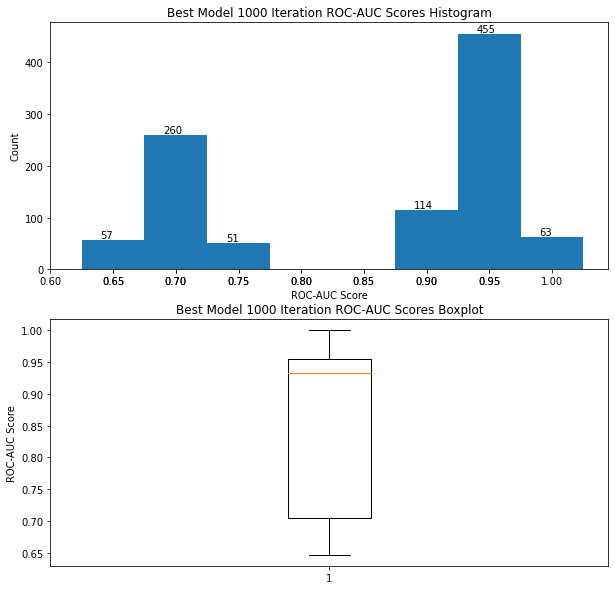

In [ ]:
# ROC-AUC score frequencies
import scipy

fig, ax = plt.subplots( 2, figsize=(10,10))
bins = [.6,.65,.65,.7,.7,.75,.75,.8,.8,.85,.85,.9,.9,.95,.95,1]
bins = [i+0.025 for i in bins]
counts, _, patches =ax[0].hist(auc_scores, bins=bins)
for count, patch in zip(counts,patches):
  if count >0:
    
    ax[0].annotate(str(int(count)), xy=(patch.get_x()+.015, patch.get_height()+4))

ax[0].set_xticks([.6,.65,.65,.7,.7,.75,.75,.8,.8,.85,.85,.9,.9,.95,.95,1])
ax[0].set_xlabel('ROC-AUC Score')
ax[0].set_ylabel('Count')
ax[0].set_title('Best Model 1000 Iteration ROC-AUC Scores Histogram')

ax[1].set_title('Best Model 1000 Iteration ROC-AUC Scores Boxplot')
ax[1].set_xticks([])
ax[1].set_ylabel('ROC-AUC Score')
c = ax[1].boxplot(auc_scores)

In [ ]:
# Descriptive data for the mean model
scipy.stats.describe(auc_scores)

DescribeResult(nobs=1000, minmax=(0.6477272727272727, 1.0), mean=0.8540227272727272, variance=0.01460193199397745, skewness=-0.5218689243933323, kurtosis=-1.5932545570533407)

In [ ]:
import statistics as stats
scipy.stats.describe(auc_scores)
stats.median(auc_scores)
roc_auc_score(y_test, proba_preds, multi_class='ovo',average='macro')

0.9318181818181818

### Best model classifying for more than one home

Replicates above for a model that showed capacity to classify observations for more than one home.

In [ ]:
# electricity total three-day normalized respiratory outcome data iBOSS
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_roc_curve

with open('/content/resp/electricity_total_ts_resp_norm.pkl','rb') as df:
  best_df = pickle.load(df)

x = best_df['living_consumption_3day'].dropna()
y = best_df['living_consumption_3day_label'].dropna()
mdl =  IndividualBOSS()
x_label = 'living_consumption_3day'
y_label = 'living_consumption_3day_label'
auc_scores = []
marices = []
for i in range(1000):
  mdl =  IndividualBOSS()
  x_train, x_test, y_train, y_test = train_test_split(x,y, stratify=y, test_size=.3)
  x_train = pd.DataFrame(x_train)
  x_test = pd.DataFrame(x_test)
  imbalance_instances = []
  minority_classes = ['decline']
  count_constant = y_train.to_list().count('constat')
  count_decline = y_train.to_list().count('decline')
  count_improvement = y_train.to_list().count('improvement')
  mdl.fit(x_train, y_train)

  proba_preds = mdl.predict_proba(x_test)
  auc_score = roc_auc_score(y_test,proba_preds, multi_class='ovo')
  auc_scores.append(auc_score)
  mean_auc2 = 0.8
  if mean_auc2-delta<= auc_score <= mean_auc2+delta:
    print(i)
    mean_xtrain = x_train
    mean_ytrain = y_train
    mean_xtest = x_test
    mean_ytest = y_test
    mean_mdl = mdl
  preds = mdl.predict(x_test)
  conf_mtrx = confusion_matrix(y_test, preds)
  
  #below to monitor where the execution stands
  if i % 100 == 0:
    print('Evaluating iteration:',i)

Evaluating iteration: 0
Evaluating iteration: 100
Evaluating iteration: 200
Evaluating iteration: 300
Evaluating iteration: 400
Evaluating iteration: 500
Evaluating iteration: 600
Evaluating iteration: 700
Evaluating iteration: 800
Evaluating iteration: 900


In [ ]:
mean_auc = stats.mean(auc_scores)
delta = 0.004
mean_auc

0.803440446650124

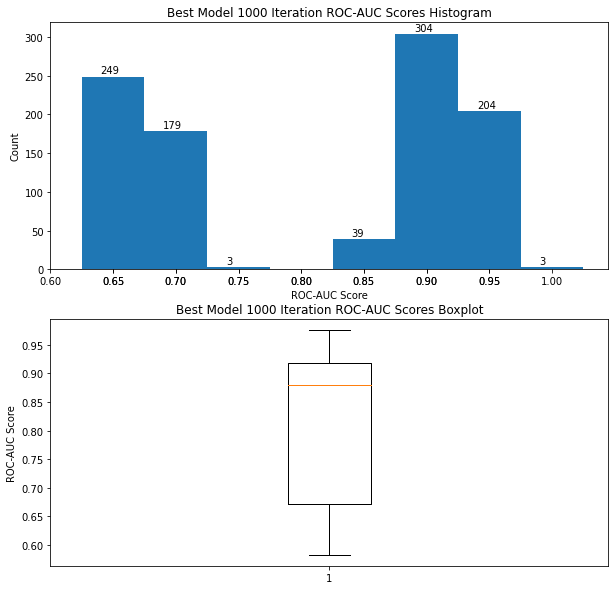

In [ ]:
import scipy

fig, ax = plt.subplots( 2, figsize=(10,10))
bins = [.6,.65,.65,.7,.7,.75,.75,.8,.8,.85,.85,.9,.9,.95,.95,1]
bins = [i+0.025 for i in bins]
counts, _, patches =ax[0].hist(auc_scores, bins=bins)
for count, patch in zip(counts,patches):
  if count >0:
    
    ax[0].annotate(str(int(count)), xy=(patch.get_x()+.015, patch.get_height()+4))

ax[0].set_xticks([.6,.65,.65,.7,.7,.75,.75,.8,.8,.85,.85,.9,.9,.95,.95,1])
ax[0].set_xlabel('ROC-AUC Score')
ax[0].set_ylabel('Count')
ax[0].set_title('Best Model 1000 Iteration ROC-AUC Scores Histogram')

ax[1].set_title('Best Model 1000 Iteration ROC-AUC Scores Boxplot')
ax[1].set_xticks([])
ax[1].set_ylabel('ROC-AUC Score')
c = ax[1].boxplot(auc_scores)

In [ ]:
scipy.stats.describe(auc_scores)


DescribeResult(nobs=1000, minmax=(0.5831265508684864, 0.9758064516129034), mean=0.803440446650124, variance=0.01587085221254356, skewness=-0.1883129329565905, kurtosis=-1.8015454688363912)

In [ ]:
import statistics as stats
scipy.stats.describe(auc_scores)
stats.median(auc_scores)
roc_auc_score(y_test, proba_preds, multi_class='ovo',average='macro')

0.890818858560794